# 0.Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. _slab_, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**_Целью_** данной работы является создание модели для решения задачи _регрессии_ с целью предсказания конечной температуры производимой на предприятии стали.

Для её реализации необходимо выполнить задачи в соответствии со следующим планом:

1. Загрузить все наборы данных и проверить их на соответствие типов;
2. Провести исследовательский анализ данных, выделить в них особенности и применить там, где это возможно, средства визуализации;
3. Почистить, скорректировать и подготовить данные к дальнейшему использованию моделями и разделить на обучающую и тестовую выборки;
4. Обучить несколько различных моделей, проверить их качество на кросс-валидации, по возможности улучшить качество за счёт изменения гиперпараметров;
5. Провести проверку одной выбранной модели на тестовой выборке и сравнить её с baseline моделью.


# 1.Загрузка данных и их анализ


Устанавливаем и подключаем необходимые библиотеки


In [1]:
!pip install pandas==2.0.0 matplotlib==3.7.0 phik optuna scikit-learn==1.2.2 scikit-learn-intelex catboost lightgbm==3.3.5 xgboost==1.7.5 -q

In [2]:
import warnings

import pandas as pd
import numpy as np
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearnex.linear_model import Lasso
from sklearnex.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, plot_importance as plot_importance_lgbm
from xgboost import XGBRegressor, plot_importance

In [3]:
# Если будете запускать код, то придётся делать это из среды тренажёра яндекса
try:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_URL = '/content/drive/MyDrive/Colab_Notebooks/' + \
               'Yandex_Projects/Final_Project/'
except:
    BASE_URL = '/datasets/final_steel/'

Настраиваем необходимые в дальнейшем параметры


In [4]:
%config InlineBackend.figure_format='retina'
warnings.filterwarnings('ignore')
SEED = 100423

Считываем данные и приводим их к более классическому виду


In [5]:
df_arc = pd.read_csv(BASE_URL + 'data_arc.csv', parse_dates=[1, 2])
df_bulk = pd.read_csv(BASE_URL + 'data_bulk.csv')
df_bulk_time = pd.read_csv(BASE_URL + 'data_bulk_time.csv',
                           parse_dates=list(range(1, 16)))
df_gas = pd.read_csv(BASE_URL + 'data_gas.csv')
df_temp = pd.read_csv(BASE_URL + 'data_temp.csv', parse_dates=[1])
df_wire = pd.read_csv(BASE_URL + 'data_wire.csv')
df_wire_time = pd.read_csv(BASE_URL + 'data_wire_time.csv',
                           parse_dates=list(range(1, 10)))

In [6]:
df_arc = df_arc.rename(columns={
    'Начало нагрева дугой': 'arc_heating_start_time',
    'Конец нагрева дугой': 'arc_heating_end_time',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power'})
df_bulk.columns = df_bulk.columns.str.lower().str.replace(' ', '_')

df_bulk_time.columns = df_bulk_time.columns.str.lower().str.replace(' ', '_')
df_bulk_time = (df_bulk_time.add_suffix('_time')
                .rename(columns={'key_time': 'key'}))
df_gas = df_gas.rename(columns={'Газ 1': 'gas'})
df_temp = df_temp.rename(columns={'Время замера': 'measure_time',
                                  'Температура': 'temperature'})
df_wire.columns = df_wire.columns.str.lower().str.replace(' ', '_')
df_wire_time.columns = df_wire_time.columns.str.lower().str.replace(' ', '_')
df_wire_time = (df_wire_time.add_suffix('_time')
                .rename(columns={'key_time': 'key'}))

Напишем ряд функций для изучения данных:

- df_fast_info - собирает информацию о датафрейме и выводит её на экран;
- df_plot_hist - строит гистограммы для всего датафрейма или конкретных столбцов;
- df_plot_corr - строит матрицу корреляций между параметрами и показывает её в виде тепловой карты.


In [7]:
def df_fast_info(df):
    print('Общая информация о данных:')
    df.info()
    print('\nПервые 3 строки датафрейма:')
    display(df.head(3))
    print('\nПолные дубликаты:')
    display(df.duplicated().sum())
    print('\nОписательные статистики:')
    display(df.describe().T)

    display(pd.DataFrame({'Кол-во уникальных значений': df.nunique(),
                          'Доля пропусков': df.isna().mean()},
                          index=df.columns)
            .sort_values(by='Доля пропусков', ascending=False))

def df_plot_hist(df, cols_to_plot=None):
    print('\nГистограммы:')
    columns = df.columns if cols_to_plot is None else cols_to_plot
    for i in columns:
        df[i].hist(bins=100, figsize=(15, 8), edgecolor='k')
        plt.title(f'Гистограмма для переменной {i}')
        plt.xlabel('Разброс значений')
        plt.ylabel('Количество появлений в данных')
        plt.grid(False, axis='y')
        plt.show()

def df_plot_corr(df):
    print('\nКорреляция:')
    if len(df.select_dtypes(exclude='datetime').columns) > 1:
        phik_overview = phik_matrix(
            df=df.select_dtypes(exclude='datetime'),
            interval_cols=df.select_dtypes(exclude='datetime').columns)

        plot_correlation_matrix(phik_overview.values, 
                                x_labels=phik_overview.columns, 
                                y_labels=phik_overview.index, 
                                vmin=0, vmax=1, color_map='Spectral_r',
                                title=r'Корреляция $\phi_K$',
                                figsize=(9.5, 9.5))
        plt.tight_layout()

**Вывод**: На текущем этапе все наборы с данными загружены, приведены к удобному для работы формату, как названия колонок, так и типы данных. Также написаны дополнительные функции для качественного изучения данных.


# 1.1 Данные об электродах(arc)


In [8]:
df_fast_info(df_arc)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     14876 non-null  int64         
 1   arc_heating_start_time  14876 non-null  datetime64[ns]
 2   arc_heating_end_time    14876 non-null  datetime64[ns]
 3   active_power            14876 non-null  float64       
 4   reactive_power          14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB

Первые 3 строки датафрейма:


,key,arc_heating_start_time,arc_heating_end_time,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805



Полные дубликаты:


0


Описательные статистики:


,count,mean,min,25%,50%,75%,max,std
key,14876.0,1615.220422,1.0,806.0,1617.0,2429.0,3241.0,934.571502
arc_heating_start_time,14876,2019-07-02 16:15:28.218203904,2019-05-03 11:02:14,2019-06-02 07:01:09.249999872,2019-06-30 09:57:14.500000,2019-08-03 13:04:47.750000128,2019-09-01 04:34:47,NaN
arc_heating_end_time,14876,2019-07-02 16:18:19.889150208,2019-05-03 11:06:02,2019-06-02 07:04:21,2019-06-30 10:01:01,2019-08-03 13:09:14,2019-09-01 04:36:08,NaN
active_power,14876.0,0.670441,0.030002,0.395297,0.555517,0.857034,3.731596,0.408159
reactive_power,14876.0,0.452592,-715.504924,0.290991,0.415962,0.637371,2.676388,5.878702


,Кол-во уникальных значений,Доля пропусков
key,3214,0.0
arc_heating_start_time,14875,0.0
arc_heating_end_time,14876,0.0
active_power,14869,0.0
reactive_power,14866,0.0


In [9]:
# в столбце arc_heating_start_time есть единственная повторяющаяся дата
df_arc['arc_heating_start_time'].value_counts().head(1)

arc_heating_start_time
2019-06-10 22:02:03    2
Name: count, dtype: int64


Гистограммы:


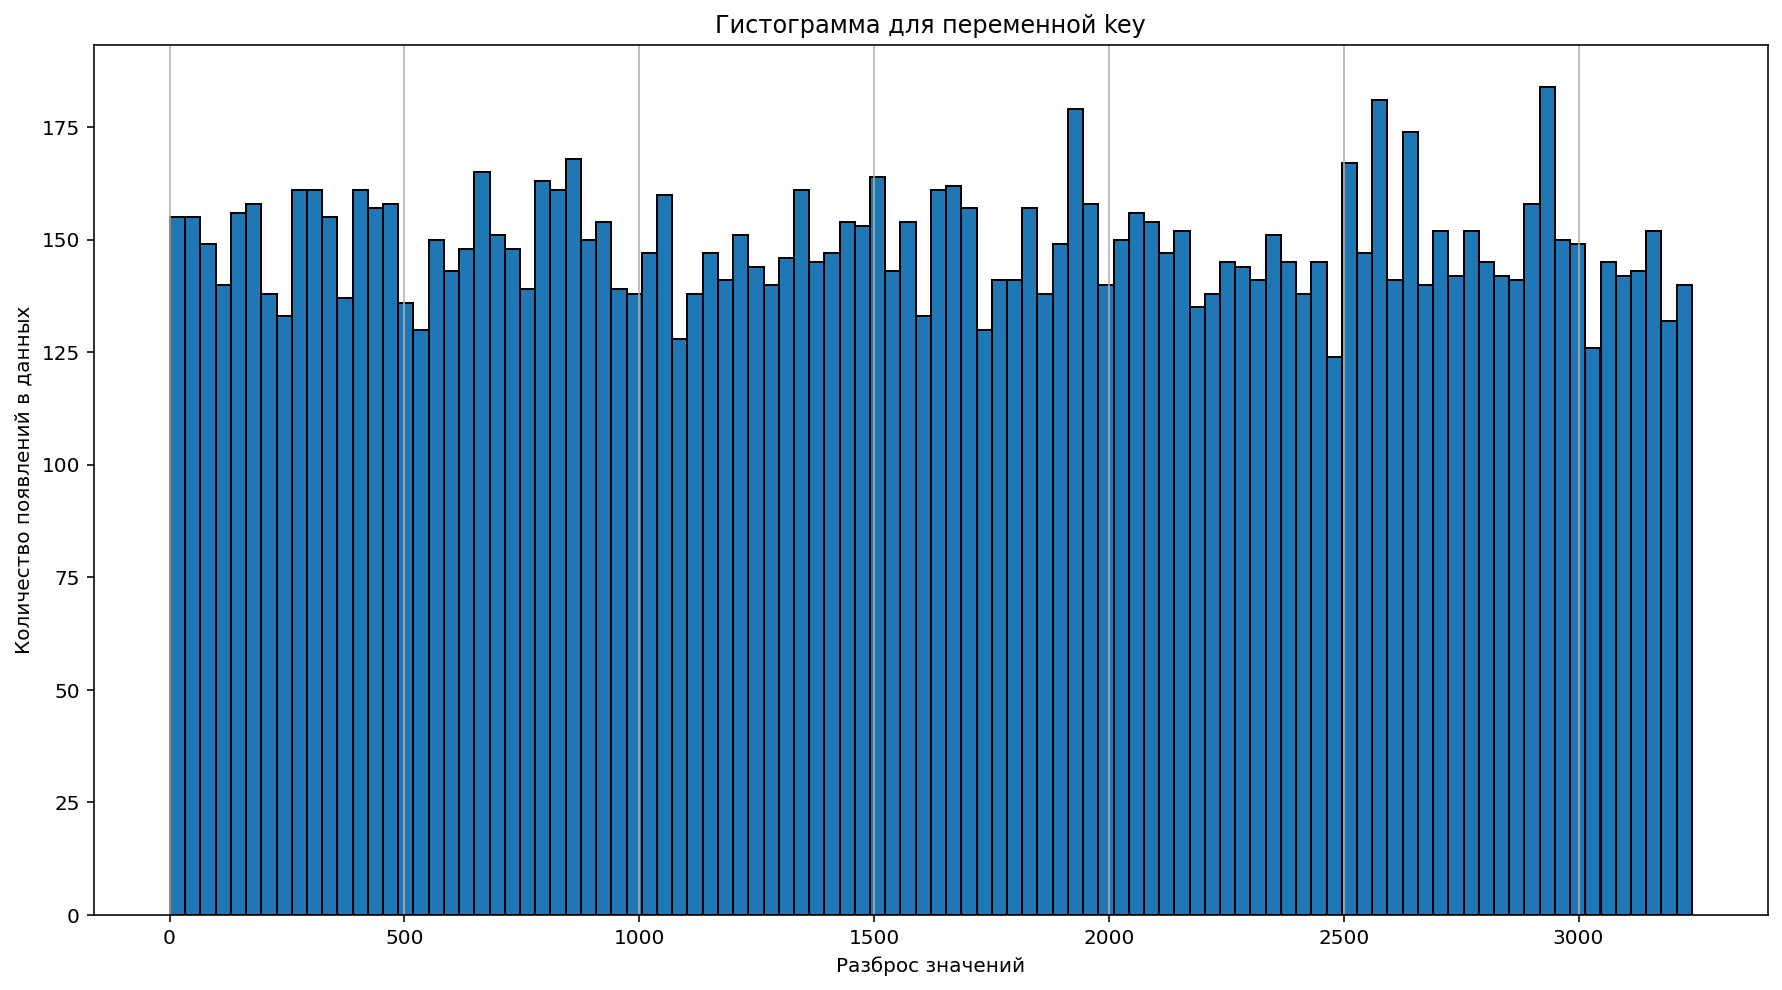

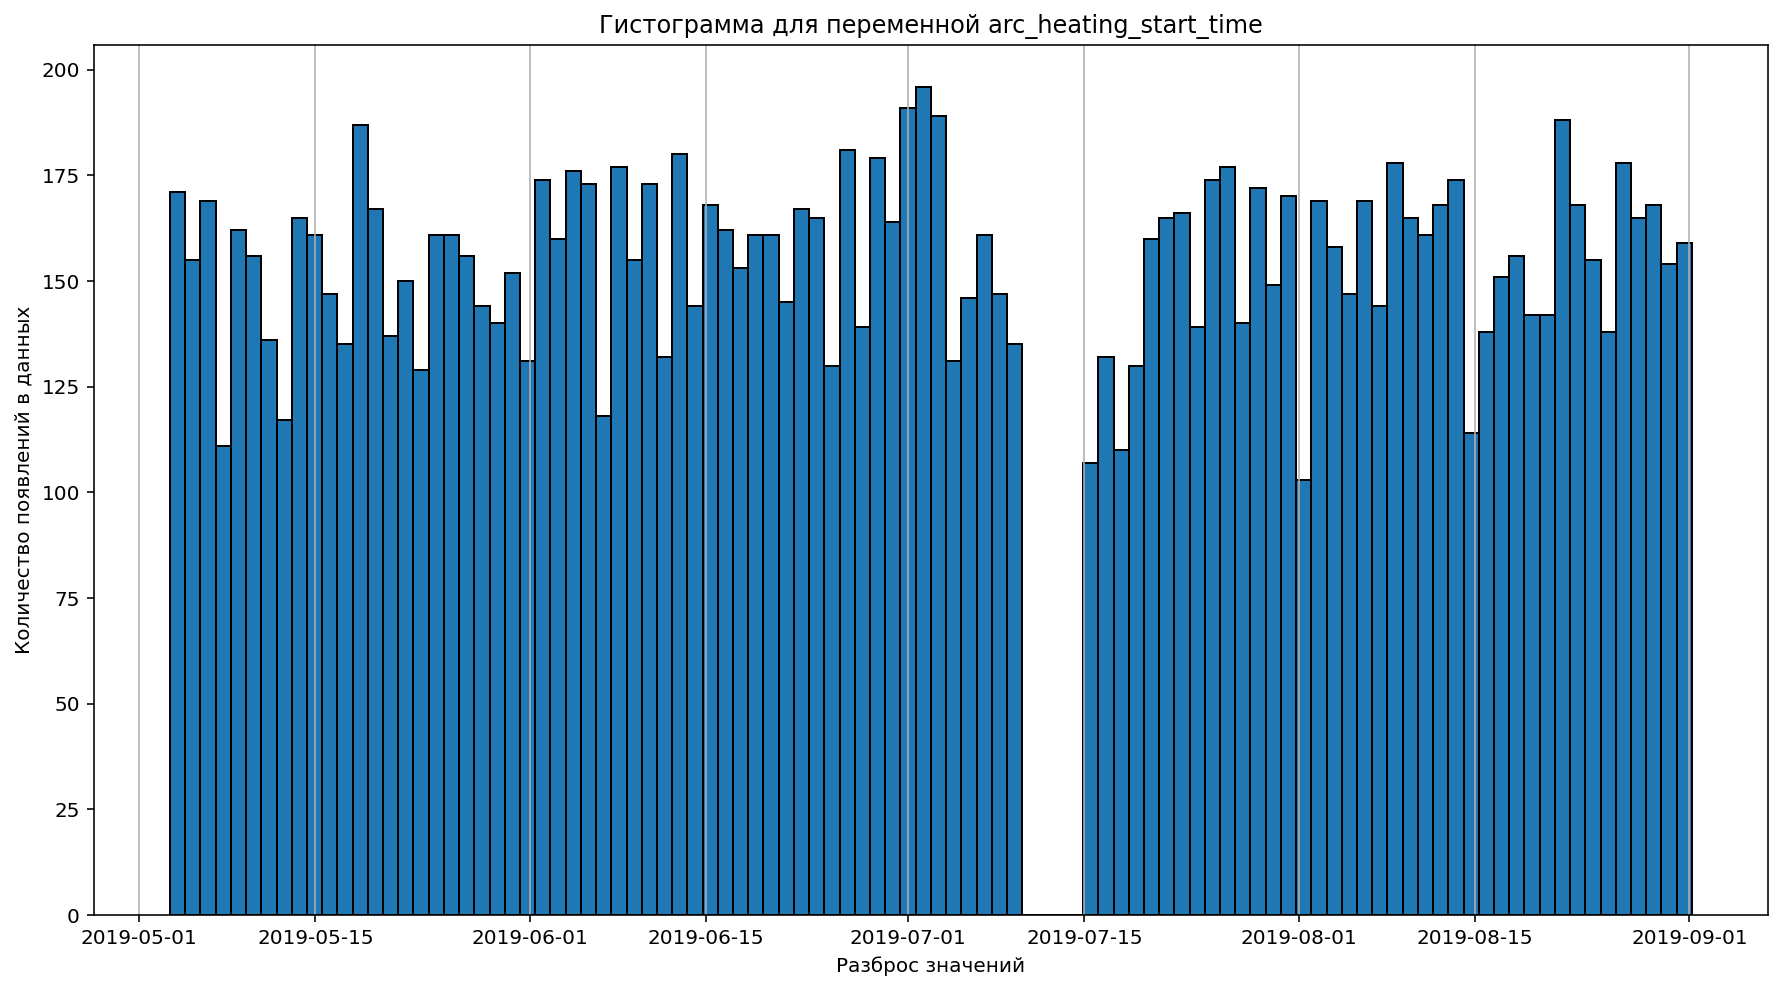

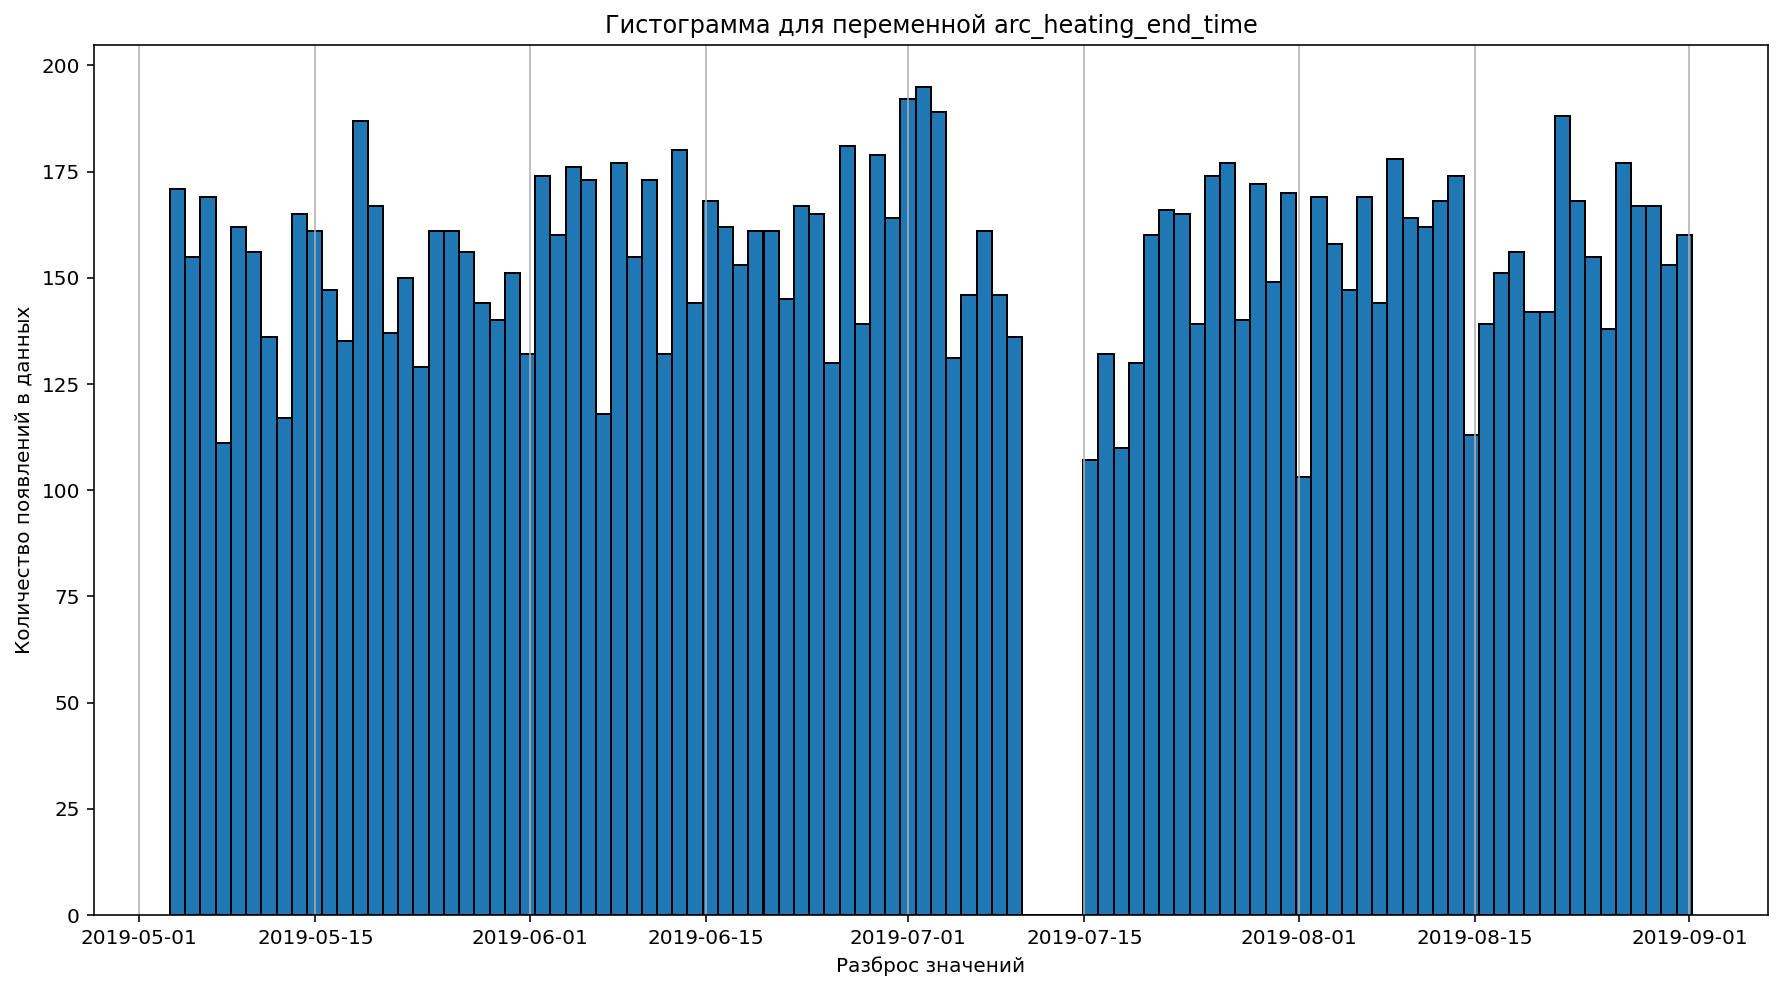

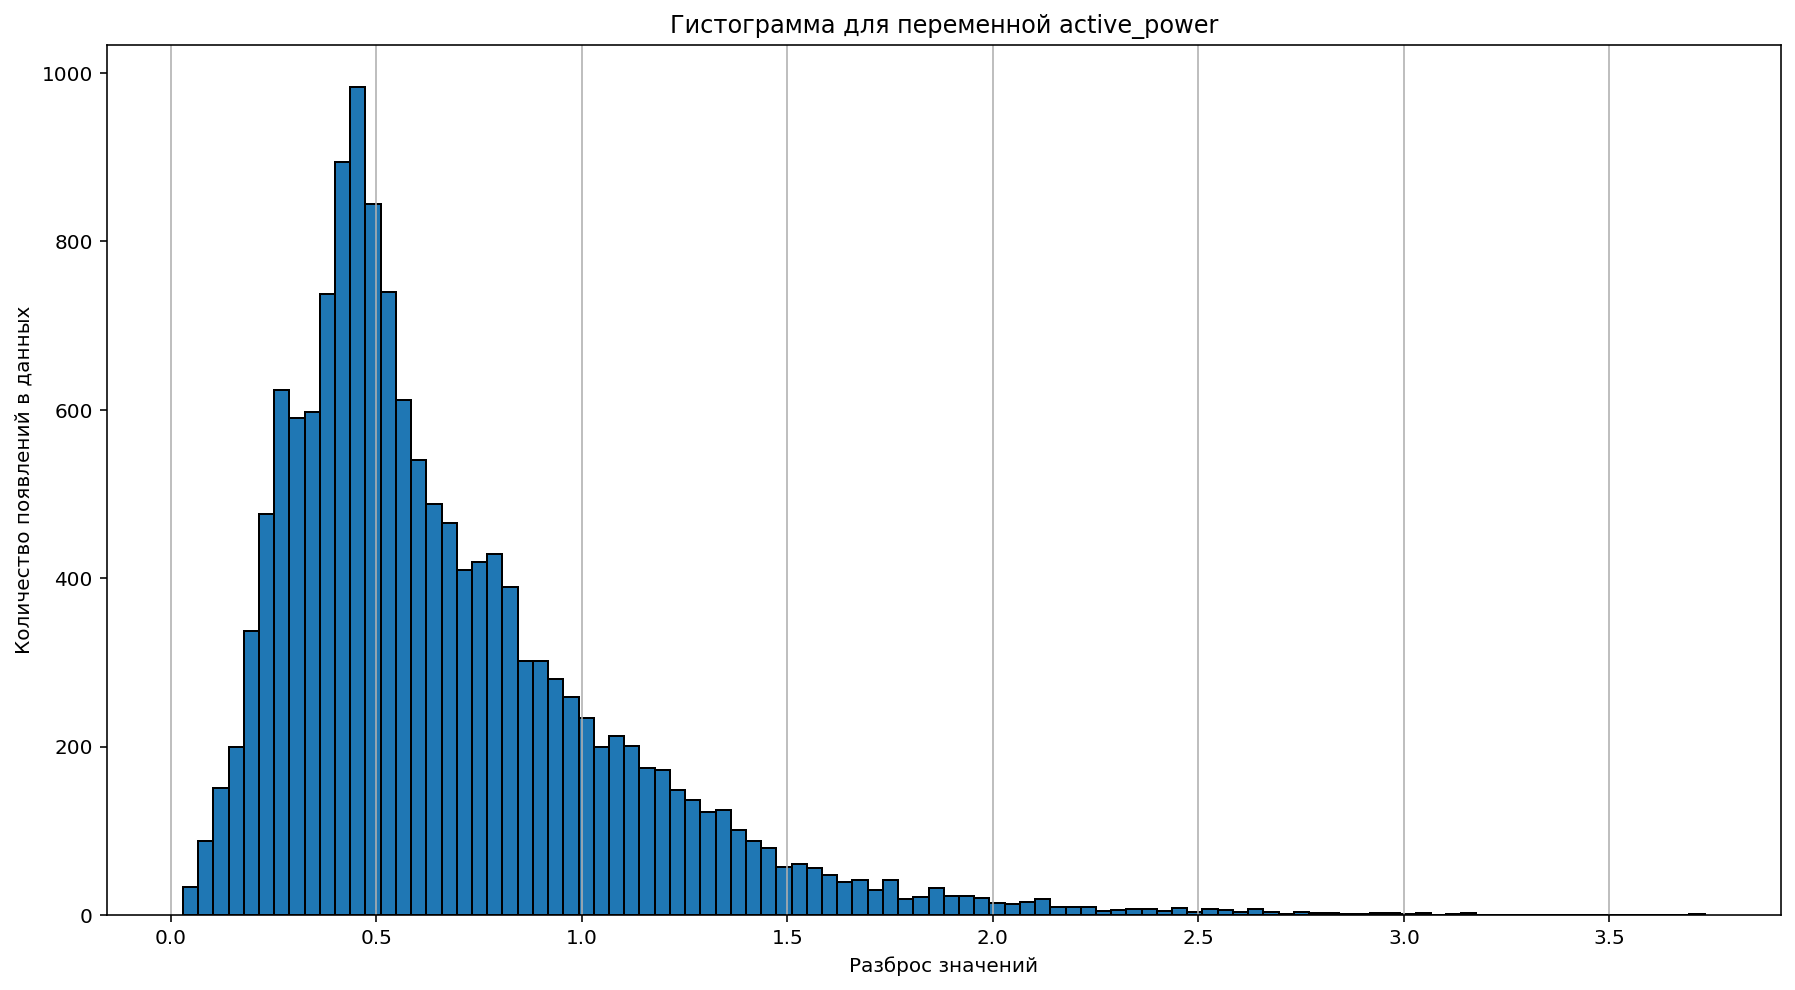

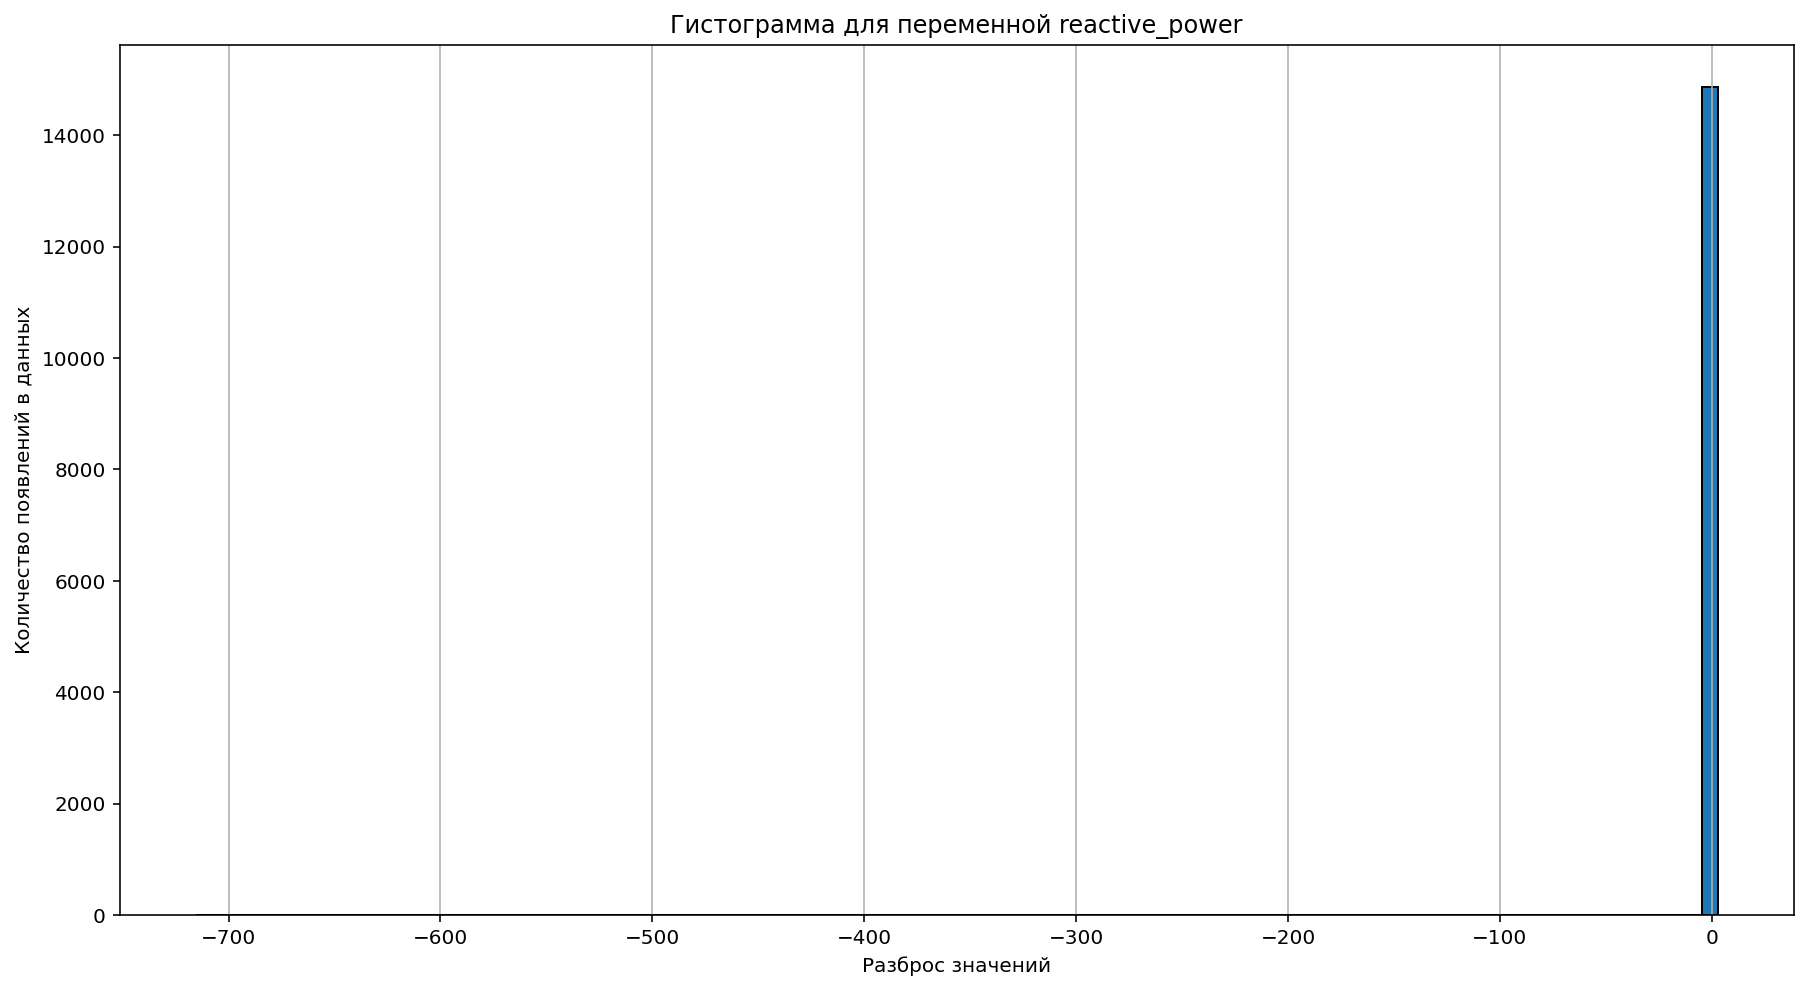

In [10]:
df_plot_hist(df_arc)

В датах наблюдается большой пропуск, попробуем его обнаружить


In [11]:
df_arc.loc[df_arc['arc_heating_start_time'].between('2019-07-10', '2019-07-15')]

,key,arc_heating_start_time,arc_heating_end_time,active_power,reactive_power
8728,1899,2019-07-10 00:35:25,2019-07-10 00:37:32,0.416167,0.361145
8729,1899,2019-07-10 00:44:50,2019-07-10 00:53:11,2.071217,1.714313
8730,1899,2019-07-10 00:54:37,2019-07-10 00:57:52,0.872728,0.612388
8731,1899,2019-07-10 00:59:13,2019-07-10 01:02:36,0.910008,0.616204
8732,1899,2019-07-10 01:04:59,2019-07-10 01:05:55,0.242389,0.179130
8733,1900,2019-07-14 23:17:28,2019-07-14 23:18:44,0.261596,0.203939
8734,1900,2019-07-14 23:23:26,2019-07-14 23:27:21,0.770129,0.573527
8735,1900,2019-07-14 23:51:38,2019-07-14 23:56:09,0.908687,0.813689



Корреляция:


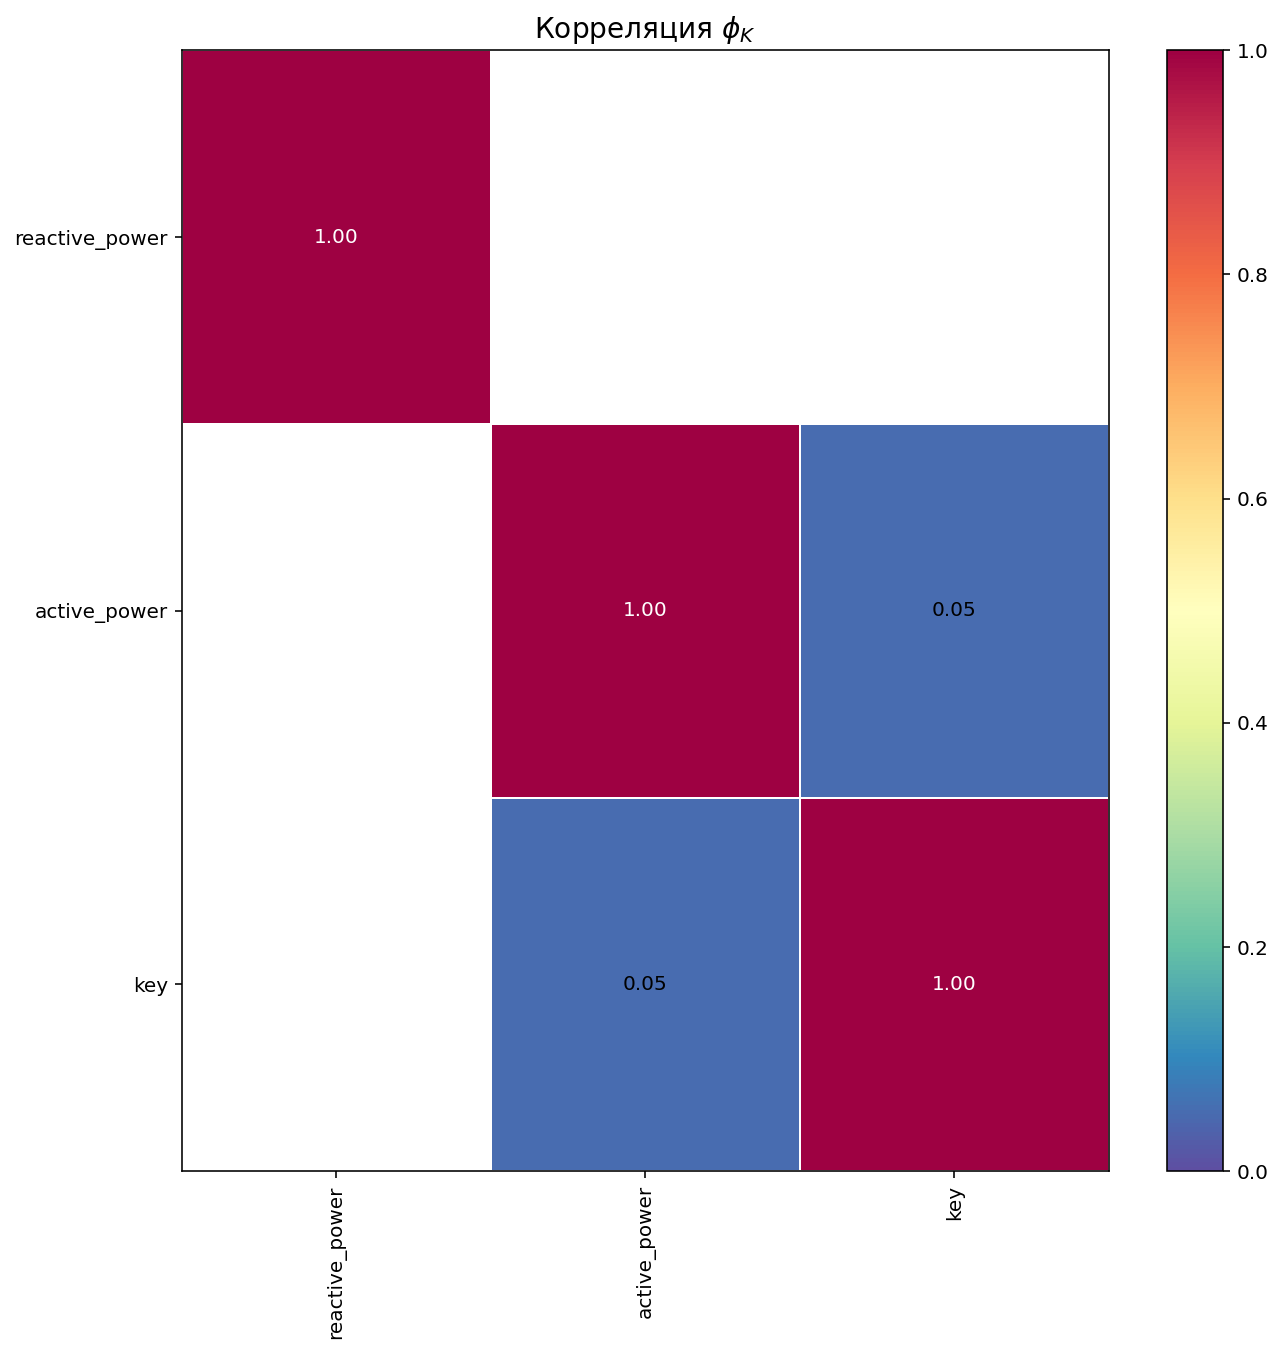

In [12]:
df_plot_corr(df_arc)

Матрица корреляций возвращает None, это происходит поскольку в столбце 'reactive_power' имеется один большой отрицательный выброс(-715.504924). Удалим его и попробуем снова построить корреляцию.


In [13]:
df_arc = df_arc.query('reactive_power >= 0')


Корреляция:


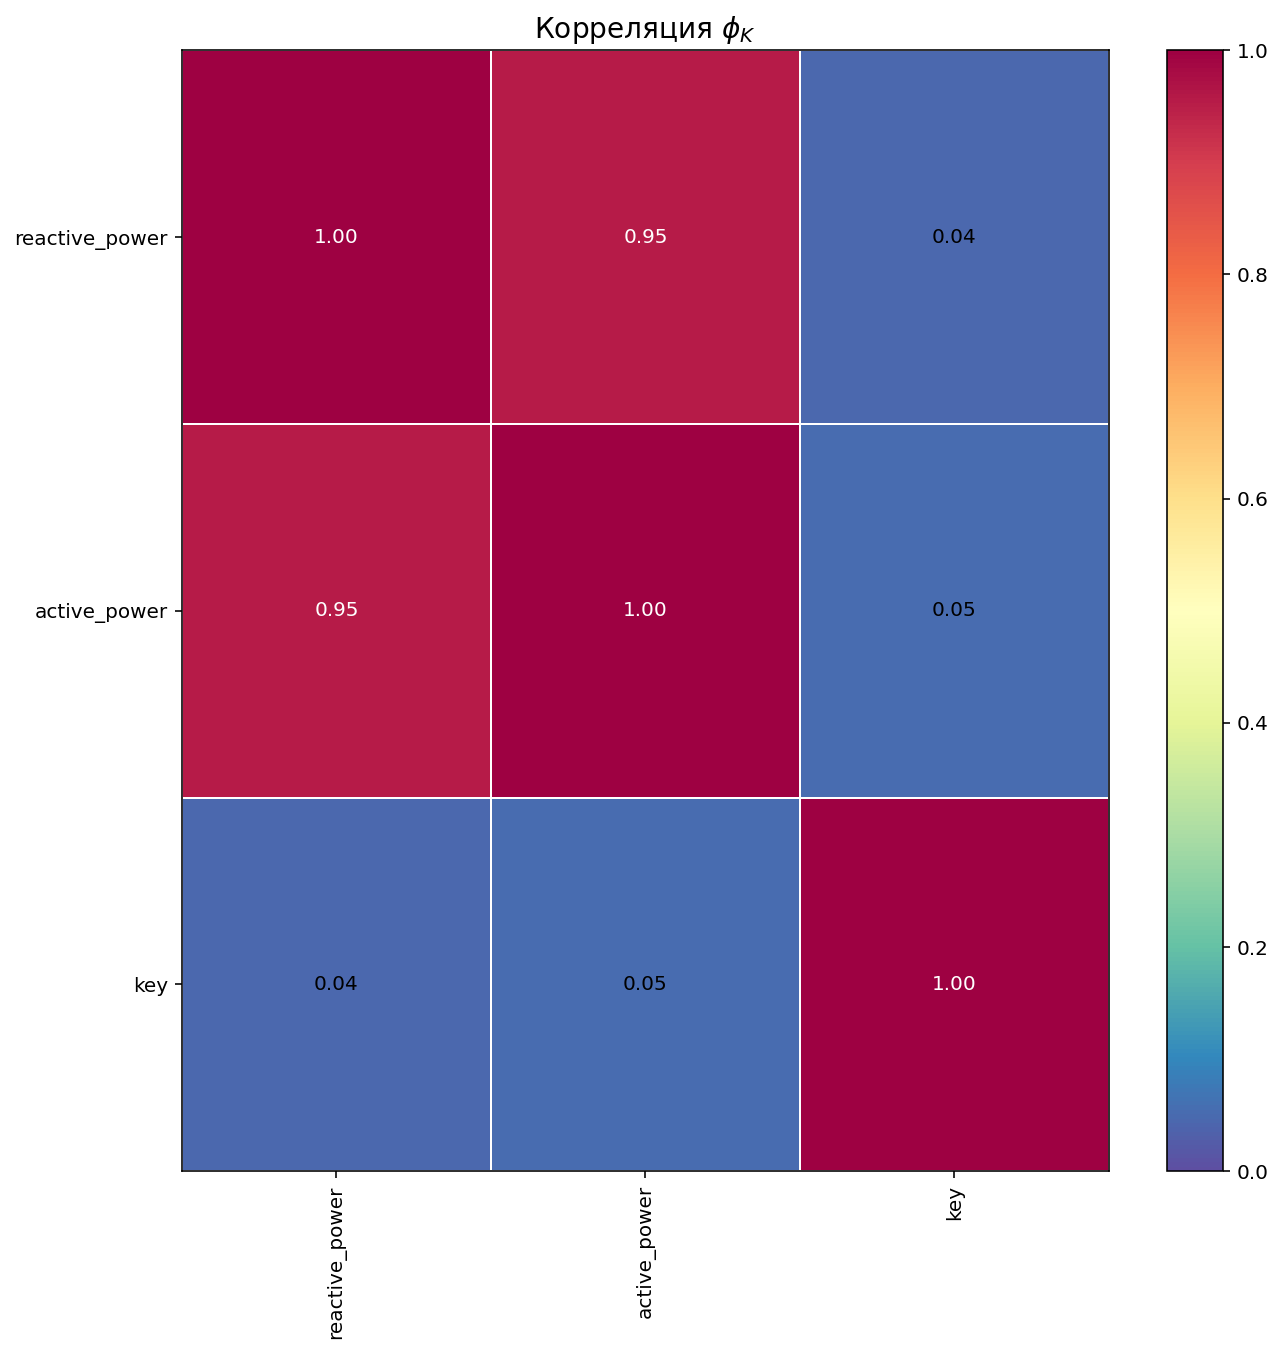

In [14]:
df_plot_corr(df_arc)

Теперь всё корректно. Проверим, как выглядит гистограмма 'reactive_power' без выбросов



Гистограммы:


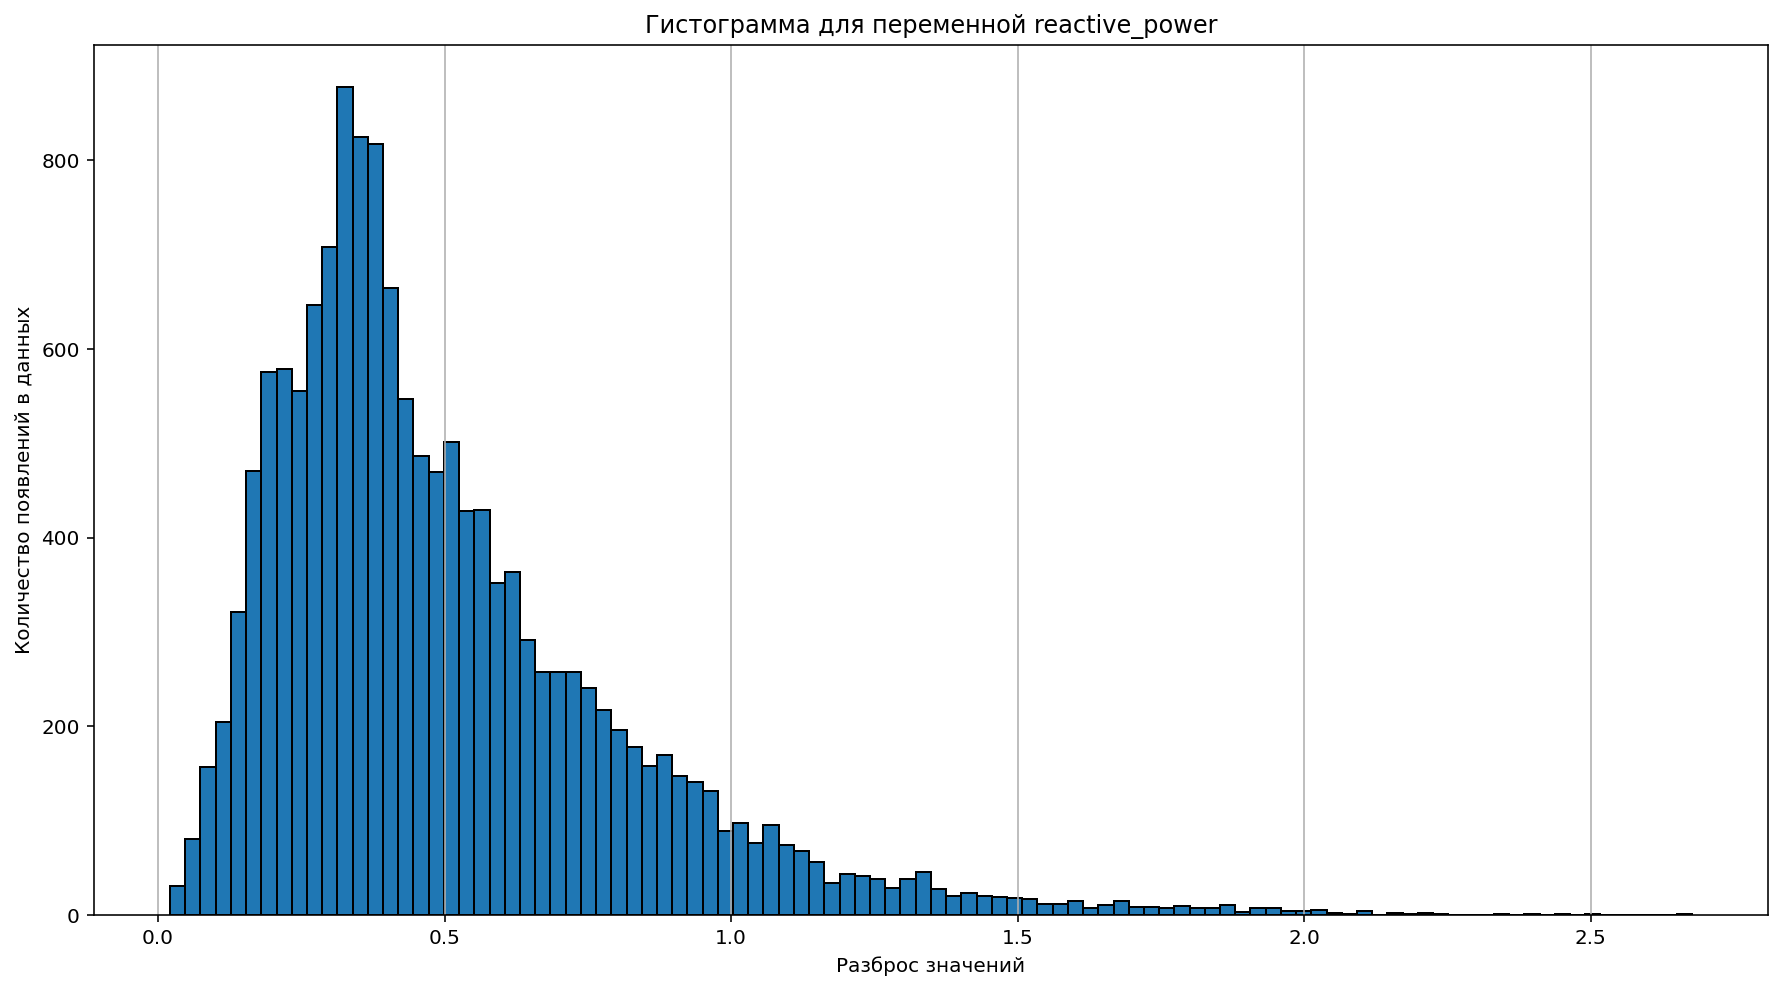

In [15]:
df_plot_hist(df_arc, ['reactive_power'])

Проверим корелляцию между мощностями


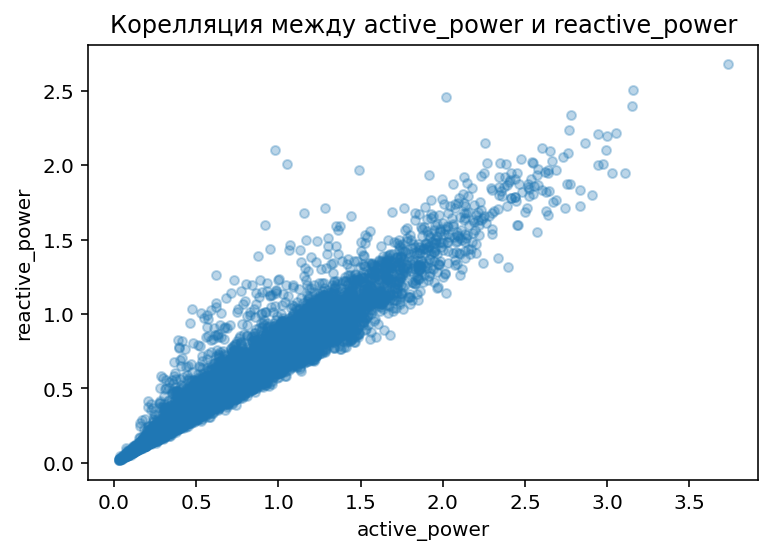

In [16]:
df_arc.plot.scatter('active_power', 'reactive_power', alpha=.3,
                    title='Корелляция между active_power и reactive_power');

Вывод:

- Датафрейм содержит почти 15000 строк, представлены как числовые данные, так и даты;
- Пропуски отсутствуют, удалён явный выброс в одном из столбцов;
- Из всех значений уникальны только даты в столбце 'active_power', одна дата начала нагрева дугой повторяется(2019-06-10 22:02:03);
- Отсутствуют данные с 2019-07-11 по 2019-07-13 включительно;
- Активная и реактивная мощность имеют логнормальное распределение, а также имеют высокую линейную зависимость между собой;
- Даты и ключи склоняются к равномерному распределению;
- Для одной и той же партии может содержаться до 16 измерений.


# 1.2 Данные о подаче сыпучих материалов (объём) - bulk


In [17]:
df_fast_info(df_bulk)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Первые 3 строки датафрейма:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0



Полные дубликаты:


0


Описательные статистики:


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
bulk_1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
bulk_2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
bulk_3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
bulk_4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
bulk_5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
bulk_6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
bulk_7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
bulk_8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
bulk_9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


,Кол-во уникальных значений,Доля пропусков
bulk_8,1,0.999680
bulk_13,14,0.994247
bulk_9,10,0.993928
bulk_2,15,0.992969
bulk_7,25,0.992010
bulk_5,55,0.975391
bulk_10,77,0.943752
bulk_11,101,0.943432
bulk_1,47,0.919463
bulk_6,205,0.815916



Гистограммы:


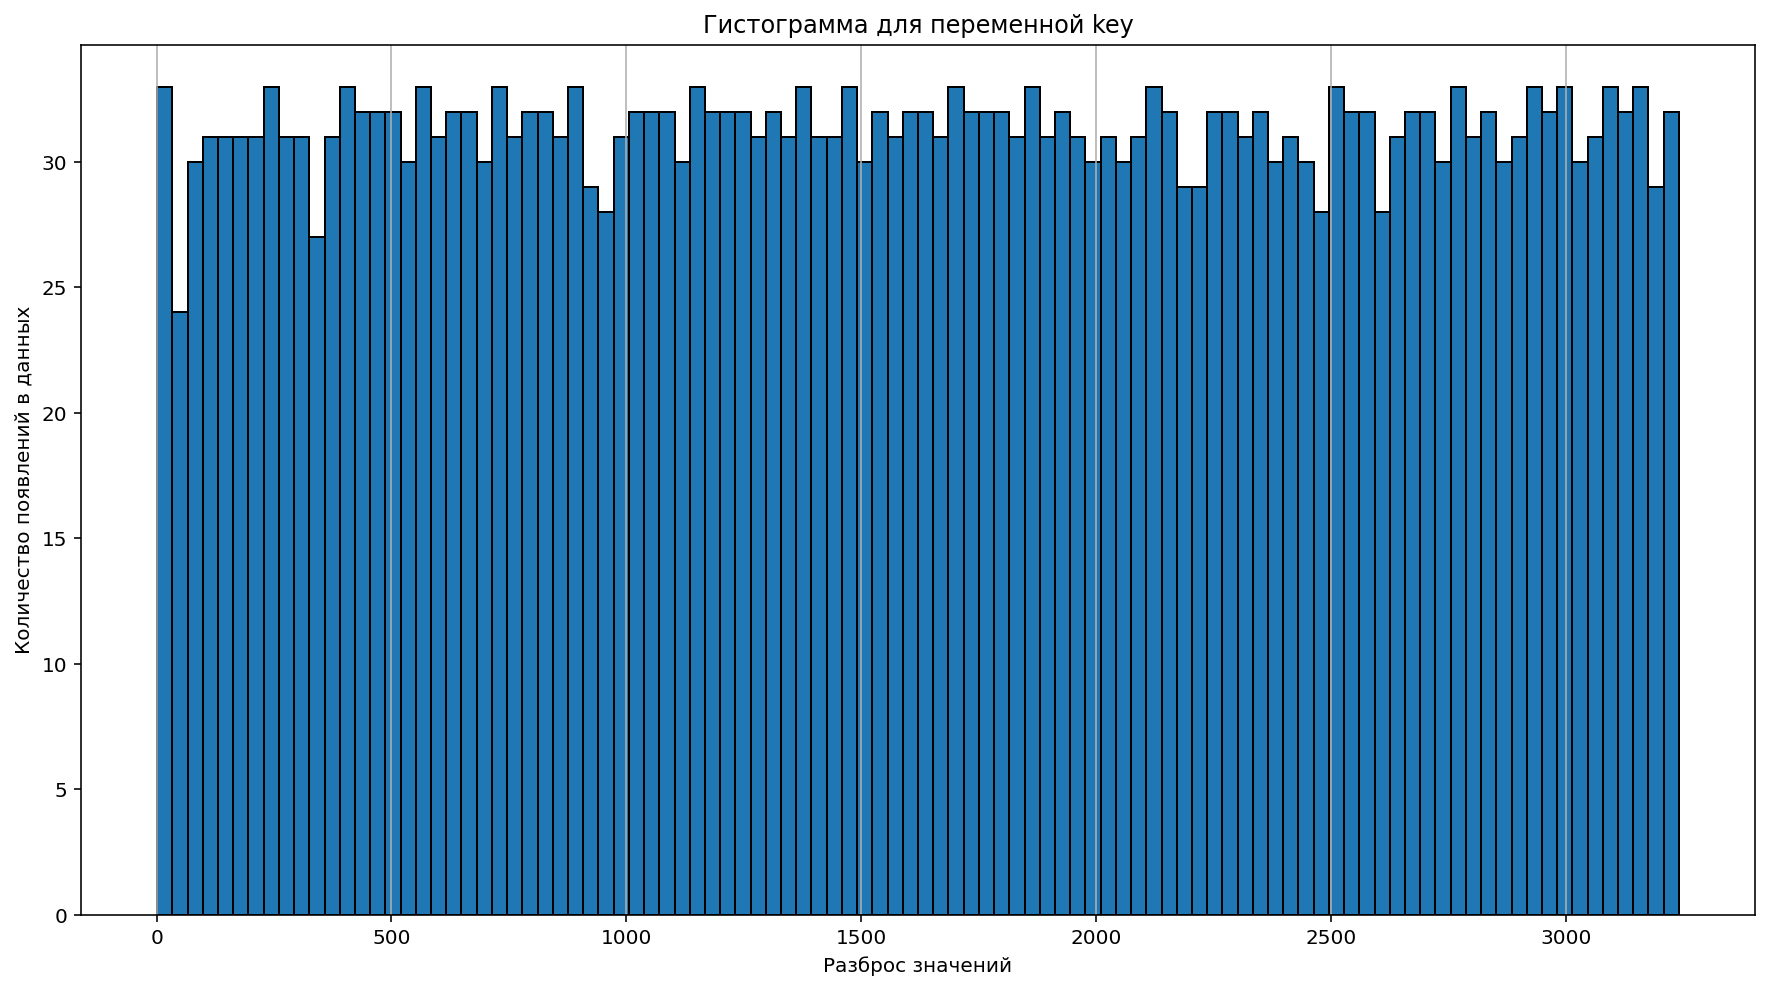

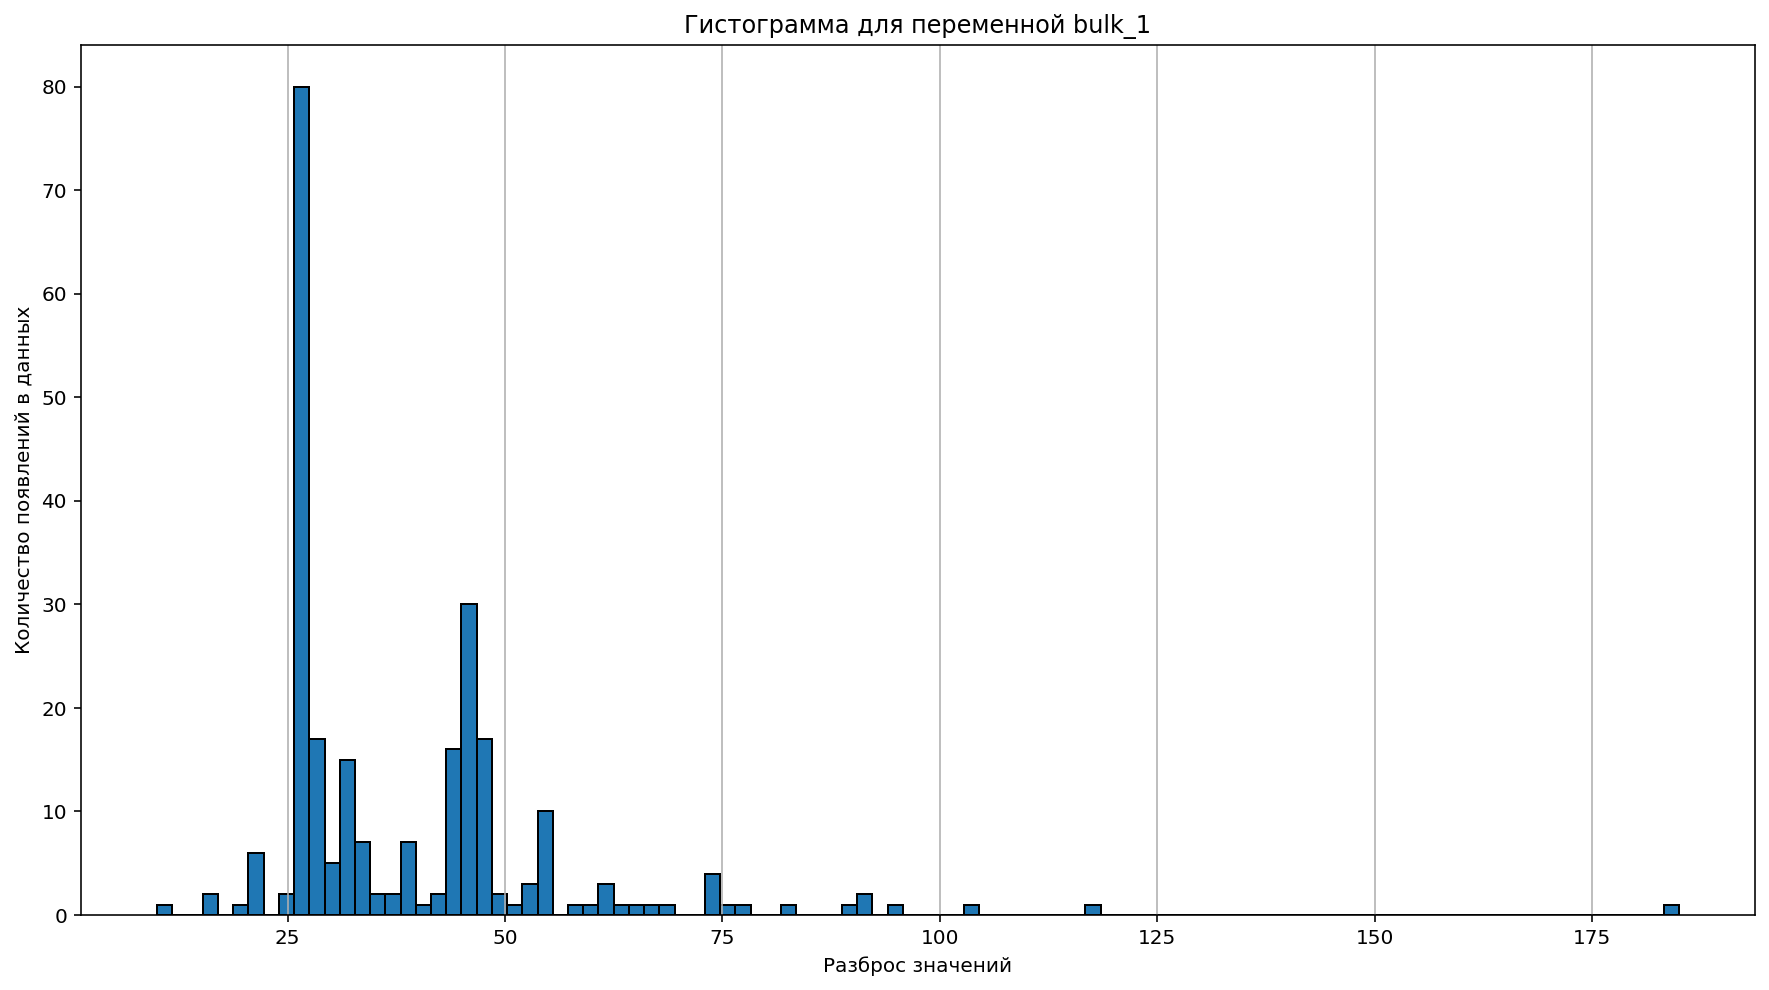

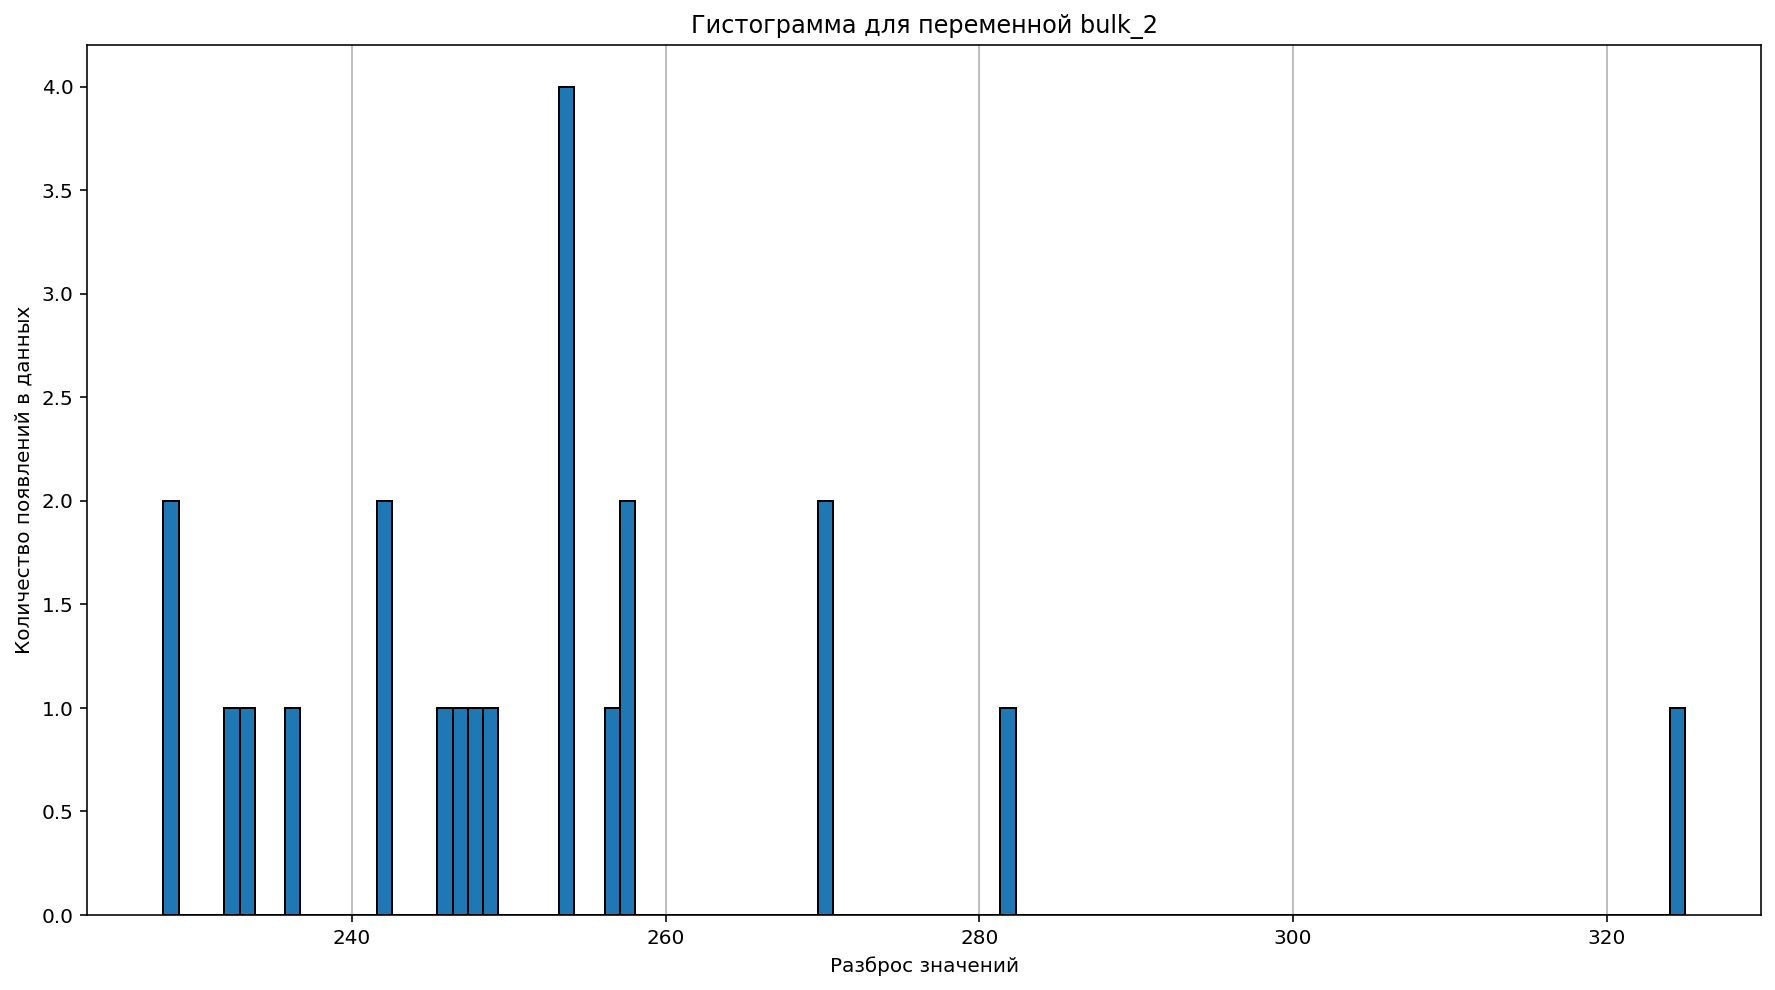

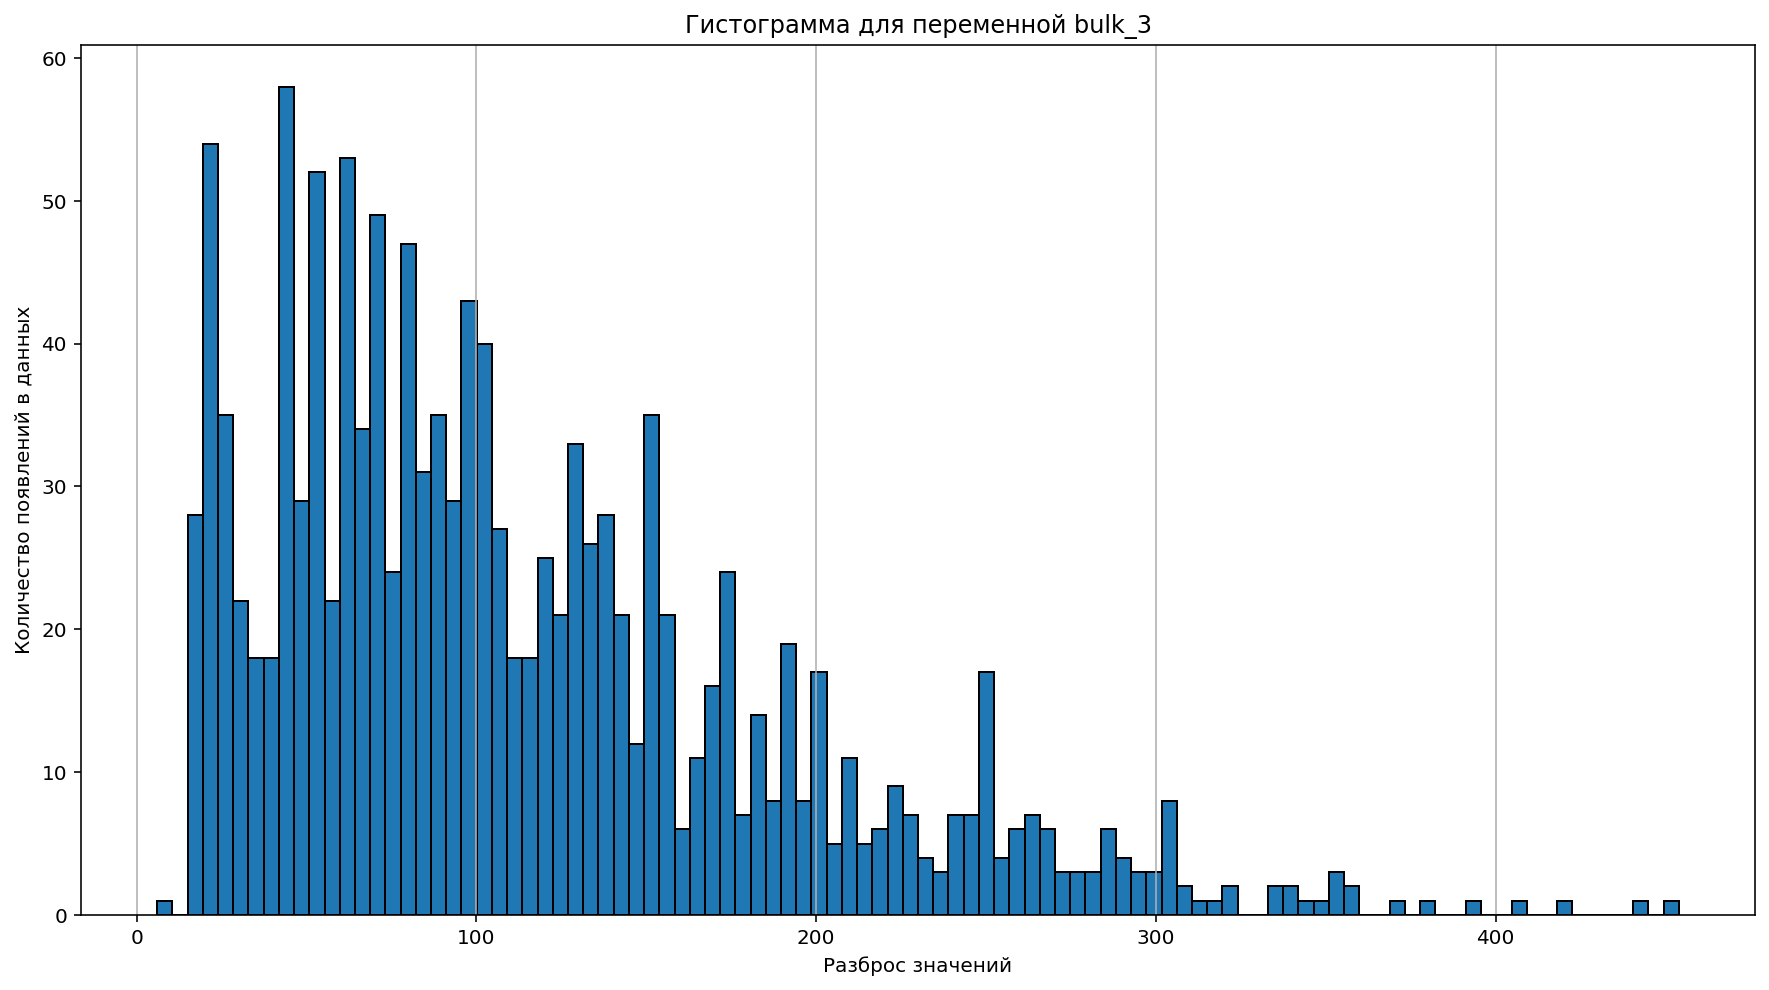

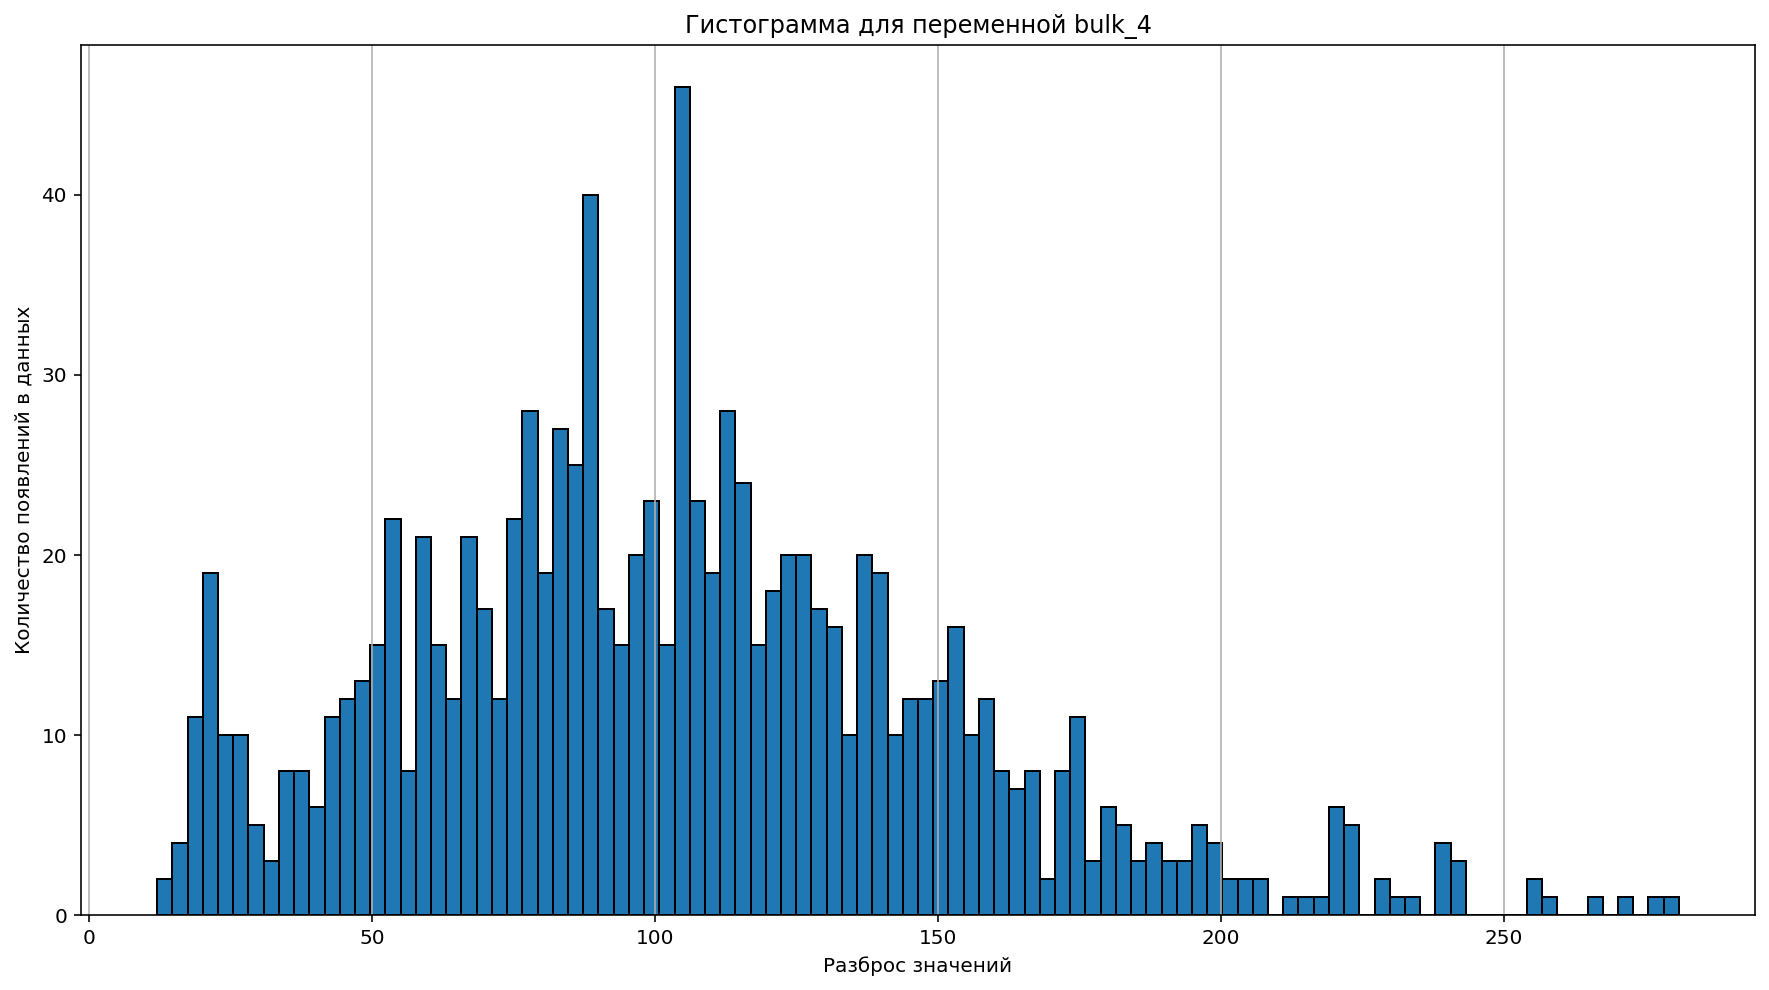

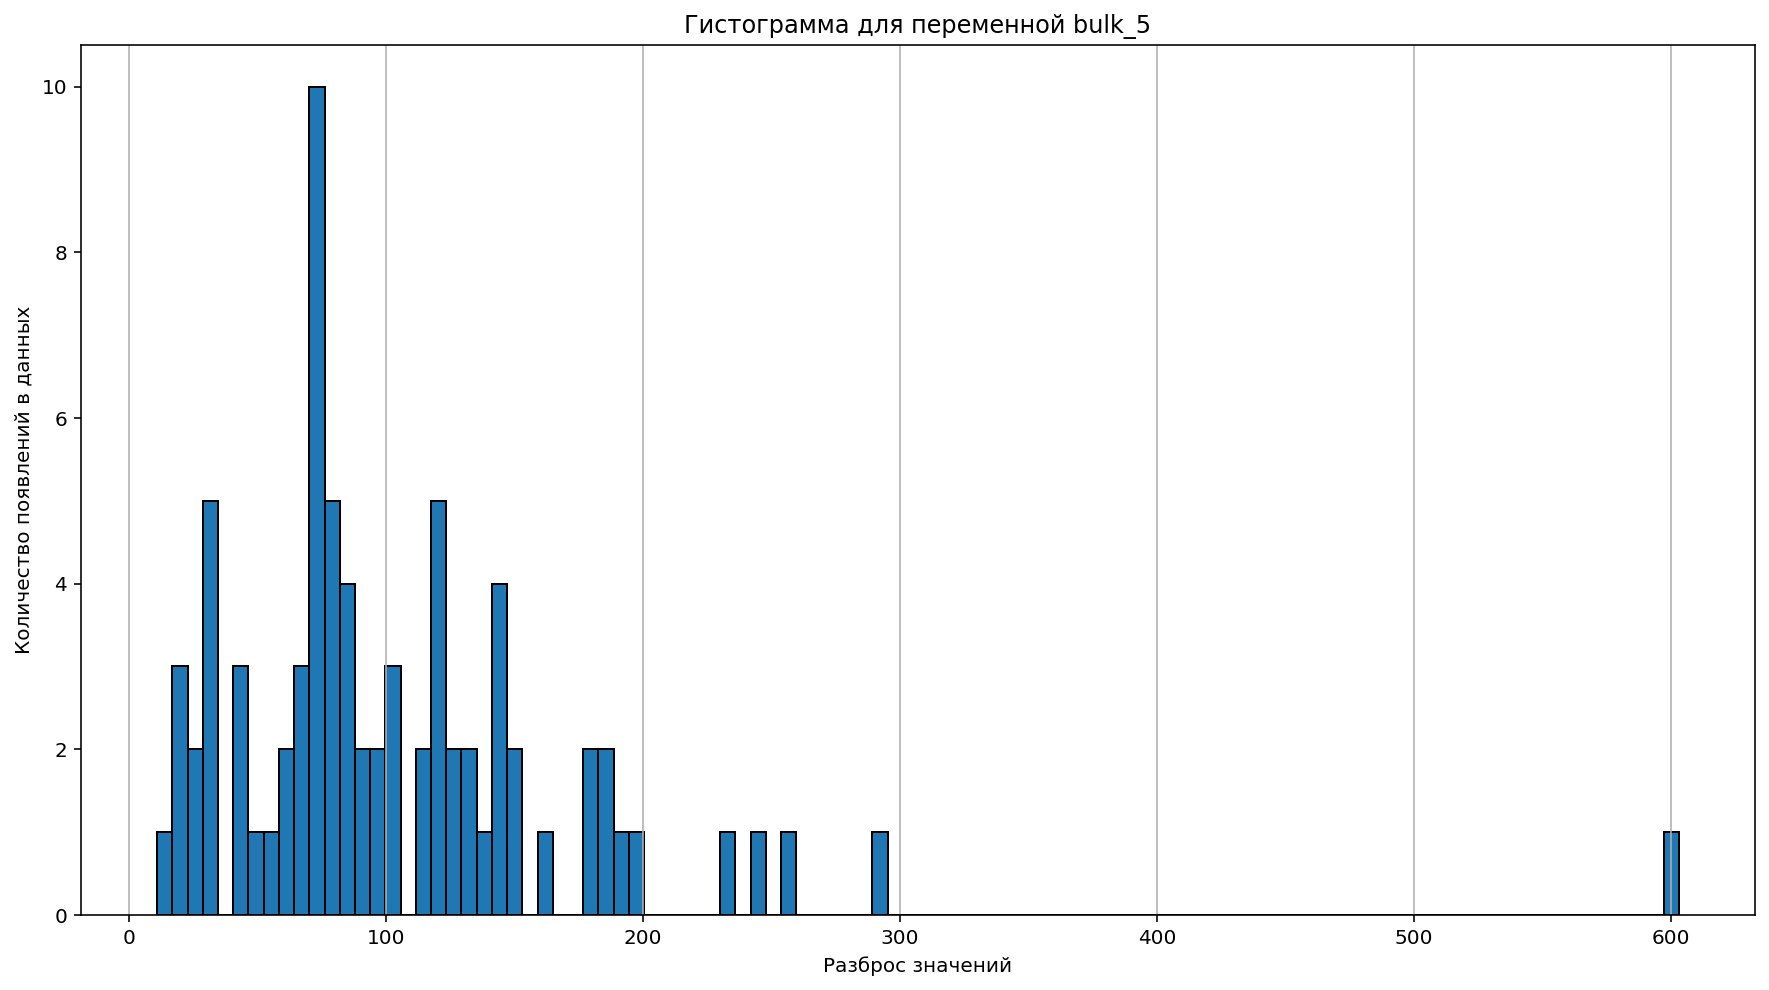

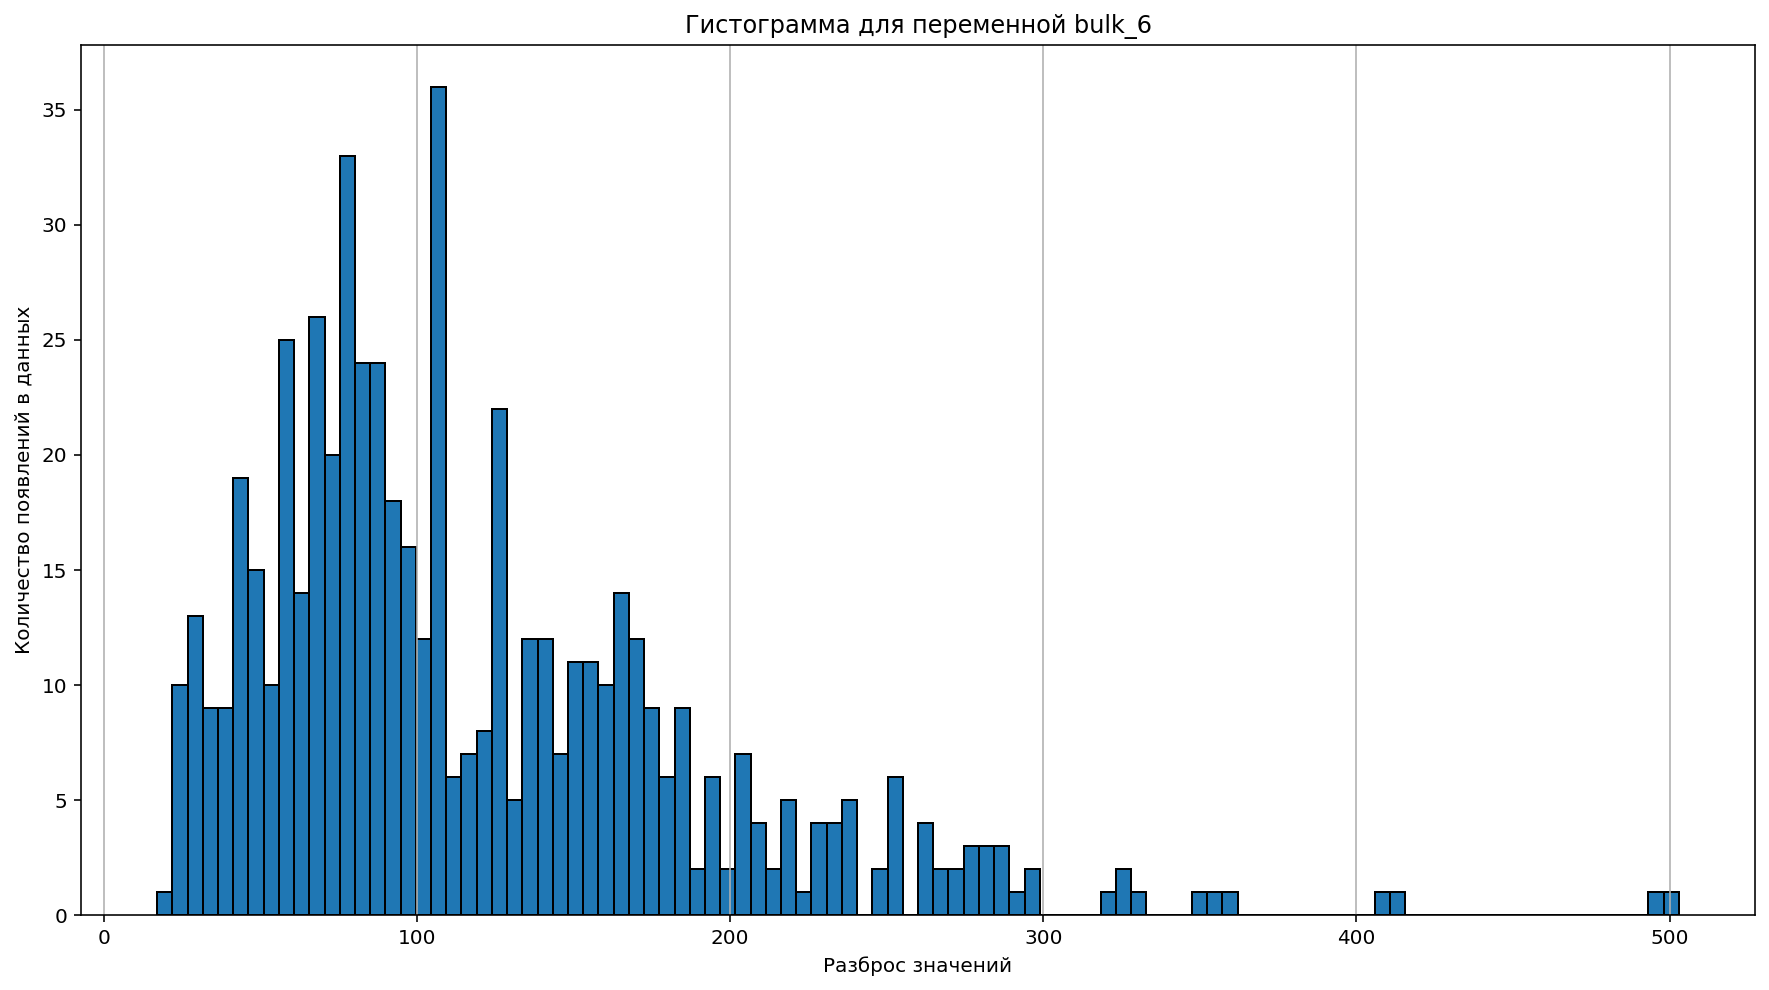

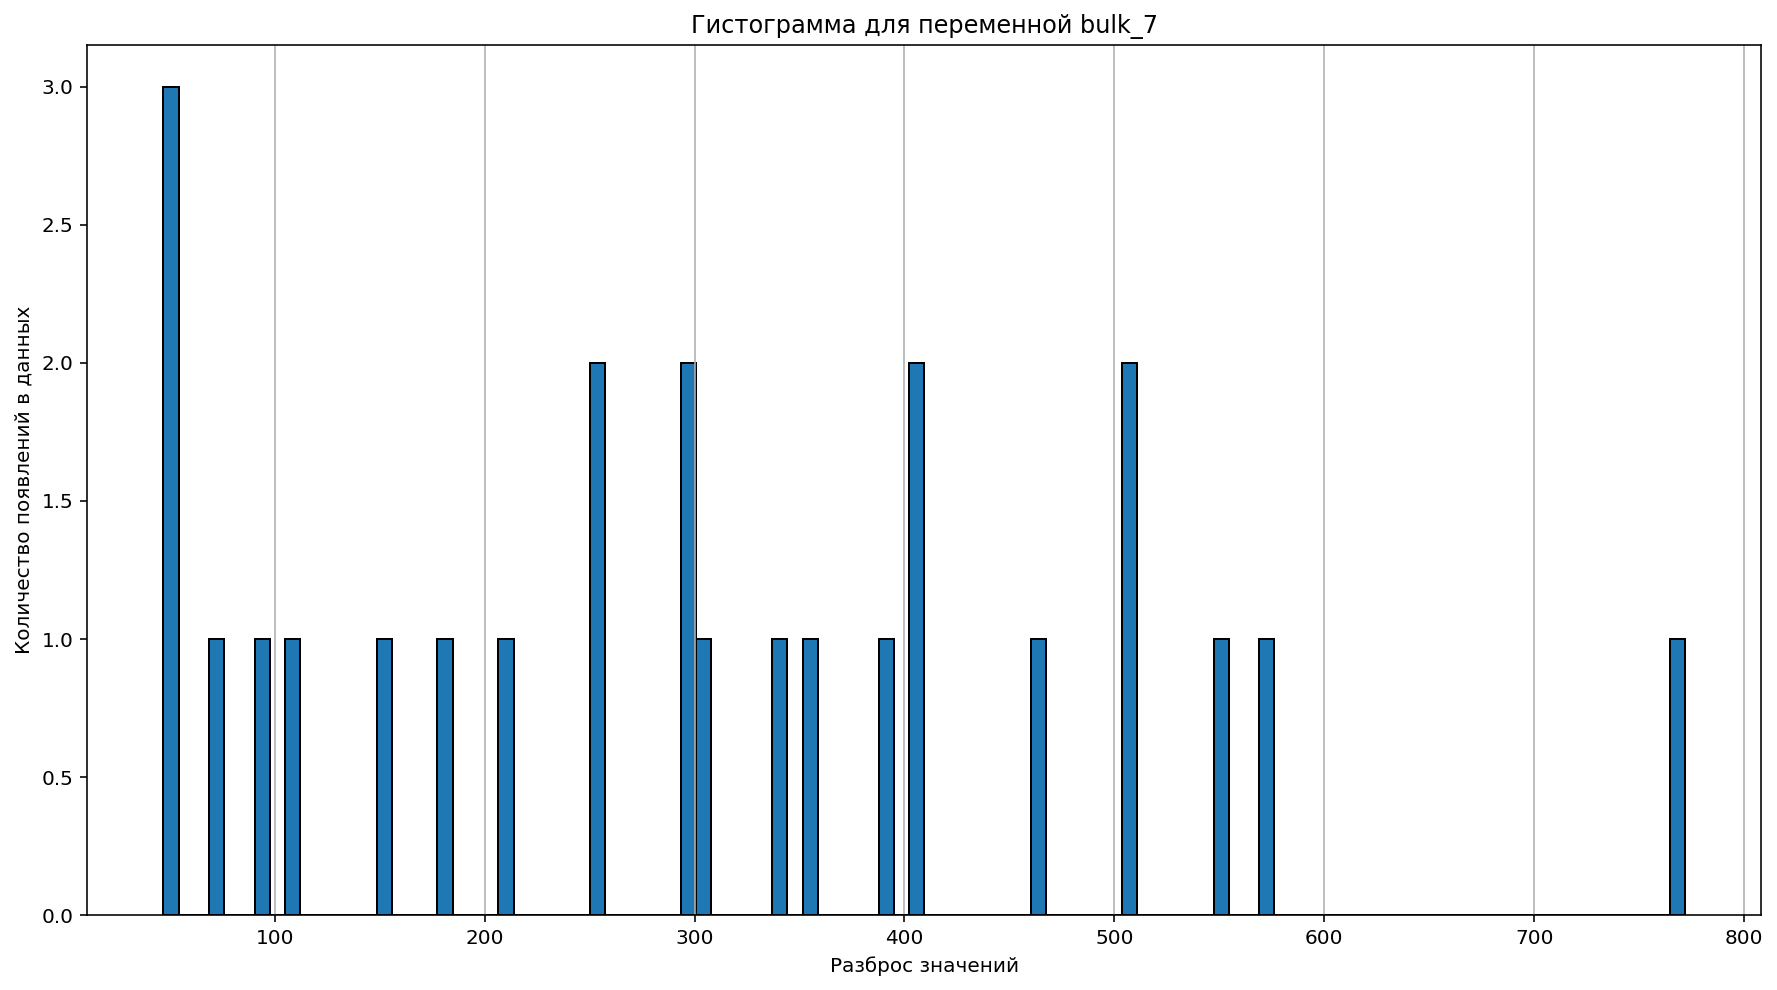

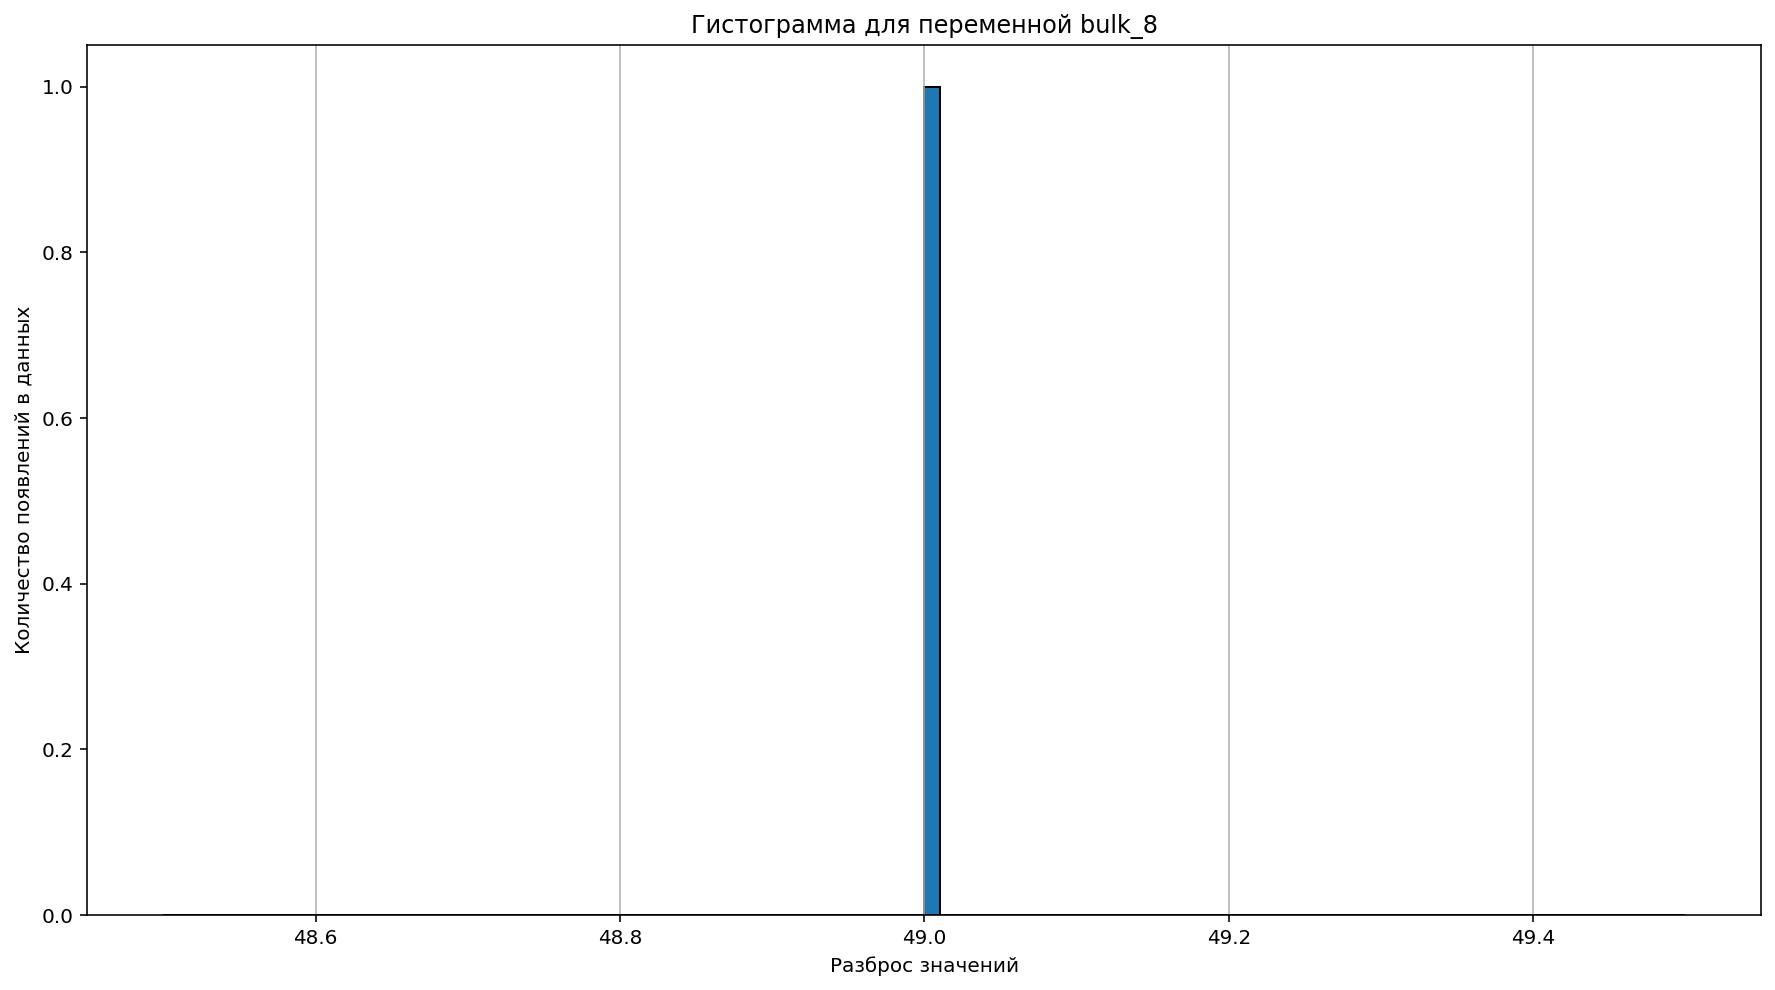

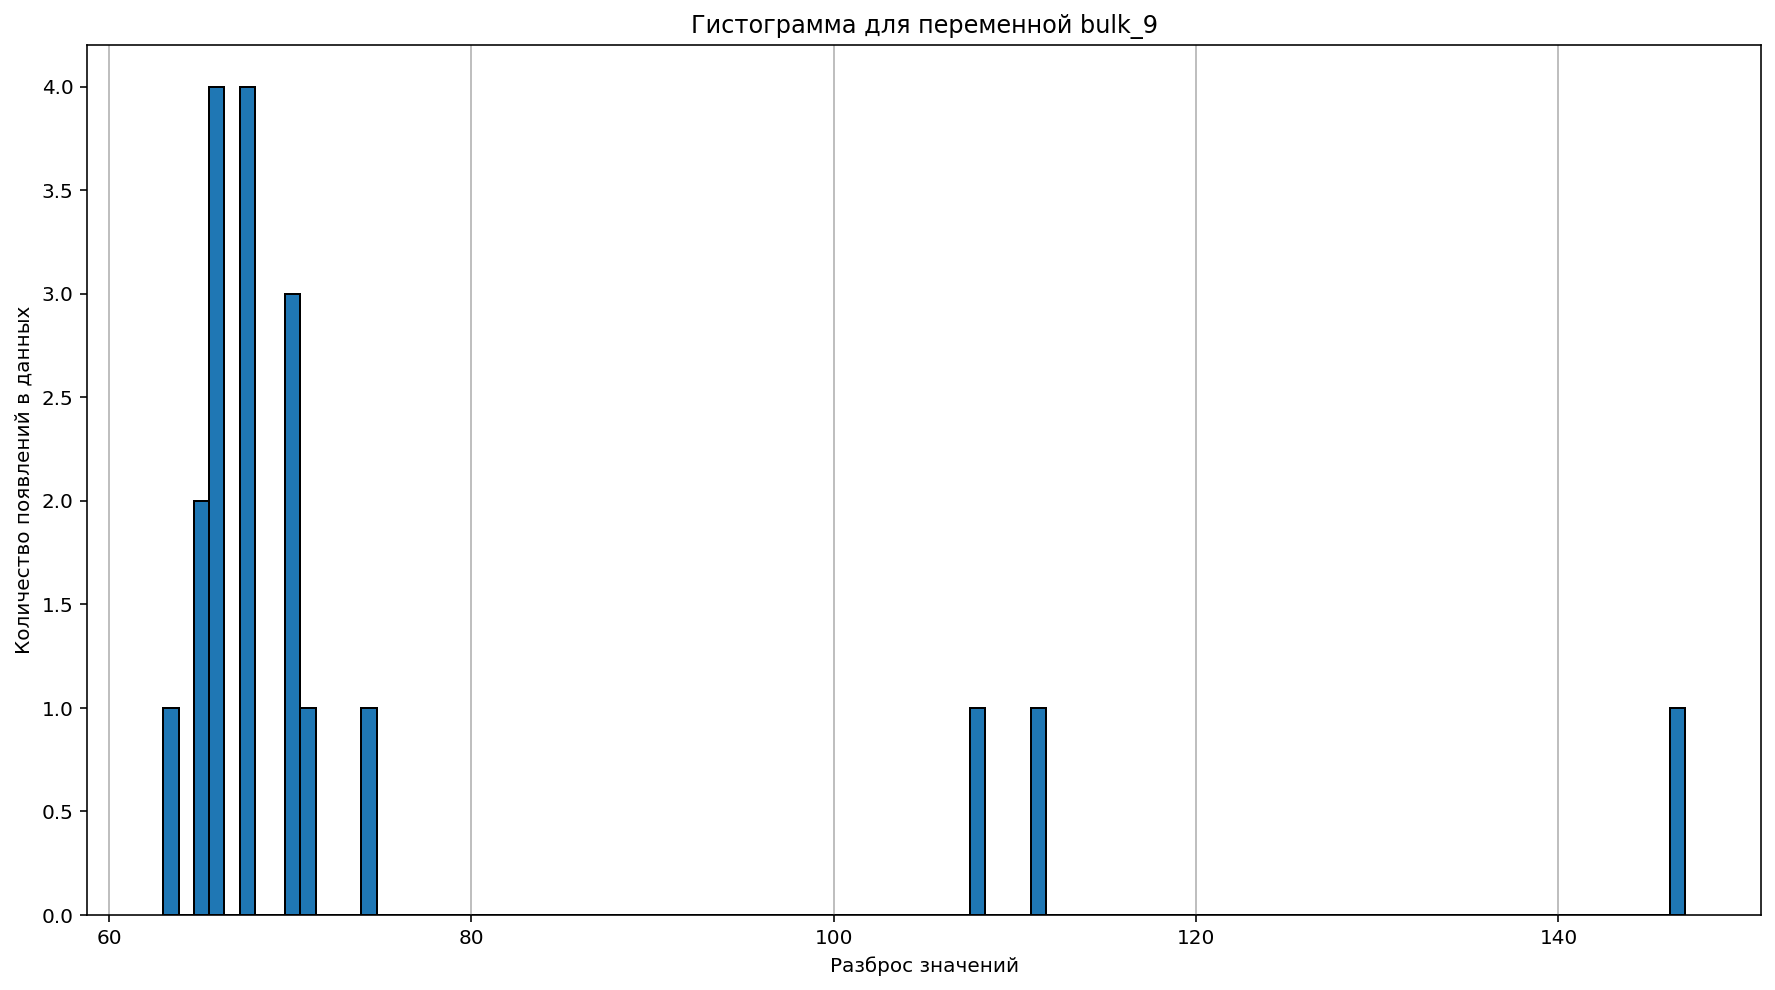

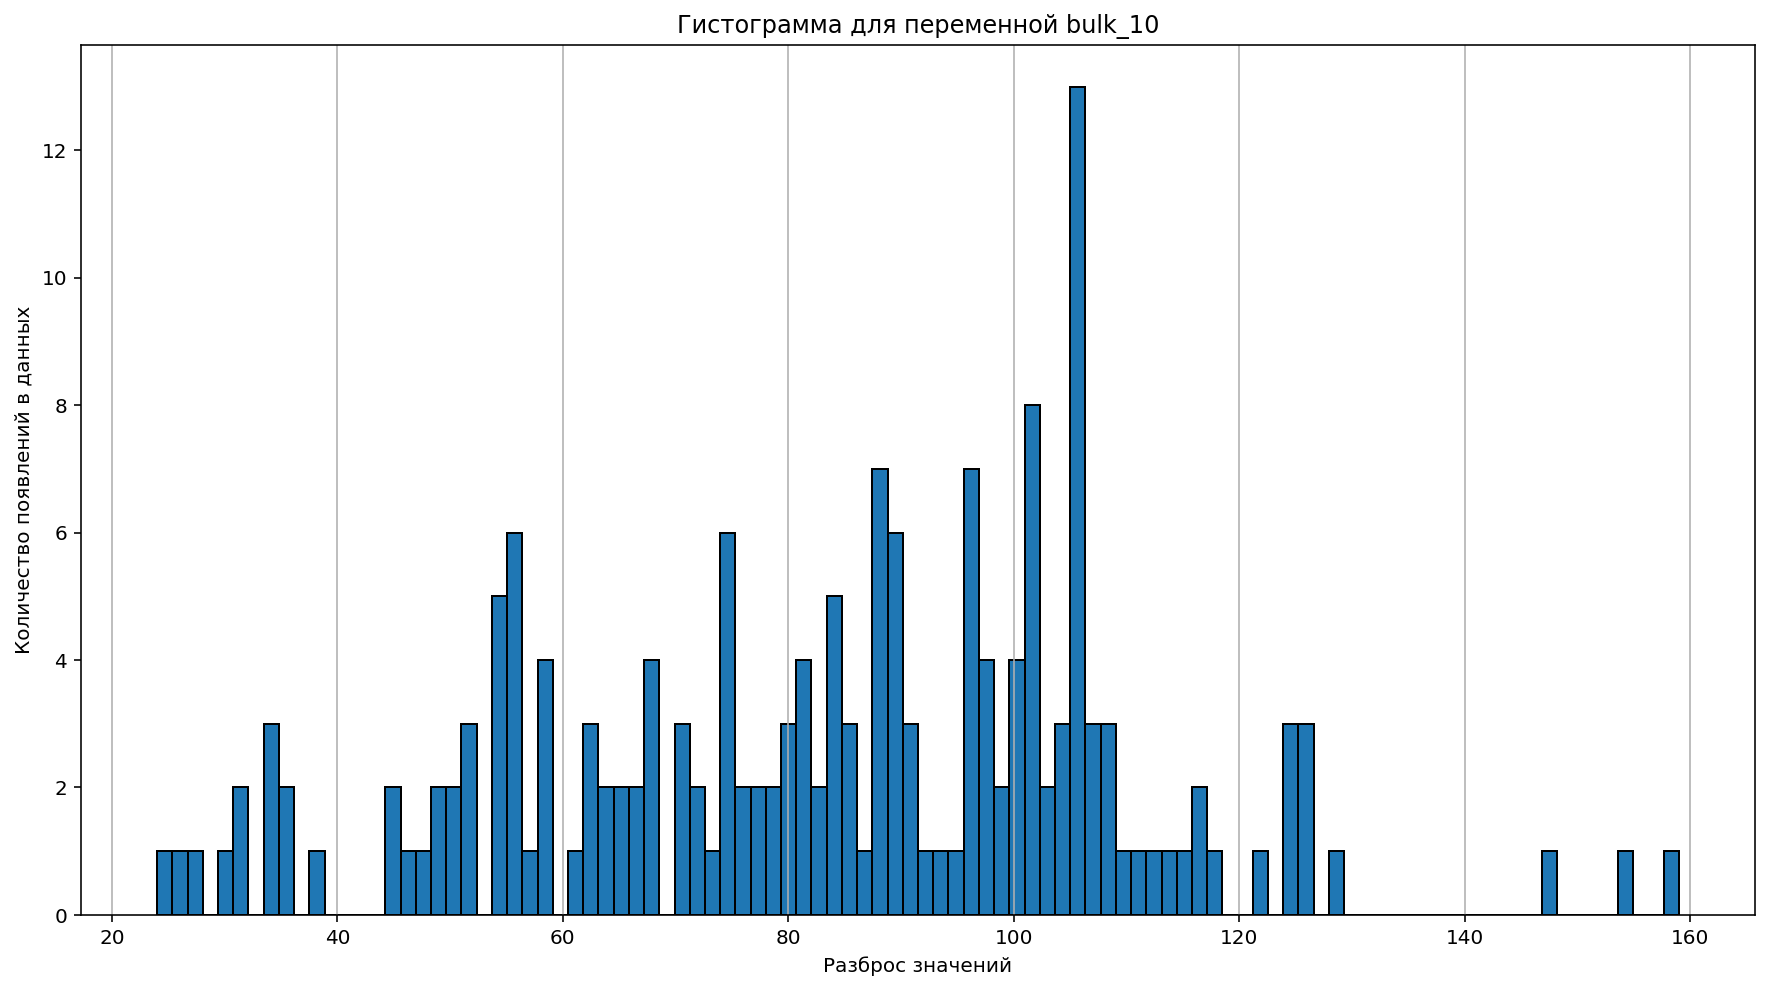

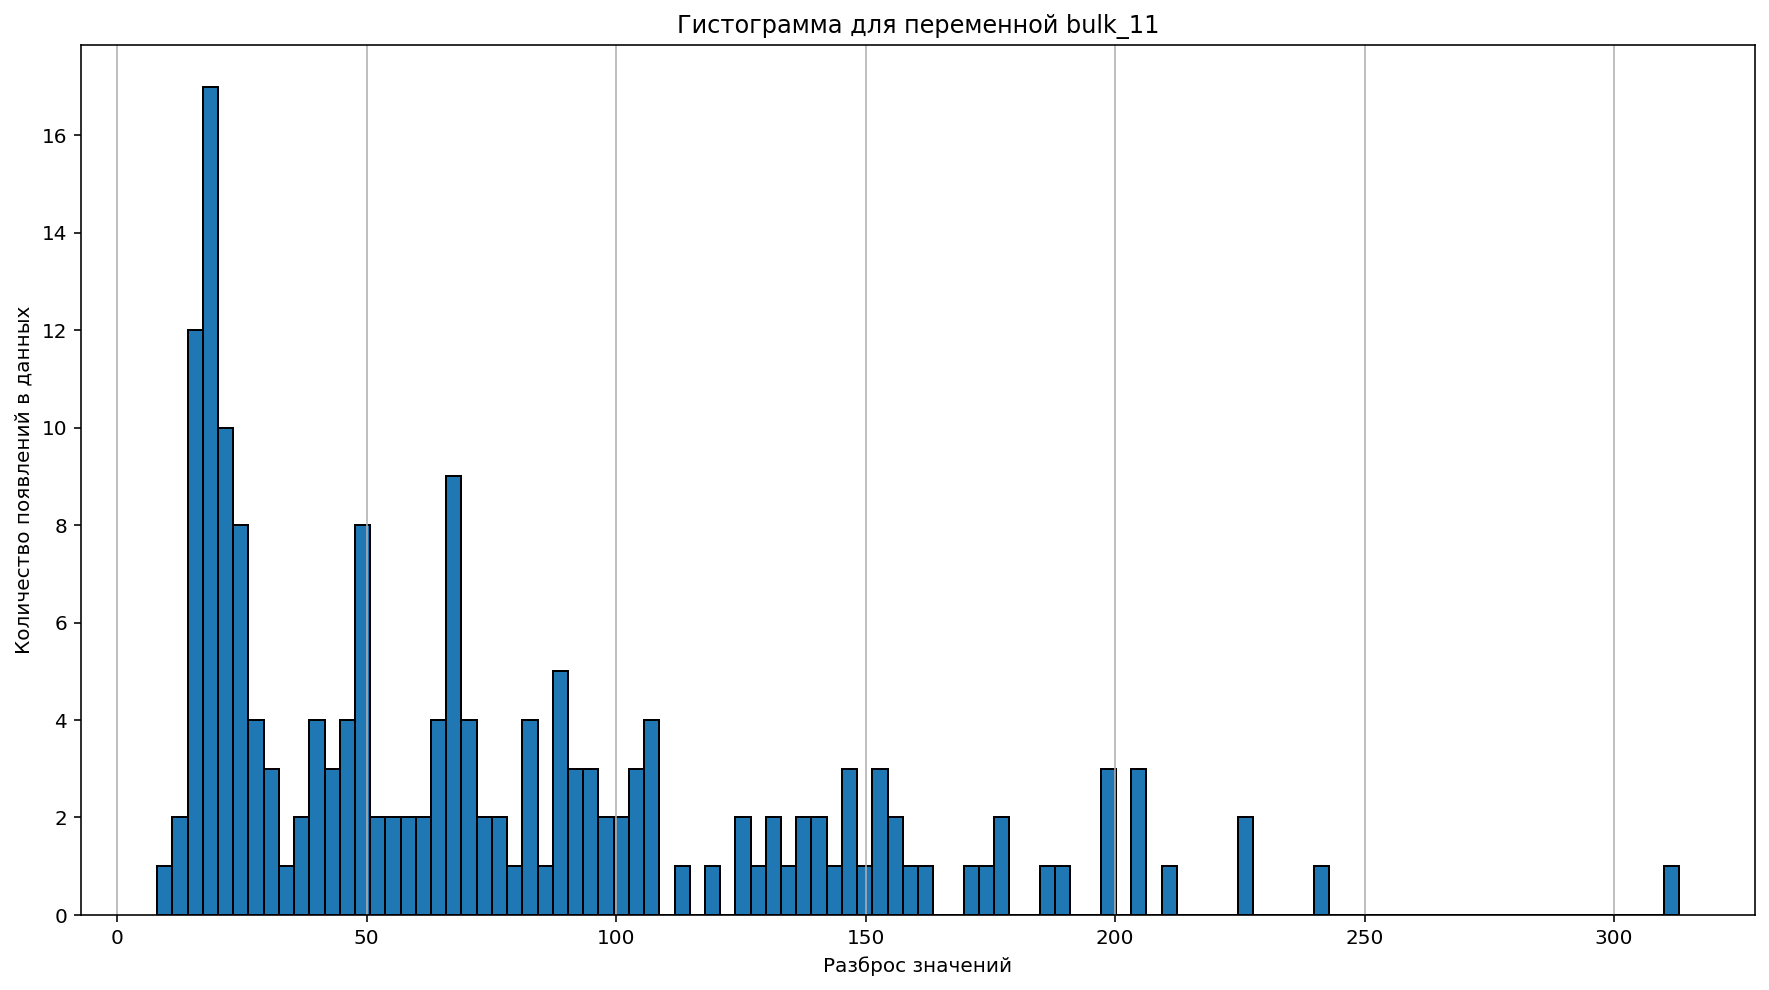

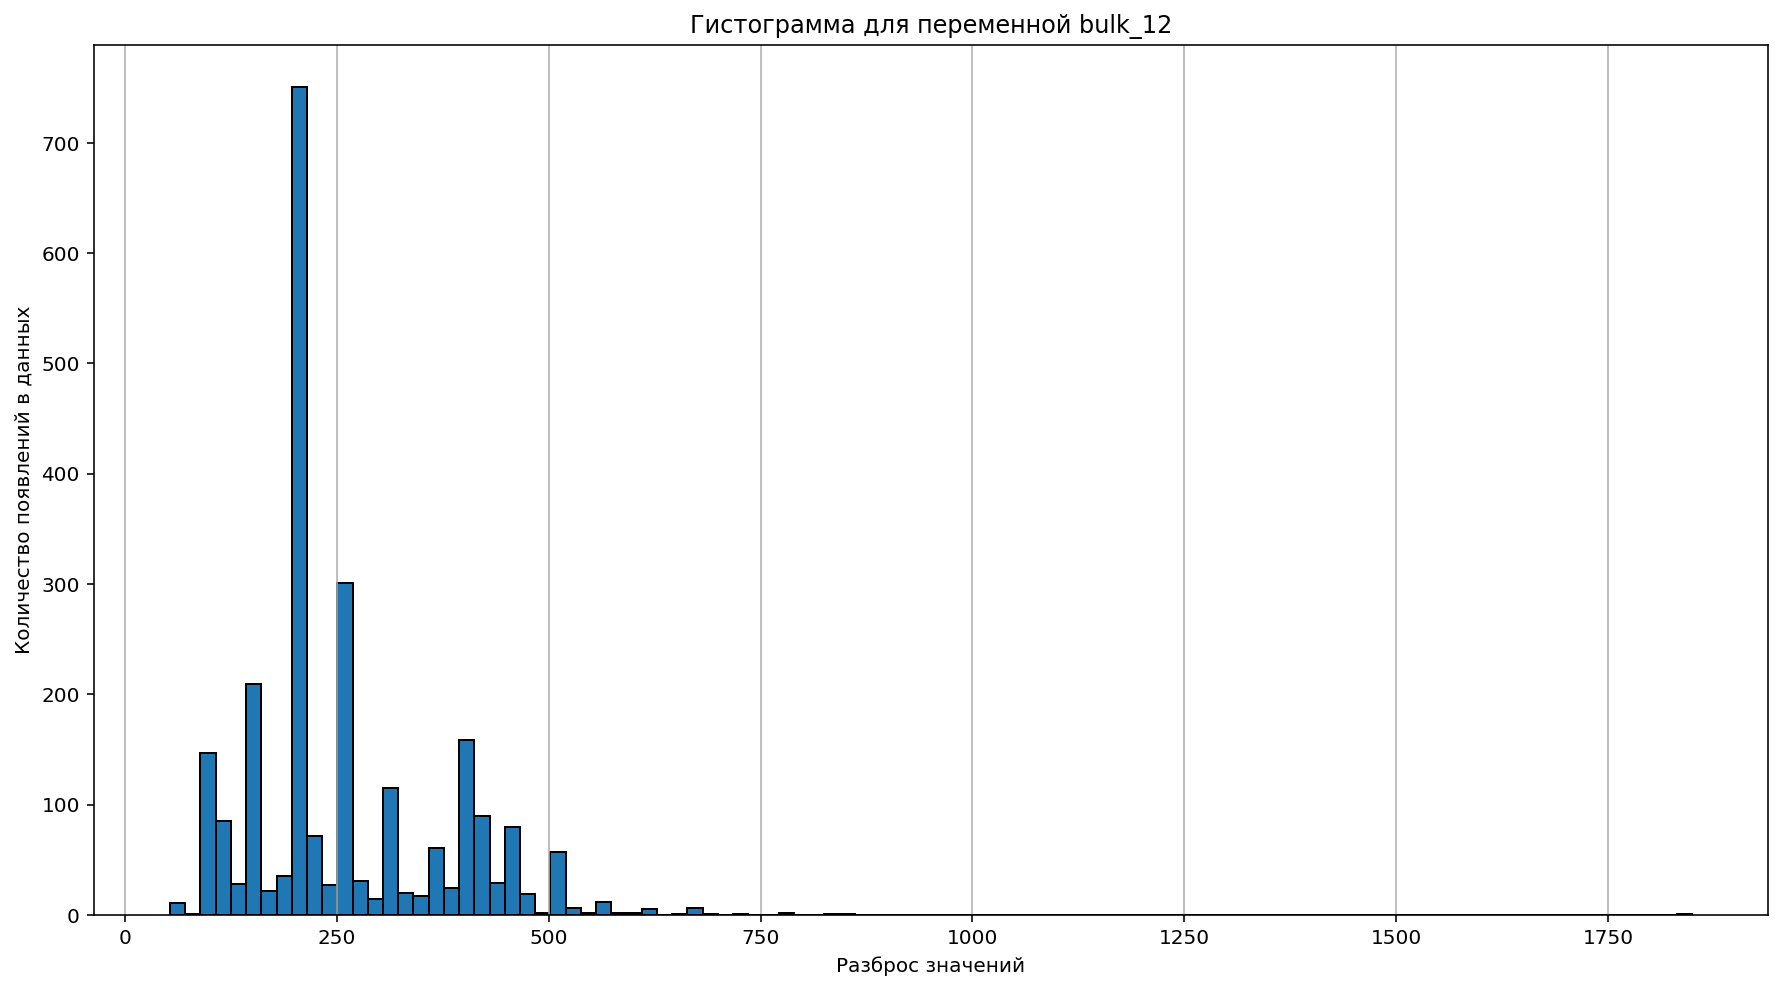

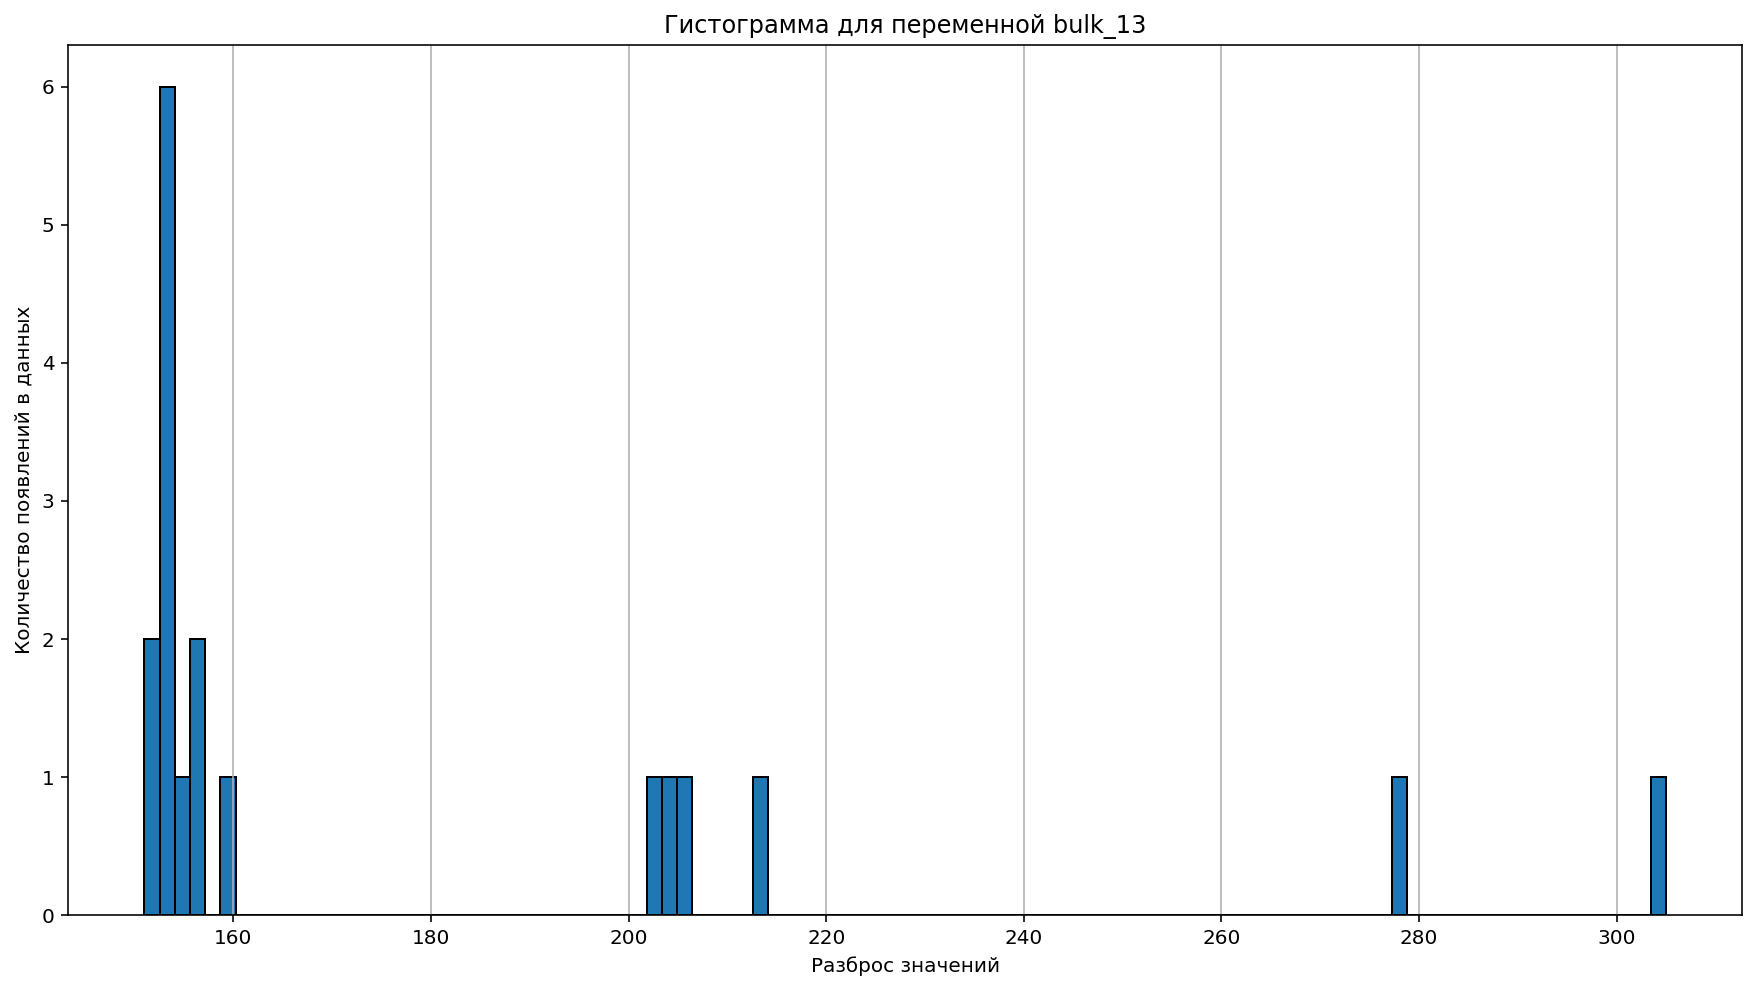

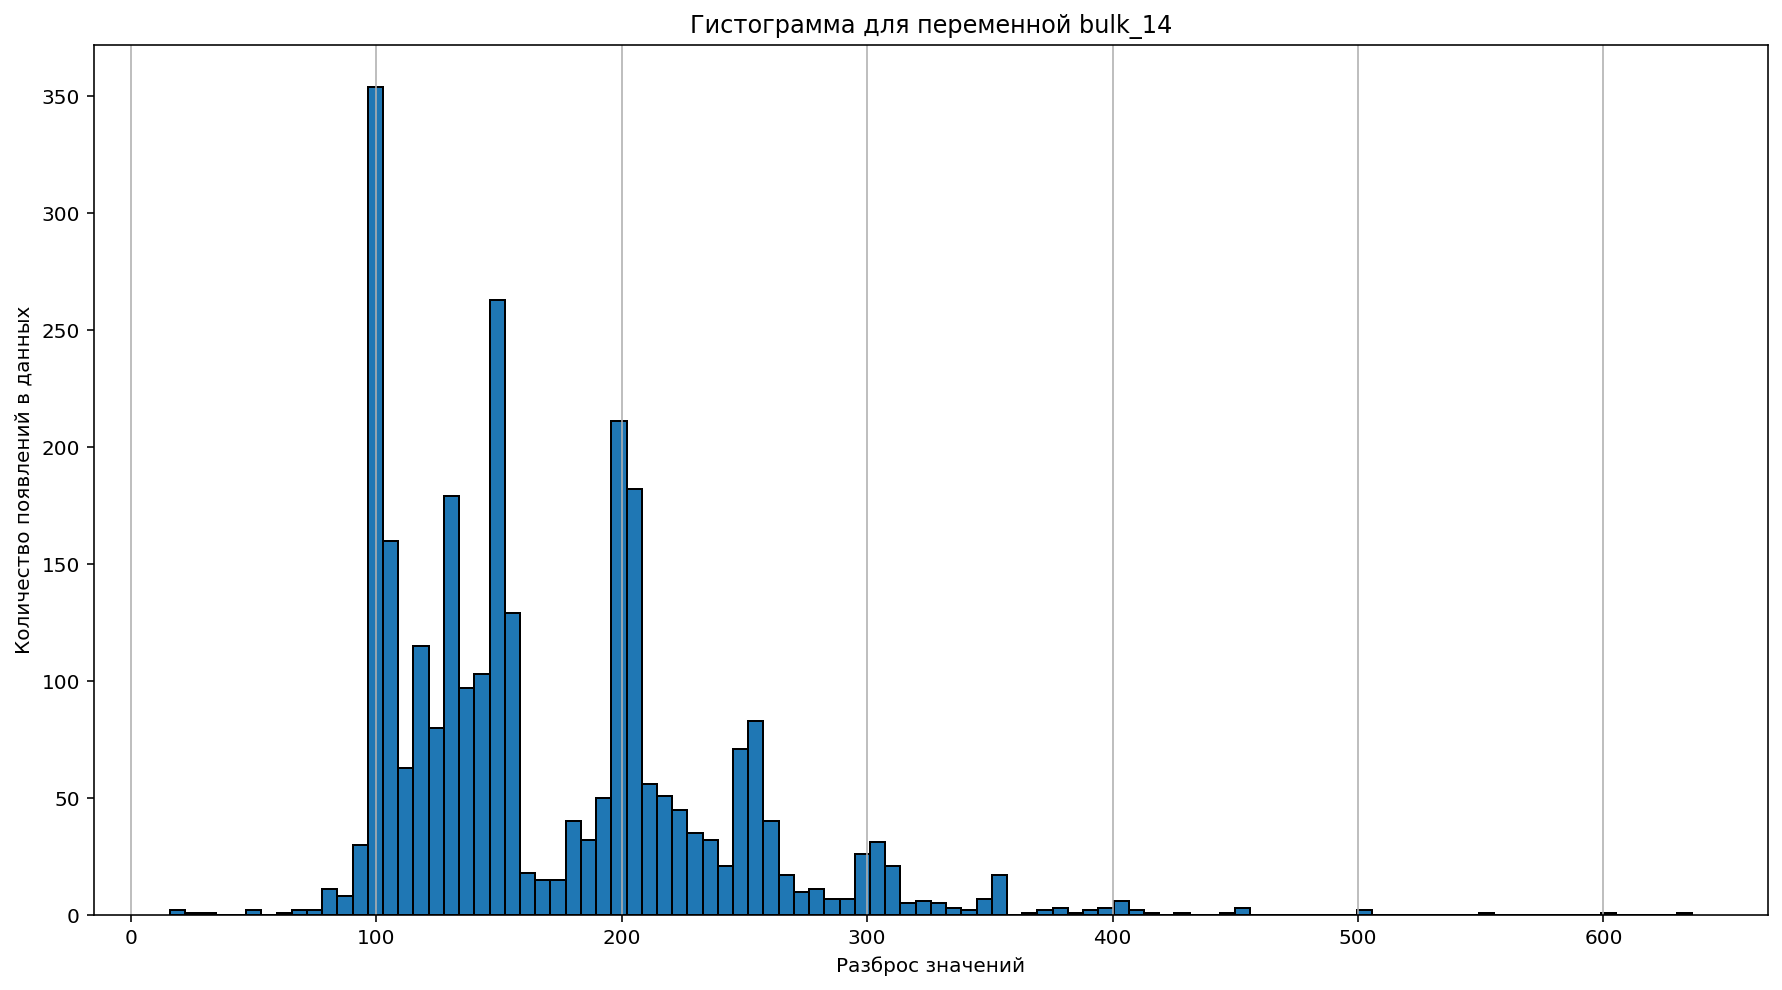

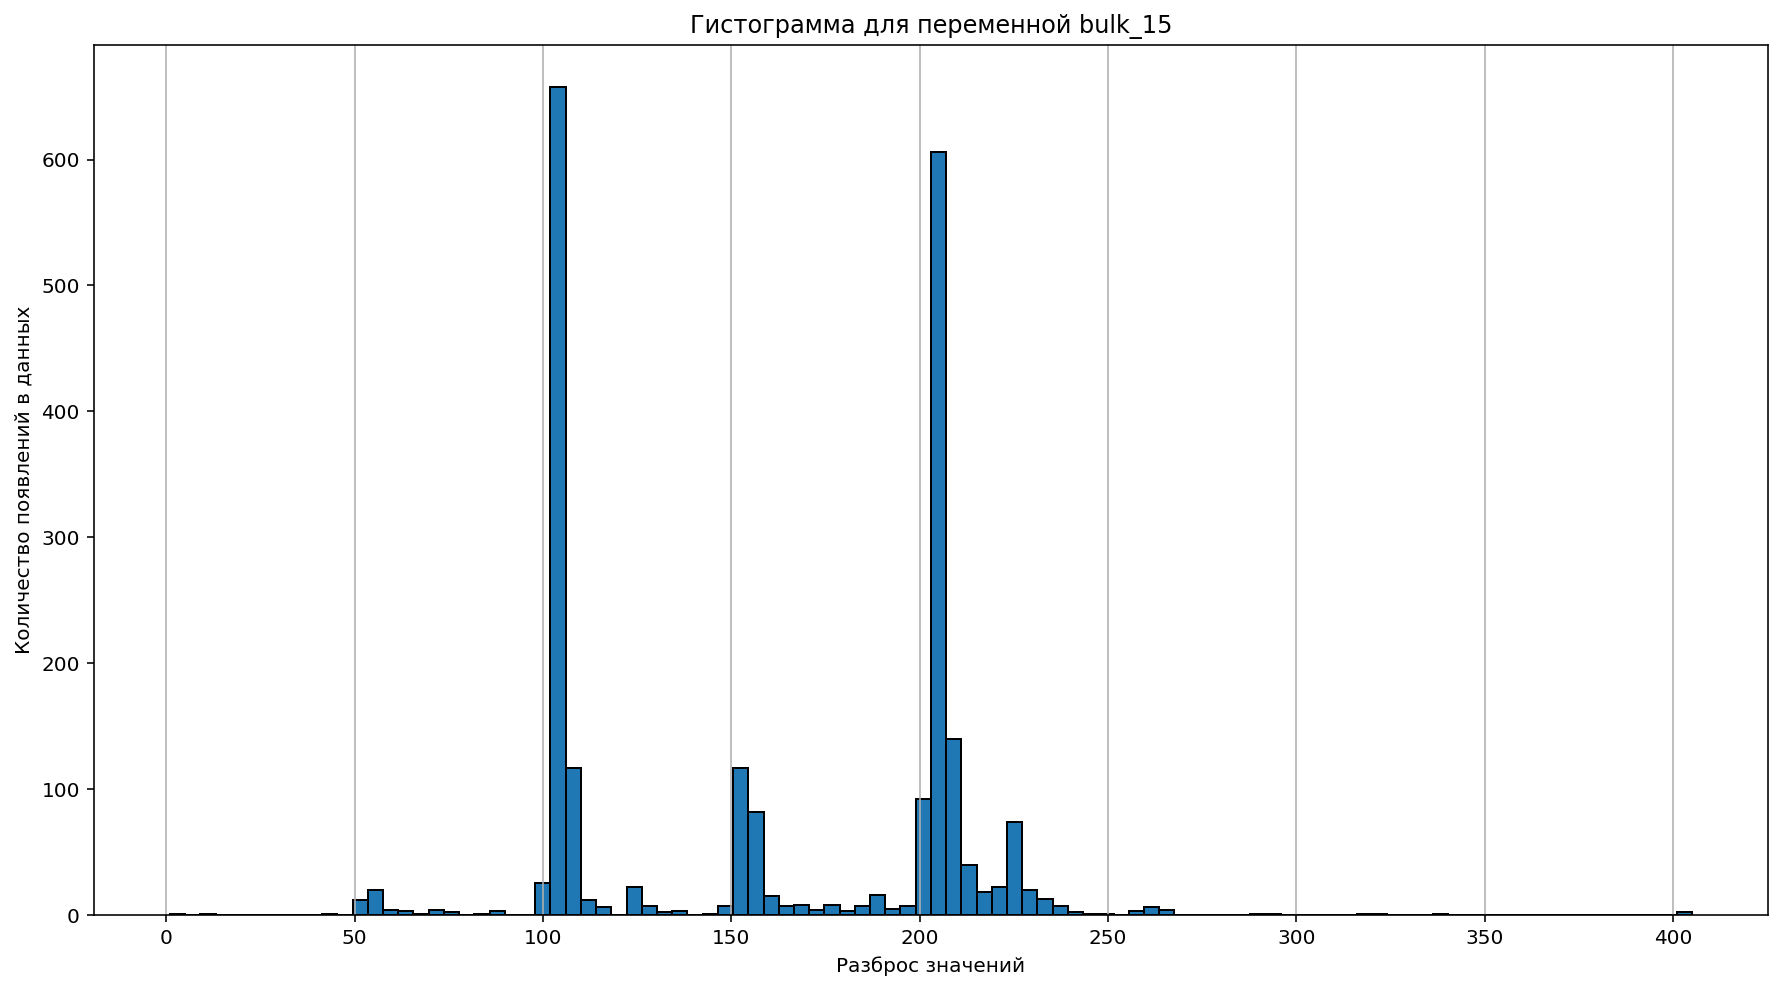

In [18]:
df_plot_hist(df_bulk)


Корреляция:


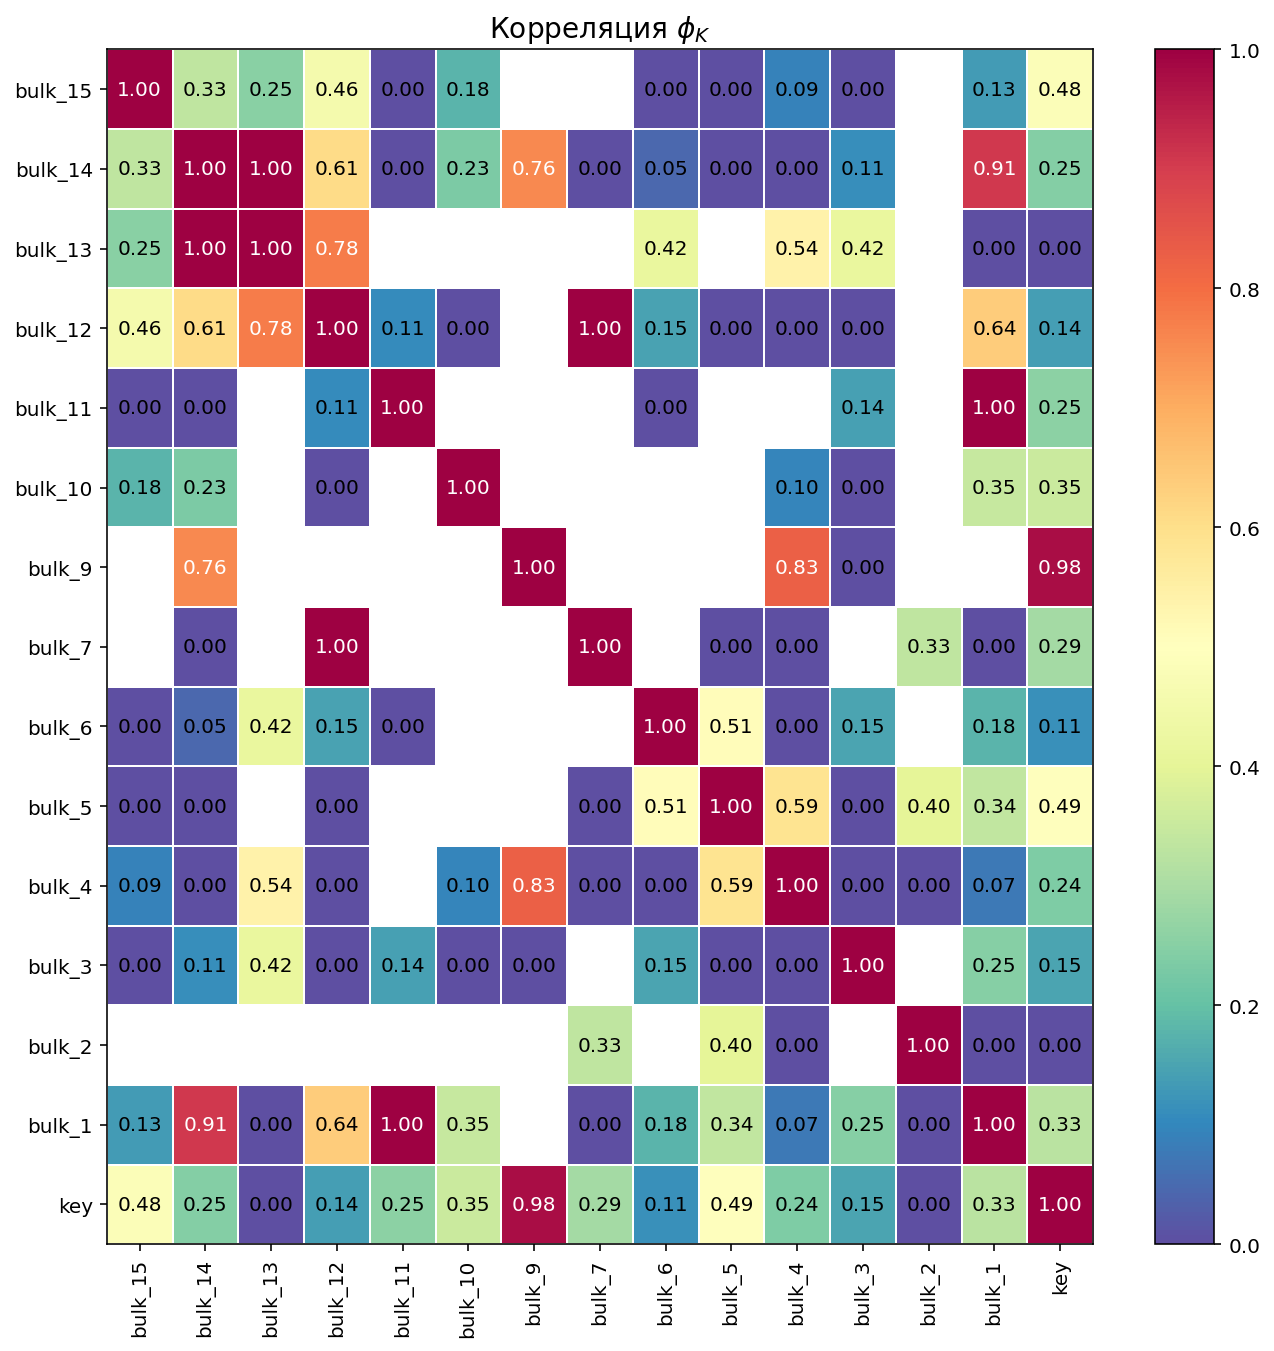

In [19]:
df_plot_corr(df_bulk)

In [20]:
df_bulk['key'].value_counts().head(10)

key
1       1
2174    1
2152    1
2153    1
2154    1
2155    1
2156    1
2157    1
2158    1
2159    1
Name: count, dtype: int64

**Вывод:**

- Данные распределены неравномерно, в большинстве столбцов много пропусков
- Столбцы bulk 12, 14, 15 содержат не более 30% пропусков + bulk 3, 4 в которых не больше 68 % пропусков. Остальные столбцы ввиду отсутсвия большей части значений использовать для модели не представляется возможным;
- Часть столбцов имеют крайне высокую корреляцию между собой, но в них данных слишком мало, чтобы судить о какой-либо связи.
- Все значения ключей уникальны.


# 1.3 Данные о подаче сыпучих материалов (время) - bulk_time


In [21]:
df_fast_info(df_bulk_time)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   int64         
 1   bulk_1_time   252 non-null    datetime64[ns]
 2   bulk_2_time   22 non-null     datetime64[ns]
 3   bulk_3_time   1298 non-null   datetime64[ns]
 4   bulk_4_time   1014 non-null   datetime64[ns]
 5   bulk_5_time   77 non-null     datetime64[ns]
 6   bulk_6_time   576 non-null    datetime64[ns]
 7   bulk_7_time   25 non-null     datetime64[ns]
 8   bulk_8_time   1 non-null      datetime64[ns]
 9   bulk_9_time   19 non-null     datetime64[ns]
 10  bulk_10_time  176 non-null    datetime64[ns]
 11  bulk_11_time  177 non-null    datetime64[ns]
 12  bulk_12_time  2450 non-null   datetime64[ns]
 13  bulk_13_time  18 non-null     datetime64[ns]
 14  bulk_14_time  2806 non-null   datetime64[ns]
 15  bulk_15_tim

,key,bulk_1_time,bulk_2_time,bulk_3_time,bulk_4_time,bulk_5_time,bulk_6_time,bulk_7_time,bulk_8_time,bulk_9_time,bulk_10_time,bulk_11_time,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40



Полные дубликаты:


0


Описательные статистики:


,count,mean,min,25%,50%,75%,max,std
key,3129.0,1624.383509,1.0,816.0,1622.0,2431.0,3241.0,933.337642
bulk_1_time,252,2019-06-27 08:32:26.031746048,2019-05-03 17:50:19,2019-05-28 02:36:05.750000128,2019-06-23 02:31:45.500000,2019-07-27 00:38:33.249999872,2019-08-30 23:01:32,NaN
bulk_2_time,22,2019-07-09 02:04:44.545454336,2019-05-07 08:36:19,2019-05-26 21:24:43.249999872,2019-07-23 15:06:49.500000,2019-08-08 10:55:53.750000128,2019-08-08 17:34:38,NaN
bulk_3_time,1298,2019-07-05 14:02:19.653312768,2019-05-03 20:13:36,2019-06-06 08:39:05.500000,2019-07-01 17:13:22,2019-08-06 14:11:27.750000128,2019-08-31 23:39:11,NaN
bulk_4_time,1014,2019-06-30 17:27:38.687376896,2019-05-03 11:21:30,2019-05-29 08:23:05.750000128,2019-06-25 18:44:37.500000,2019-07-30 21:37:44,2019-08-30 17:36:30,NaN
bulk_5_time,77,2019-07-10 12:23:28.623376640,2019-05-07 08:36:19,2019-06-17 19:42:11,2019-07-21 23:25:54,2019-08-08 11:51:23,2019-08-28 09:01:08,NaN
bulk_6_time,576,2019-07-03 15:57:30.003472384,2019-05-03 18:52:57,2019-06-05 04:40:07,2019-07-06 03:56:28.500000,2019-08-03 09:02:40.750000128,2019-09-01 03:12:40,NaN
bulk_7_time,25,2019-07-23 21:38:41.040000,2019-05-07 11:37:42,2019-07-17 11:25:12,2019-07-23 15:37:44,2019-08-08 12:03:38,2019-08-31 07:22:25,NaN
bulk_8_time,1,2019-07-05 17:46:11,2019-07-05 17:46:11,2019-07-05 17:46:11,2019-07-05 17:46:11,2019-07-05 17:46:11,2019-07-05 17:46:11,NaN
bulk_9_time,19,2019-06-21 00:53:43.157894912,2019-05-14 00:04:56,2019-05-14 02:37:23.500000,2019-05-14 05:15:06,2019-08-11 11:43:13,2019-08-11 15:09:33,NaN


,Кол-во уникальных значений,Доля пропусков
bulk_8_time,1,0.999680
bulk_13_time,18,0.994247
bulk_9_time,19,0.993928
bulk_2_time,22,0.992969
bulk_7_time,25,0.992010
bulk_5_time,77,0.975391
bulk_10_time,176,0.943752
bulk_11_time,177,0.943432
bulk_1_time,252,0.919463
bulk_6_time,576,0.815916



Гистограммы:


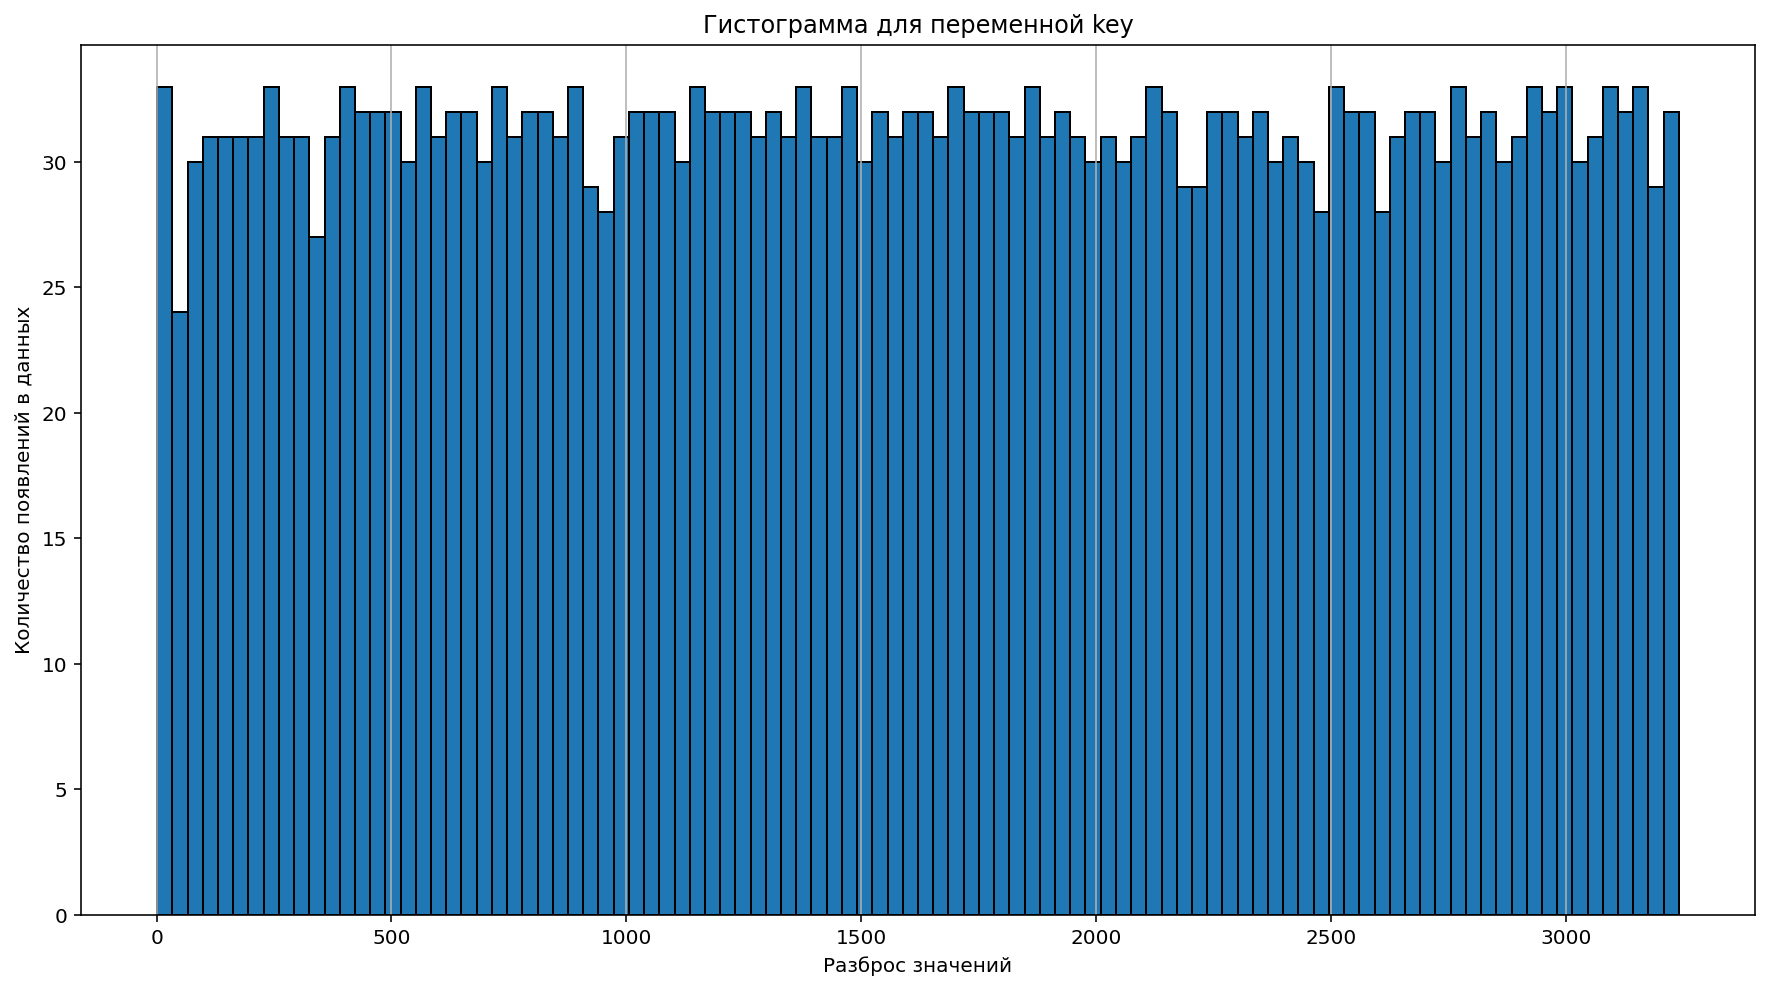

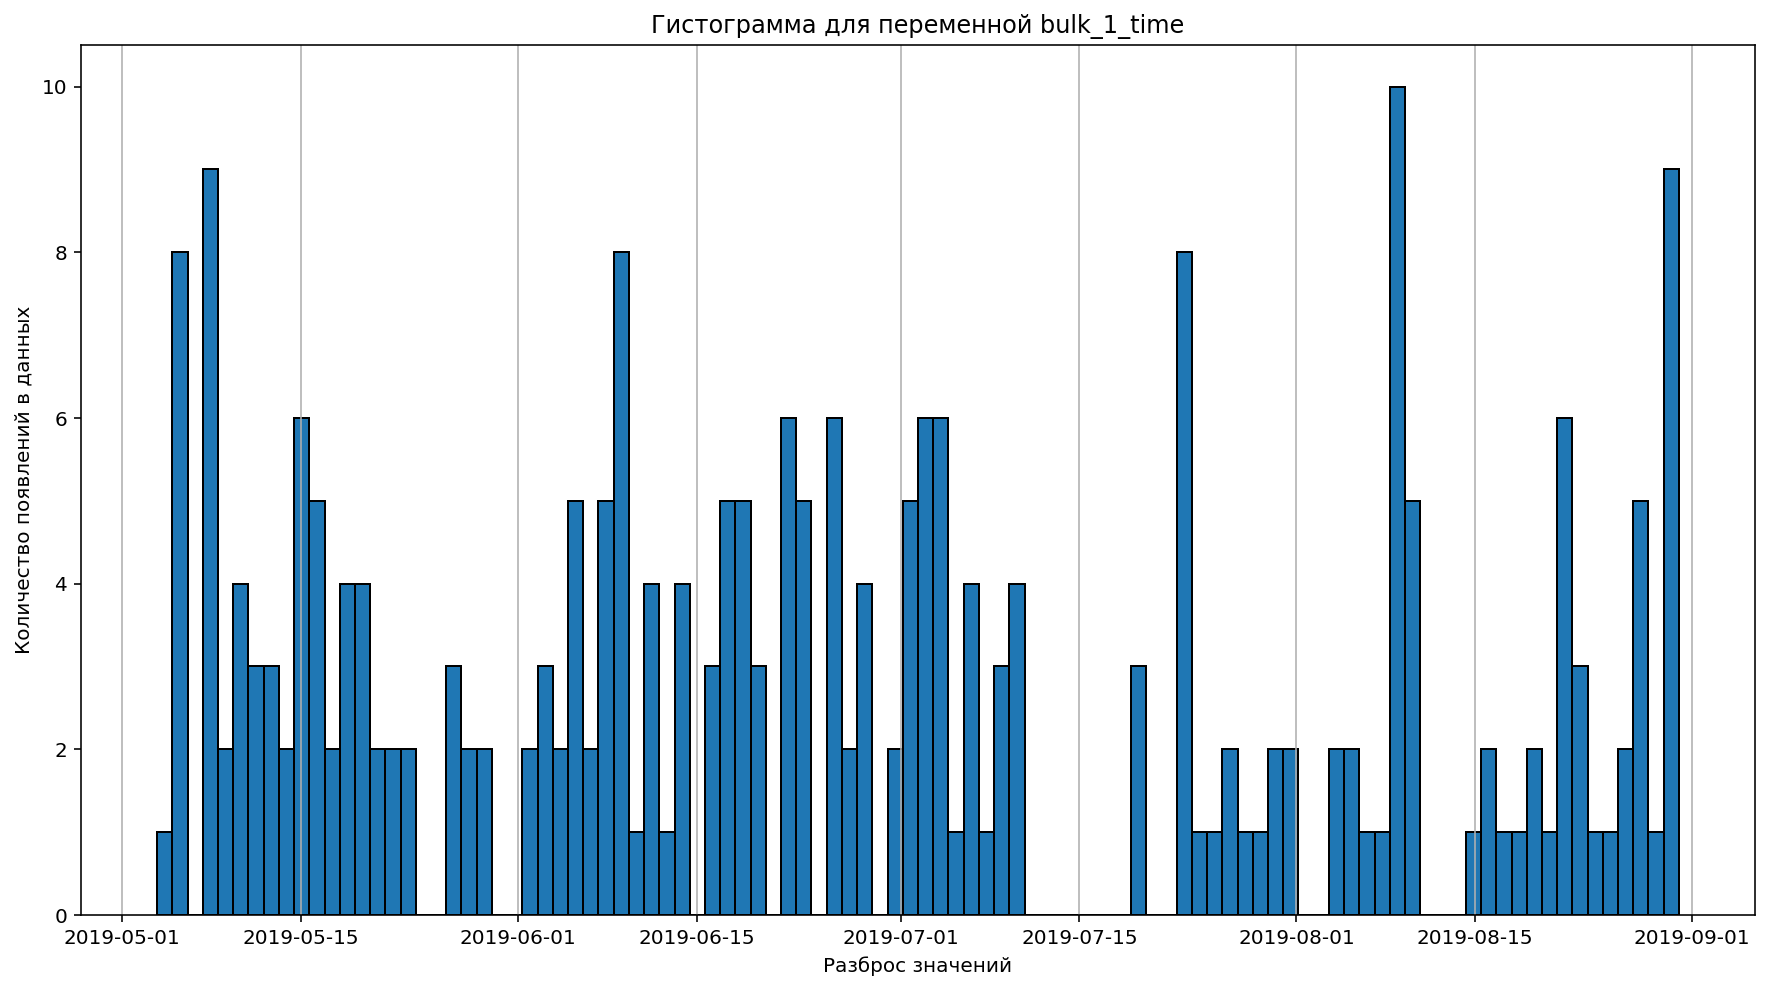

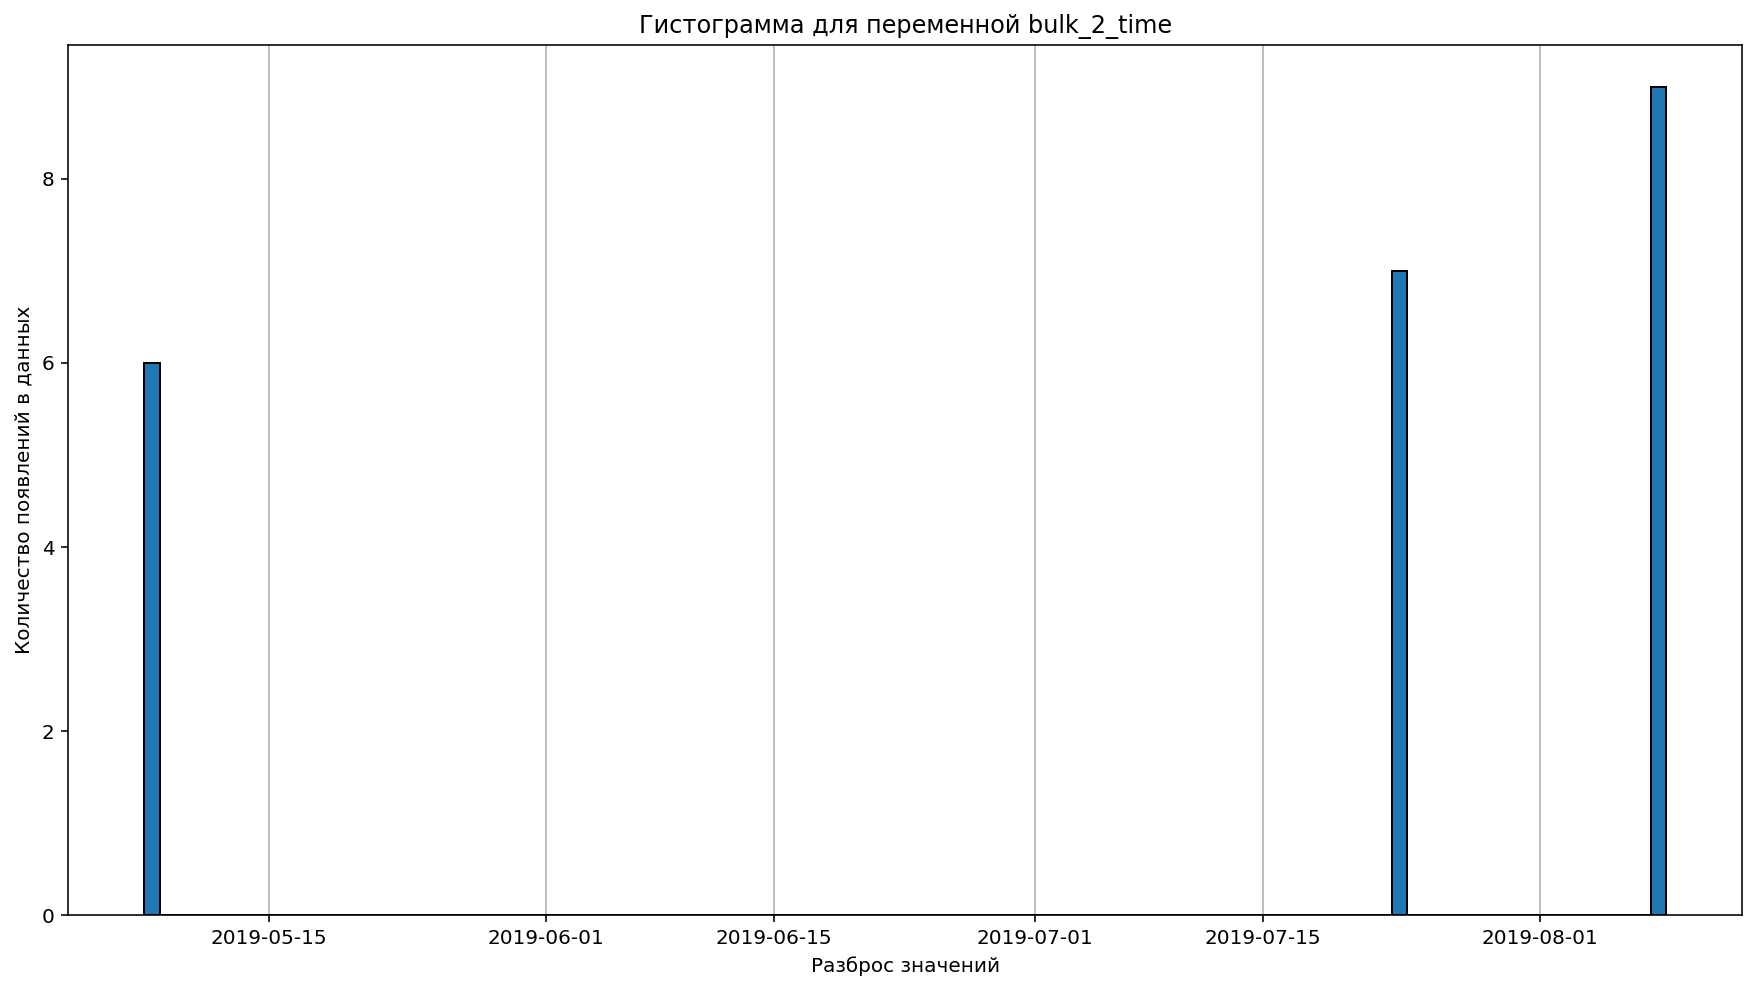

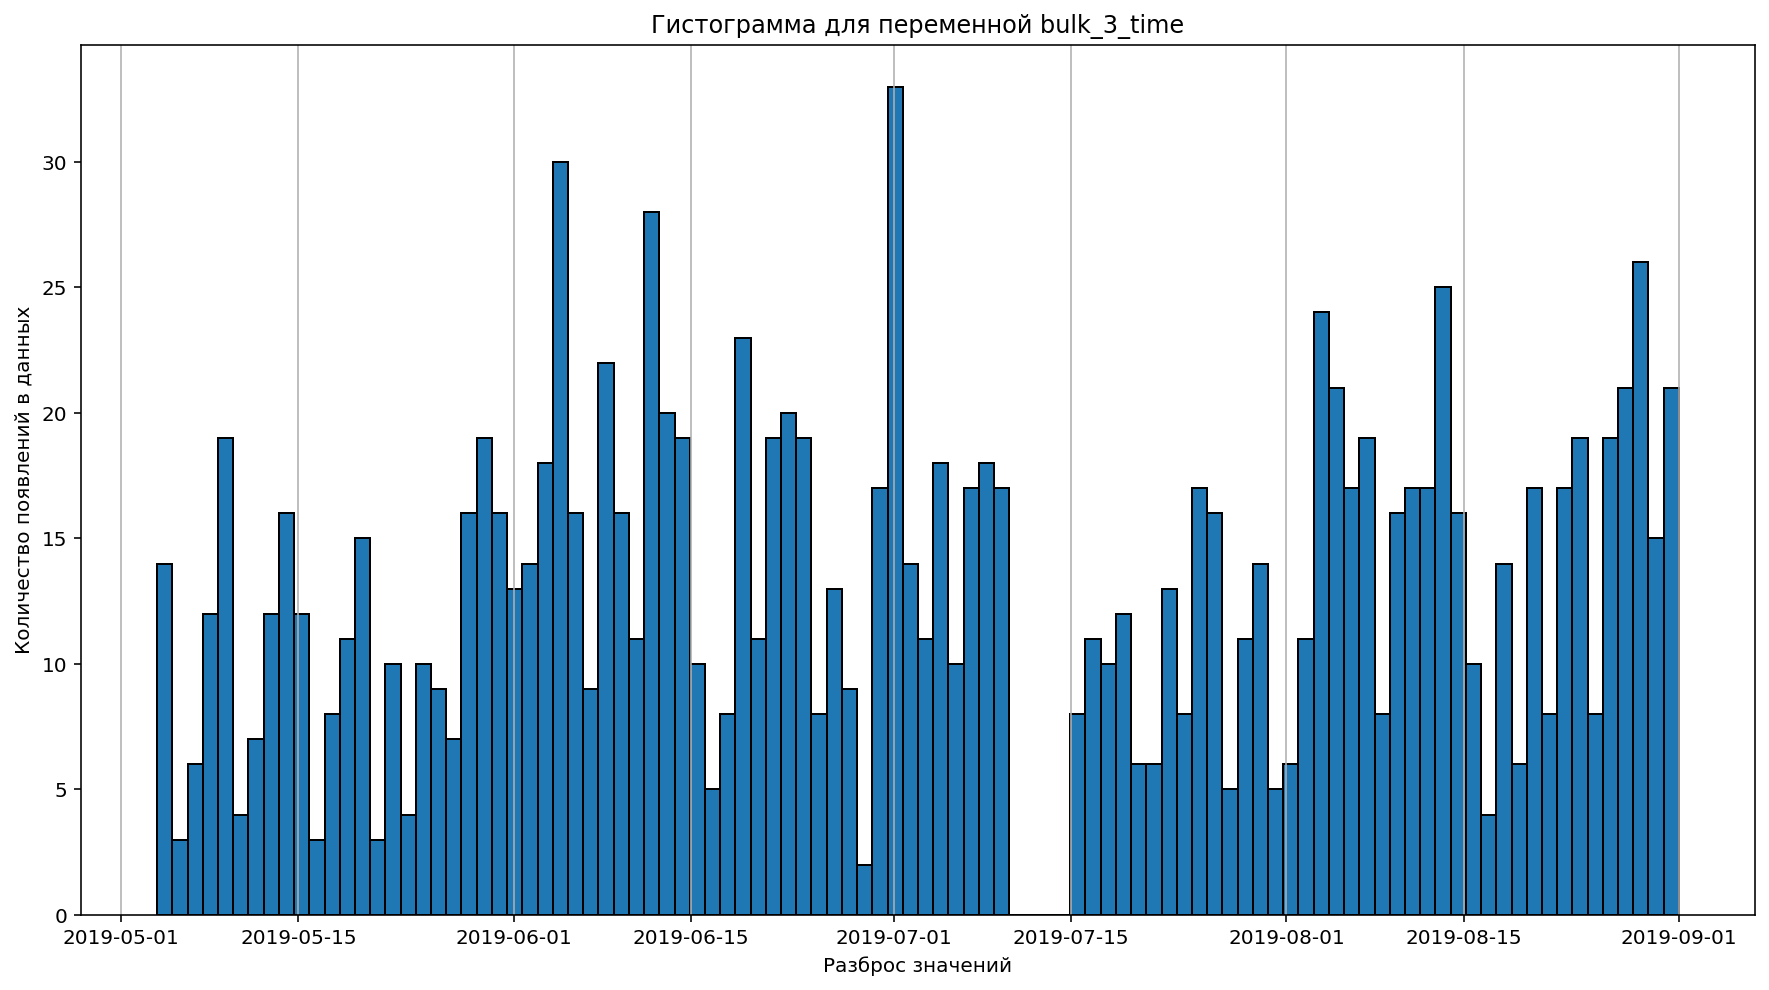

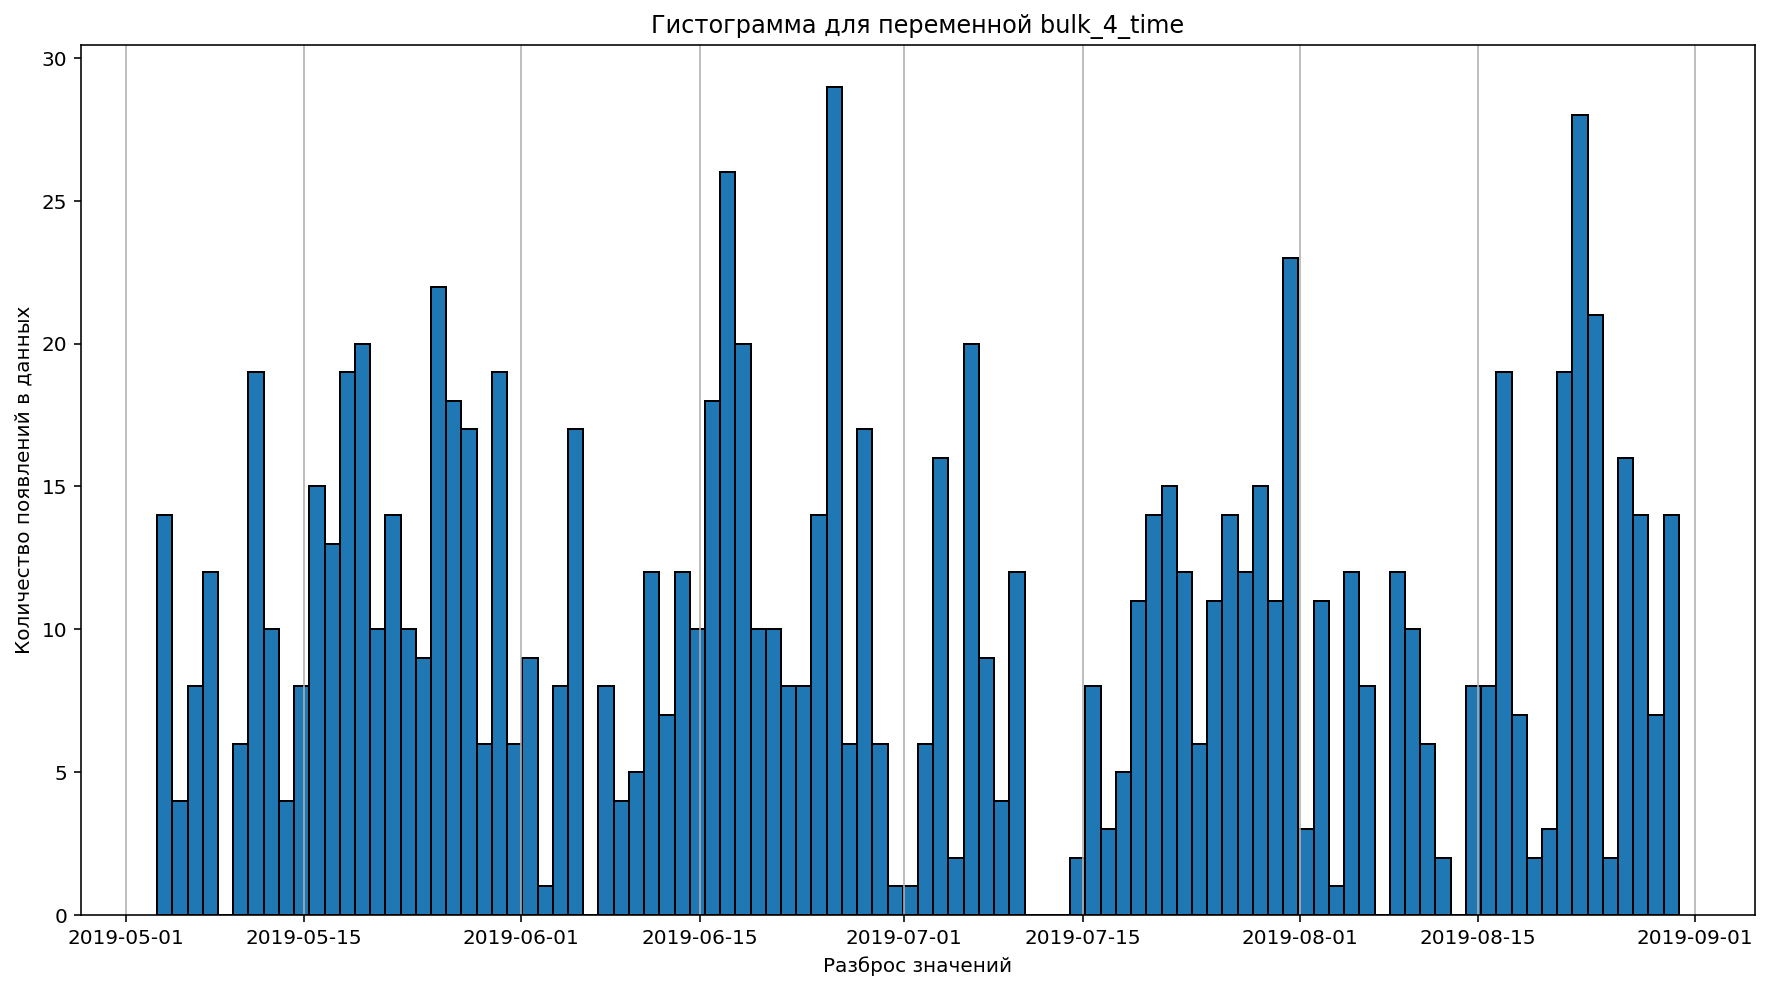

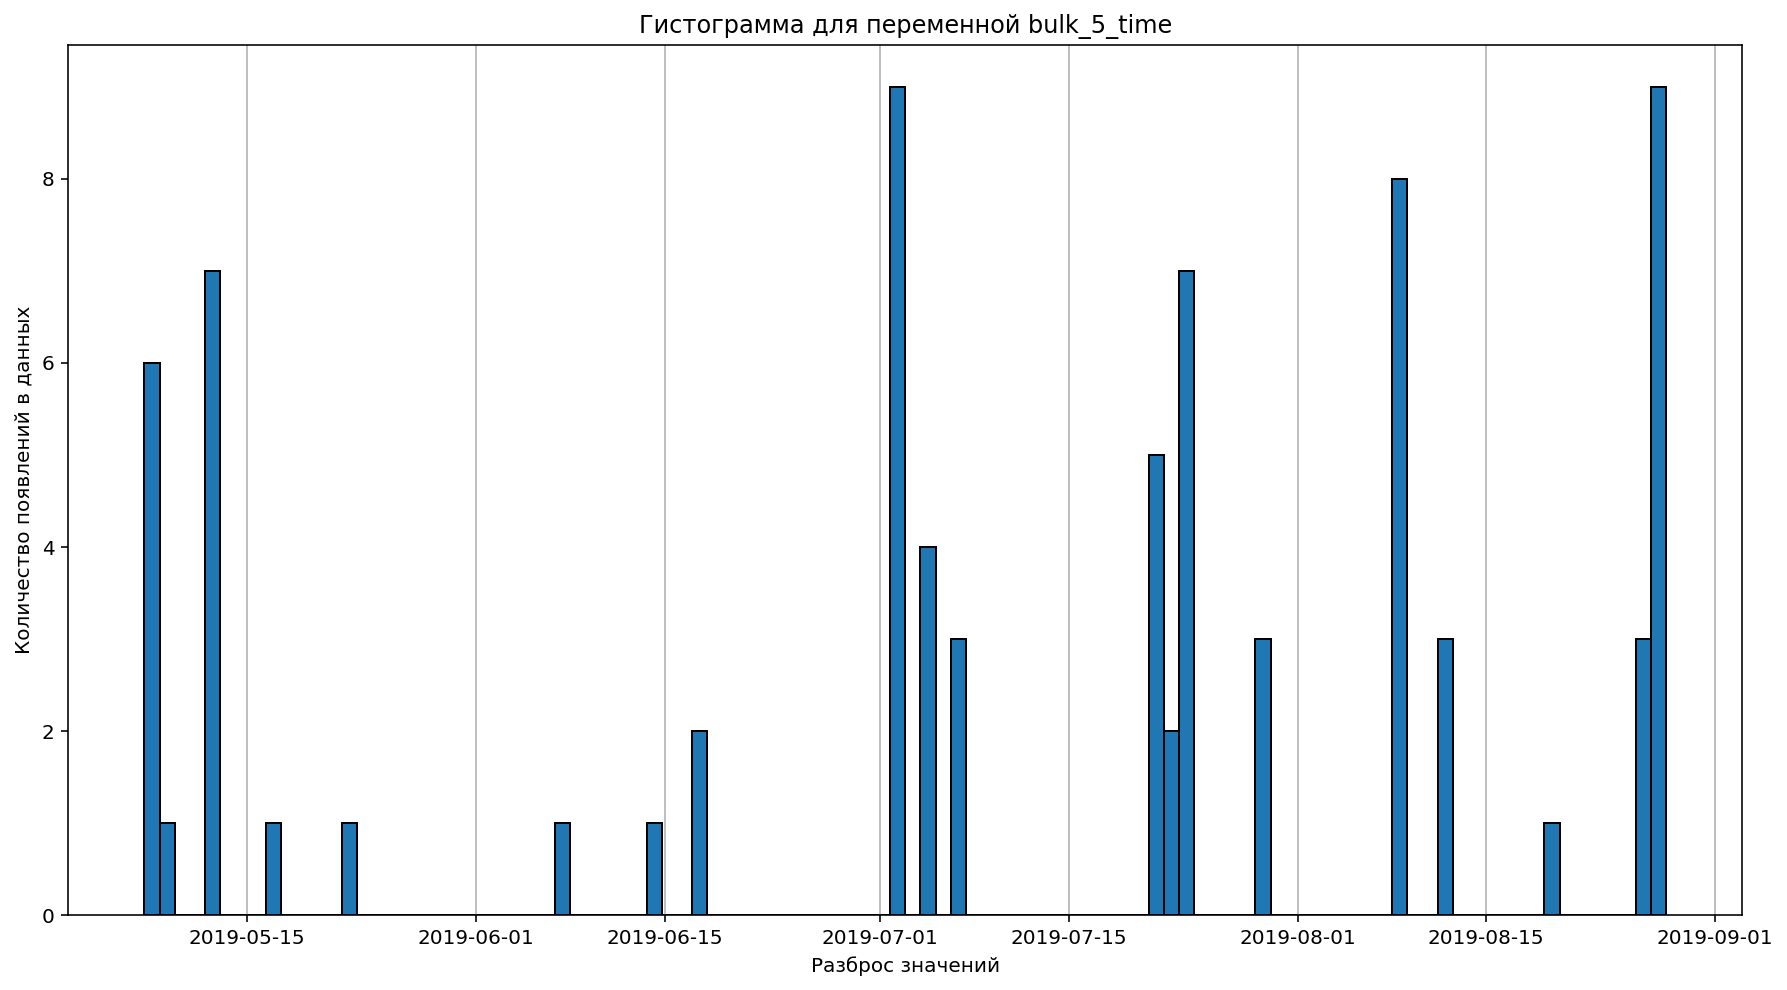

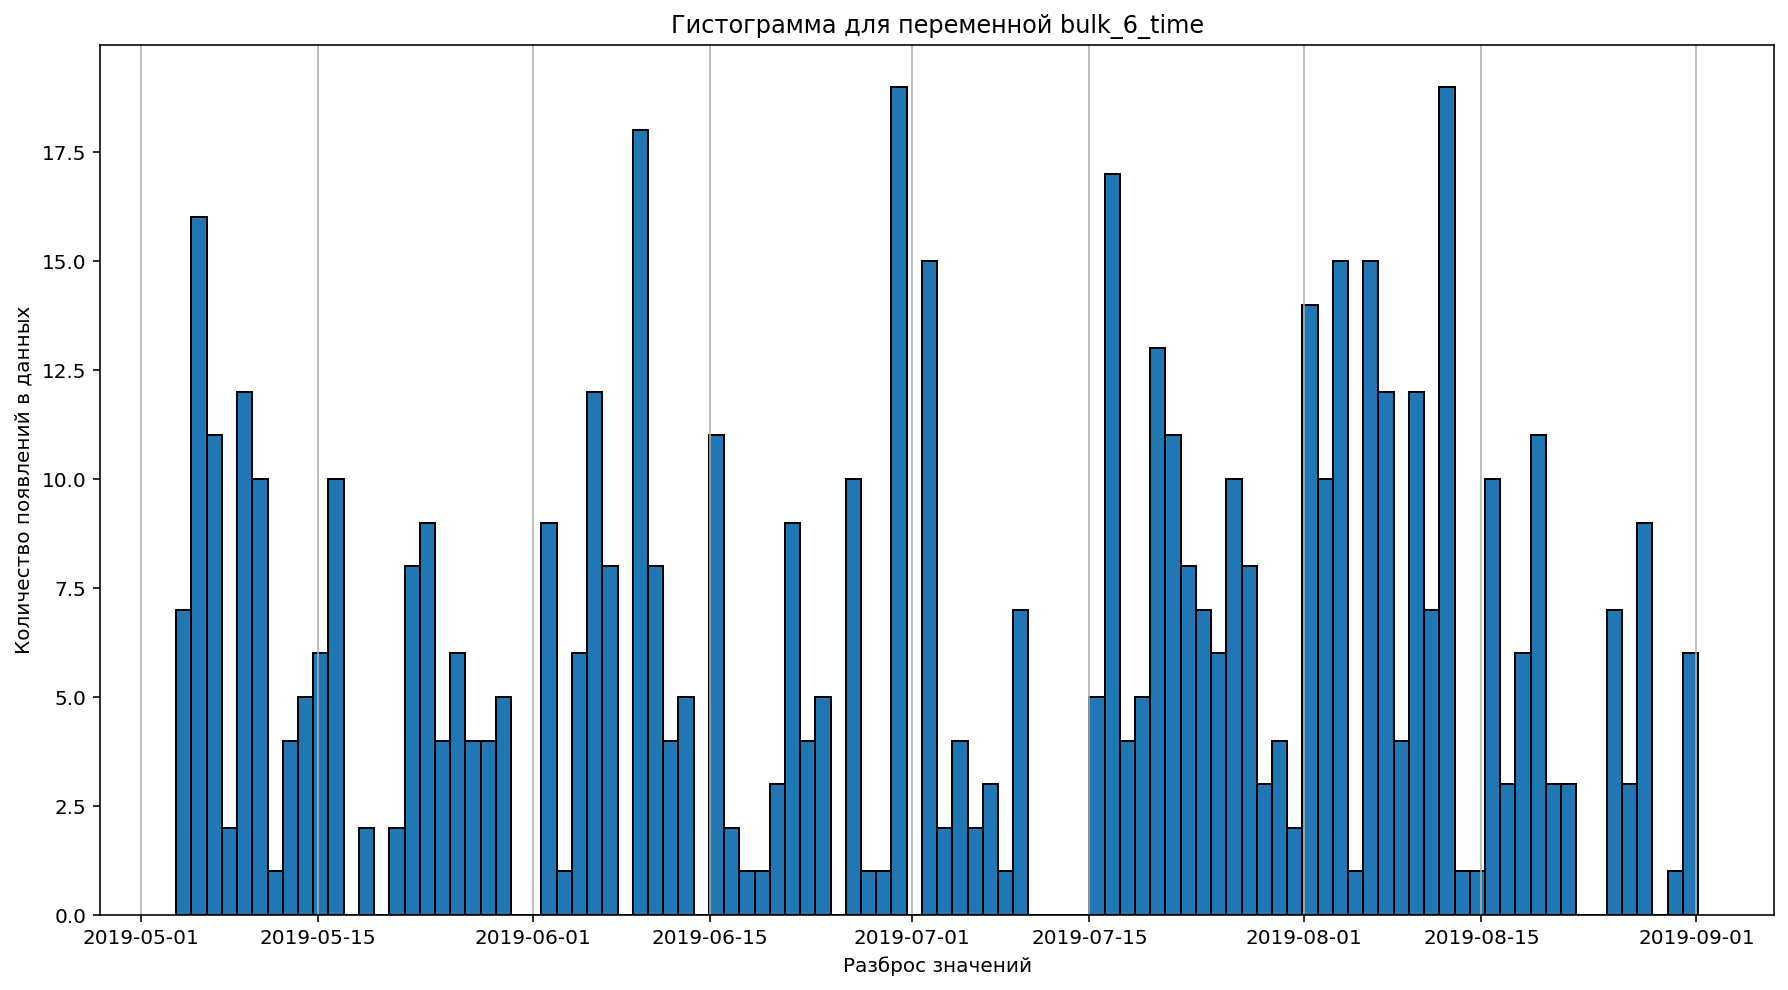

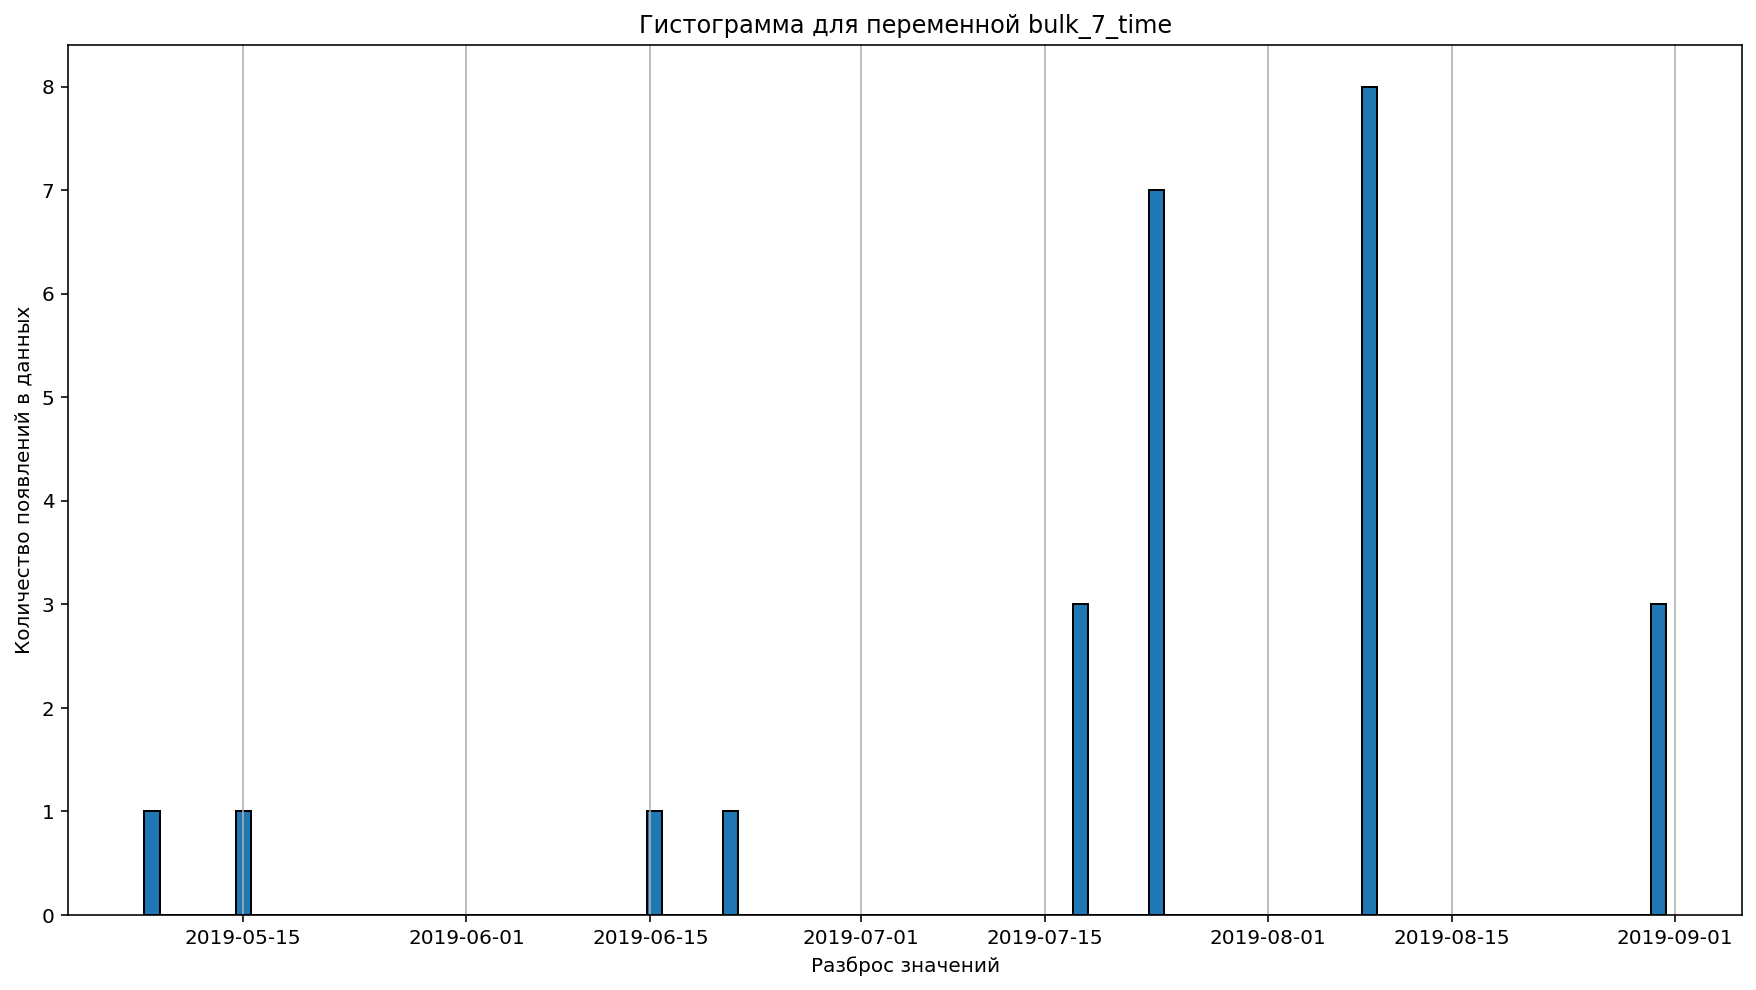

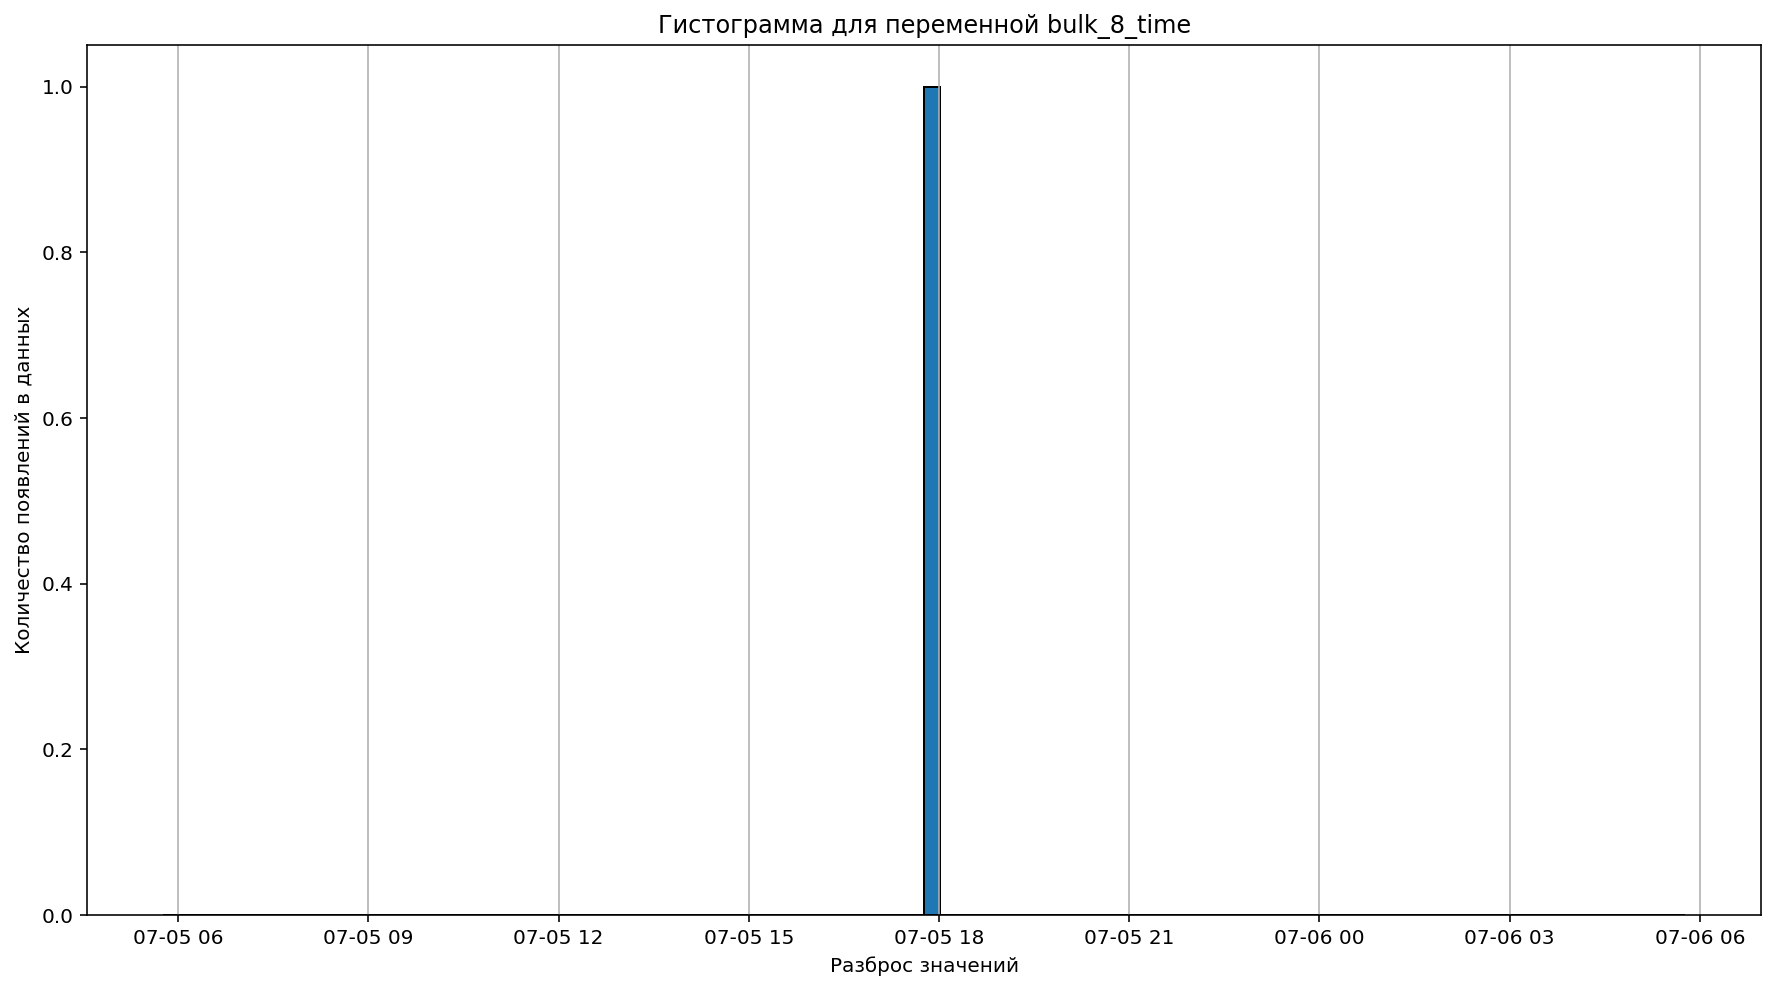

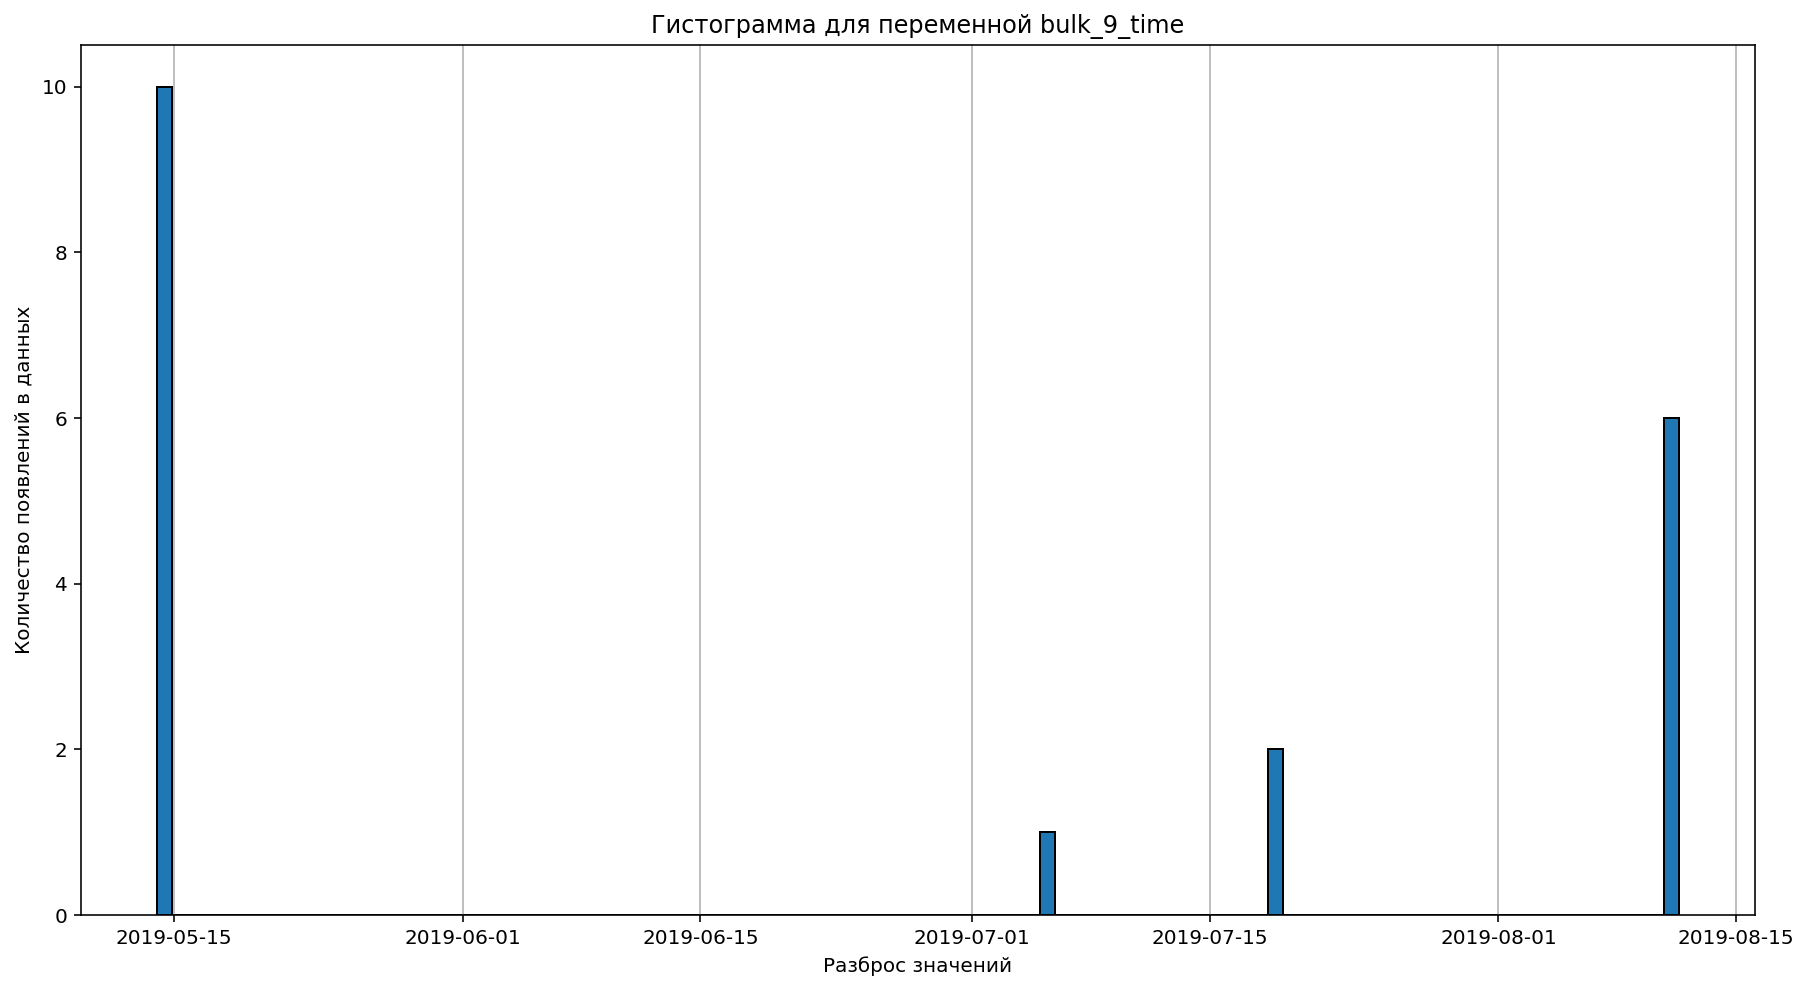

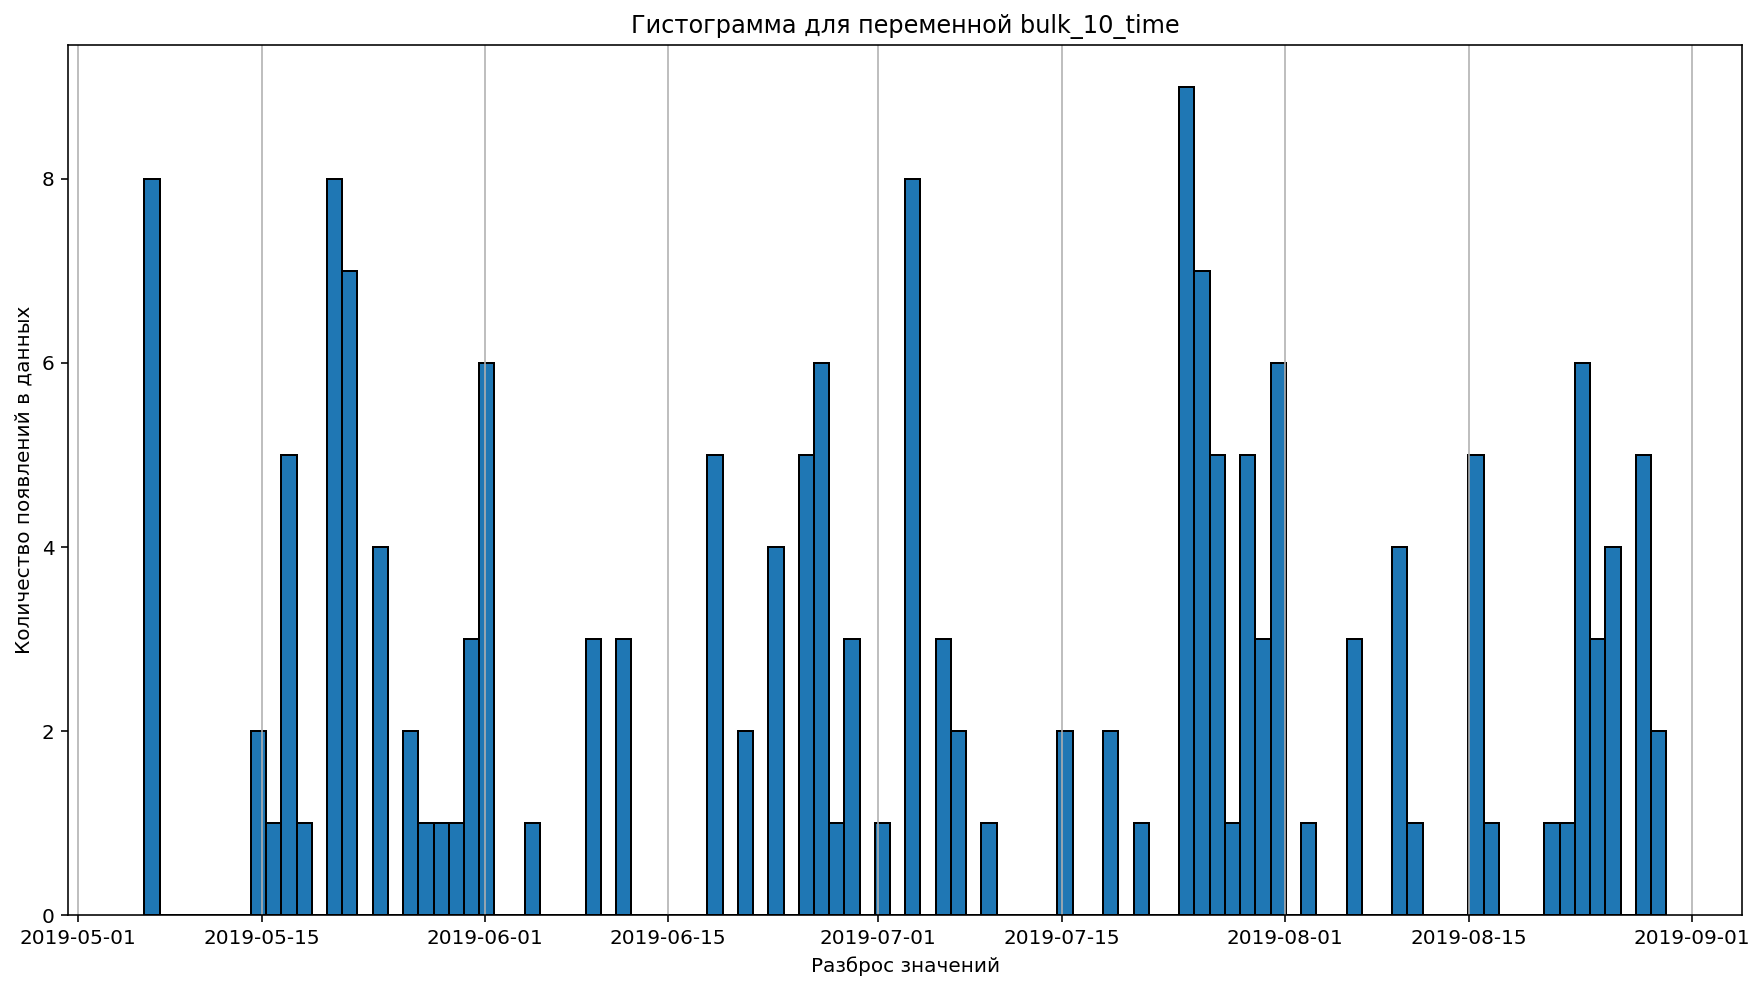

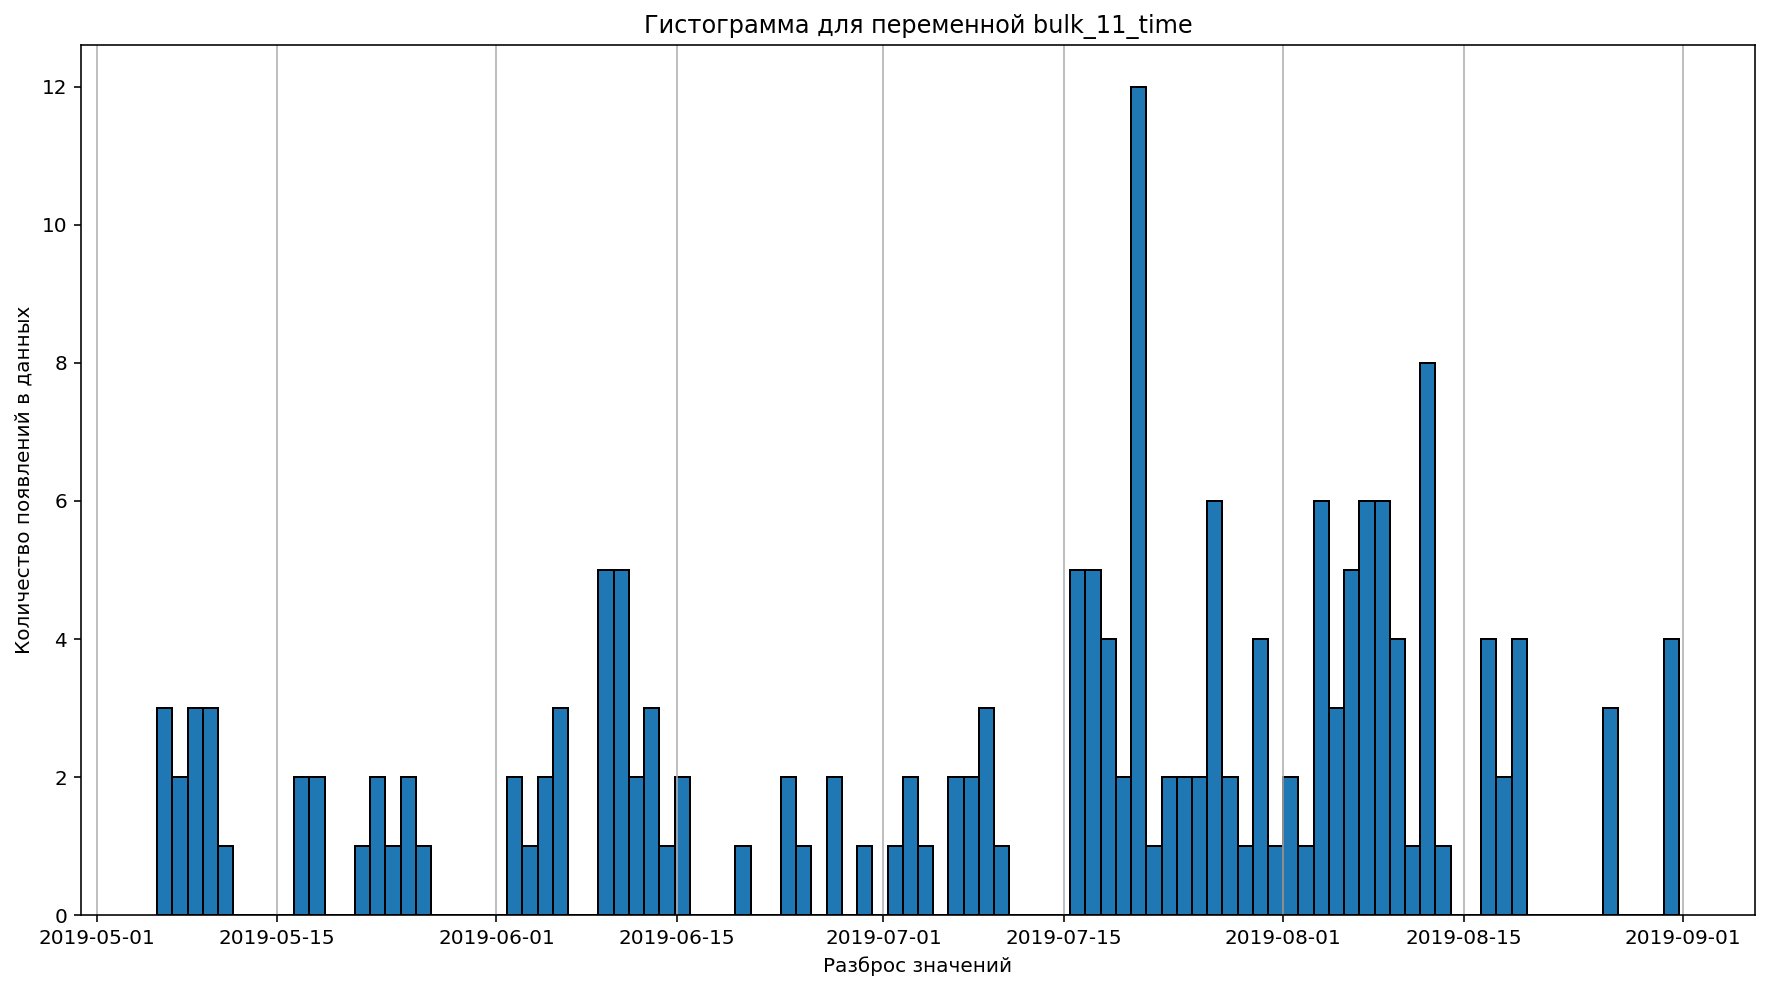

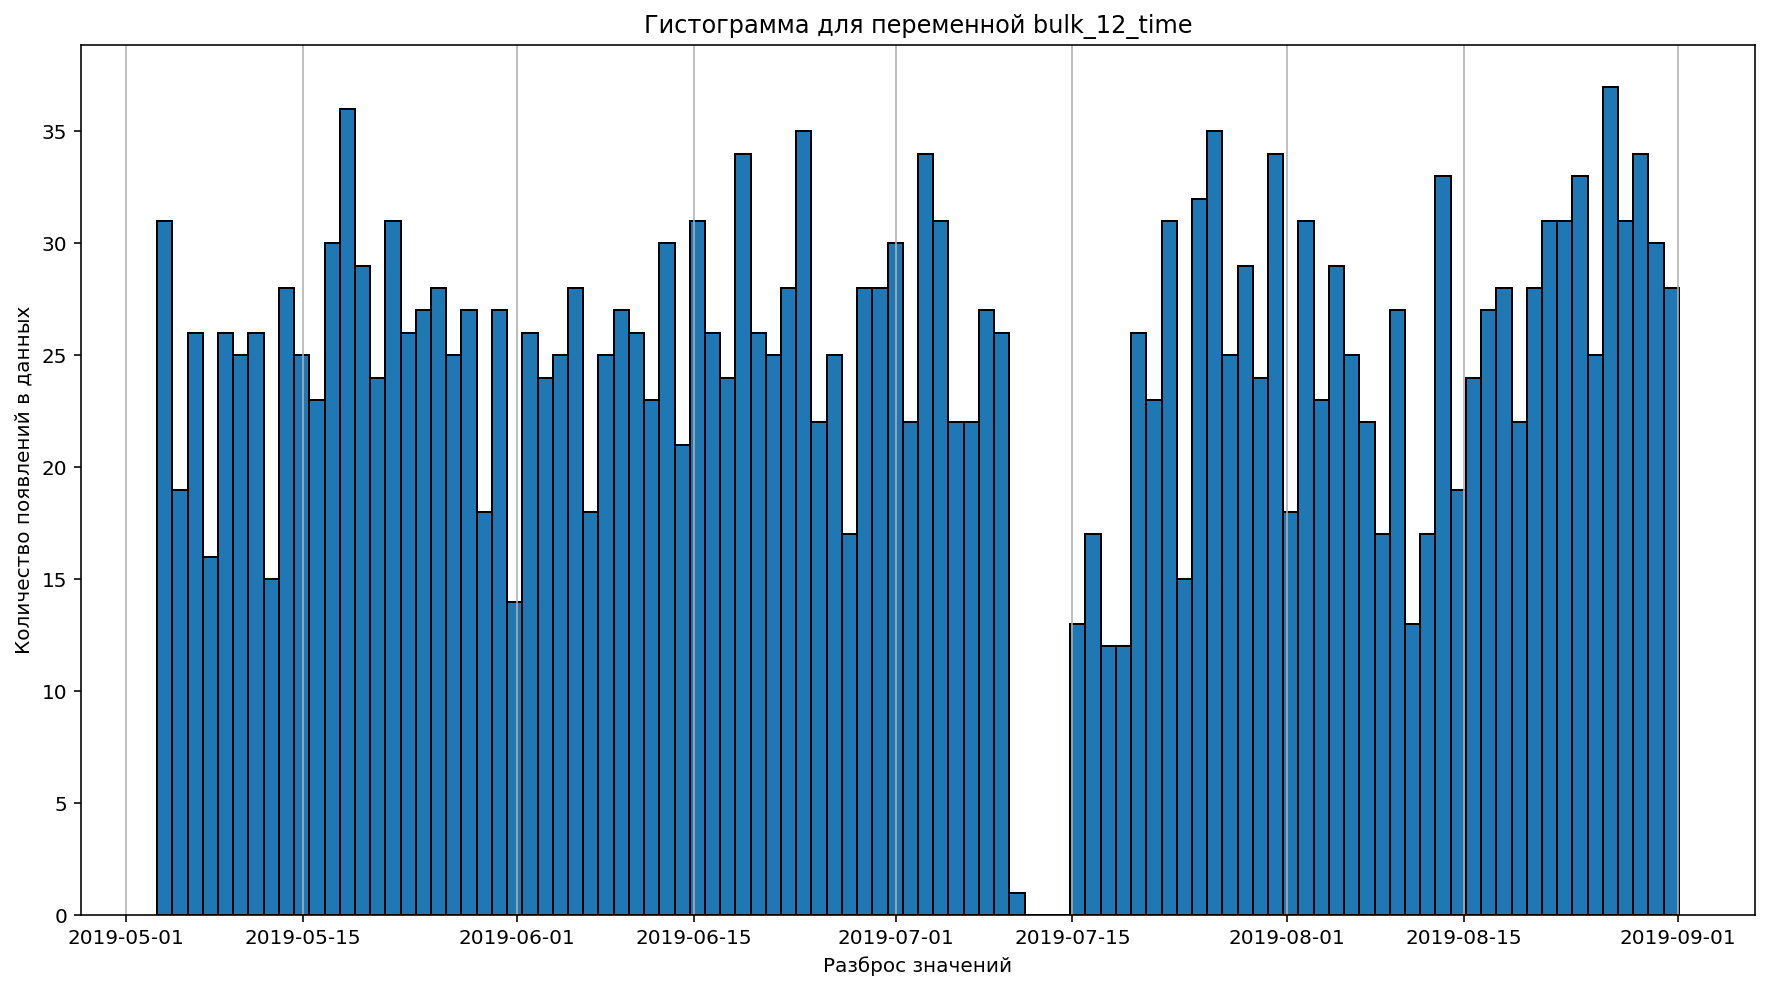

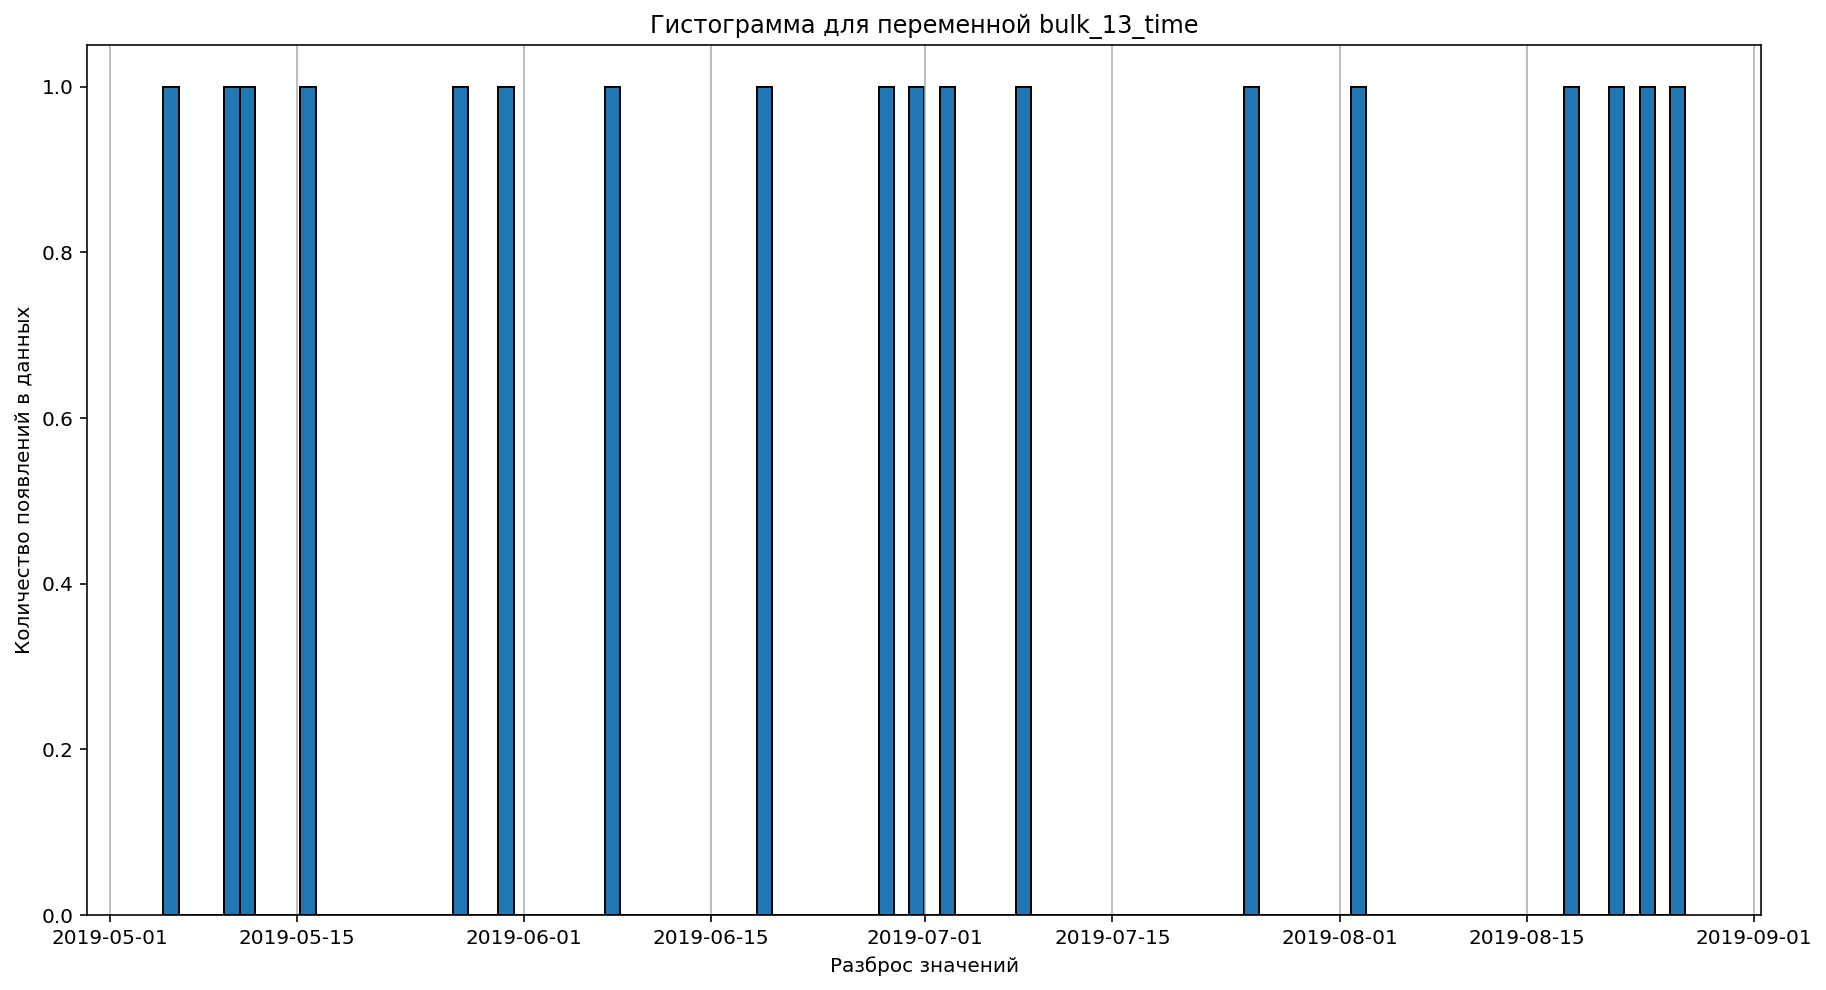

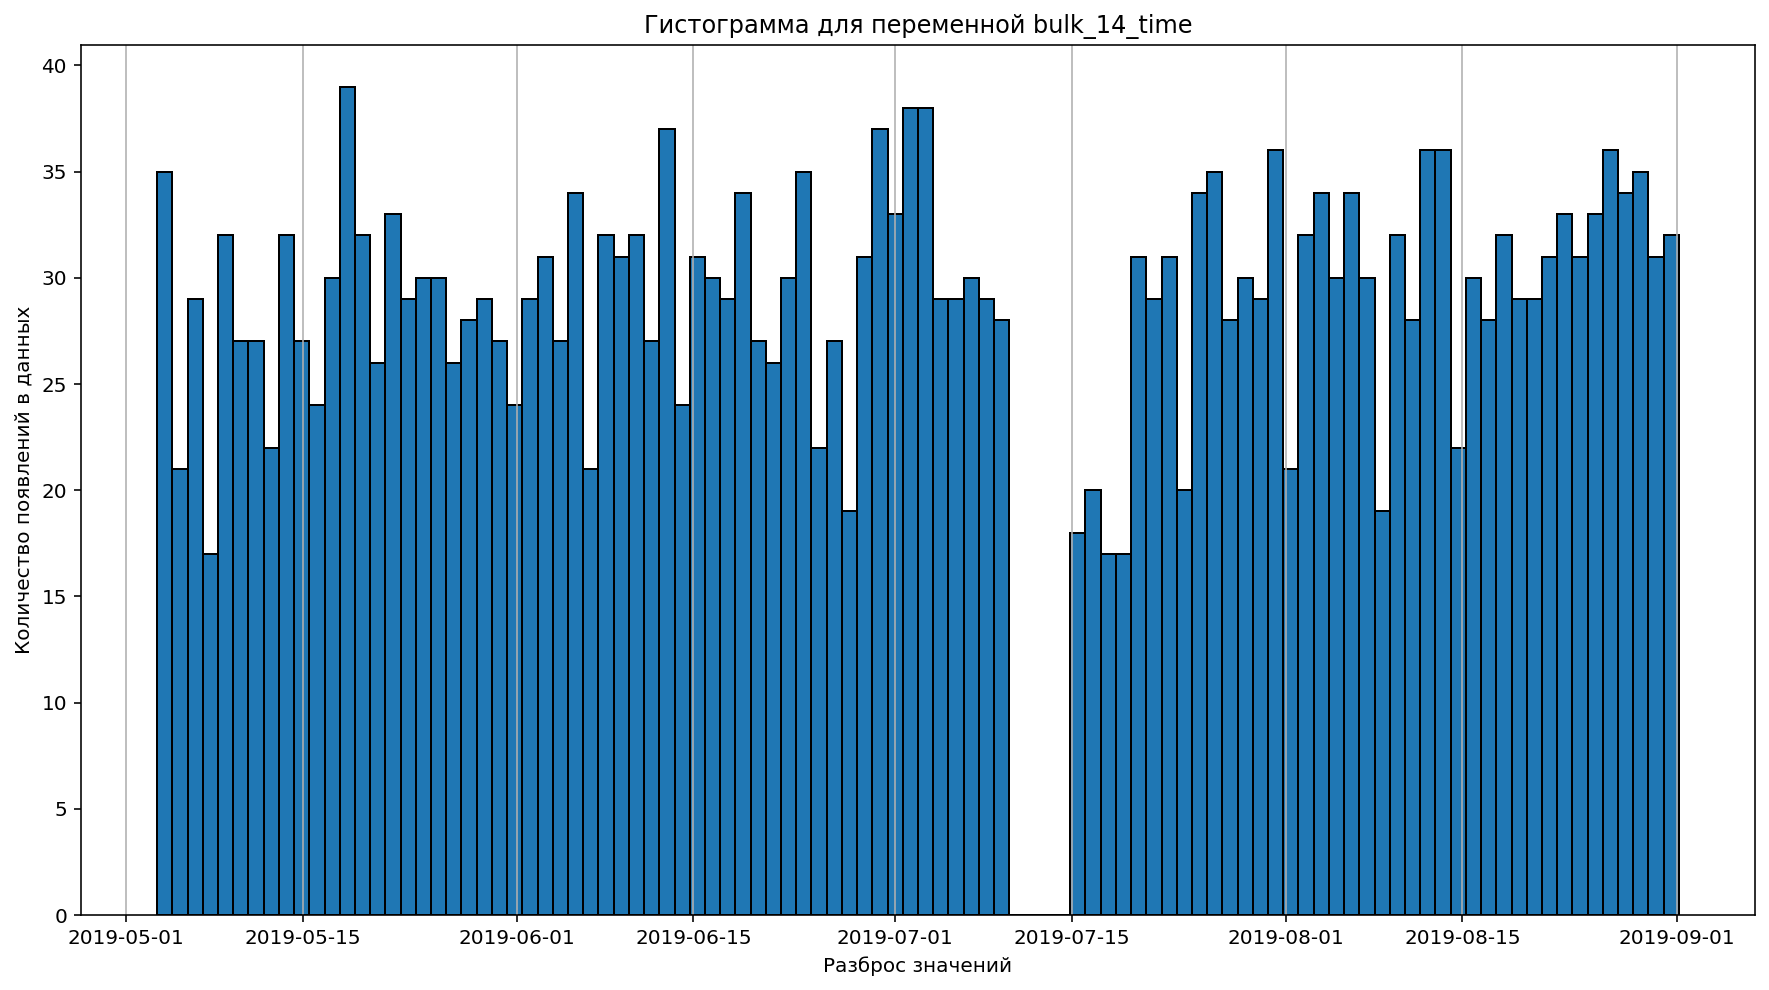

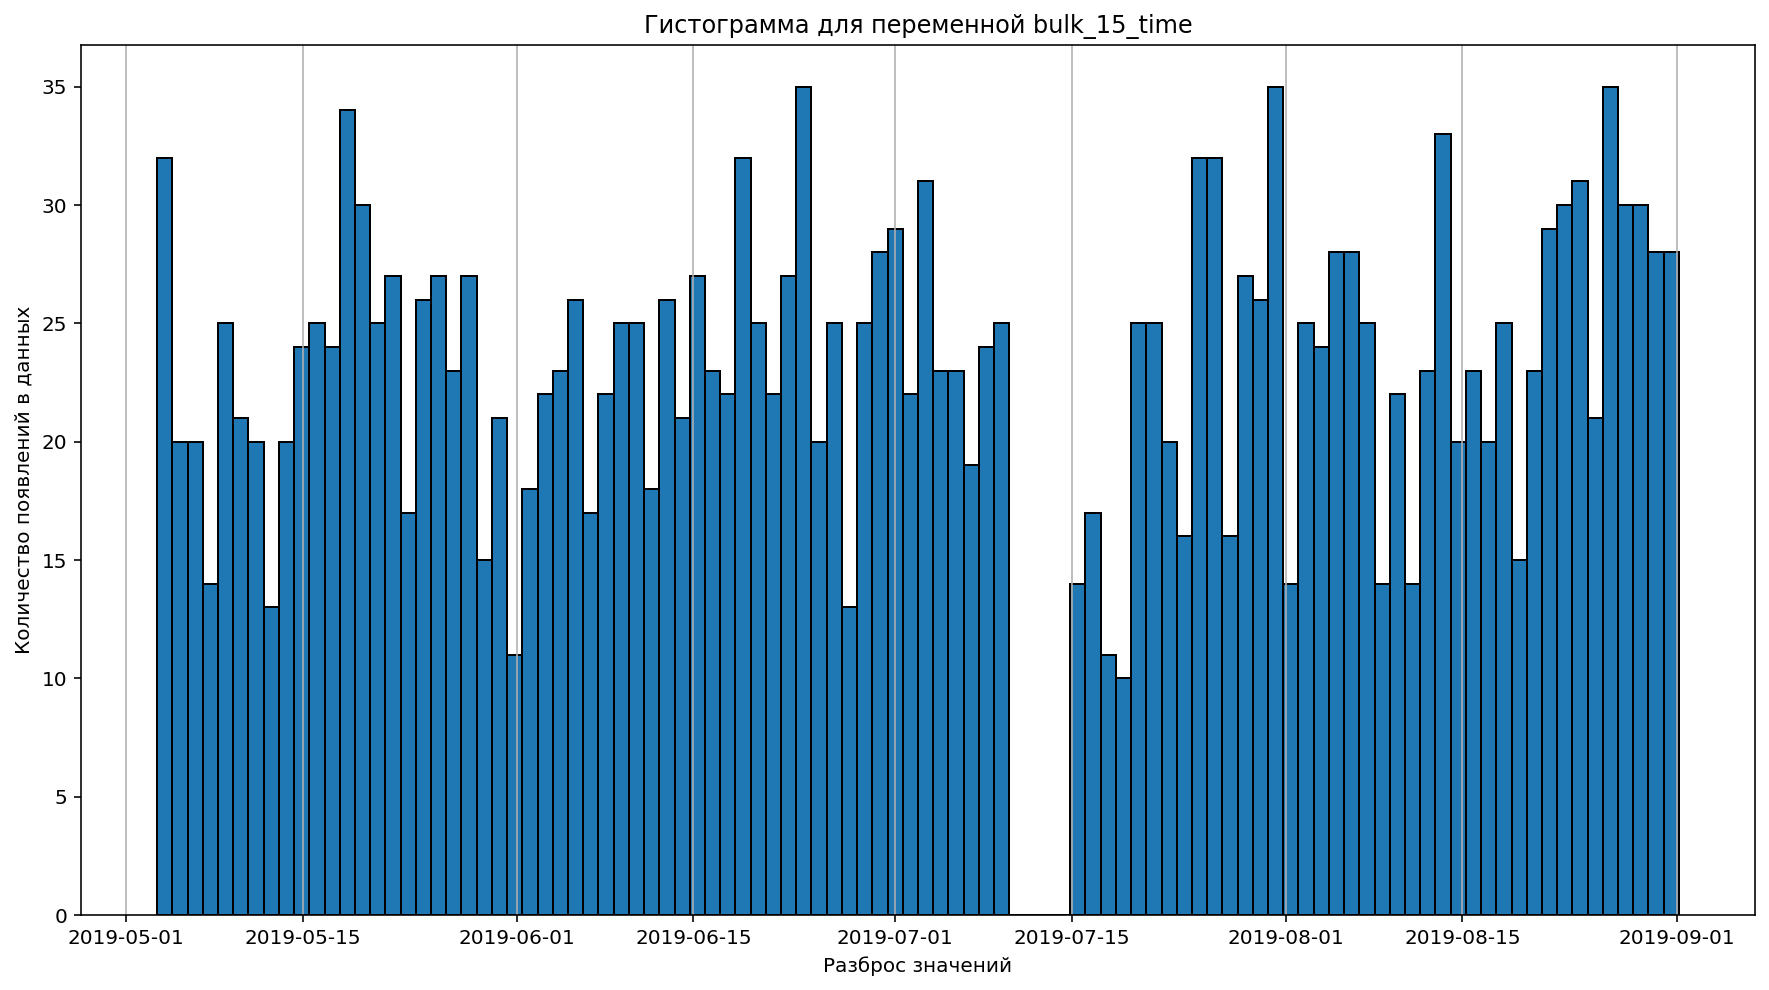

In [22]:
df_plot_hist(df_bulk_time)

In [23]:
df_bulk_time['key'].value_counts().head(10)

key
1       1
2174    1
2152    1
2153    1
2154    1
2155    1
2156    1
2157    1
2158    1
2159    1
Name: count, dtype: int64

**Вывод:**

- Количество данных совпадает с df_bulk, но помимо ключа все значения - даты;
- Аналогичное количество пропусков, во всех столбцах кроме 3, 4, 12, 14, 15 их больше 80%;
- Значения с 10 по 13 июля 2019 также отсутствуют;
- Значения ключей уникальны.


# 1.4 Данные о продувке сплава газом - gas


In [24]:
df_fast_info(df_gas)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Первые 3 строки датафрейма:


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793



Полные дубликаты:


0


Описательные статистики:


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
gas,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


,Кол-во уникальных значений,Доля пропусков
key,3239,0.0
gas,3239,0.0



Гистограммы:


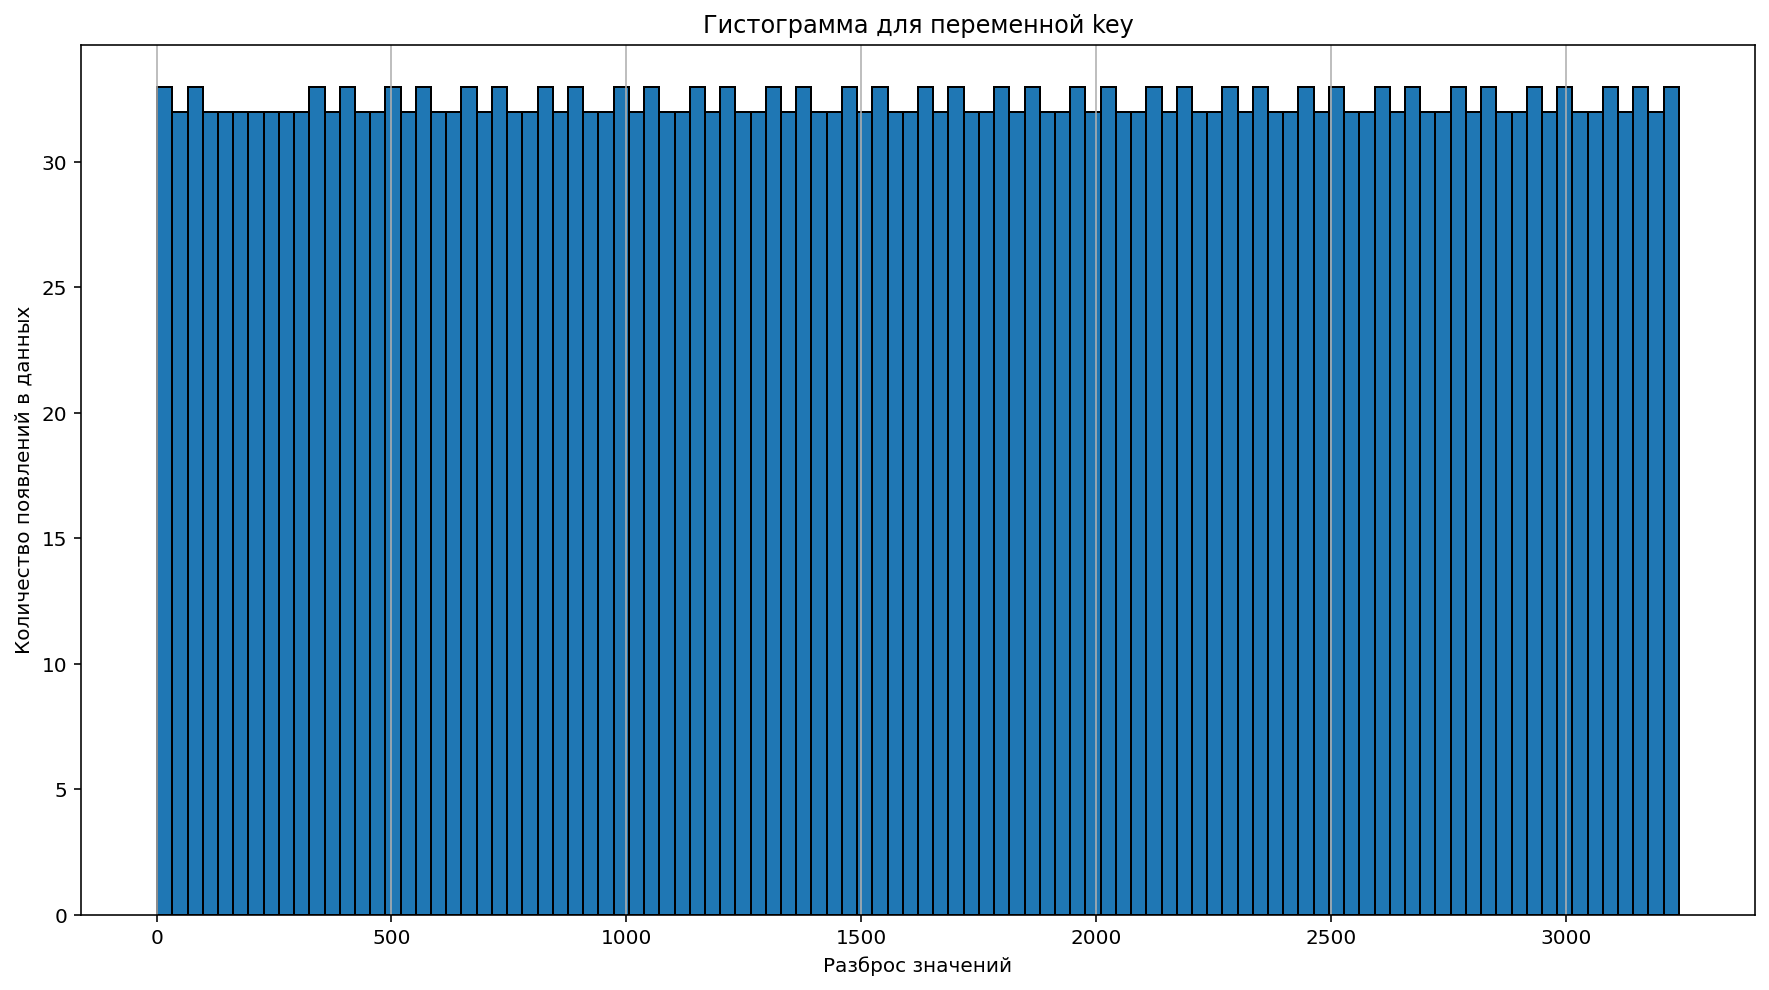

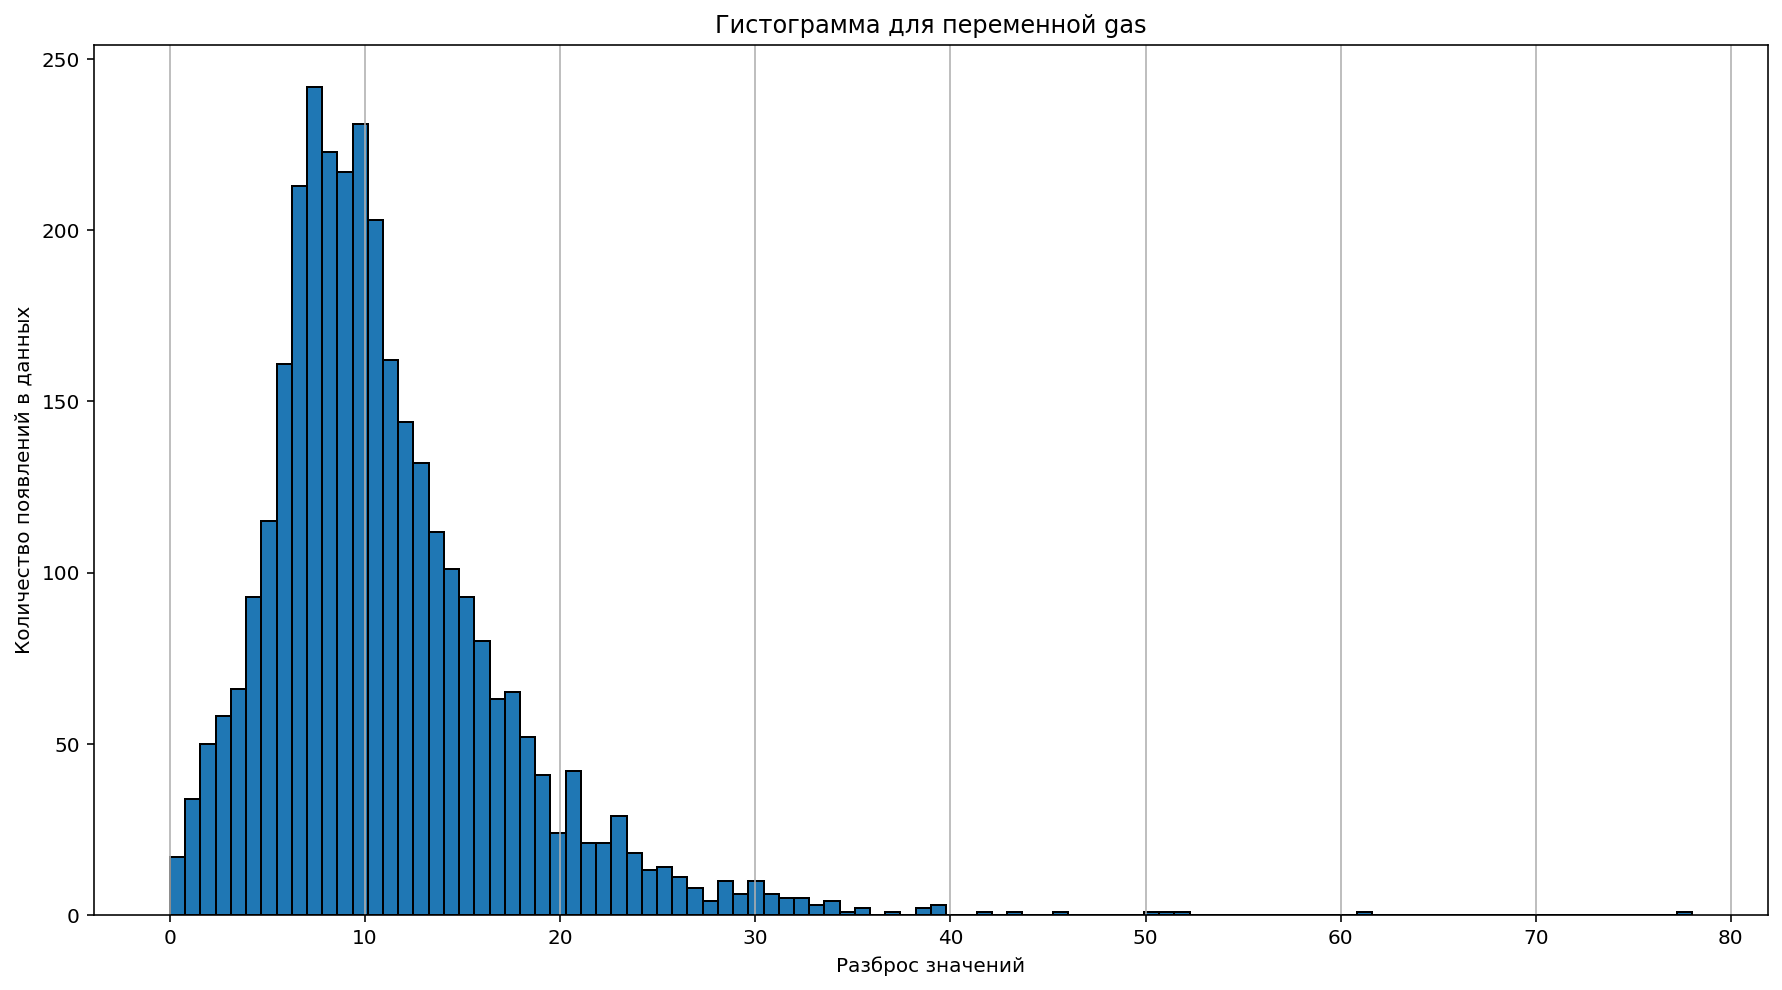

In [25]:
df_plot_hist(df_gas)


Корреляция:


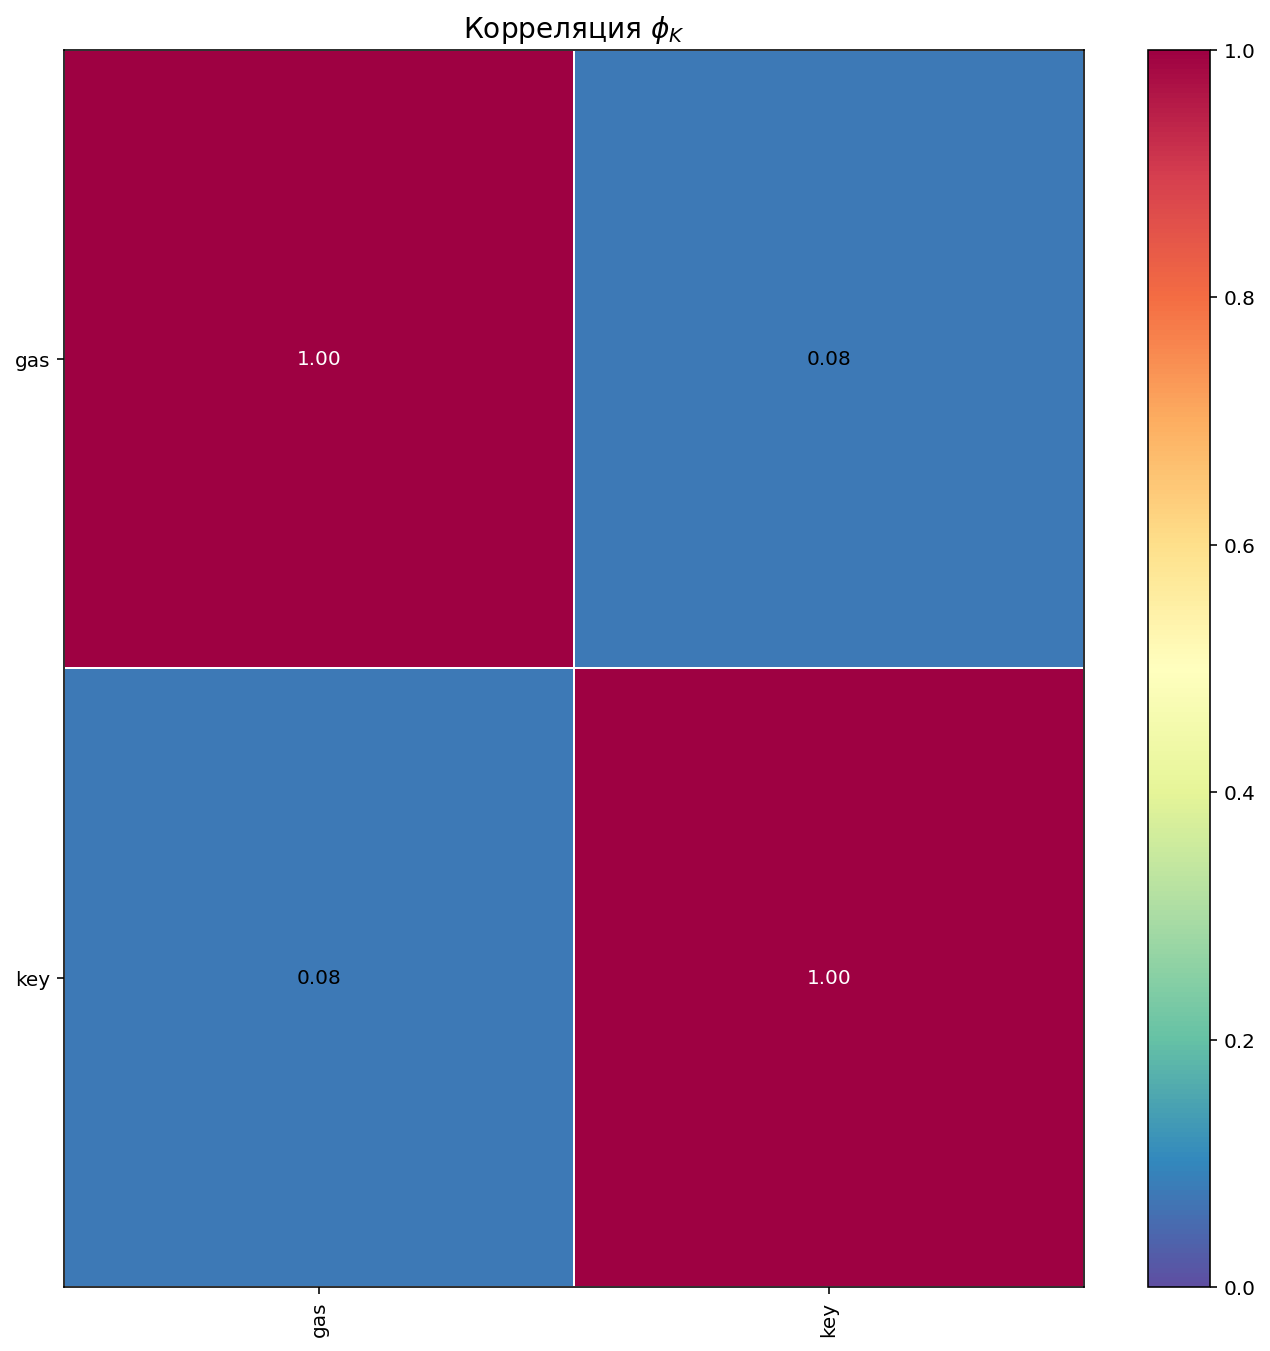

In [26]:
df_plot_corr(df_gas)

In [27]:
df_gas['key'].value_counts().head(10)

key
1       1
2166    1
2156    1
2157    1
2158    1
2159    1
2160    1
2161    1
2162    1
2163    1
Name: count, dtype: int64

In [28]:
len(df_gas.query('gas >= 20')) / len(df_gas)

0.07841926520531028

**Вывод:**

- В данных 3239 значений без пропусков;
- Распределение для газа похоже на логнормальное;
- Значения больше 20 в столбце gas составляют не больше 7,84 % от всех данных. Если предположить, что этот столбец содержит информацию о молярной массе используемого газа, то для большинства партий используют лёгкие газы;
- Значения ключей уникальны.


# 1.5 Результаты измерения температуры - temp


In [29]:
df_fast_info(df_temp)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   measure_time  15907 non-null  datetime64[ns]
 2   temperature   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB

Первые 3 строки датафрейма:


,key,measure_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0



Полные дубликаты:


0


Описательные статистики:


,count,mean,min,25%,50%,75%,max,std
key,15907.0,1607.88087,1.0,790.0,1618.0,2427.0,3241.0,942.212073
measure_time,15907,2019-07-02 09:55:01.000942848,2019-05-03 11:16:18,2019-06-01 16:24:51.500000,2019-06-30 10:31:14,2019-08-03 12:07:59,2019-09-01 04:38:08,NaN
temperature,13006.0,1591.84092,1191.0,1581.0,1591.0,1601.0,1705.0,21.375851


,Кол-во уникальных значений,Доля пропусков
temperature,175,0.182373
key,3216,0.000000
measure_time,15907,0.000000


In [30]:
df_temp['temperature'].value_counts().sort_index().head(10)

temperature
1191.0    1
1204.0    1
1208.0    1
1218.0    1
1227.0    1
1383.0    2
1519.0    1
1520.0    2
1525.0    2
1526.0    4
Name: count, dtype: int64

In [31]:
df_temp.query('temperature < 1500')

,key,measure_time,temperature
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0



Гистограммы:


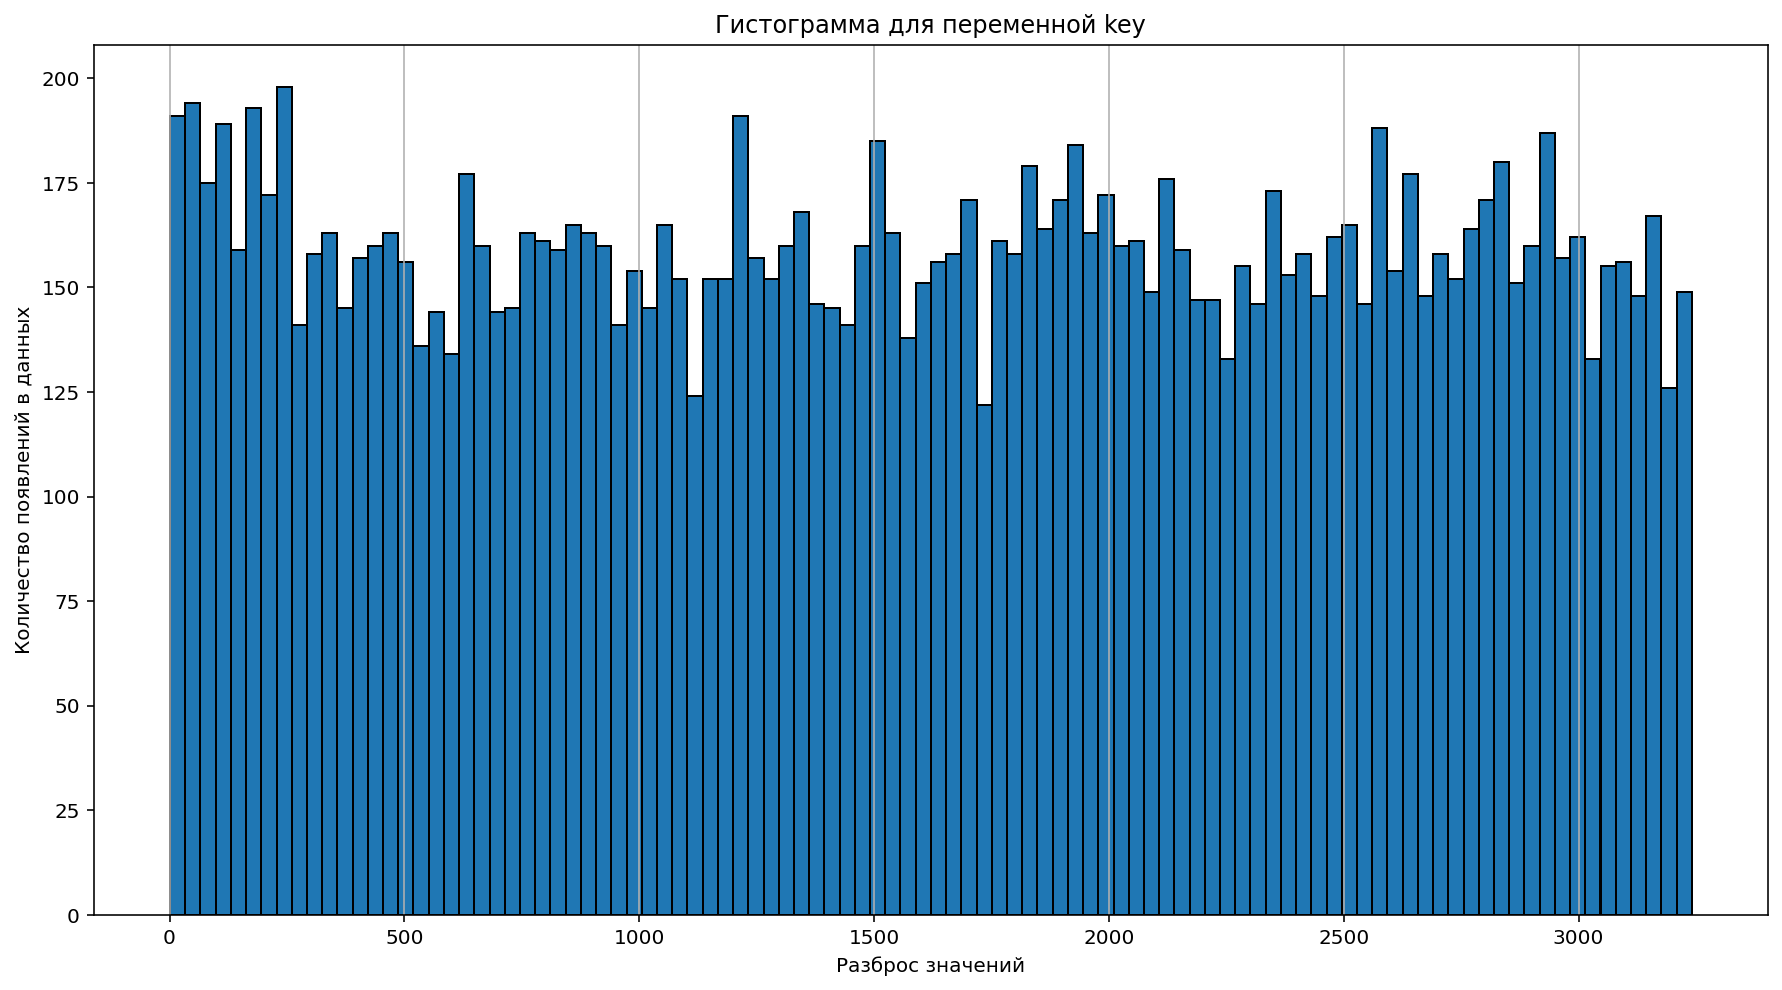

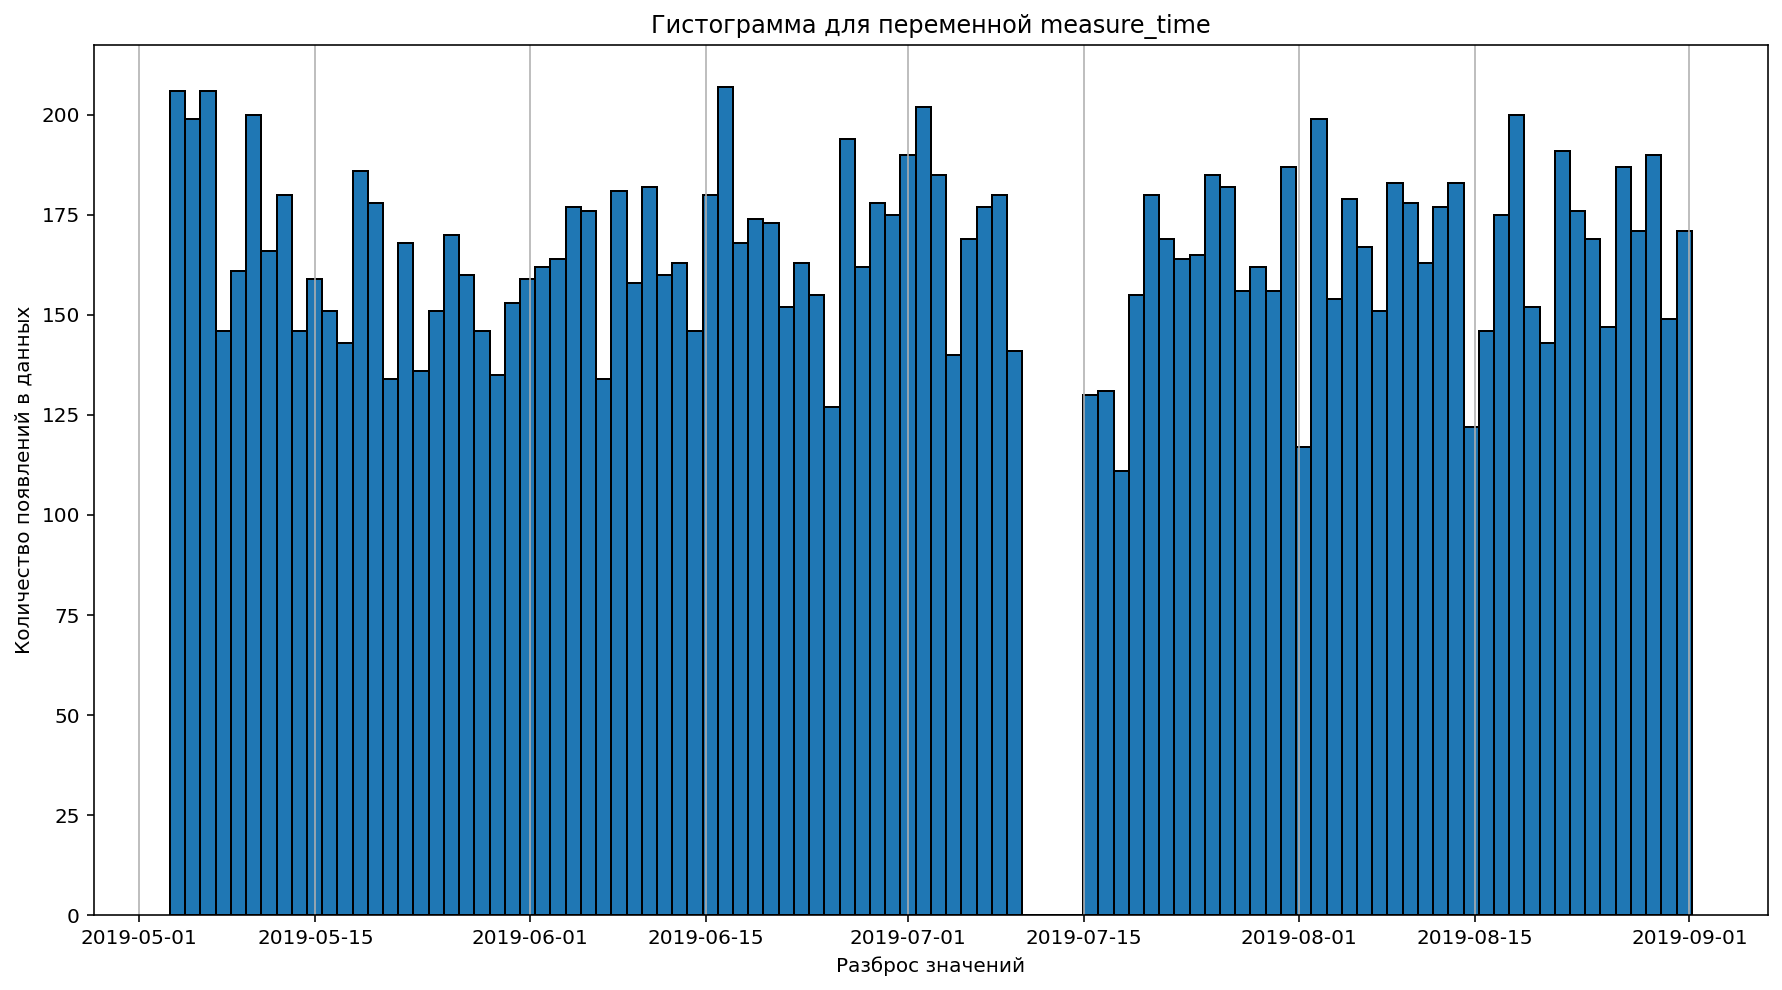

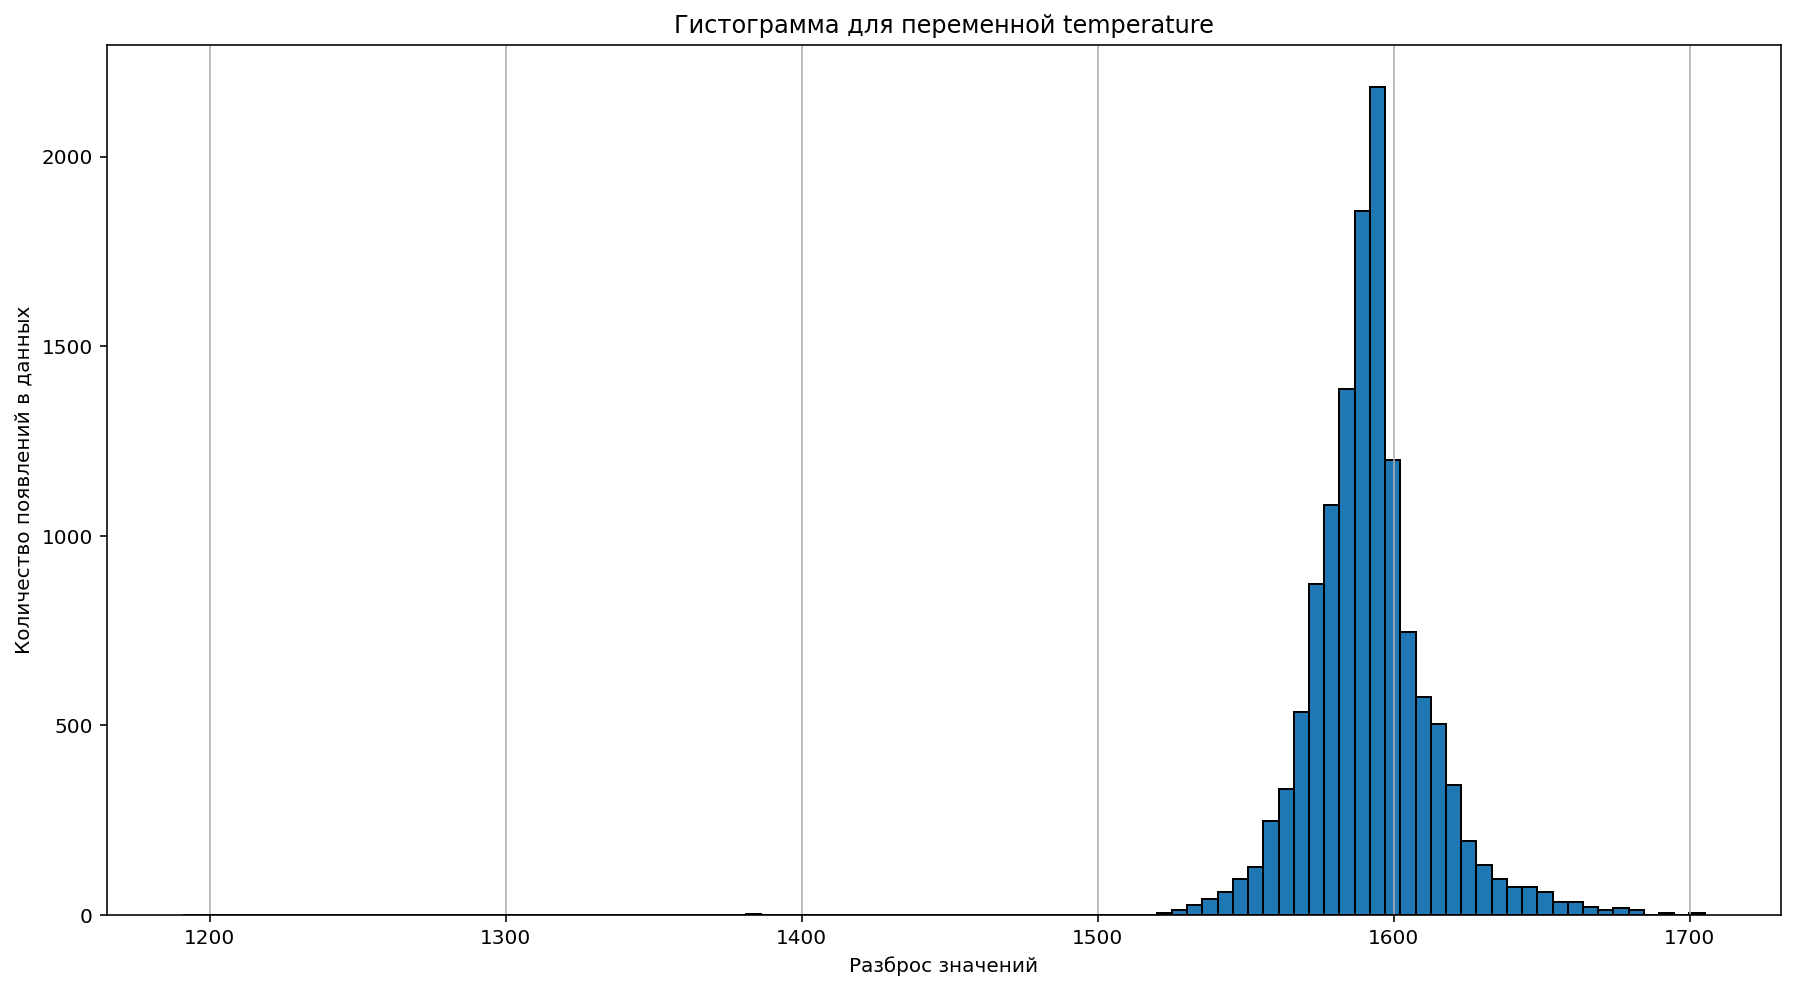

In [32]:
df_plot_hist(df_temp)


Корреляция:


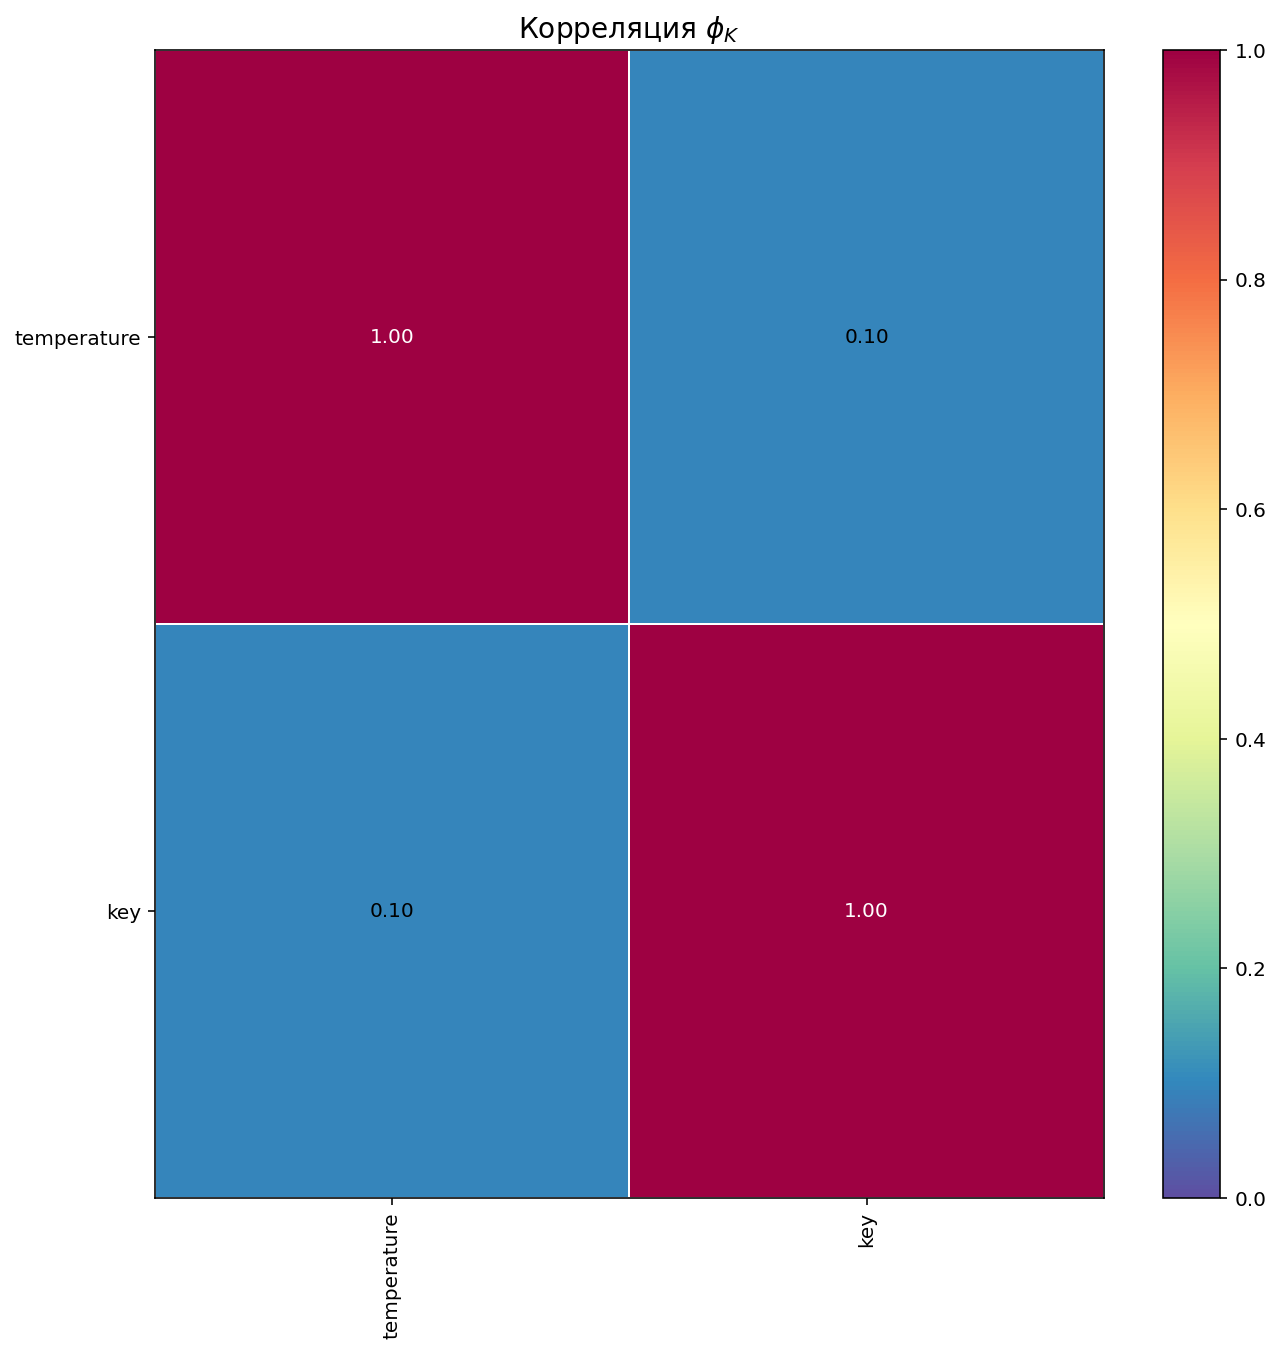

In [33]:
df_plot_corr(df_temp)

In [34]:
df_temp['key'].value_counts()

key
46      16
1214    16
44      16
1513    16
2108    15
        ..
1160     2
982      2
2456     2
195      1
279      1
Name: count, Length: 3216, dtype: int64

Поскольку на каждый ключ приходится по несколько значений, то гистограмма, выведенная ранее для температуры не совсем корректно. Выведем отдельно гистограммы для температур в самую раннюю и самую позднюю даты.


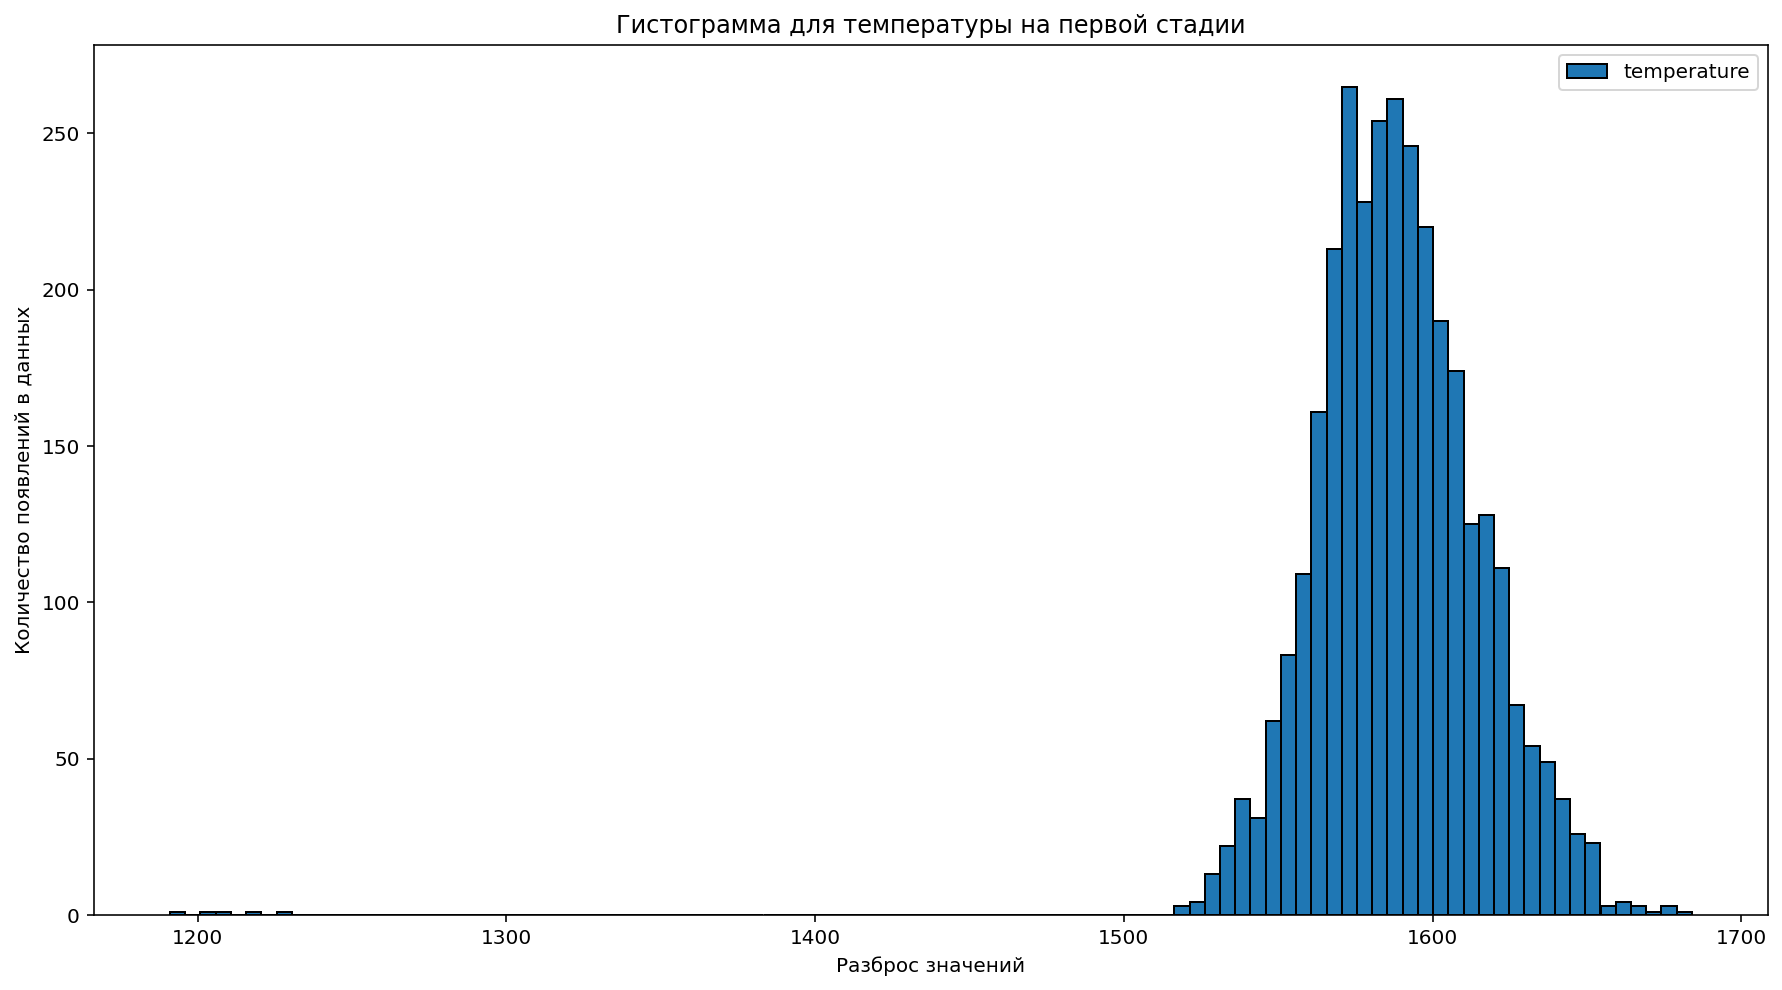

In [35]:
(df_temp.groupby('key').apply(lambda x: x.loc[x['measure_time'].idxmin()])
 .plot.hist(y='temperature', bins=100, ec='k', figsize=(15, 8)))
plt.title('Гистограмма для температуры на первой стадии')
plt.xlabel('Разброс значений')
plt.ylabel('Количество появлений в данных')
plt.grid(False, axis='y')
plt.show()

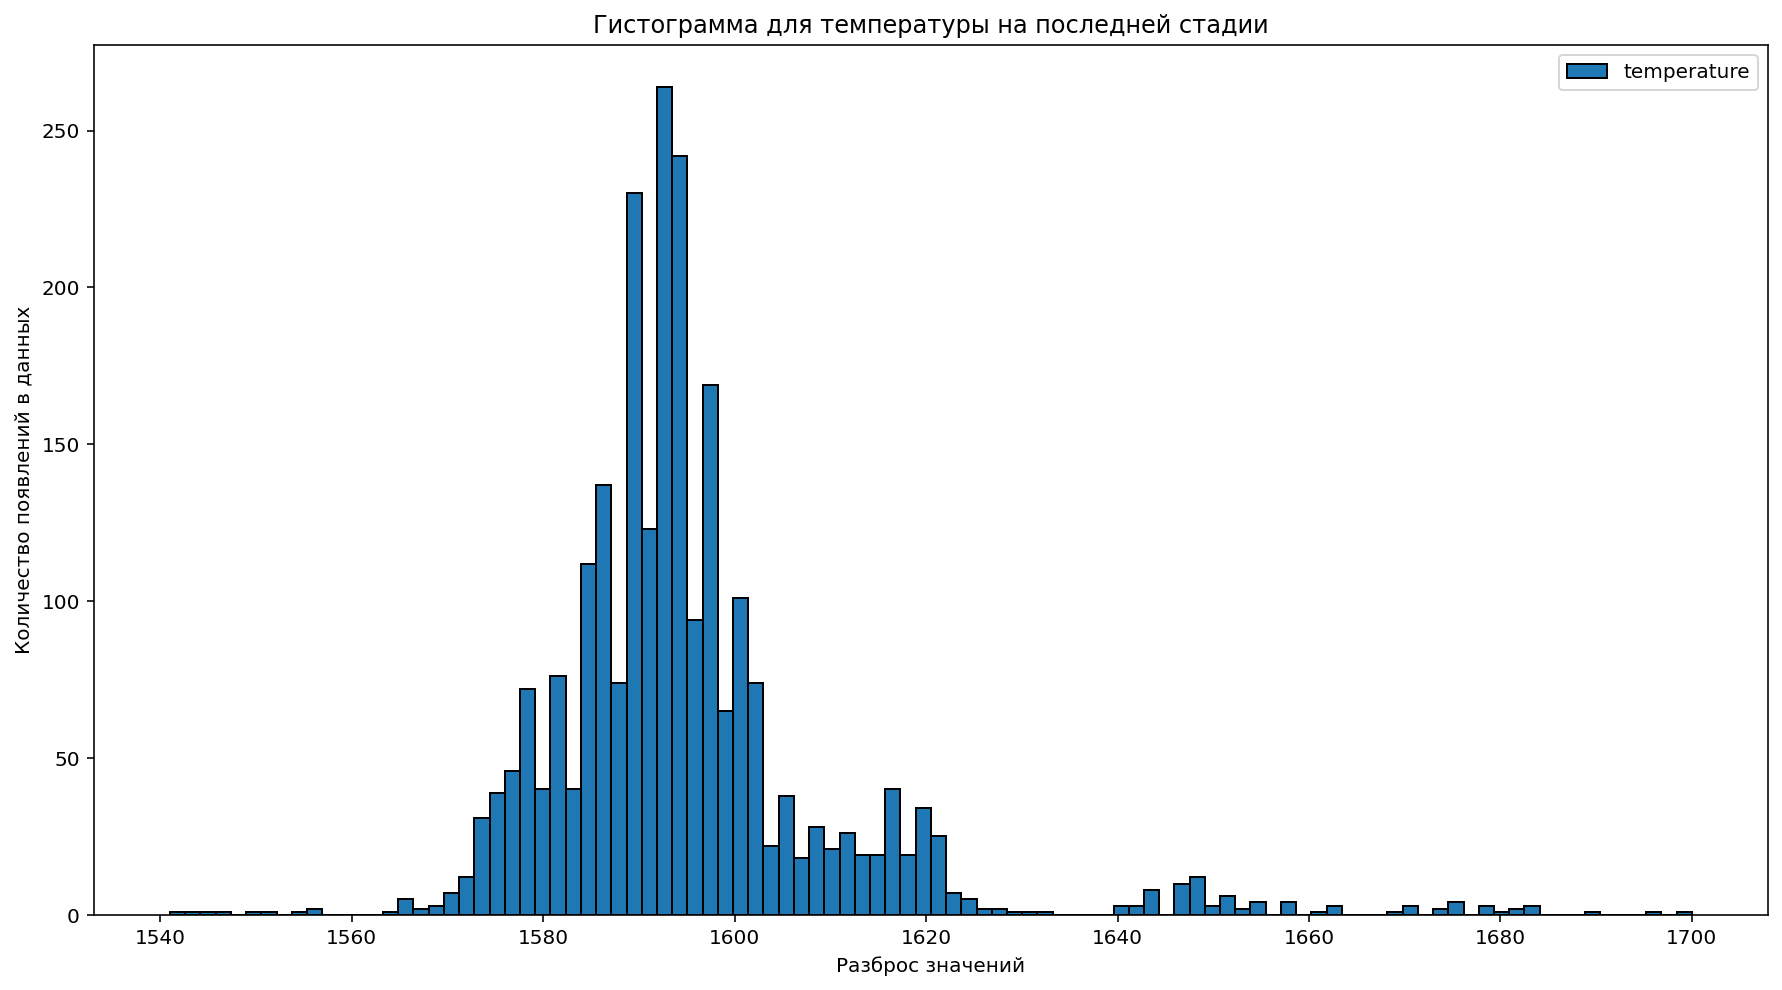

In [36]:
(df_temp.groupby('key').apply(lambda x: x.loc[x['measure_time'].idxmax()])
 .plot.hist(y='temperature', bins=100, ec='k', figsize=(15, 8)))
plt.title('Гистограмма для температуры на последней стадии')
plt.xlabel('Разброс значений')
plt.ylabel('Количество появлений в данных')
plt.grid(False, axis='y')
plt.show()

Вывод:

- На каждое значение ключа приходится по несколько значений температур;
- На гистограмме температур на начальном этапе выделяются несколько выбросов, но в целом для начального и конечного этапа данные похожи на нормальное распределение;
- В дате аналогичный пропуск в том же месте, как и в других данных.


# 1.6 Данные о проволочных материалах (объём) - wire


In [37]:
df_fast_info(df_wire)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Первые 3 строки датафрейма:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Полные дубликаты:


0


Описательные статистики:


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
wire_1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
wire_2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
wire_3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
wire_4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
wire_5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
wire_6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
wire_7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
wire_8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
wire_9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


,Кол-во уникальных значений,Доля пропусков
wire_5,1,0.999675
wire_7,10,0.996430
wire_4,14,0.995456
wire_8,13,0.993833
wire_9,25,0.990587
wire_3,56,0.979552
wire_6,69,0.976306
wire_2,713,0.649789
wire_1,2251,0.008439
key,3081,0.000000



Гистограммы:


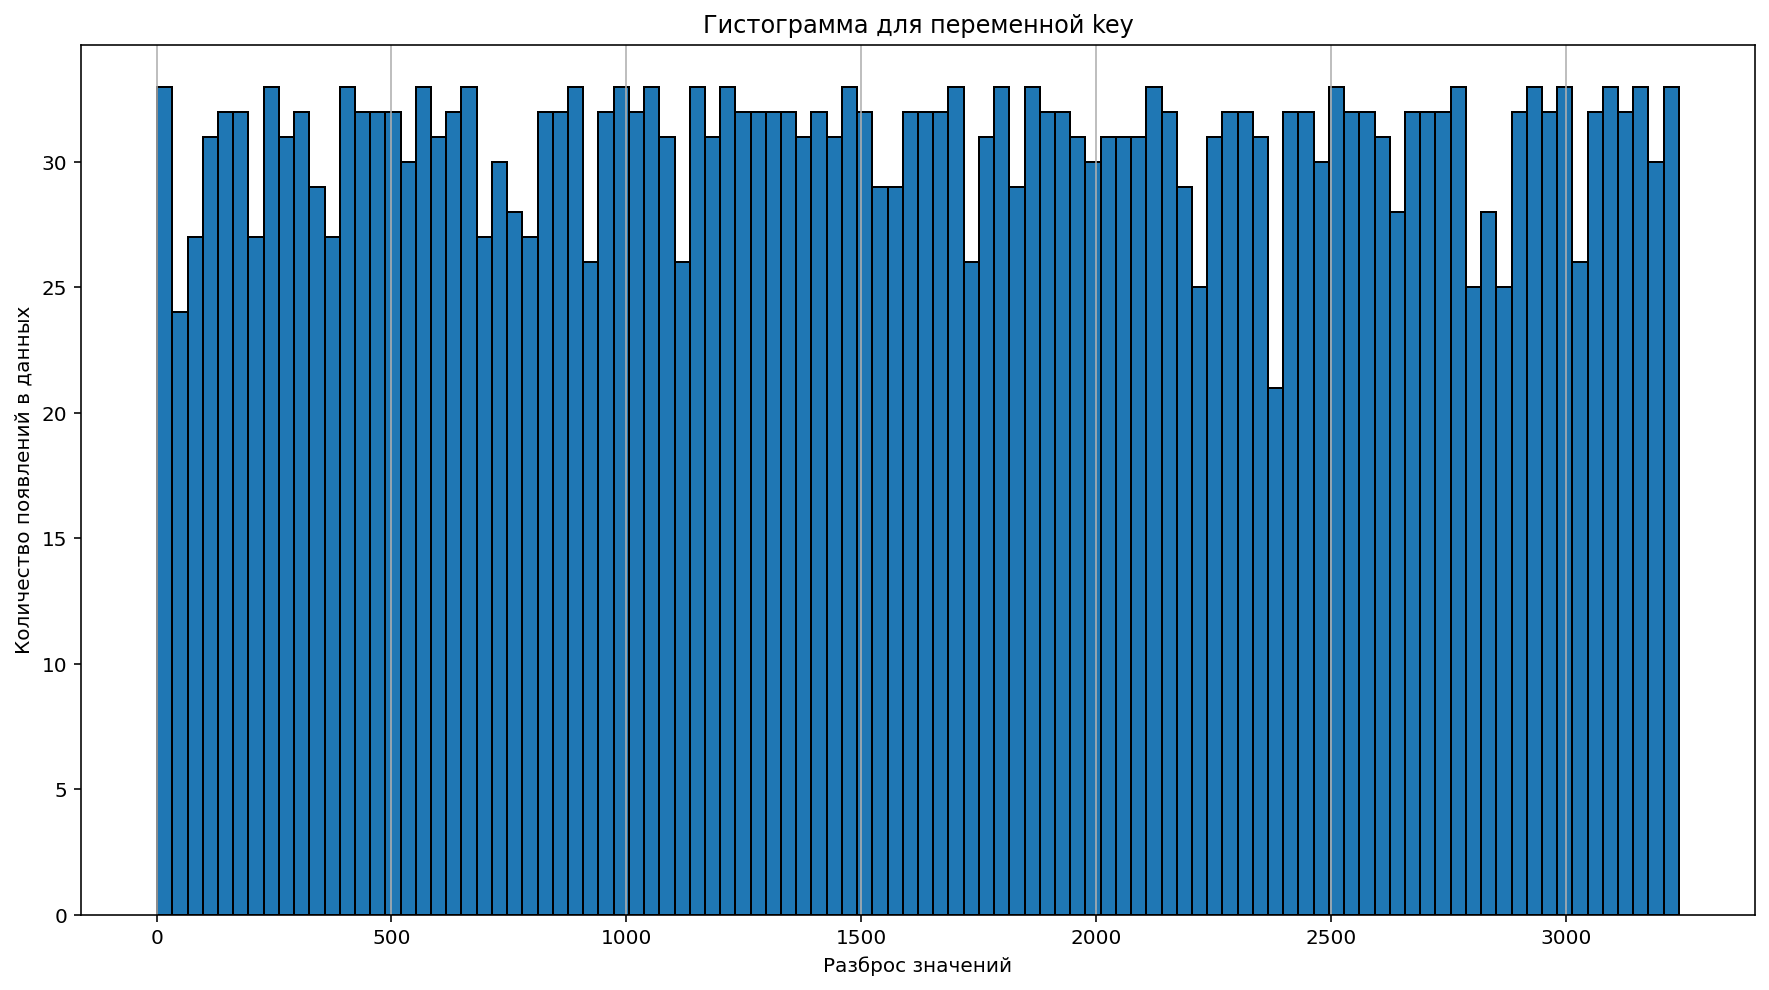

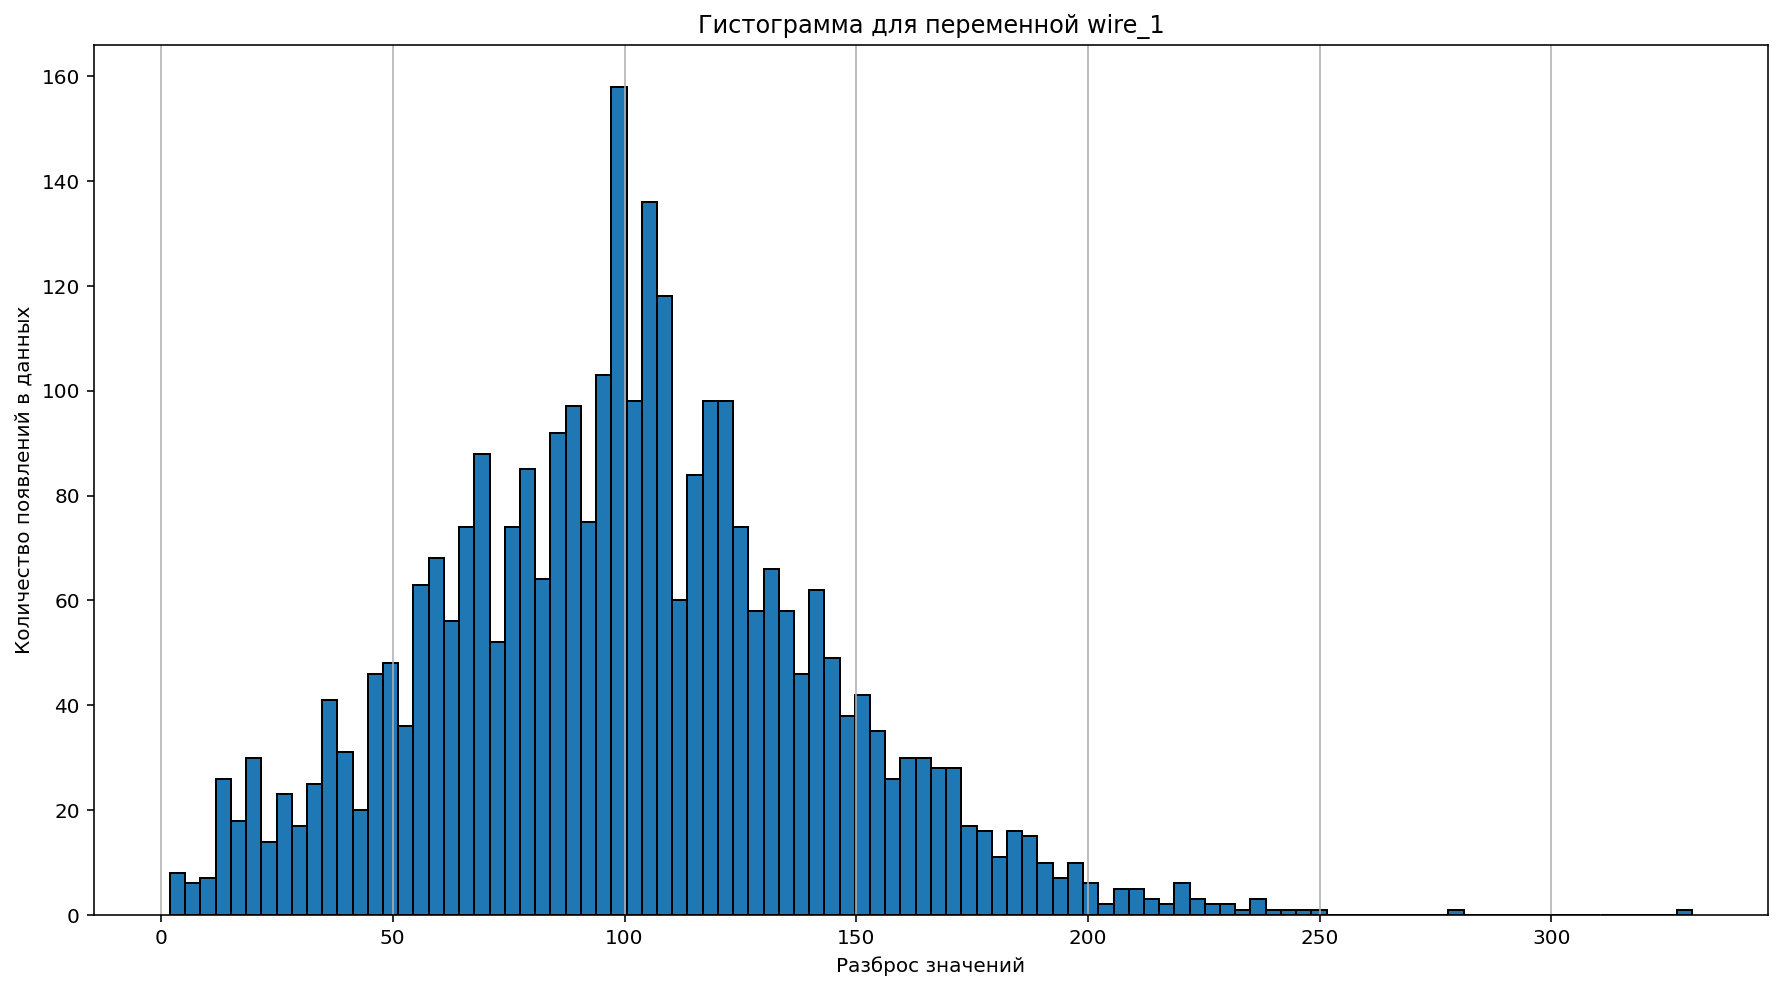

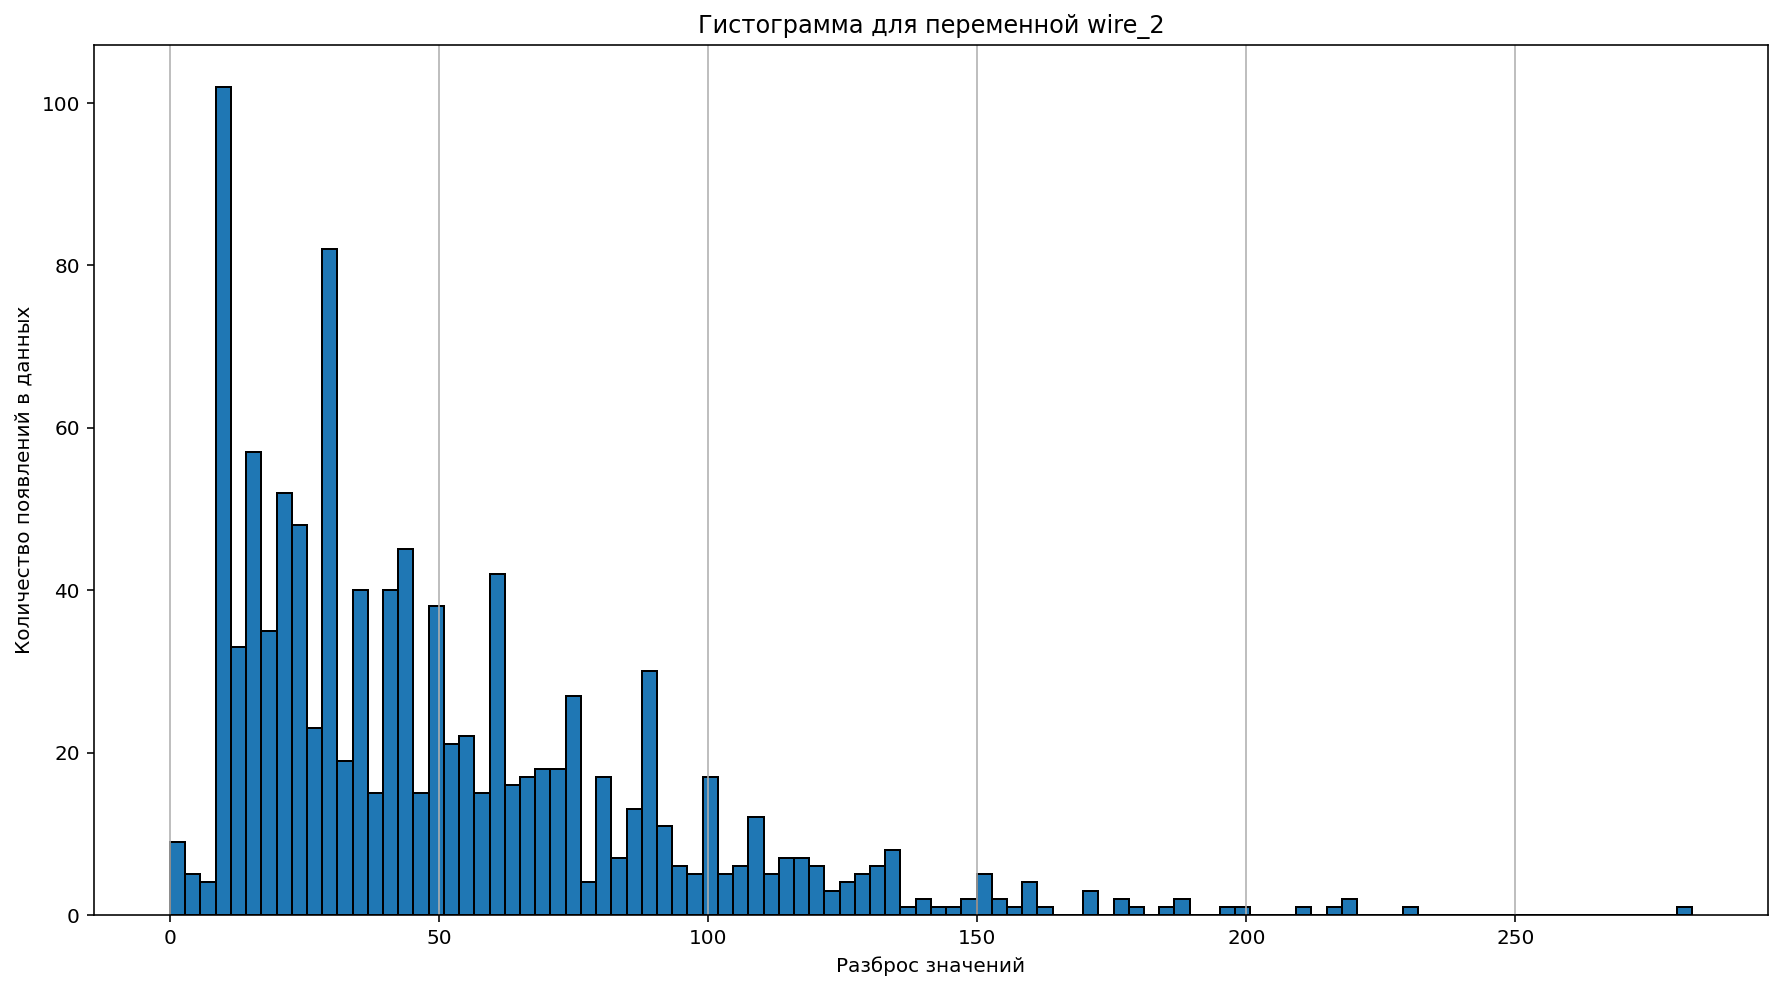

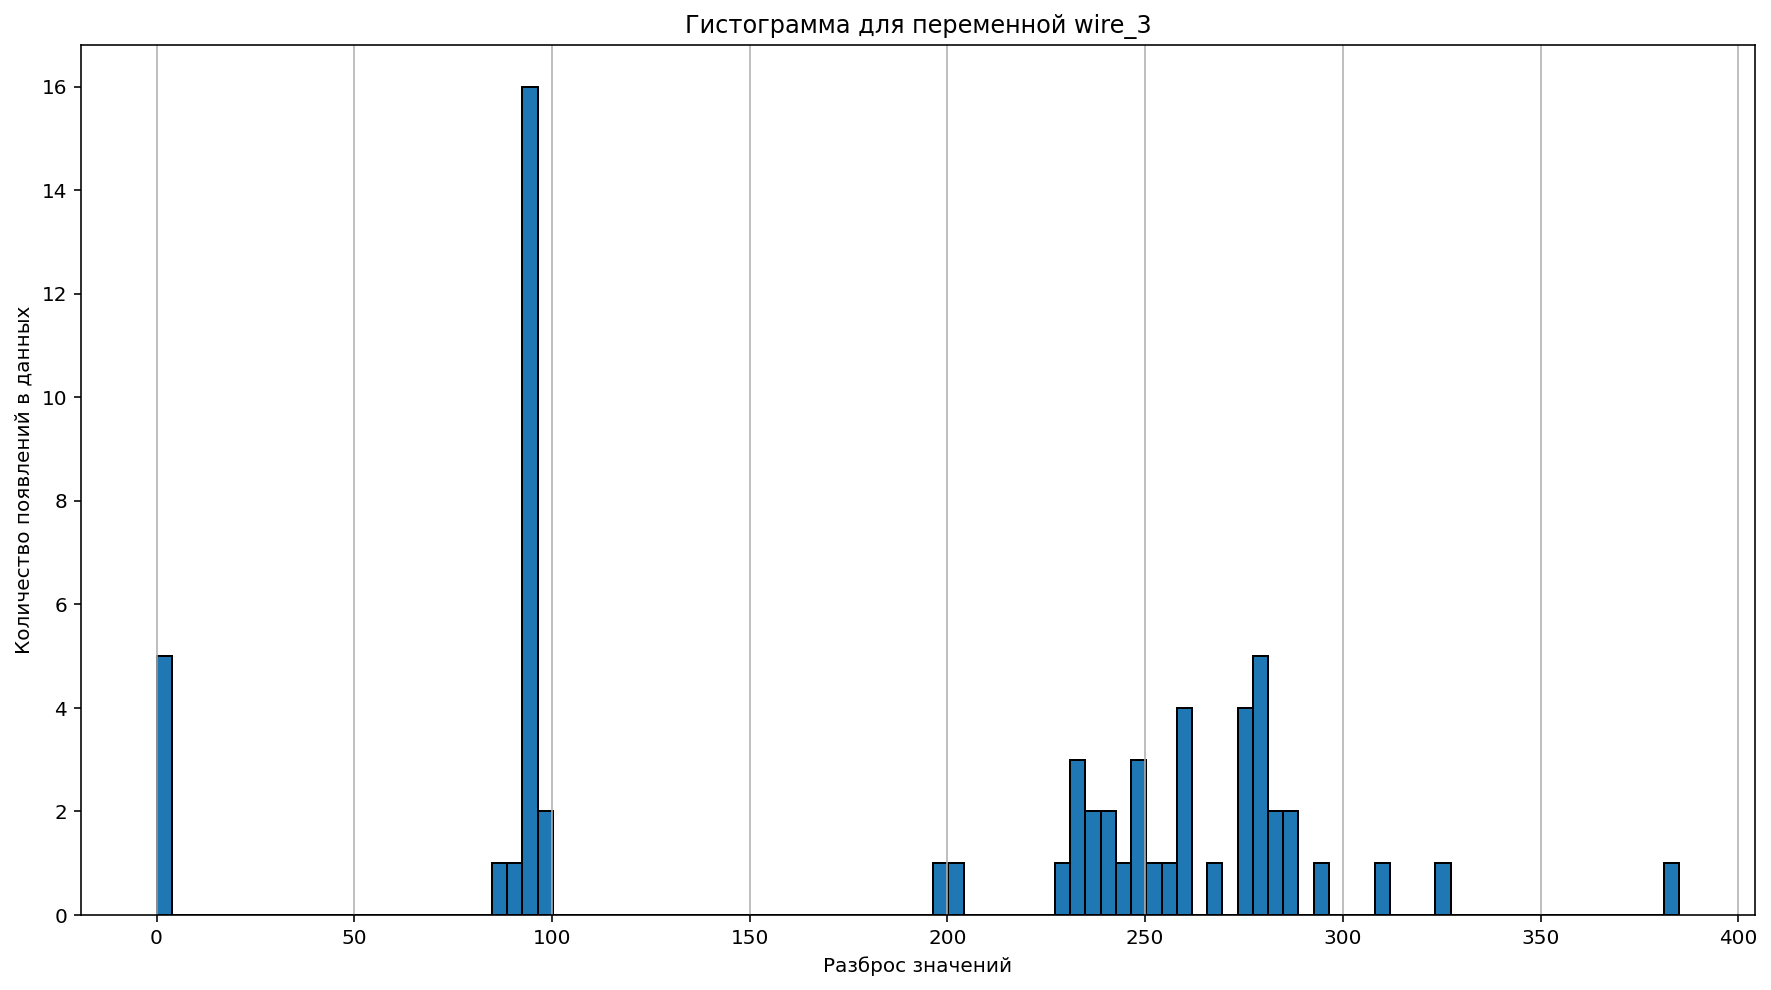

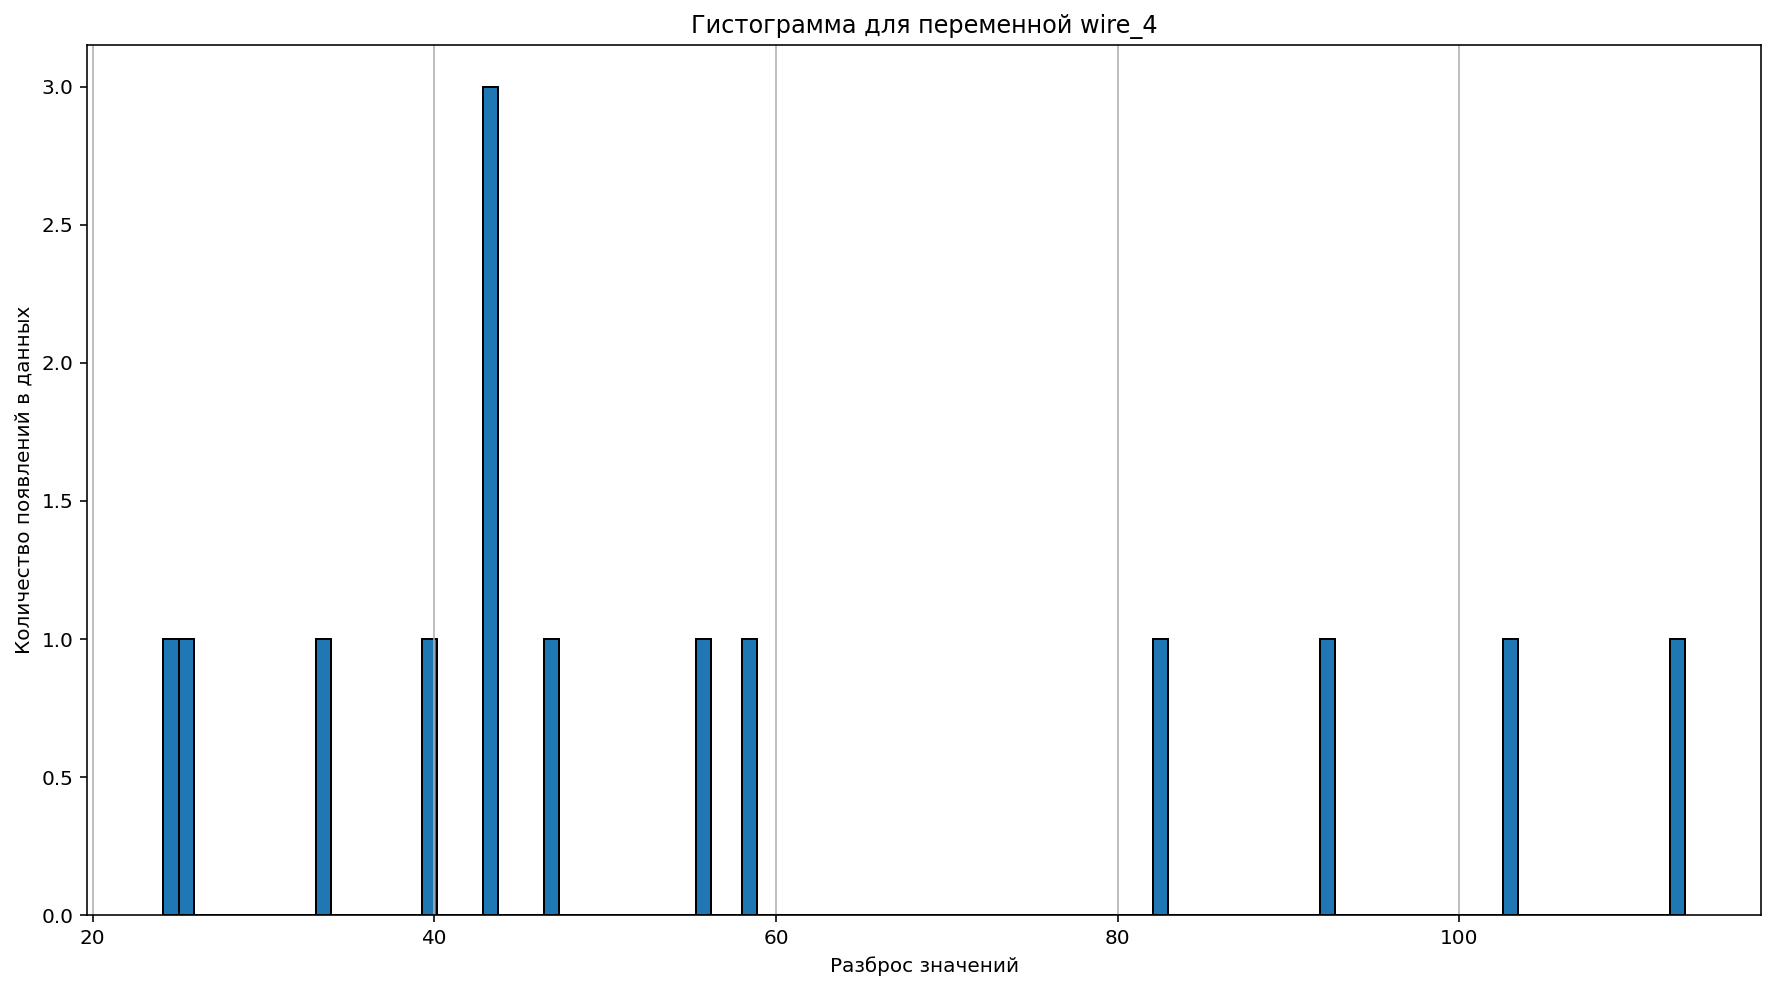

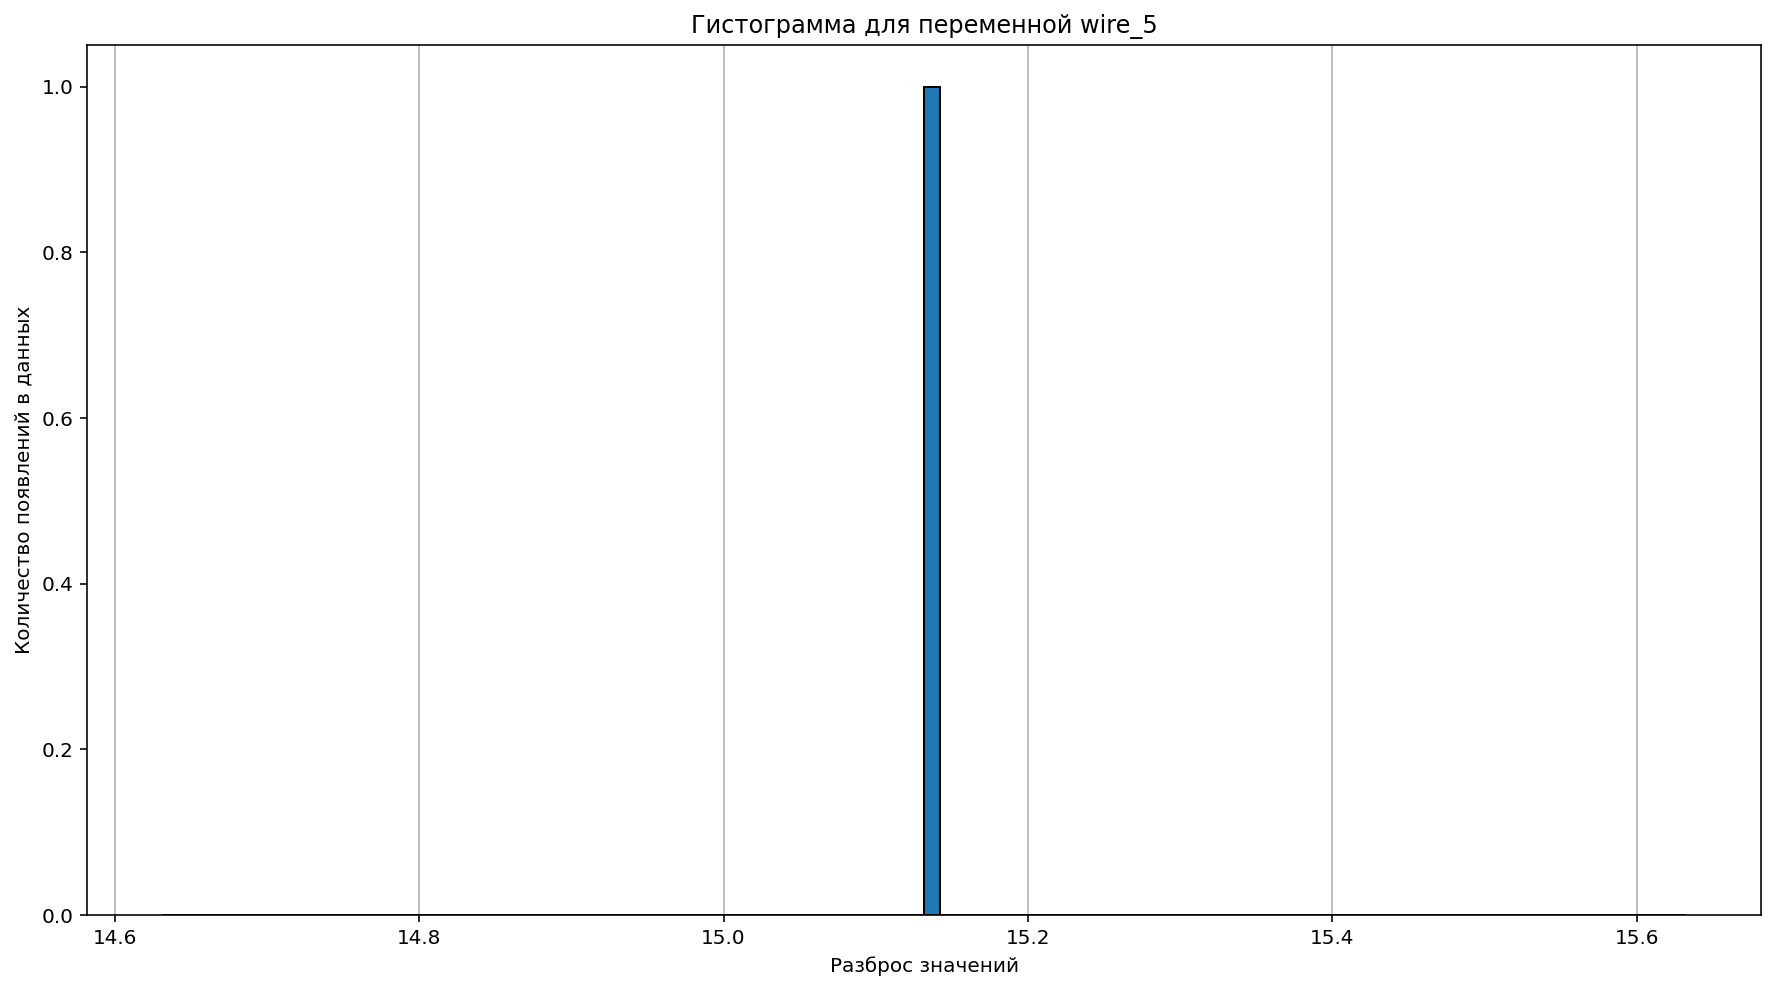

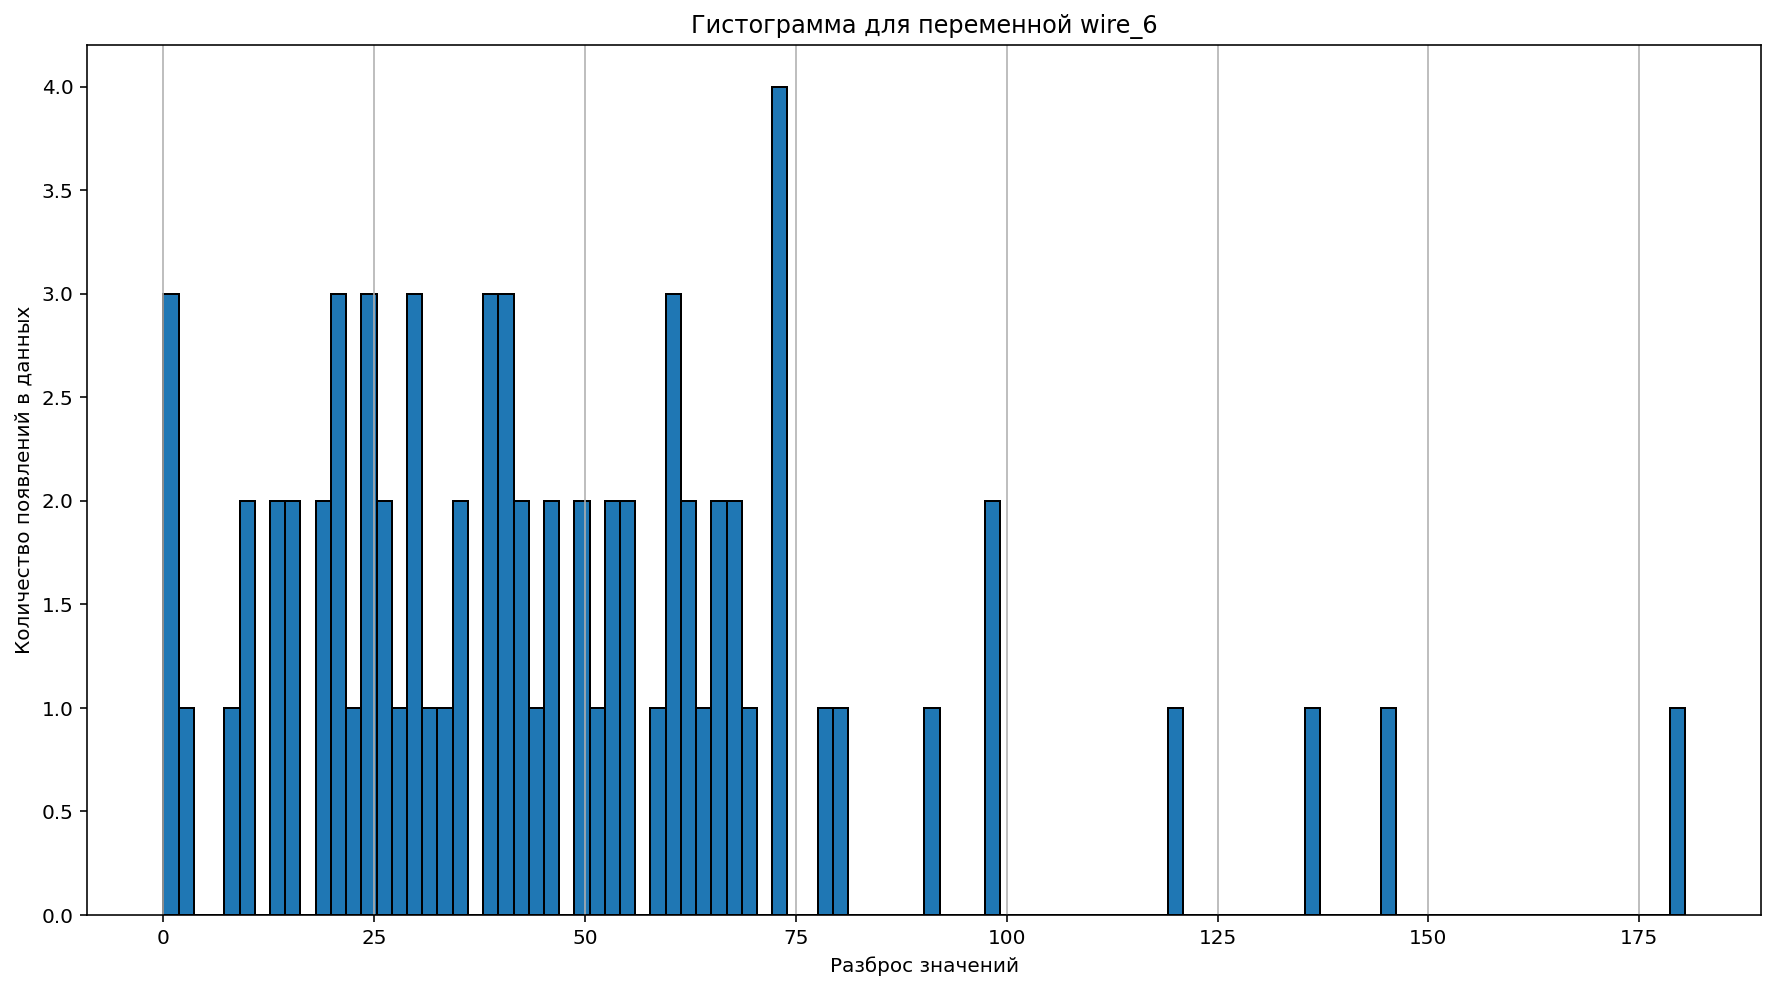

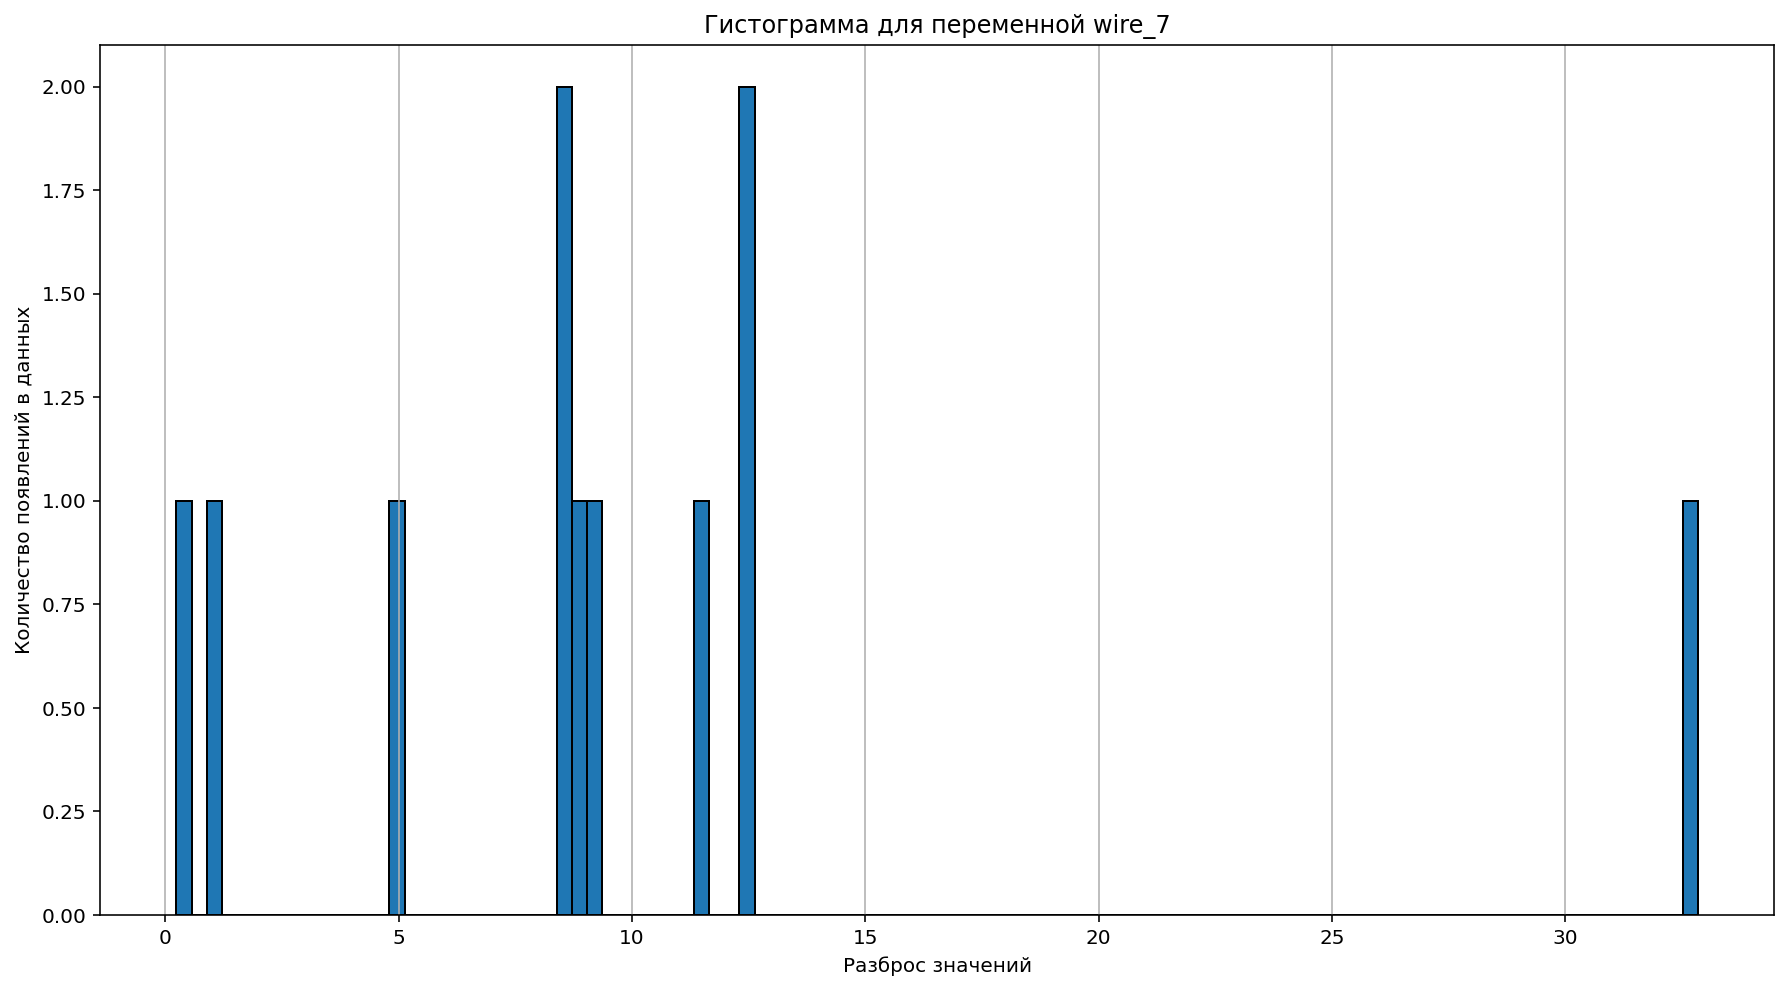

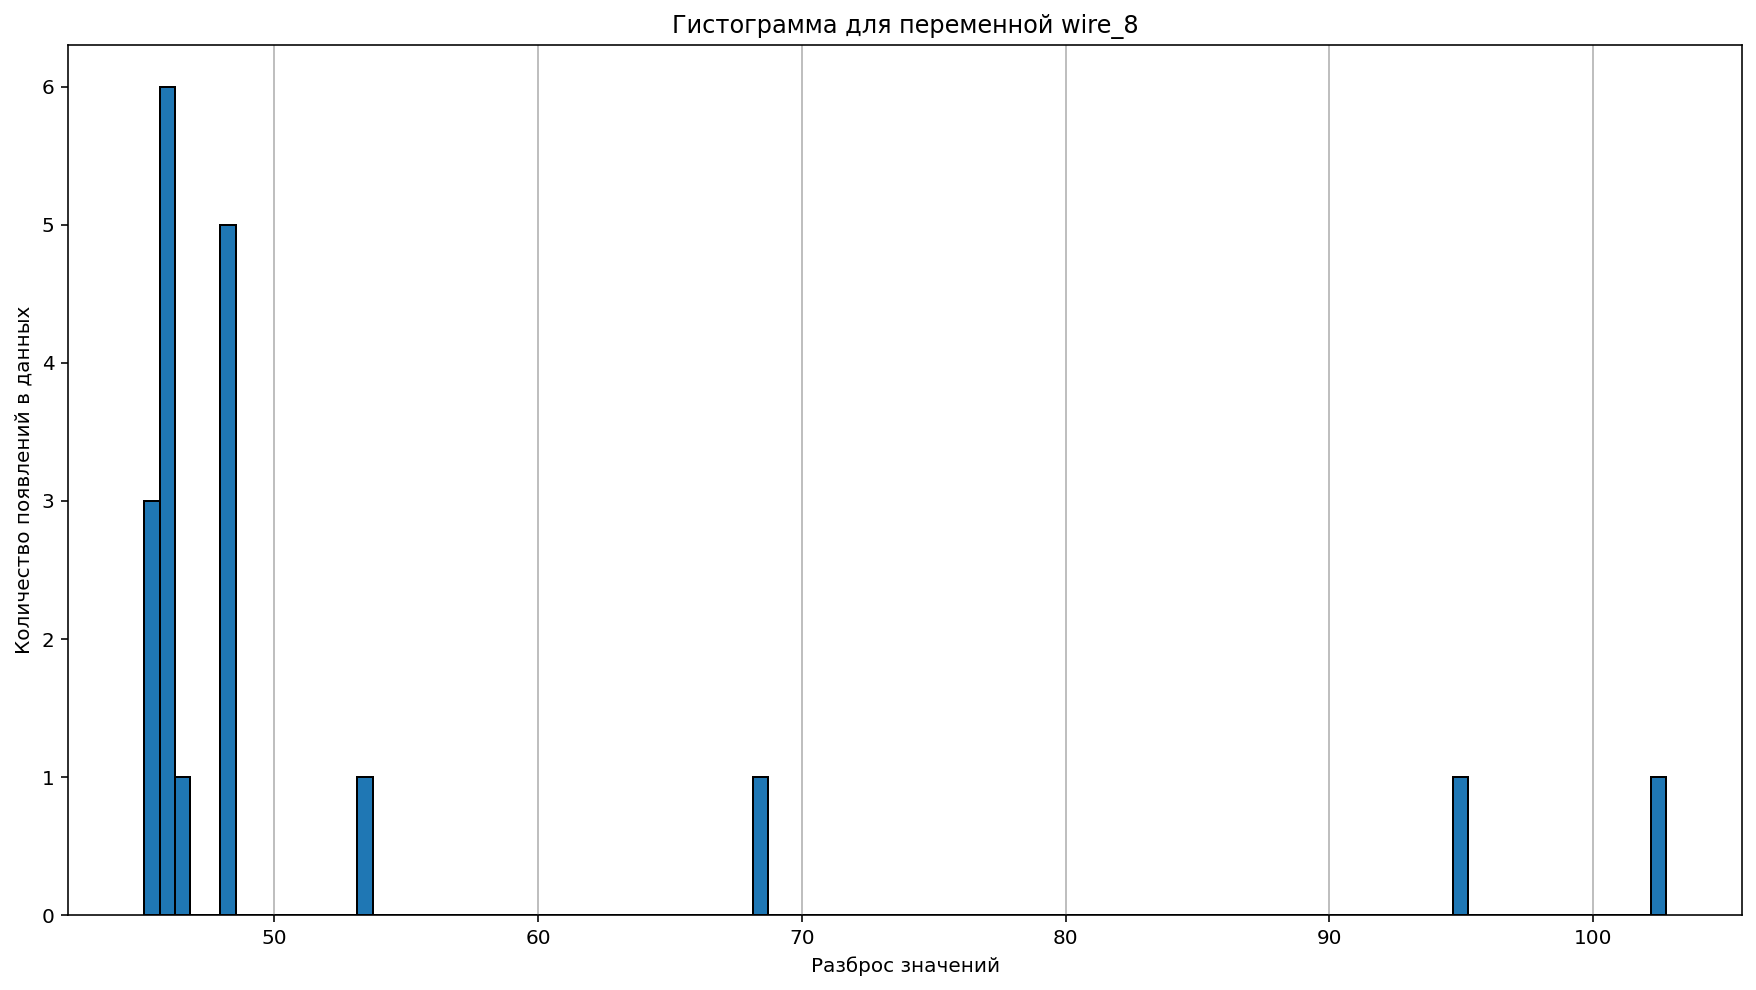

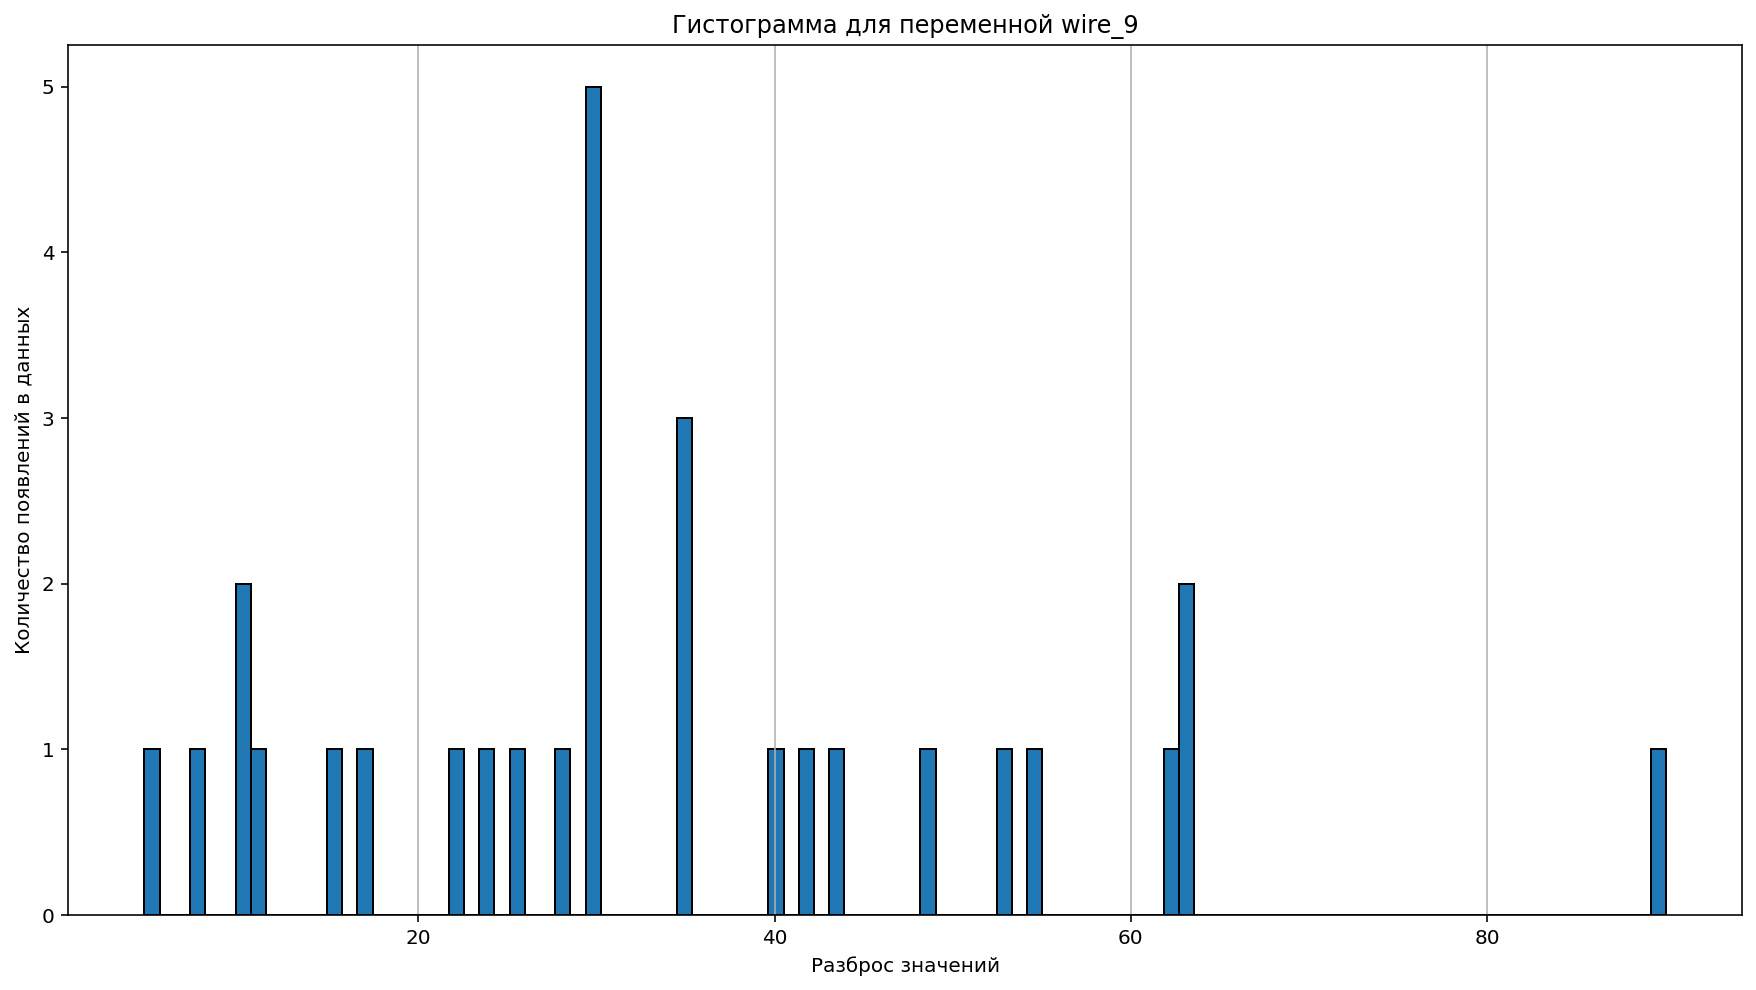

In [38]:
df_plot_hist(df_wire)


Корреляция:


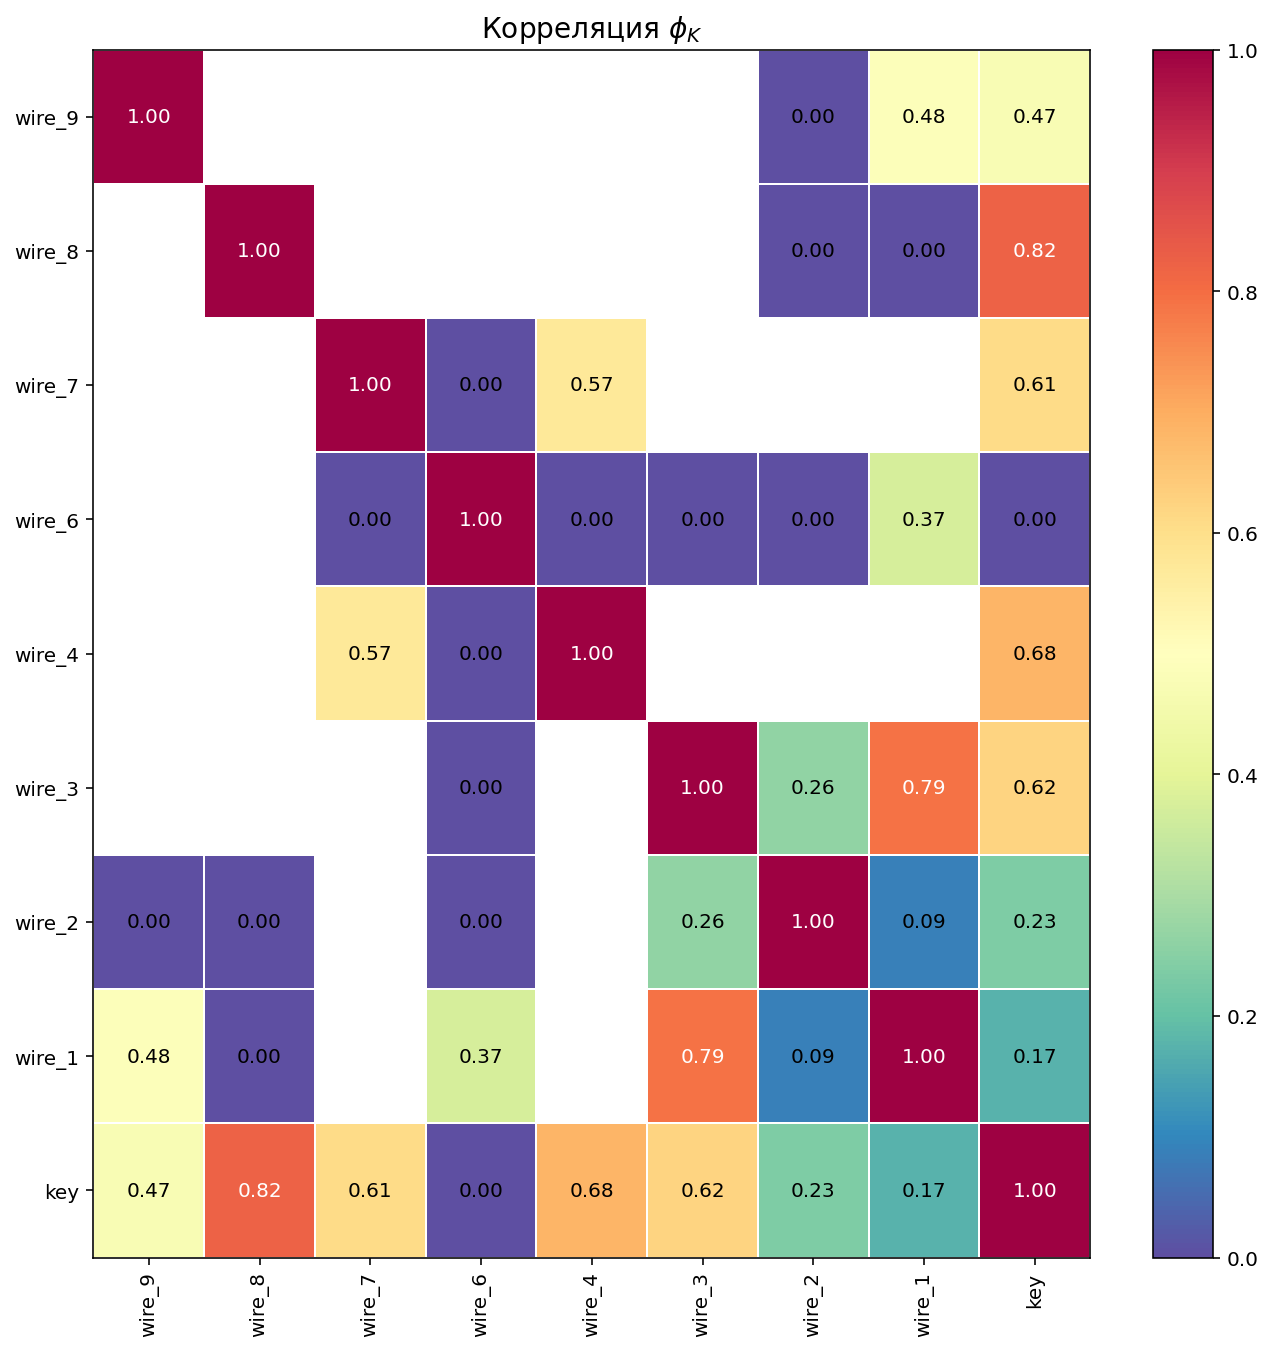

In [39]:
df_plot_corr(df_wire)

In [40]:
df_wire['key'].value_counts().head(10)

key
1       1
2226    1
2146    1
2147    1
2148    1
2149    1
2150    1
2151    1
2152    1
2153    1
Name: count, dtype: int64

**Вывод:**

- Данные распределены неравномерно, все столбцы, кроме key, wire_1 и wire_2 содержат очень мало данных, не поддающихся восстановлению;
- Распределение wire_1 похоже на нормальное, про wire_2 такого сказать нельзя, но в нём данных в 3 раза меньше;
- Все ключи уникальны.


# 1.7 Данные о проволочных материалах (время) - wire_time


In [41]:
df_fast_info(df_wire_time)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          3081 non-null   int64         
 1   wire_1_time  3055 non-null   datetime64[ns]
 2   wire_2_time  1079 non-null   datetime64[ns]
 3   wire_3_time  63 non-null     datetime64[ns]
 4   wire_4_time  14 non-null     datetime64[ns]
 5   wire_5_time  1 non-null      datetime64[ns]
 6   wire_6_time  73 non-null     datetime64[ns]
 7   wire_7_time  11 non-null     datetime64[ns]
 8   wire_8_time  19 non-null     datetime64[ns]
 9   wire_9_time  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB

Первые 3 строки датафрейма:


,key,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_5_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT



Полные дубликаты:


0


Описательные статистики:


,count,mean,min,25%,50%,75%,max,std
key,3081.0,1623.426485,1.0,823.0,1619.0,2434.0,3241.0,932.996726
wire_1_time,3055,2019-07-03 02:48:18.296235776,2019-05-03 11:11:41,2019-06-03 02:59:53.500000,2019-06-30 14:38:56,2019-08-03 22:58:26,2019-09-01 04:16:01,NaN
wire_2_time,1079,2019-07-04 03:36:02.886005504,2019-05-03 13:32:06,2019-06-03 21:52:38,2019-07-02 06:40:13,2019-08-04 13:10:39.500000,2019-08-31 18:50:15,NaN
wire_3_time,63,2019-07-07 13:45:31.634920704,2019-05-04 04:47:53,2019-06-09 14:51:42.500000,2019-07-17 21:35:47,2019-08-08 10:03:45,2019-08-28 02:11:18,NaN
wire_4_time,14,2019-07-08 10:06:53.999999744,2019-05-07 08:48:23,2019-07-17 08:17:59,2019-07-23 10:44:22.500000,2019-07-23 15:27:14.750000128,2019-08-08 12:03:12,NaN
wire_5_time,1,2019-08-08 16:01:07,2019-08-08 16:01:07,2019-08-08 16:01:07,2019-08-08 16:01:07,2019-08-08 16:01:07,2019-08-08 16:01:07,NaN
wire_6_time,73,2019-07-04 11:29:18.273972480,2019-05-07 08:37:20,2019-05-08 13:11:38,2019-07-24 03:28:47,2019-08-08 20:28:45,2019-08-14 00:59:11,NaN
wire_7_time,11,2019-08-02 18:36:35.818181632,2019-07-23 12:08:44,2019-07-23 19:31:31,2019-08-08 10:43:30,2019-08-08 12:43:10.500000,2019-08-08 18:27:34,NaN
wire_8_time,19,2019-06-21 00:52:37.894736896,2019-05-14 00:03:32,2019-05-14 02:36:03.500000,2019-05-14 05:14:25,2019-08-11 11:43:21.500000,2019-08-11 15:09:29,NaN
wire_9_time,29,2019-06-28 18:07:46.931034624,2019-05-04 16:09:11,2019-06-07 20:28:19,2019-06-09 10:26:00,2019-08-04 20:48:59,2019-08-29 03:51:31,NaN


,Кол-во уникальных значений,Доля пропусков
wire_5_time,1,0.999675
wire_7_time,11,0.996430
wire_4_time,14,0.995456
wire_8_time,19,0.993833
wire_9_time,29,0.990587
wire_3_time,63,0.979552
wire_6_time,73,0.976306
wire_2_time,1079,0.649789
wire_1_time,3055,0.008439
key,3081,0.000000



Гистограммы:


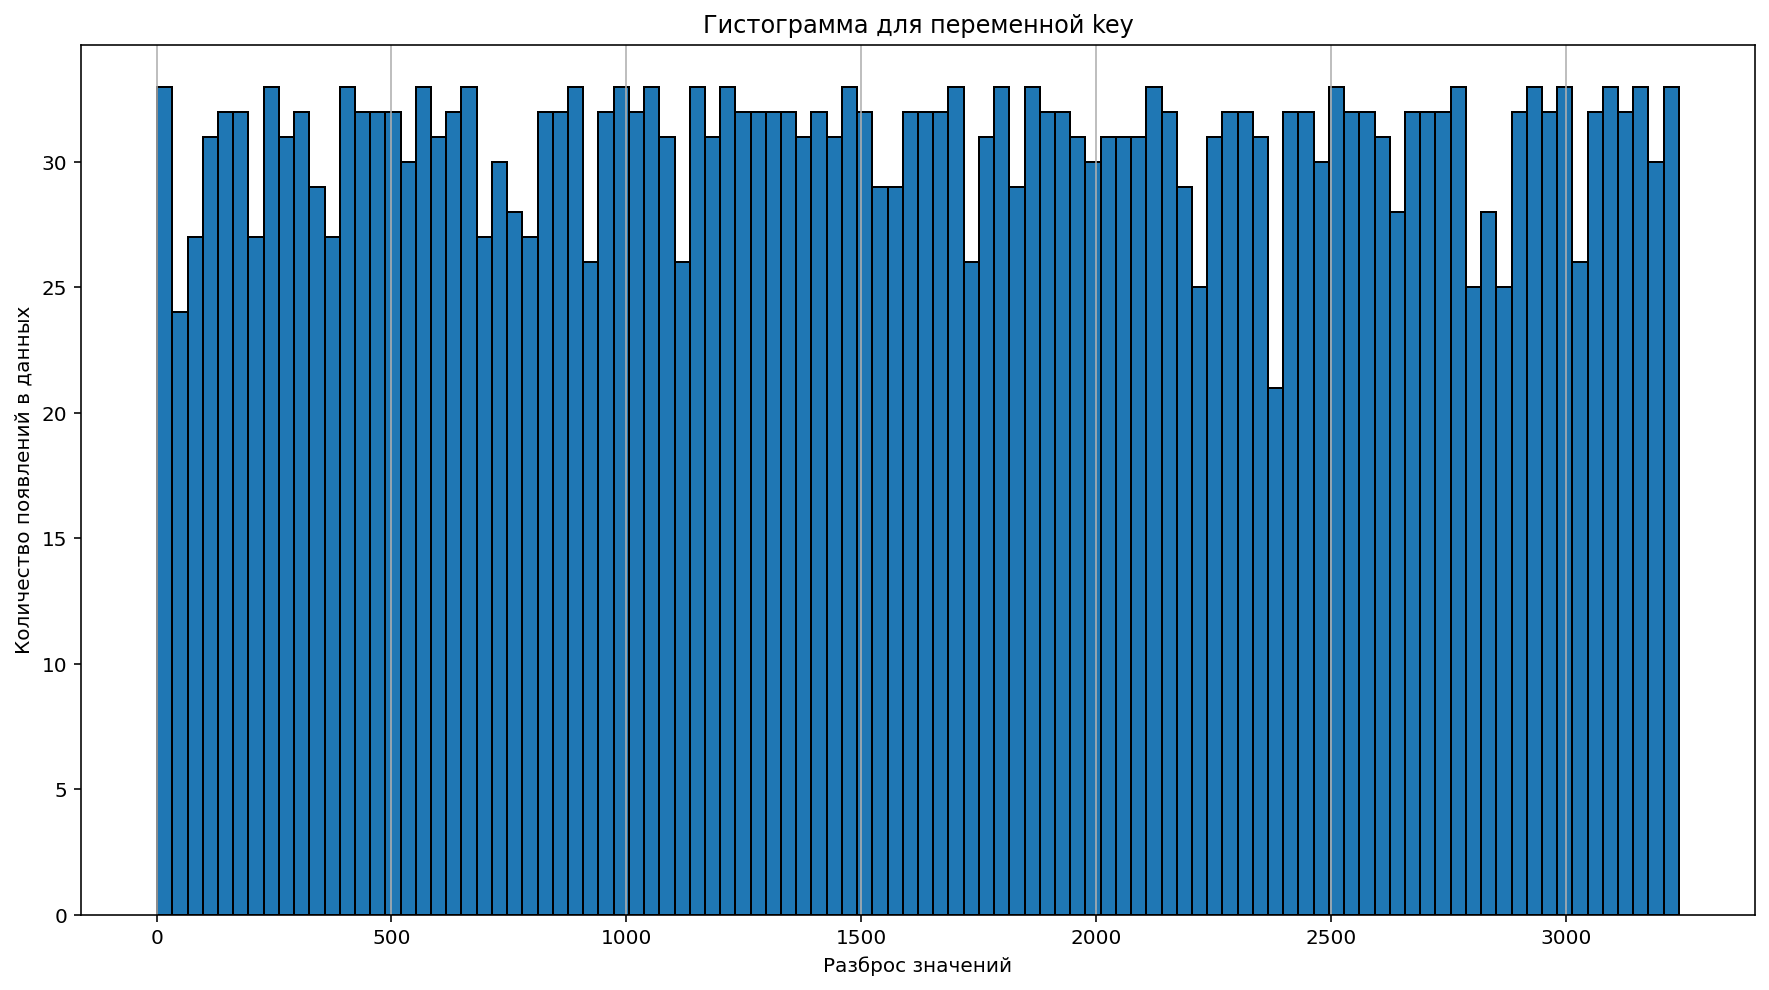

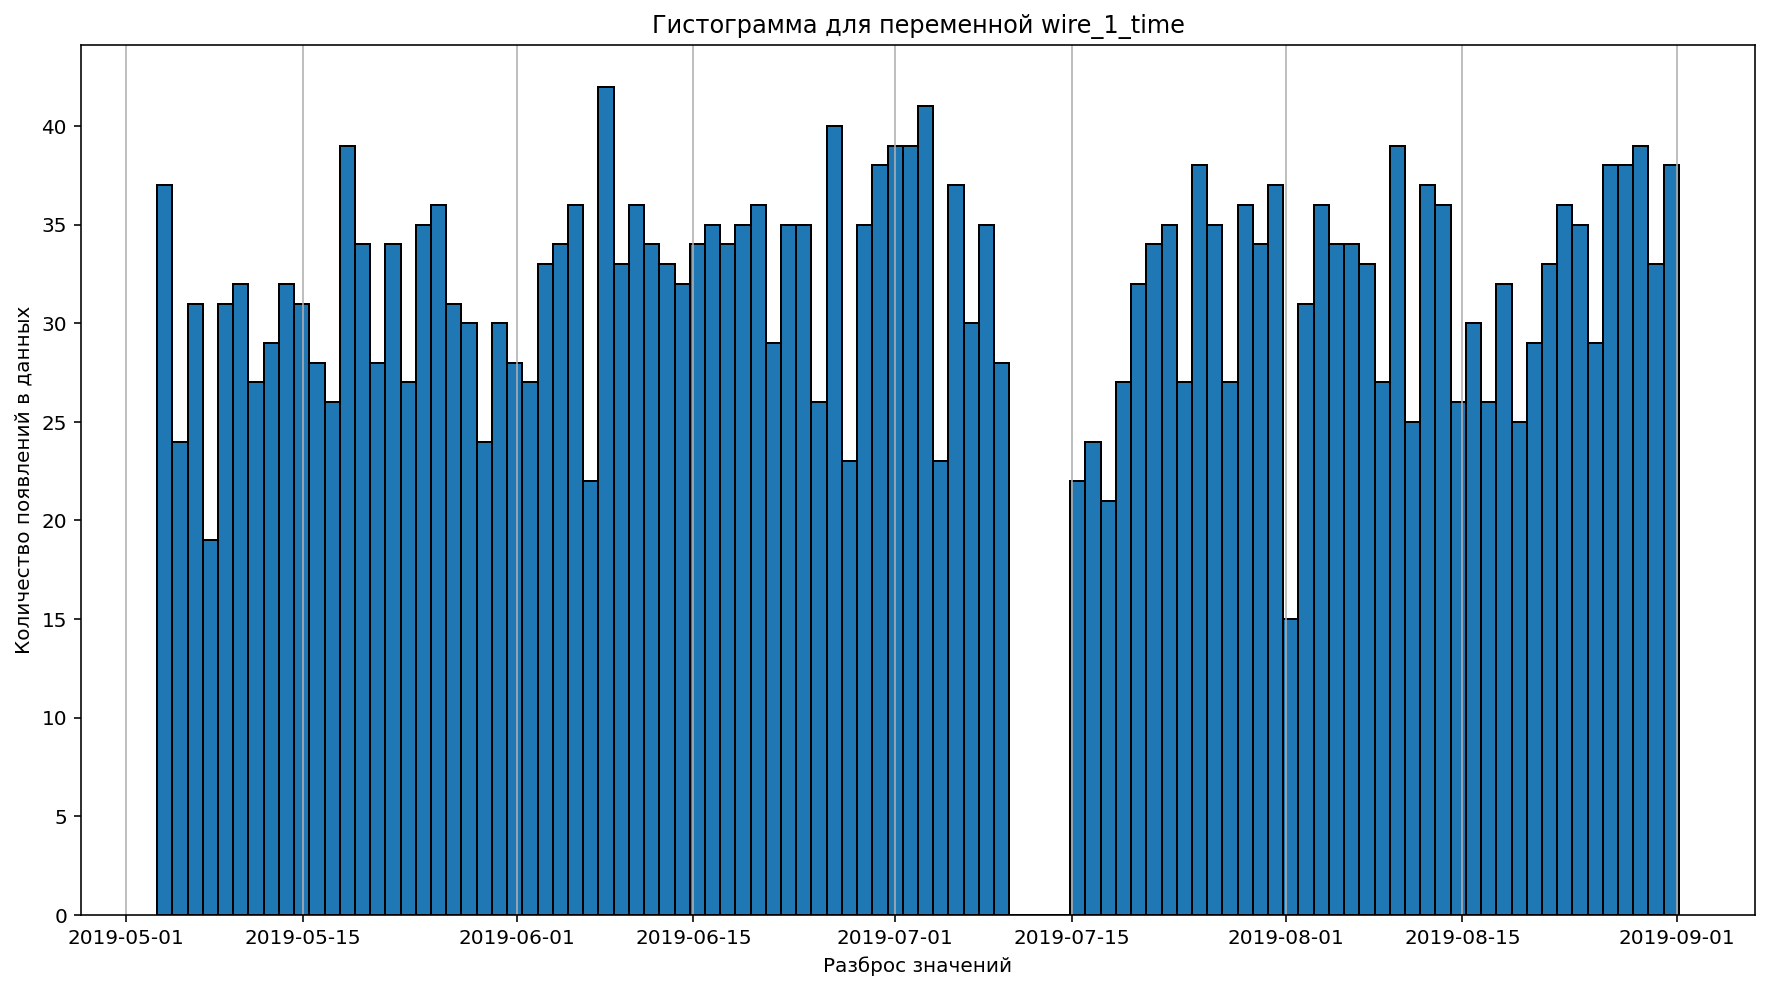

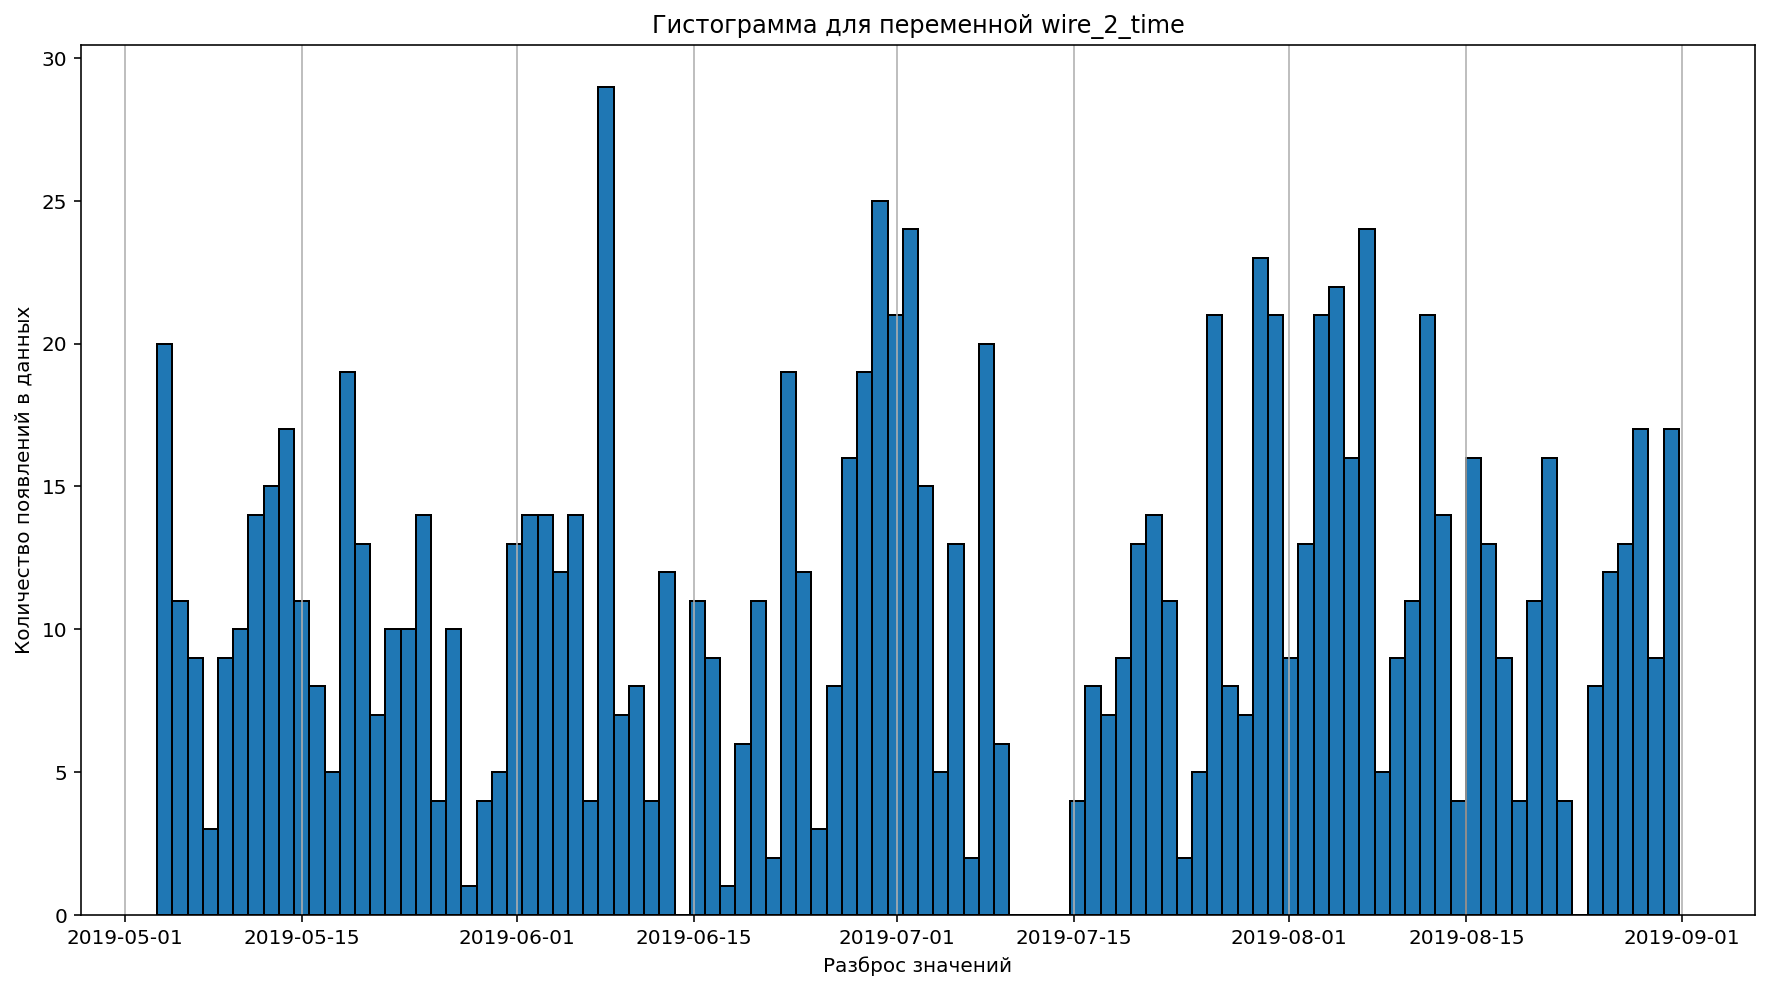

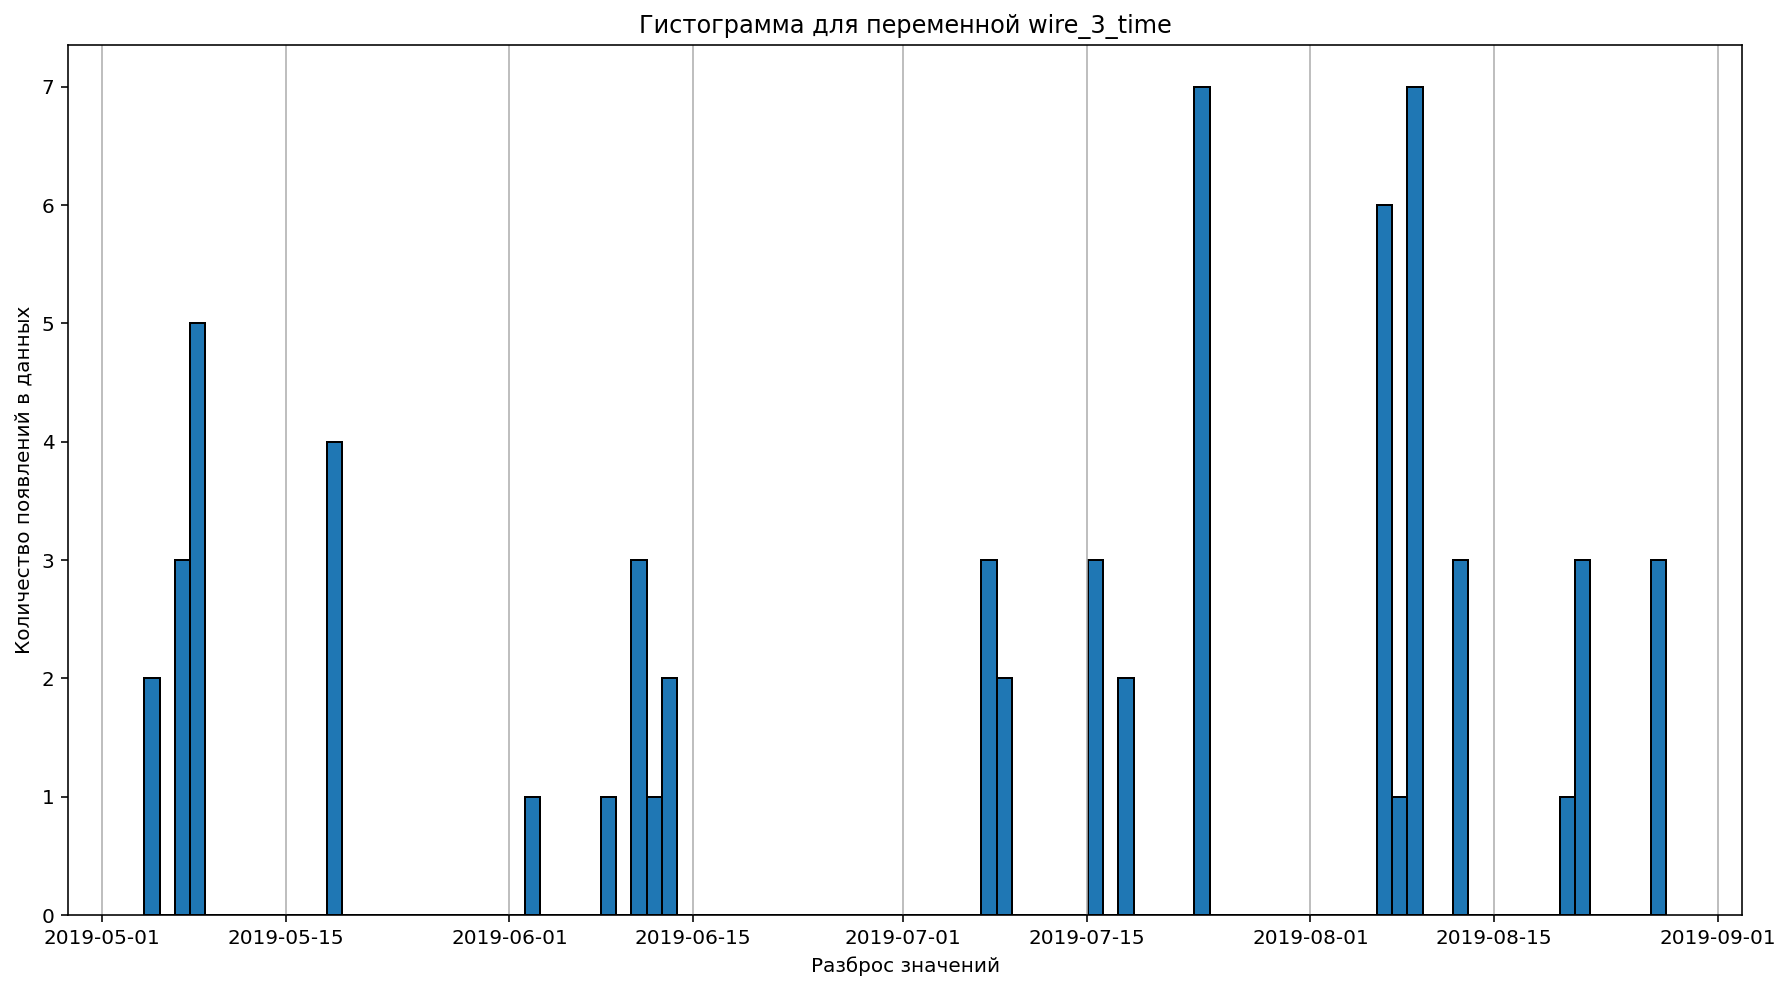

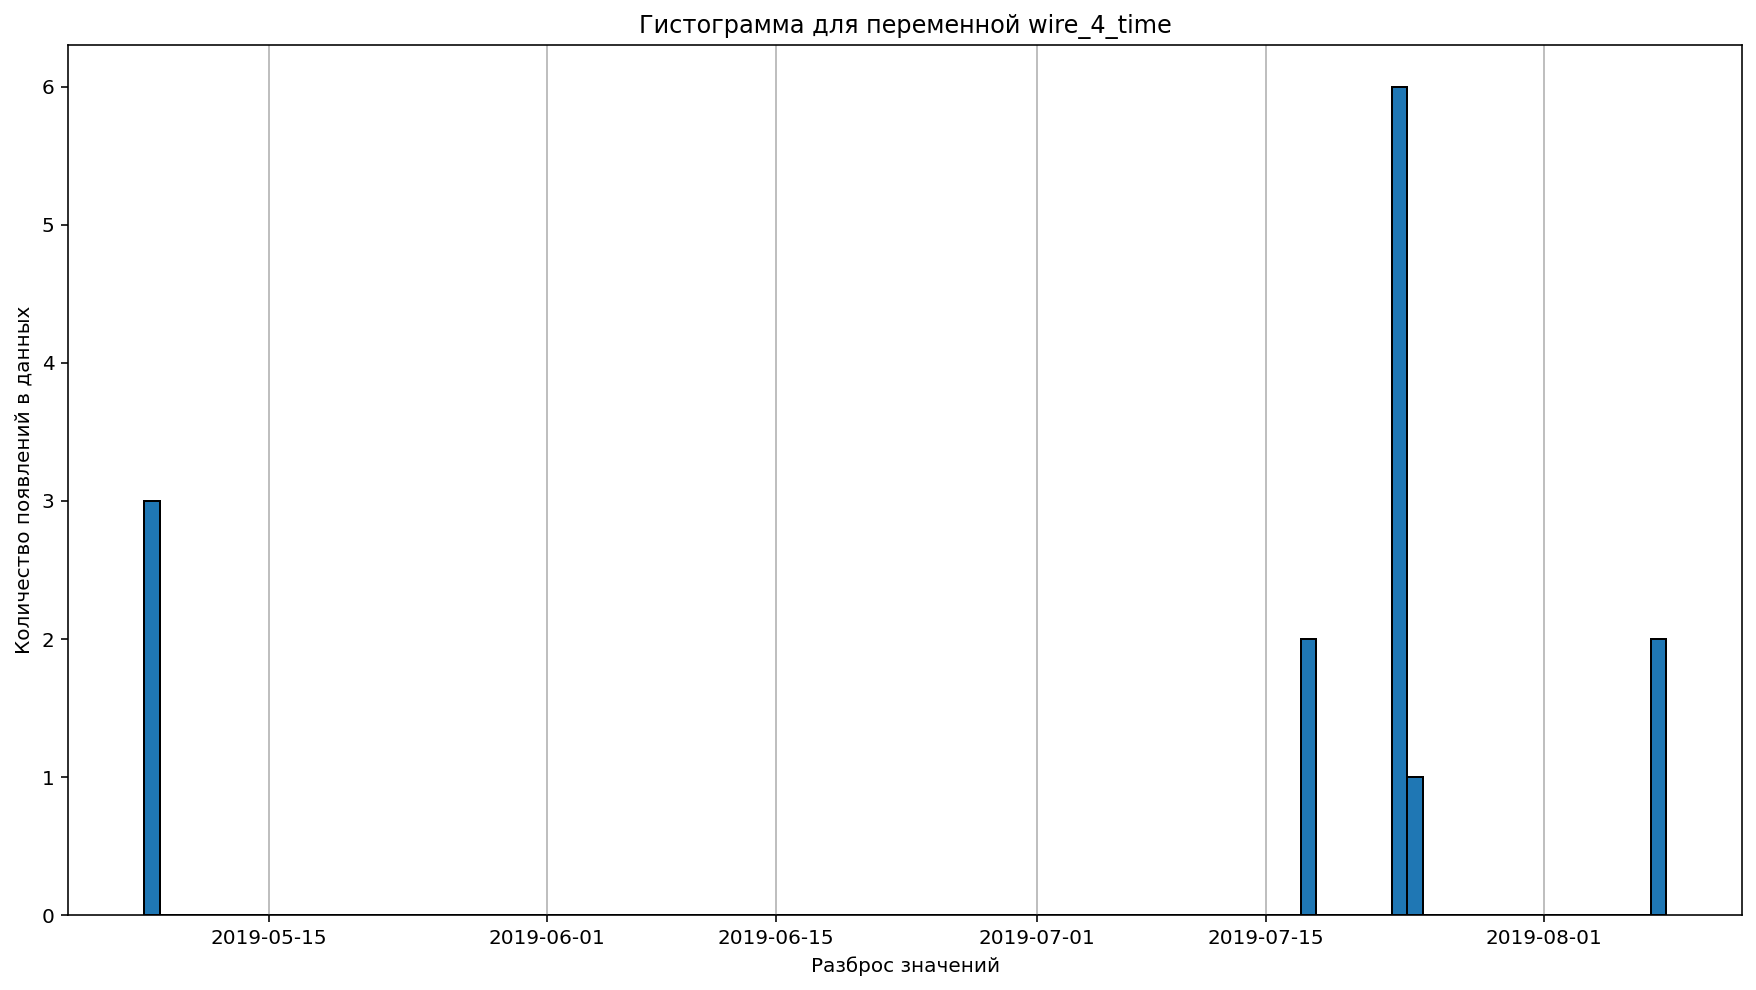

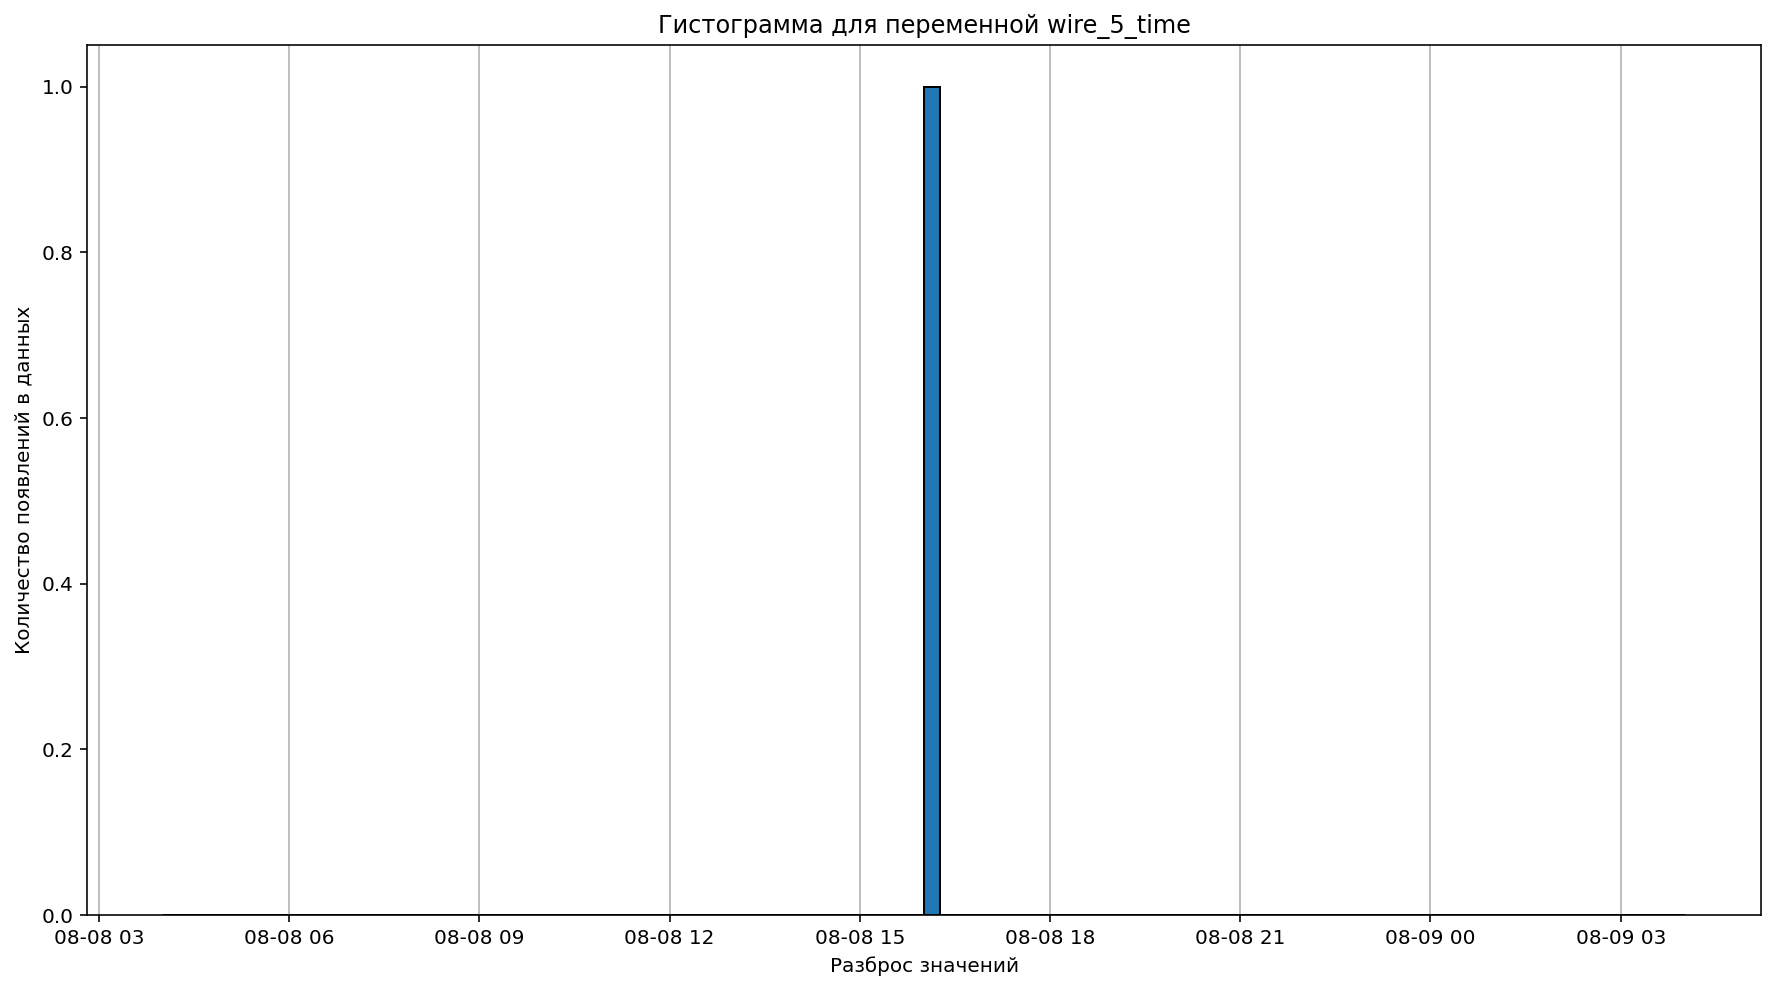

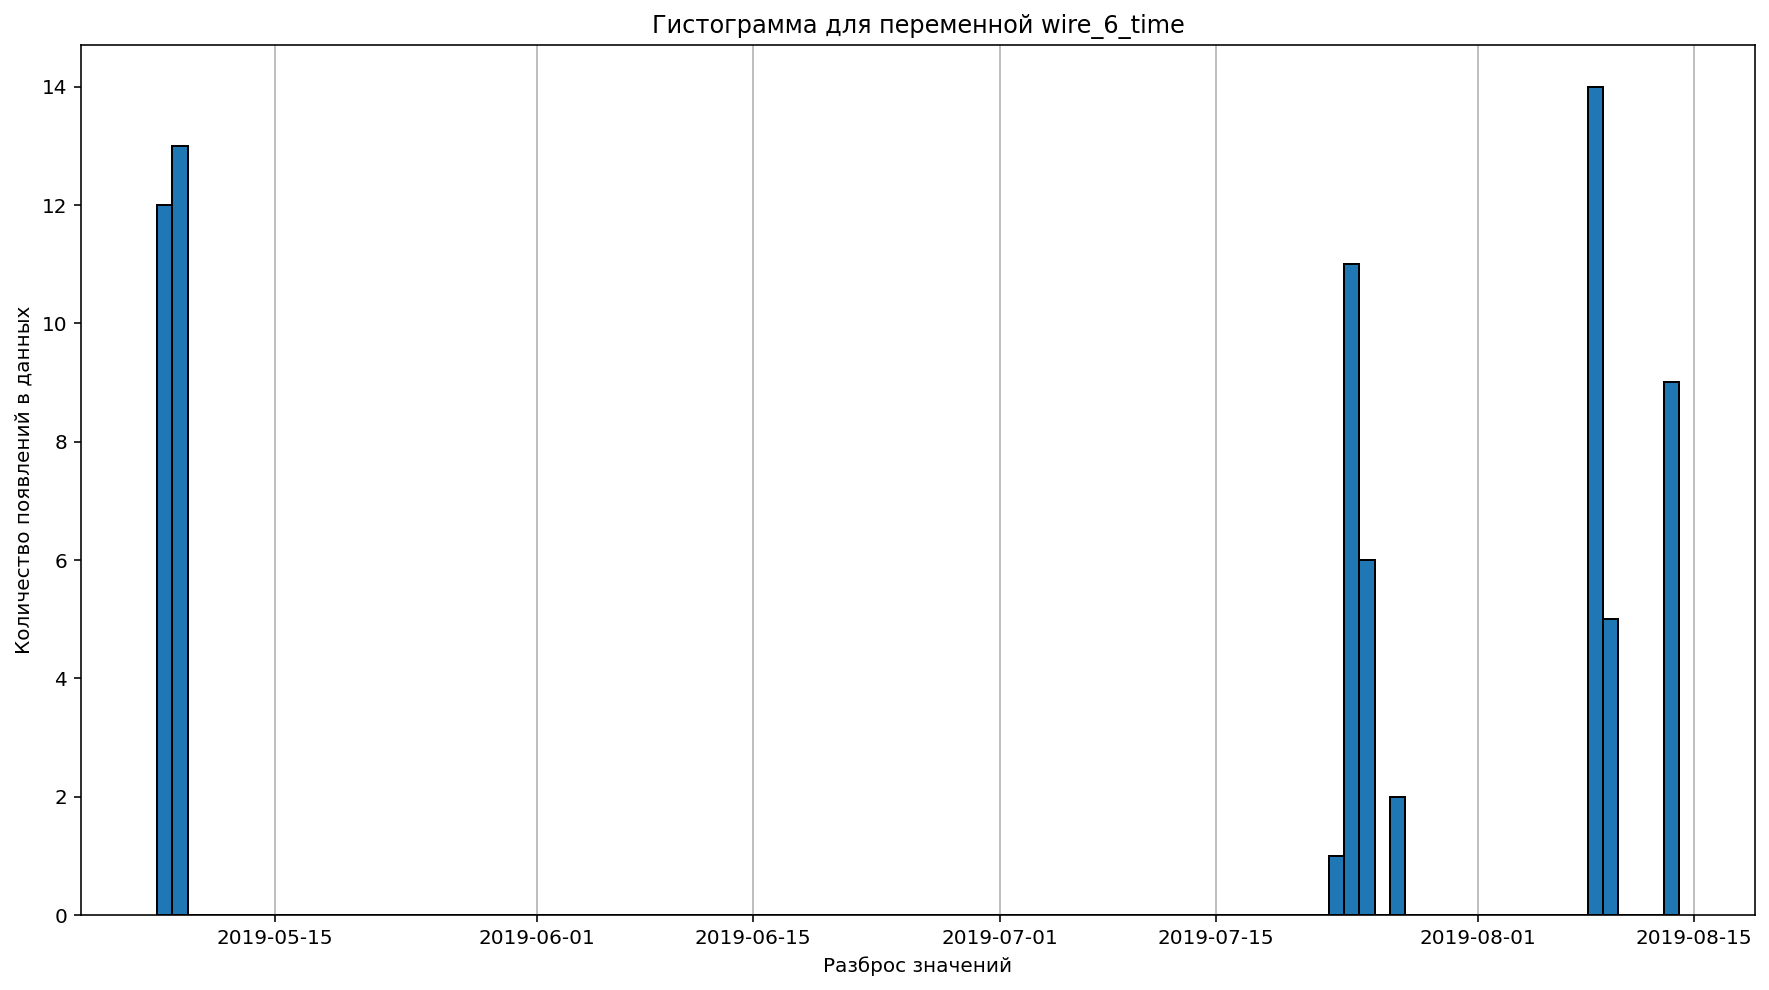

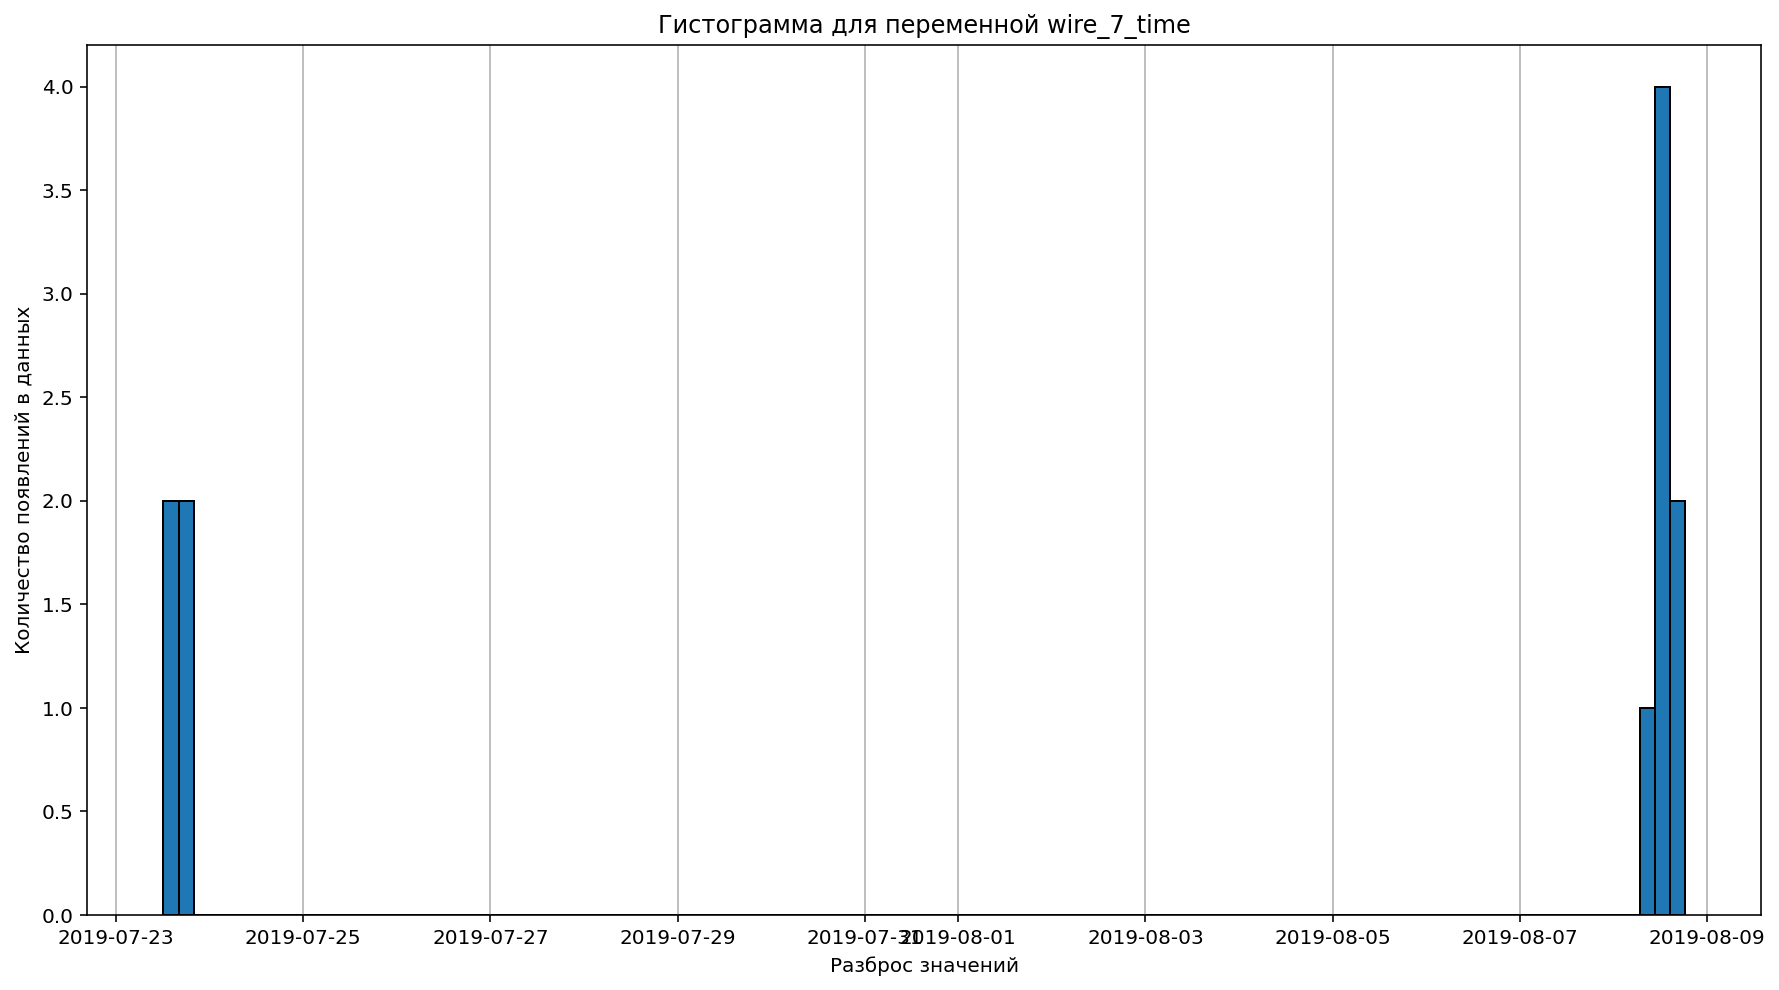

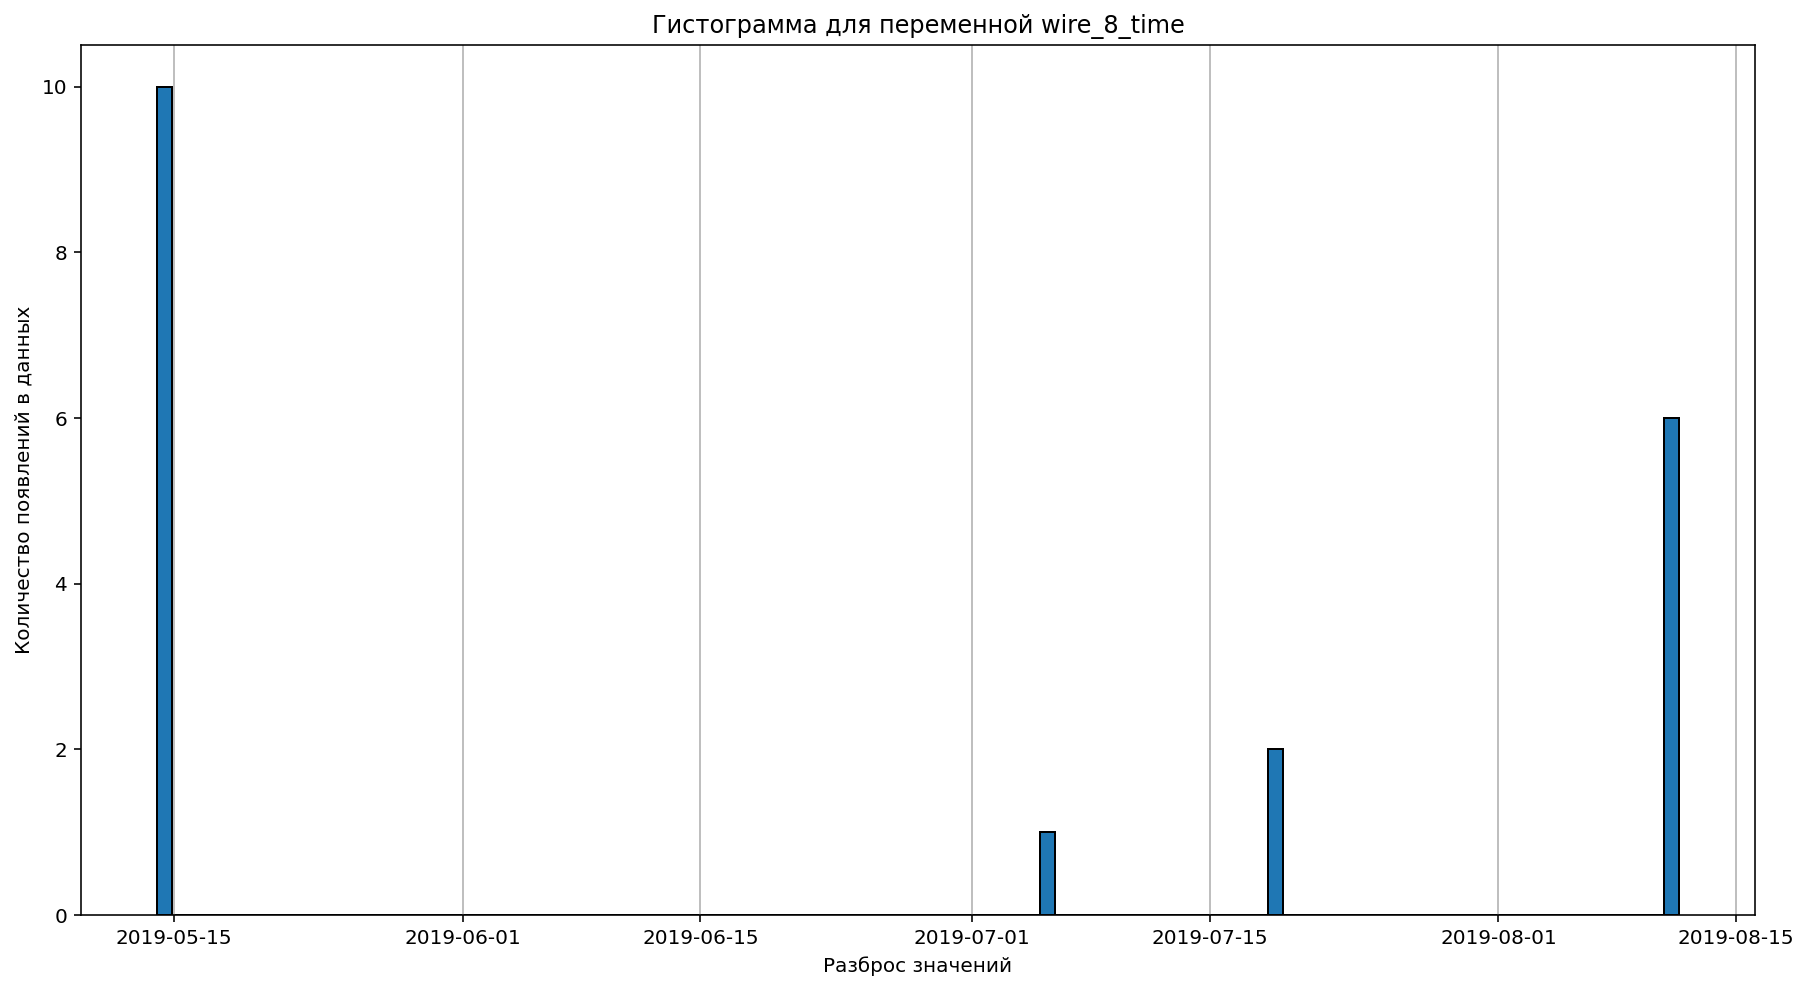

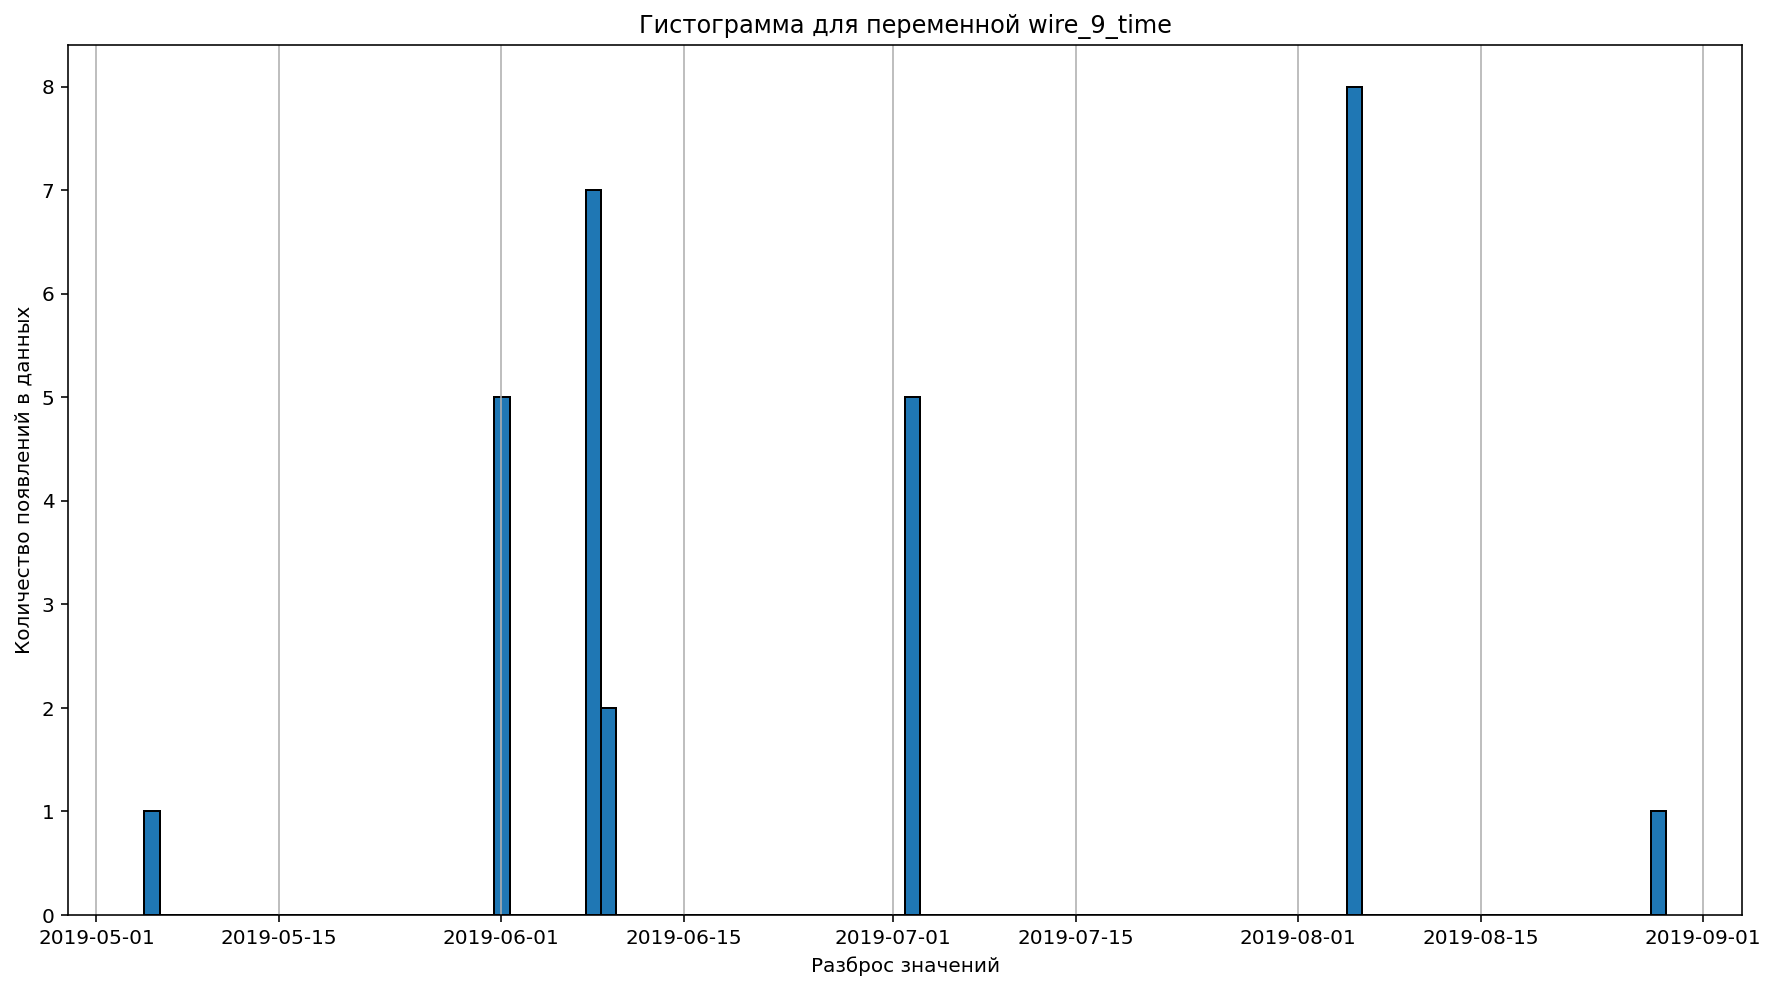

In [42]:
df_plot_hist(df_wire_time)

In [43]:
df_wire_time['key'].value_counts().head(10)

key
1       1
2226    1
2146    1
2147    1
2148    1
2149    1
2150    1
2151    1
2152    1
2153    1
Name: count, dtype: int64

Вывод:

- Данные распределены неравномерно, пропуски аналогичны df_wire;
- Все ключи уникальны.


# 1.8 Выводы

Исходя из проведённого исследовательского анализа данных можно прийти к следующим результатам:

- Значения ключа появляются во всех данных и являются для них связующим элементом;
- В основном в данных преобладают логнормальные и нормальные распределения величин;
- Полных дубликатов нет, а вот аномальные значения и пропуски имеются почти в каждом наборе данных;
- С точки зрения создания новых признаков самым полезным является df_arc;
- В df_arc и df_temp на один ключ может приходиться по несколько строк, поэтому на следующем этапе на этих данных нужно применять аггрегирующие функции;
- Наборы с данными, содержащие только ключи и даты(df_wire_time, df_bulk_time), можно исключить из расчёта ввиду их неинформативности и большого количества пропусков;
- Также в df_bulk и df_wire лишь несколько столбцов являются информативными и содержат достаточное количество данных для использования в моделях;
- Данные представлены с мая по сентябрь 2019 года, причём во во всех данных не хватает периода с 11 по 13 число 07.2019;
- В данных о температуре имеются пропуски самих измерений а также не для всех партий указаны начальные и промежуточные температуры.


# 2.0 Подготовка данных к обучению


Из данных по температуре выделим для каждого ключа дату и значение первого и последнего измерения.


In [44]:
df = (
    df_temp.groupby('key')
    .apply(lambda x: x.loc[[x['measure_time'].idxmin(),
                            x['measure_time'].idxmax()]])
    .reset_index(drop=True)
).copy()
df

,key,measure_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:30:39,1613.0
2,2,2019-05-03 11:37:27,1581.0
3,2,2019-05-03 11:59:12,1602.0
4,3,2019-05-03 12:13:17,1596.0
...,...,...,...
6427,3239,2019-09-01 02:24:15,NaN
6428,3240,2019-09-01 02:39:01,1617.0
6429,3240,2019-09-01 03:35:16,NaN
6430,3241,2019-09-01 04:03:30,1586.0


Отсеим партии с некорректными данными - в которых температура на начальном этапе меньше 1500 градусов или те партии, в которых не производились конечные замеры температуры.


In [45]:
mask_1 = df.key.isin(
    df[(df.index % 2 == 0) & (df['temperature'] <= 1500)]['key'])
mask_2 = df.key.isin(df[df.temperature.isna()]['key'])
df = df[~(mask_1 | mask_2)]
df

,key,measure_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:30:39,1613.0
2,2,2019-05-03 11:37:27,1581.0
3,2,2019-05-03 11:59:12,1602.0
4,3,2019-05-03 12:13:17,1596.0
...,...,...,...
4949,2497,2019-08-06 01:53:50,1589.0
4950,2498,2019-08-06 02:03:49,1591.0
4951,2498,2019-08-06 02:25:31,1594.0
4952,2499,2019-08-06 02:40:25,1569.0


На базе этого создадим новый фрейм данных, чтобы значение ключа в нём встречалось в единственном экземпляре и для каждой партии были начальная и конечная температура, а также общая длительность измерений.


In [46]:
dt = df.loc[::2, ['key', 'temperature']].reset_index(drop=True)
dt['end_temp'] = df.loc[1::2, 'temperature'].values
dt['process_duration'] = df.measure_time.diff().dt.total_seconds()[1::2].values
dt = dt.rename({'temperature': 'start_temp'}, axis=1)
dt

,key,start_temp,end_temp,process_duration
0,1,1571.0,1613.0,861.0
1,2,1581.0,1602.0,1305.0
2,3,1596.0,1599.0,1300.0
3,4,1601.0,1625.0,388.0
4,5,1576.0,1602.0,762.0
...,...,...,...,...
2468,2495,1570.0,1591.0,1137.0
2469,2496,1554.0,1591.0,1618.0
2470,2497,1571.0,1589.0,717.0
2471,2498,1591.0,1594.0,1302.0


В наборе данных df_arc из разницы длительности процесса и полной электрической мощности можно посчитать суммарную работу для каждой партии и количество использований электродов.


In [47]:
df_arc['arc_heating_duration'] = (df_arc['arc_heating_end_time'] - 
                                   df_arc['arc_heating_start_time']
                                   ).dt.total_seconds()
df_arc['full_power'] = np.sqrt(df_arc['active_power'] ** 2 + 
                               df_arc['reactive_power'] ** 2)
df_arc['heat_work'] = df_arc['arc_heating_duration'] * df_arc['full_power']
dt_arc = df_arc[['key', 'heat_work']].groupby(by='key').agg(
    total_heat_work=('heat_work', 'sum'),
    arc_heating_count=('heat_work', 'count')).reset_index()
dt_arc

,key,total_heat_work,arc_heating_count
0,1,1442.377754,5
1,2,881.233565,4
2,3,525.066777,5
3,4,796.911309,4
4,5,1199.137958,4
...,...,...,...
3209,3237,958.336236,5
3210,3238,555.867370,3
3211,3239,1013.067719,8
3212,3240,729.208940,5


Также добавим в качестве дополнительных признаков колонки с количеством используемых за партию присадок и добавок.


In [48]:
df_bulk['total_bulk_used'] = (~df_bulk.iloc[:, 1:].isna()).sum(axis=1)
df_wire['total_wire_used'] = (~df_wire.iloc[:, 1:].isna()).sum(axis=1)

In [49]:
dt = dt.merge(dt_arc, how='inner', on='key')
dt = dt.merge(df_gas, how='inner', on='key')
dt = dt.merge(df_bulk, how='inner', on='key')
dt = dt.merge(df_wire, how='inner', on='key')
dt

,key,start_temp,end_temp,process_duration,total_heat_work,arc_heating_count,gas,bulk_1,bulk_2,bulk_3,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,total_wire_used
0,1,1571.0,1613.0,861.0,1442.377754,5,29.749986,NaN,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2,1581.0,1602.0,1305.0,881.233565,4,12.555561,NaN,NaN,NaN,...,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,3,1596.0,1599.0,1300.0,525.066777,5,28.554793,NaN,NaN,NaN,...,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4,1601.0,1625.0,388.0,796.911309,4,18.841219,NaN,NaN,NaN,...,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,5,1576.0,1602.0,762.0,1199.137958,4,5.413692,NaN,NaN,NaN,...,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,1137.0,778.818234,4,7.125735,NaN,NaN,21.0,...,89.150879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2321,2496,1554.0,1591.0,1618.0,875.261419,6,9.412616,NaN,NaN,NaN,...,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2322,2497,1571.0,1589.0,717.0,556.930349,3,6.271699,NaN,NaN,NaN,...,94.086723,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2323,2498,1591.0,1594.0,1302.0,767.817794,5,14.953657,NaN,NaN,90.0,...,118.110717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


В полученном наборе данных проверим корреляции между признаками


In [50]:
dt.fillna(0).corr().where(lambda x: (abs(x) >= 0.6) & (abs(x) < 1)).stack()

bulk_2           bulk_7             0.679353
                 wire_4             0.699340
bulk_7           bulk_2             0.679353
                 wire_4             0.740570
bulk_9           wire_8             0.974968
bulk_12          bulk_15            0.614182
bulk_15          bulk_12            0.614182
                 total_bulk_used    0.633993
total_bulk_used  bulk_15            0.633993
wire_2           total_wire_used    0.633858
wire_4           bulk_2             0.699340
                 bulk_7             0.740570
                 wire_7             0.602964
wire_7           wire_4             0.602964
wire_8           bulk_9             0.974968
total_wire_used  wire_2             0.633858
dtype: float64

Удалению подлежат столбцы bulk_8 и wire_5, поскольку в них имеется лишь по 1 заполненному значению и информативность таких столбцов находится под вопросом. Также мы удалим столбцы wire_4 и bulk_9, поскольку корелляция между ними довольно высока и в них также мало значений. Bulk_7 уберём по аналогичной причине, но total_bulk_used и bulk_15 оставим, поскольку в них изначально было неплохое количество значений. Из остальных данных сформируем выборки в соотношении 75/25.


In [51]:
col_to_delete = ['bulk_5', 'bulk_7', 'bulk_8', 'bulk_9',
                 'wire_5', 'wire_4', 'end_temp']
X = dt.drop(col_to_delete, axis=1)
y = dt['end_temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                    random_state=SEED)

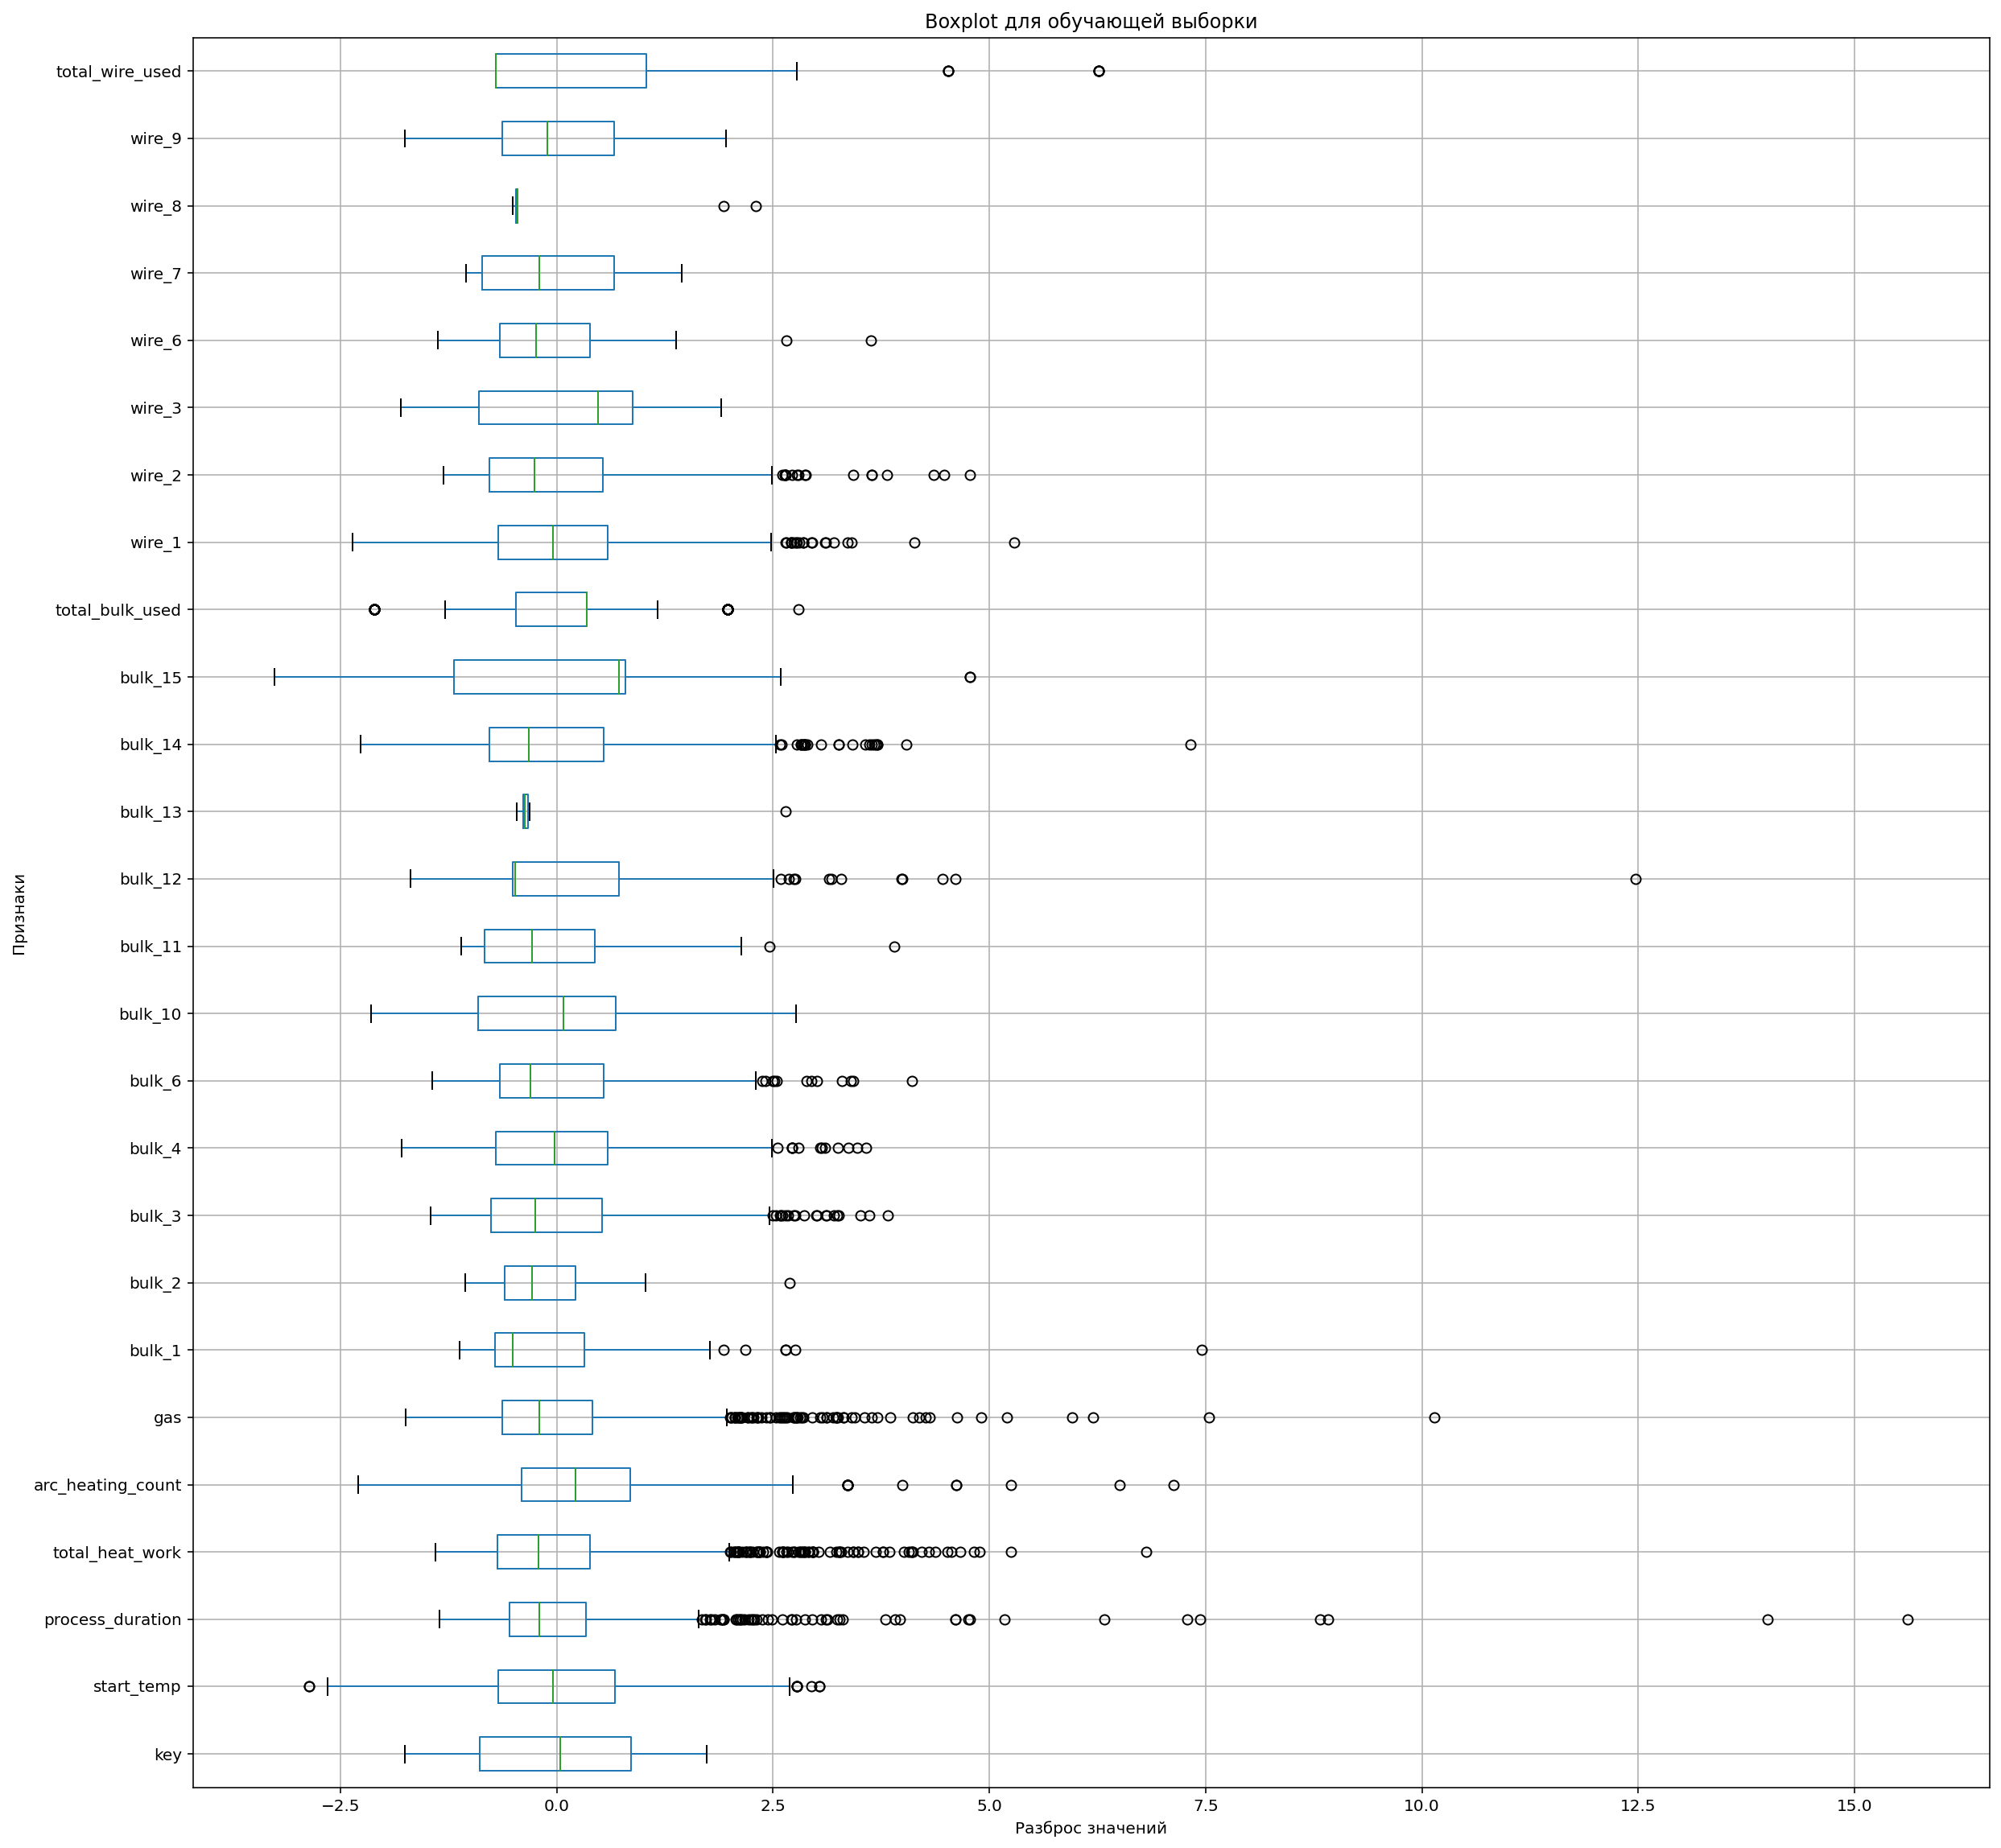

In [52]:
pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns).boxplot(figsize=(20, 20), vert=0)
plt.title('Boxplot для обучающей выборки')
plt.xlabel('Разброс значений')
plt.ylabel('Признаки');

Данная диаграмма показывает, сколько данных и в каких количествах может быть расценено как выброс и вредно для обучения. Поскольку данных не так много и их специфика не позволяет чётко разграничить аномальные значения от рядовых, то этот фрейм оставим без изменений перед моделированием.


Вывод:

- Данные собраны в один массив из разных источников;
- Исключены значения температуры ниже 1500 градусов, поскольку это не соответствует реальной физике процесса.
- Удалены часть столбцов с низкой вариативностью переменных, с высокими корелляциями с остальными столбцами, а также с большим количеством пропусков.
- В данных имеют место быть аномалии, однако они остались без изменений, поскольку окончательно нельзя установить являются ли они выбросами или нет.


# 3.0 Моделирование


Для удобства обучения моделей используем 2 функции model_optimizer и fit_best_model. Model_optimizer необходим для того, чтобы получить лучшие параметры модели на кросс-валидации с помощью Optuna. Эти данные вместе с названием модели подаются далее в fit_best_model, который подставляет их в модель и возвращает обученный пайплайн решения. В данных перед подачей в модель заполняются пропуски а также проводится их масштабирование через StandardScaler.


In [53]:
def model_optimizer(model_name):
    def objective(trial, model_name):
        if model_name == 'Lasso':
            alpha = trial.suggest_float('alpha', 1e-4, 1e4, log=True)
            model = Lasso(random_state=SEED, alpha=alpha)
        elif model_name == 'RandomForest':
            max_depth = trial.suggest_int('max_depth', 2, 30)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 5)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
            model = RandomForestRegressor(
                random_state=SEED, max_depth=max_depth, 
                min_samples_split=min_samples_split, 
                min_samples_leaf=min_samples_leaf)
        else:
            lr = trial.suggest_float('learning_rate', 1e-5, 0.1, log=True)
            depth = trial.suggest_int('max_depth', 2, 15)

            models = {
                'LightGBM': LGBMRegressor(learning_rate=lr, random_state=SEED, 
                                          verbose=0, force_col_wise=True),
                'XGBoost': XGBRegressor(learning_rate=lr, max_depth=depth,
                                        random_state=SEED, verbosity=0)}
            model = models.get(model_name)
        pipe = Pipeline(steps=[
            ('impute_miss', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaling', StandardScaler()),
            ('model', model)
        ])
        return np.abs(cross_val_score(pipe, X_train, y_train, cv=5,
                                      scoring='neg_mean_absolute_error').mean())

    study = optuna.create_study(direction='minimize')
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(lambda x: objective(x, model_name), n_trials=35, n_jobs=-1)
    return study


def fit_best_model(model_name, study_):
    if model_name == 'Lasso':
        model = Lasso(random_state=SEED, **study_.best_params)
    elif model_name == 'RandomForest':
        model = RandomForestRegressor(random_state=SEED, **study_.best_params)
    elif model_name == 'LightGBM':
        model = LGBMRegressor(random_seed=SEED, verbose=0, 
                              **study_.best_params, force_col_wise=True)
    elif model_name == 'XGBoost':
        model = XGBRegressor(random_state=SEED, verbosity=0, **study_.best_params)
    pipe = Pipeline(steps=[
            ('impute_miss', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaling', StandardScaler()),
            ('model', model)])
    return pipe.fit(X_train, y_train)


In [54]:
%%time
model_names = ['Lasso', 'XGBoost', 'LightGBM', 'RandomForest']
valid_models = []
for name in model_names:
    print(f'\nИсследуем модель {name}:\n')
    opt_result = model_optimizer(name)
    print(f'Лучший MSE модели на кросс-валидации = {opt_result.best_value: .5f}')
    print(f'Лучшие параметры модели: {opt_result.best_params}')
    if opt_result.best_value <= 6.8:
        valid_models.append([name, opt_result.best_value,
                             opt_result.best_params,
                             fit_best_model(name, opt_result)]) 

[I 2023-04-15 18:08:39,228] A new study created in memory with name: no-name-5526c0f0-9873-4a55-b602-fbd08ac31b66



Исследуем модель Lasso:

Лучший MSE модели на кросс-валидации =  5.91891
Лучшие параметры модели: {'alpha': 0.10367418041884255}

Исследуем модель XGBoost:

Лучший MSE модели на кросс-валидации =  5.77010
Лучшие параметры модели: {'learning_rate': 0.0896282224226522, 'max_depth': 7}

Исследуем модель LightGBM:

Лучший MSE модели на кросс-валидации =  5.86826
Лучшие параметры модели: {'learning_rate': 0.05911325713731855, 'max_depth': 12}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Модель CatBoost не будем подвергать оптимизации в силу того, что она долго обучается относительно остальных вариантов а также в силу того, что она способна выдать качественный результат без особого подбора гиперпараметров.


In [55]:
%%time
params = {'learning_rate': 0.01, 'depth': None,
          'random_seed': SEED, 'verbose': False}
model = CatBoostRegressor(**params)
pipe_cb = Pipeline(steps=[
            ('impute_miss', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaling', StandardScaler()),
            ('model', model)
])
cb_mae = np.abs(cross_val_score(pipe_cb, X_train, y_train, cv=5,
                                scoring='neg_mean_absolute_error').mean())
print('MSE модели на кросс-валидации =', cb_mae)
valid_models.append(['CatBoost', cb_mae, params, pipe_cb.fit(X_train, y_train)])

MSE модели на кросс-валидации = 5.824268631973057
CPU times: user 20.1 s, sys: 3.25 ms, total: 20.1 s
Wall time: 25.3 s


Строим графики важности признаков для каждой из полученных моделей


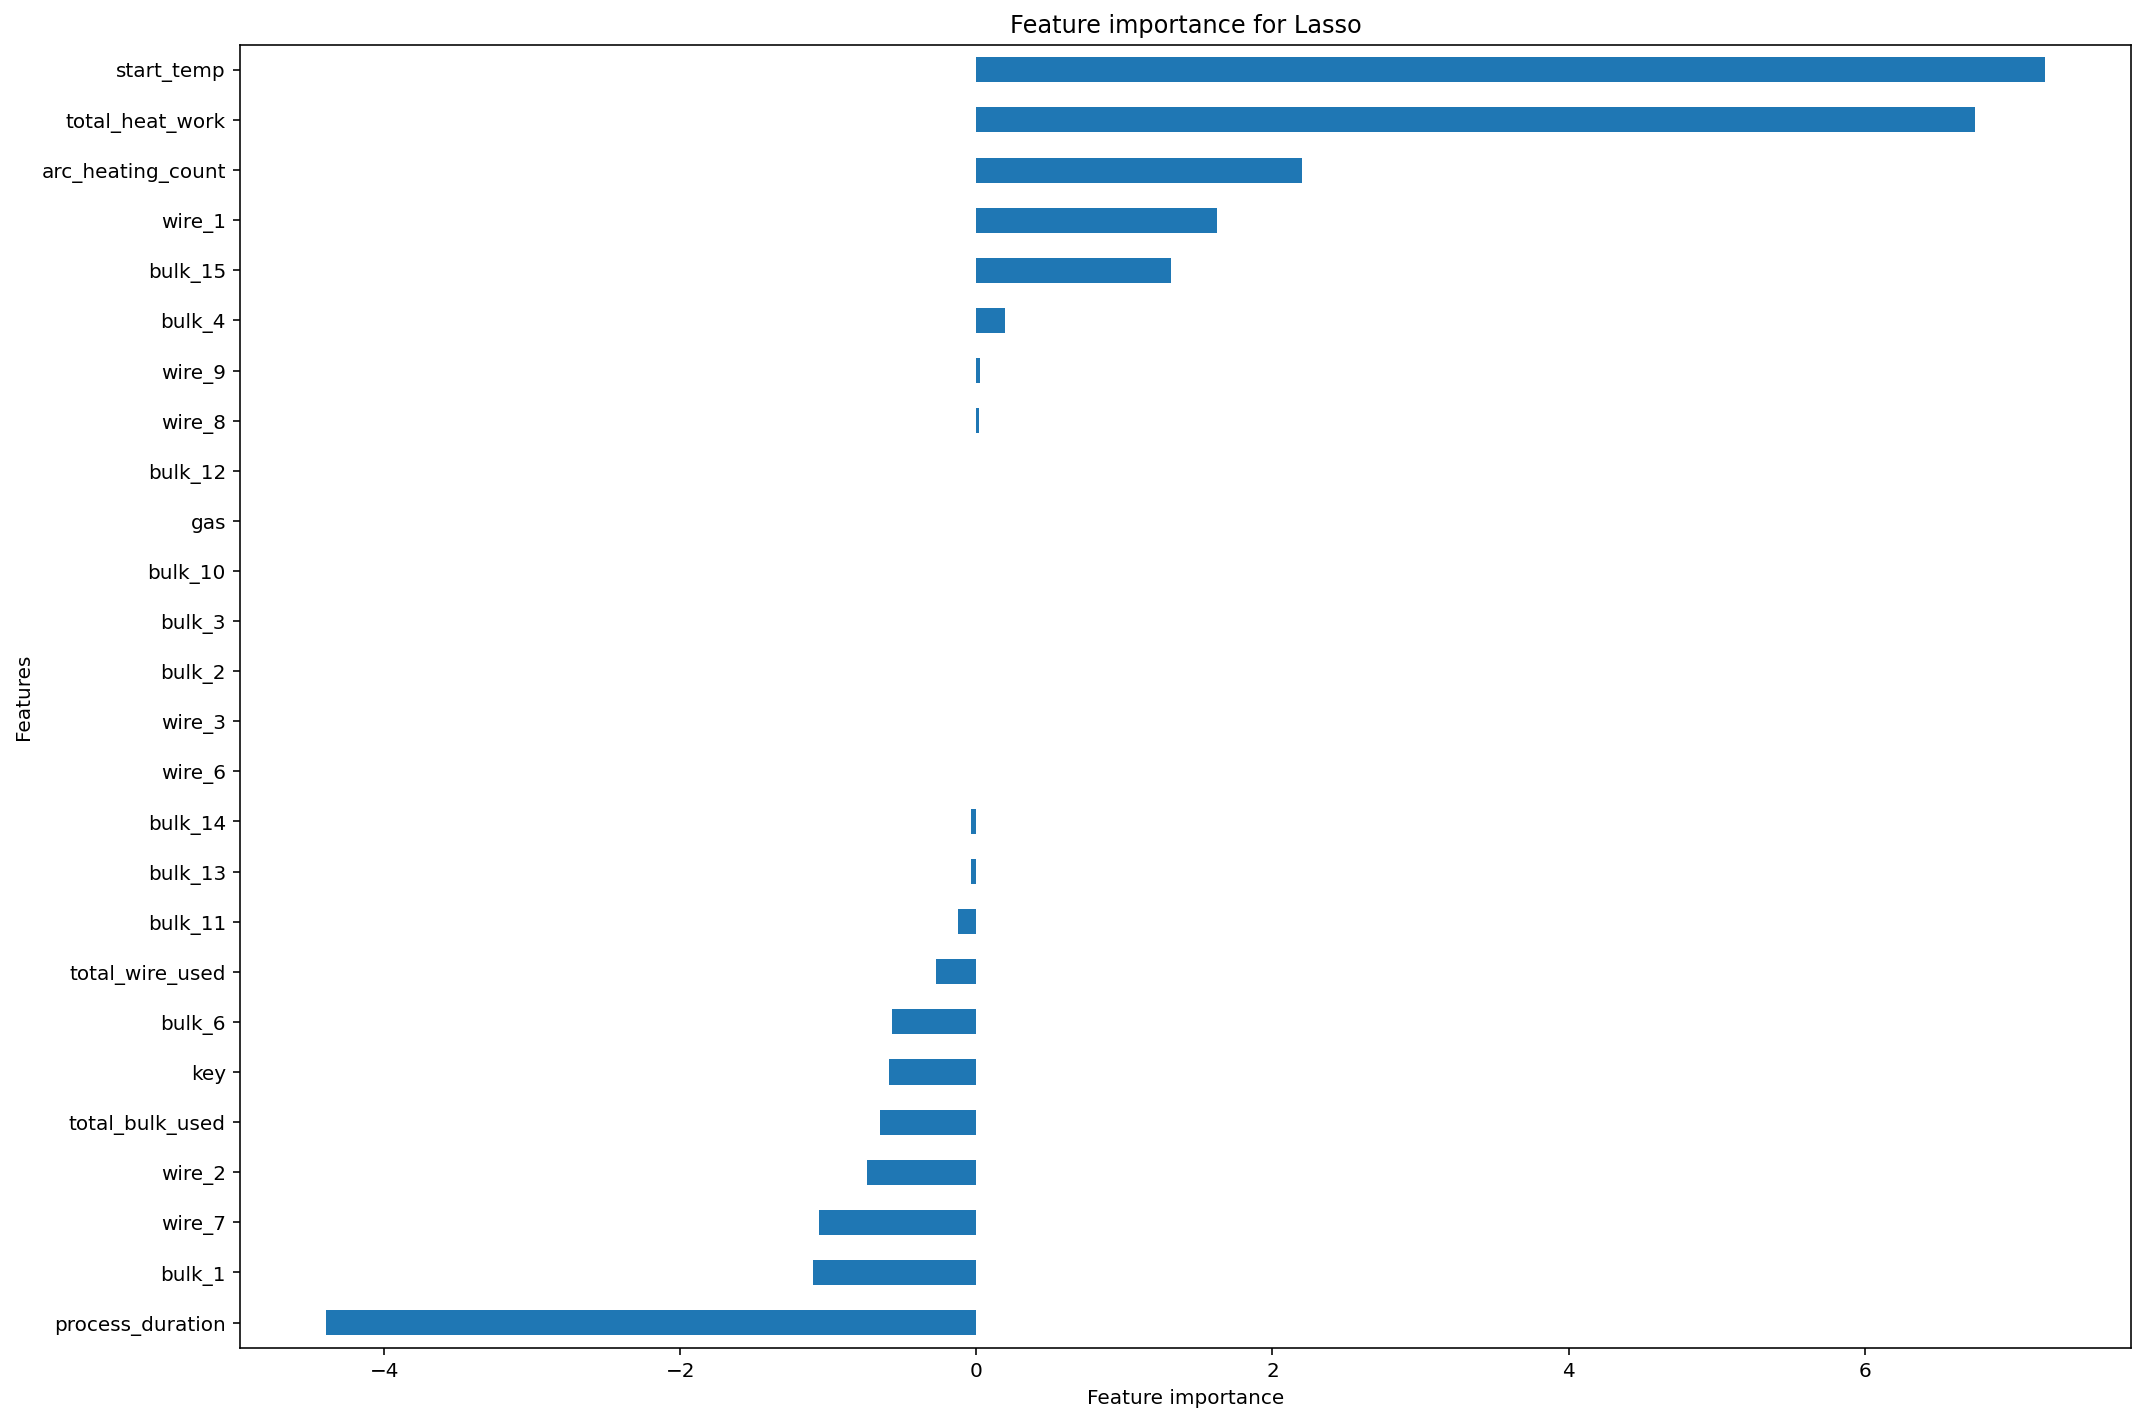

In [56]:
(pd.Series(valid_models[0][-1][-1].coef_,
           index=X_train.columns)
 .sort_values()
 .plot(kind='barh', figsize=(15, 10)))
plt.title('Feature importance for Lasso')
plt.xlabel('Feature importance')
plt.ylabel('Features')
plt.tight_layout()

Топ признаков: start_temp, total_heat_work, arc_heating_count, process_duration


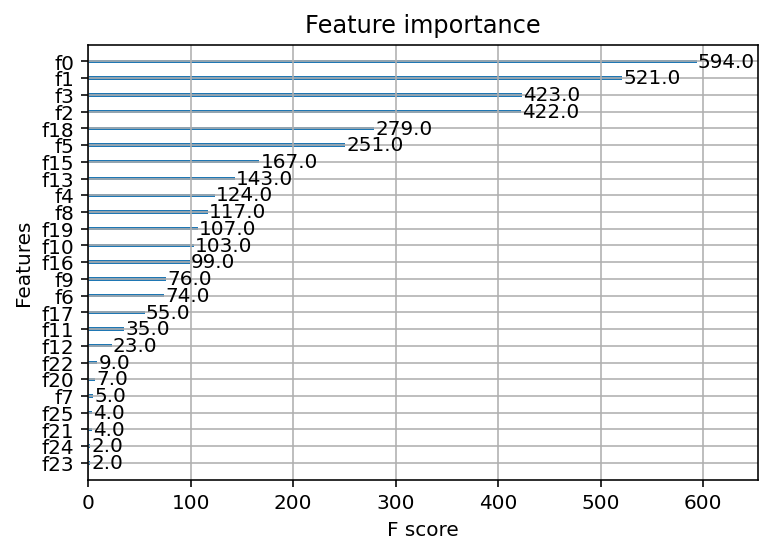

In [59]:
plot_importance(valid_models[1][-1][-1]);

Топ признаков: начальная температура, суммарная работа электродов, общая длительность нагрева за партию, номер партии, 1-ый проволочный материал, газ и т.д


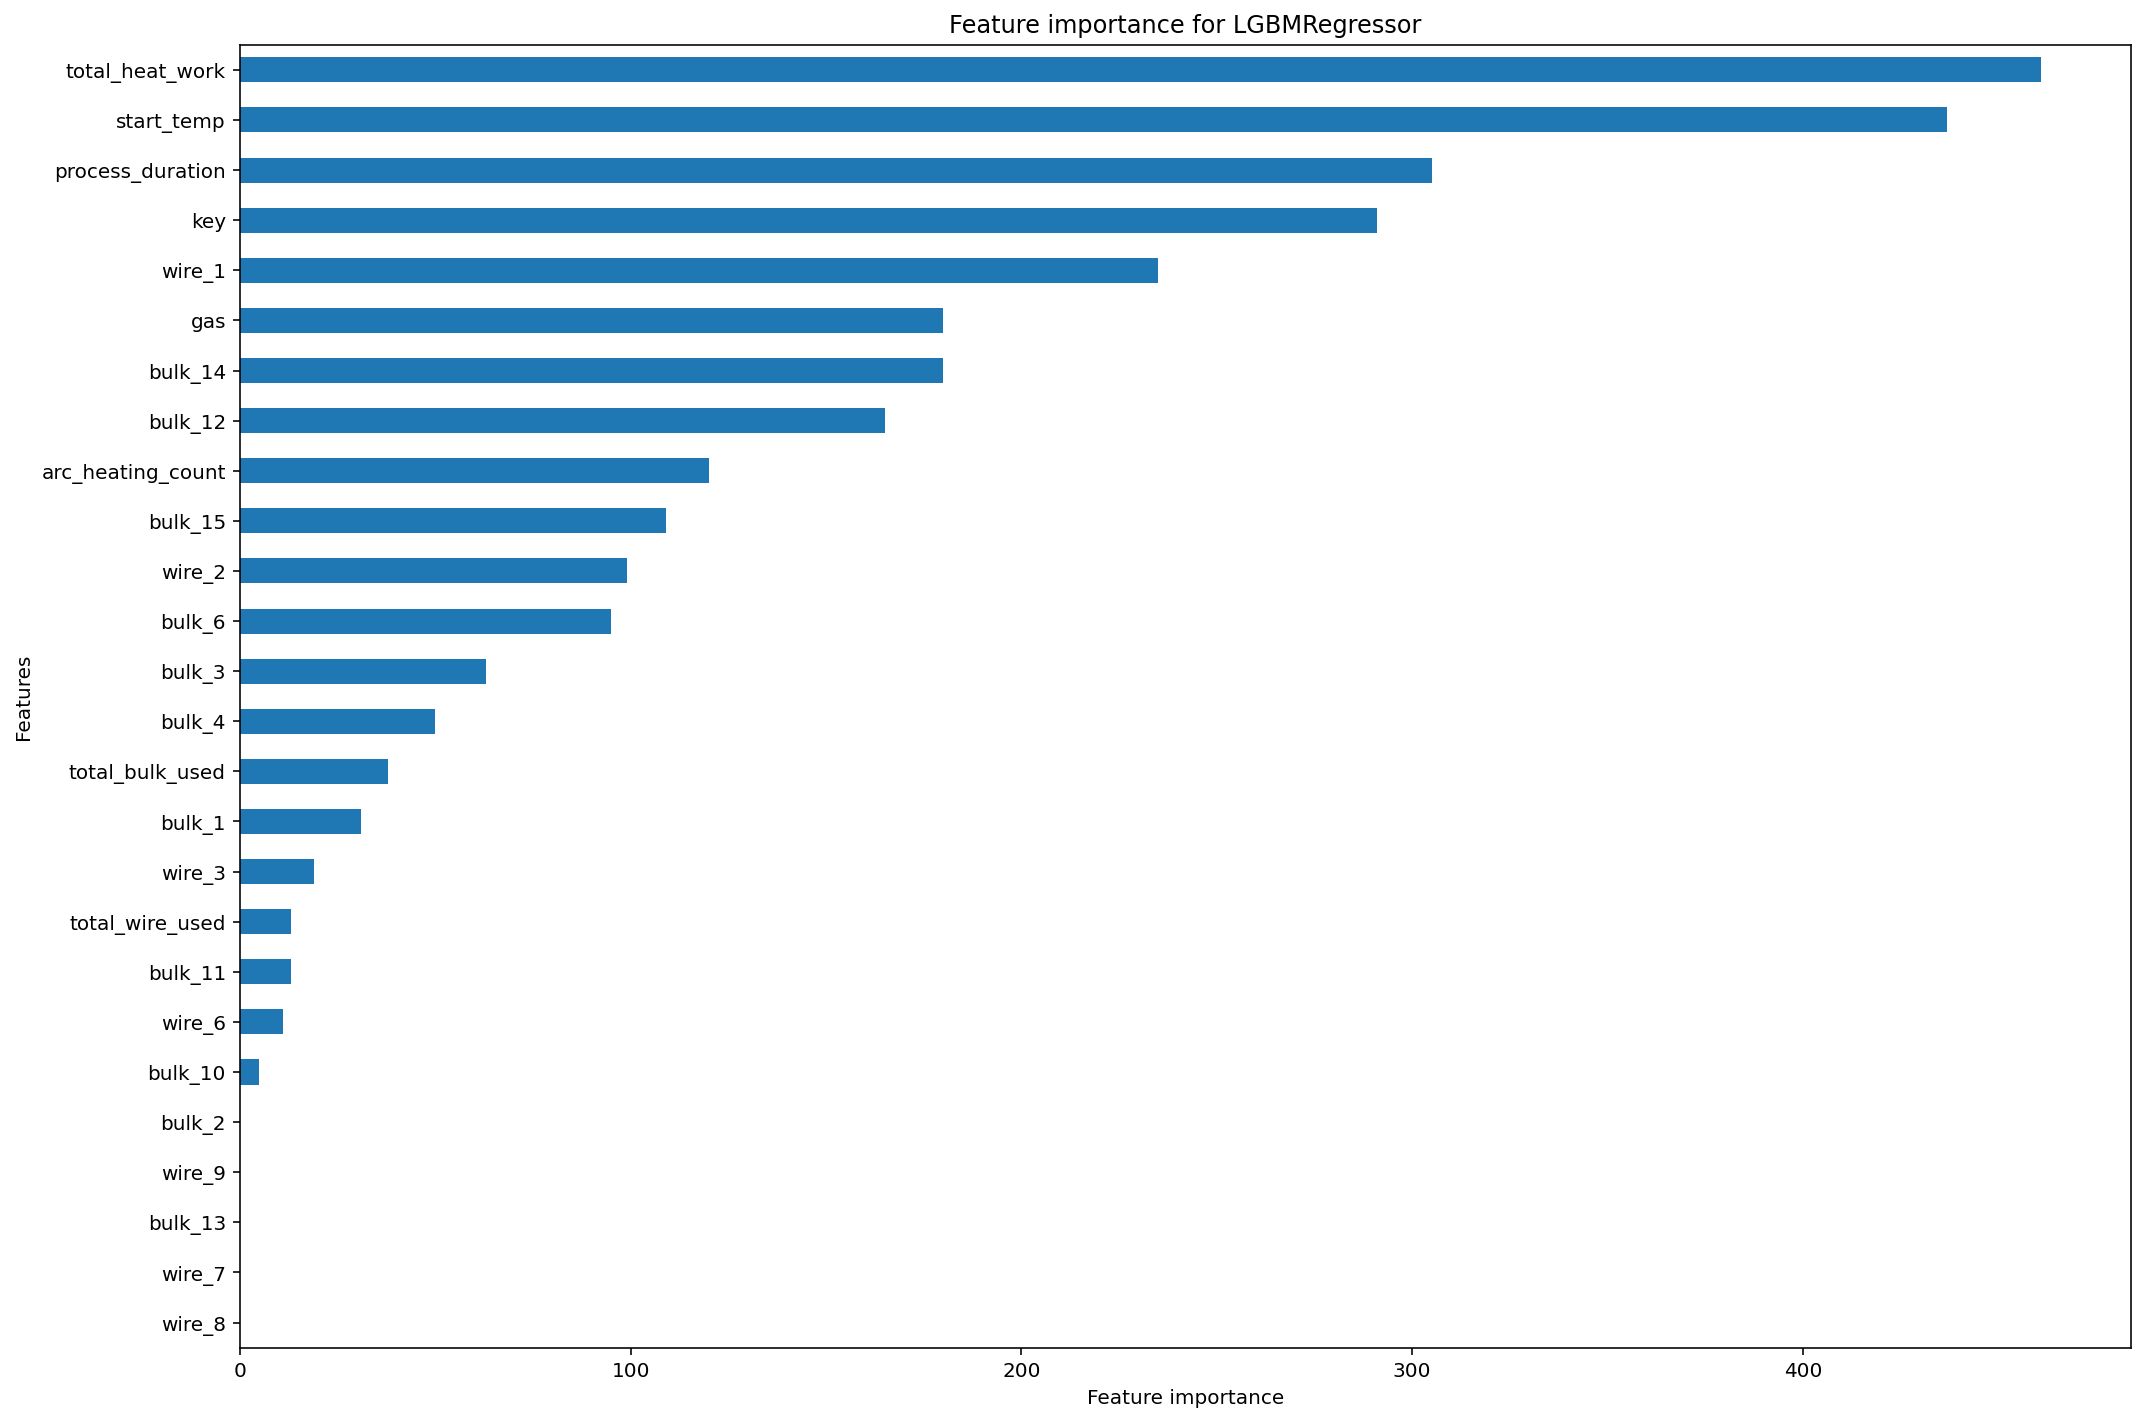

In [60]:
(pd.Series(valid_models[2][-1][-1].feature_importances_,
           index=X_train.columns)
 .sort_values()
 .plot(kind='barh', figsize=(15, 10)));
plt.title('Feature importance for LGBMRegressor')
plt.xlabel('Feature importance')
plt.ylabel('Features')
plt.tight_layout()

Топ признаков: аналогично XGBoost, но тут дополнительно уделили важности и сыпучим материалам под номером 14, 12 и общему количеству нагрева электродами.


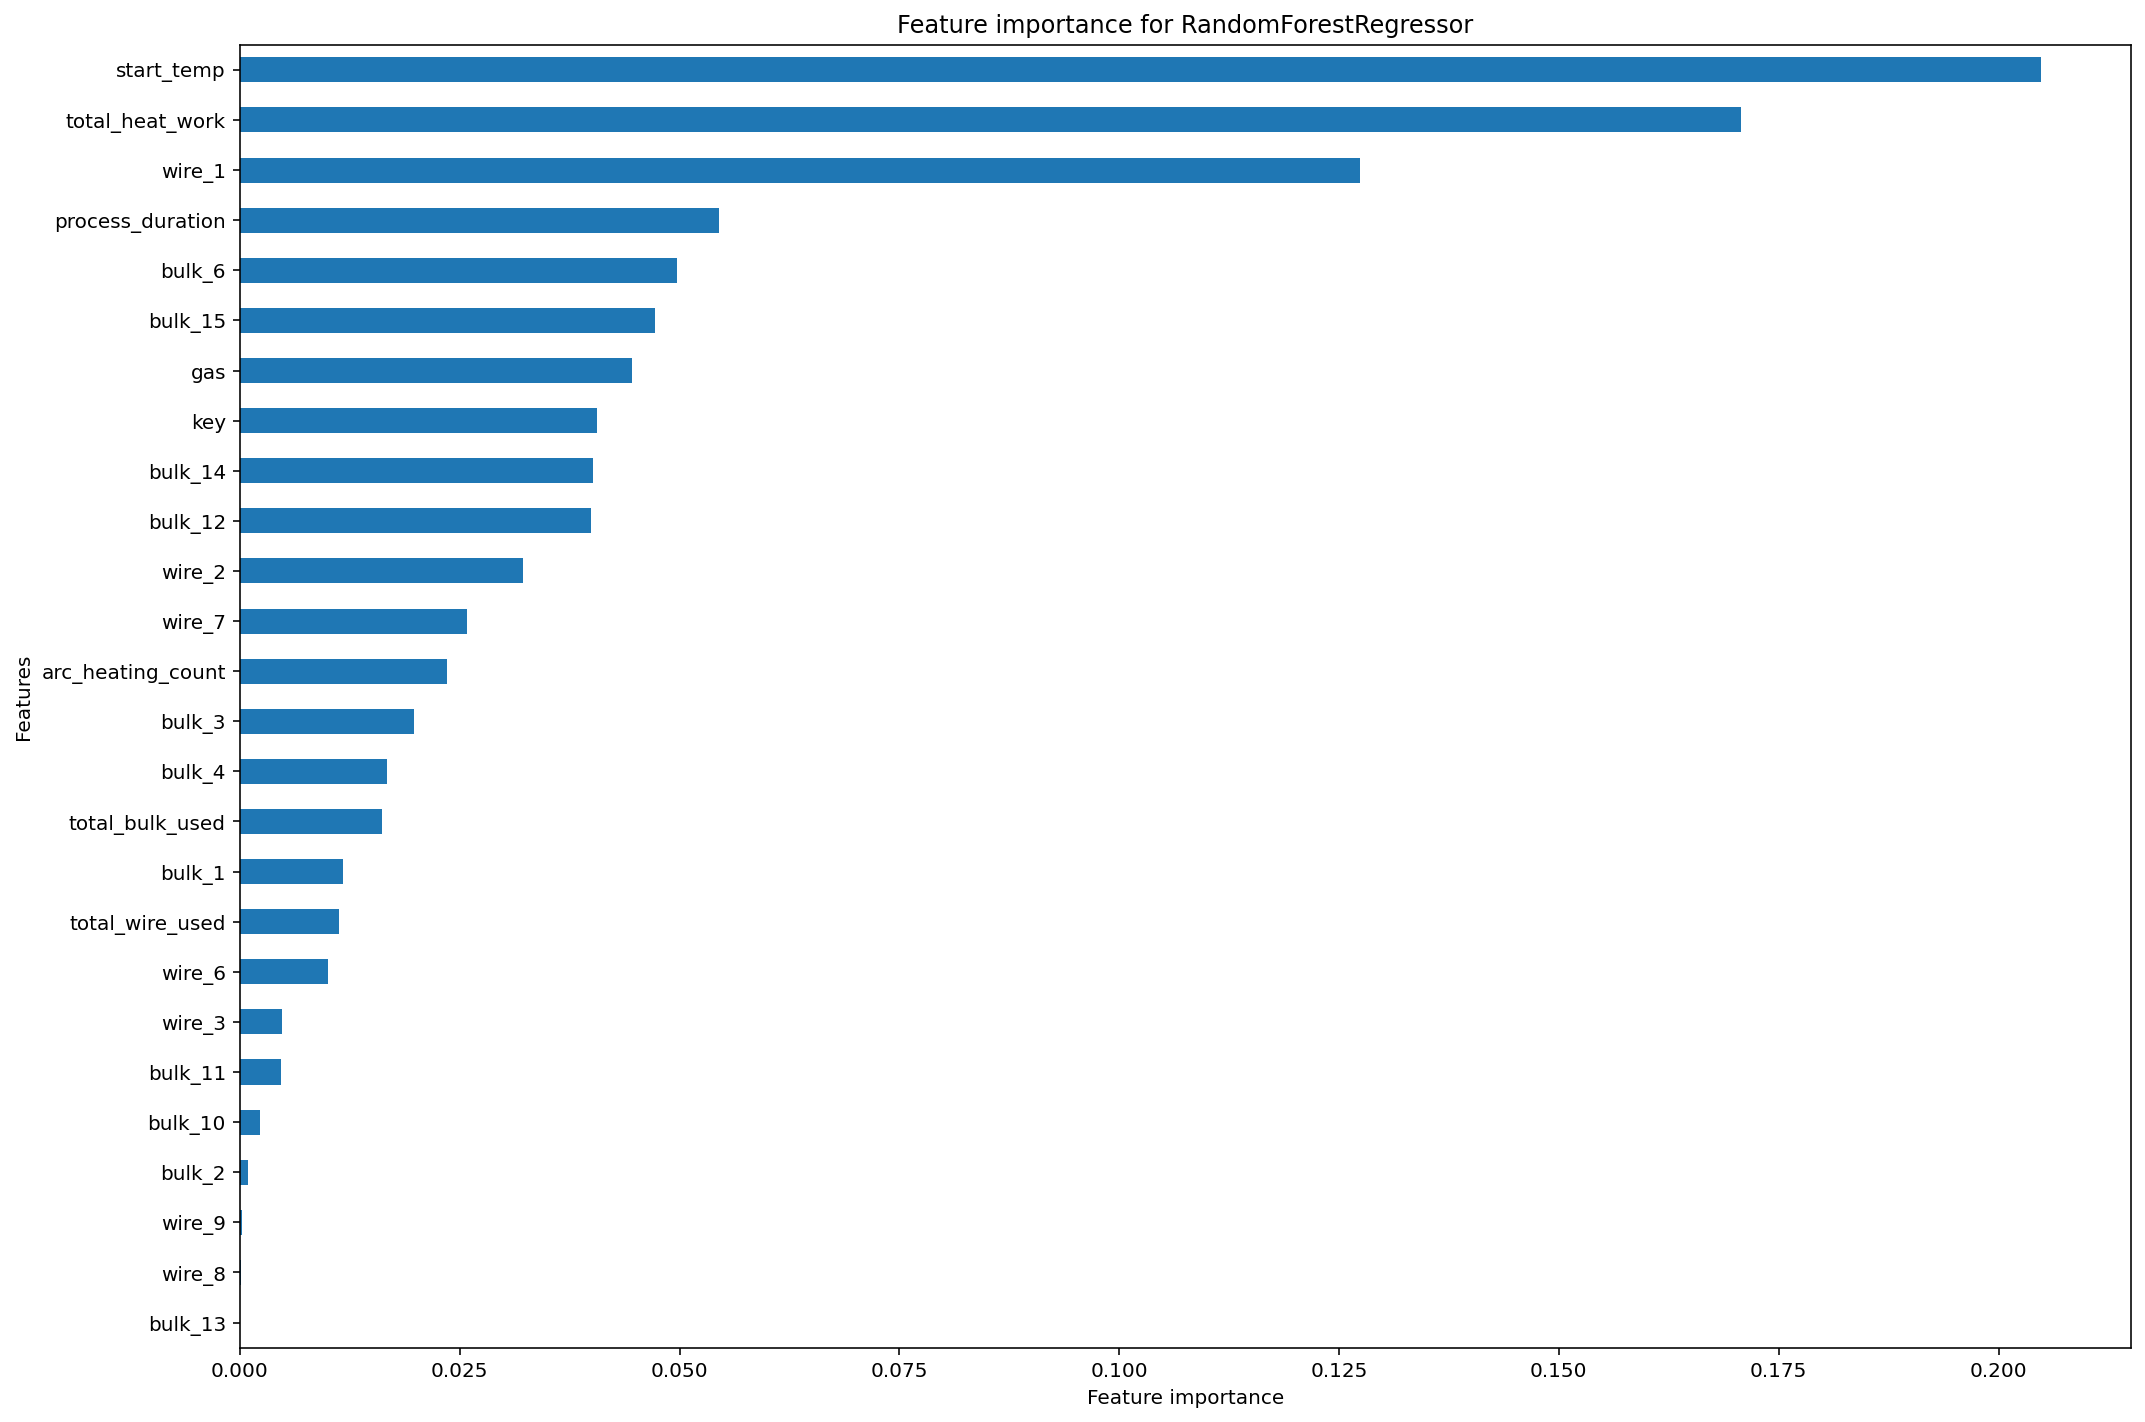

In [61]:
(pd.Series(valid_models[3][-1][-1].feature_importances_,
           index=X_train.columns)
 .sort_values()
 .plot(kind='barh', figsize=(15, 10)));
plt.title('Feature importance for RandomForestRegressor')
plt.xlabel('Feature importance')
plt.ylabel('Features')
plt.tight_layout()

RandomForest целиком опирался на начальную температуру, общую работу за партию и wire_1, общую длительность нагрева.


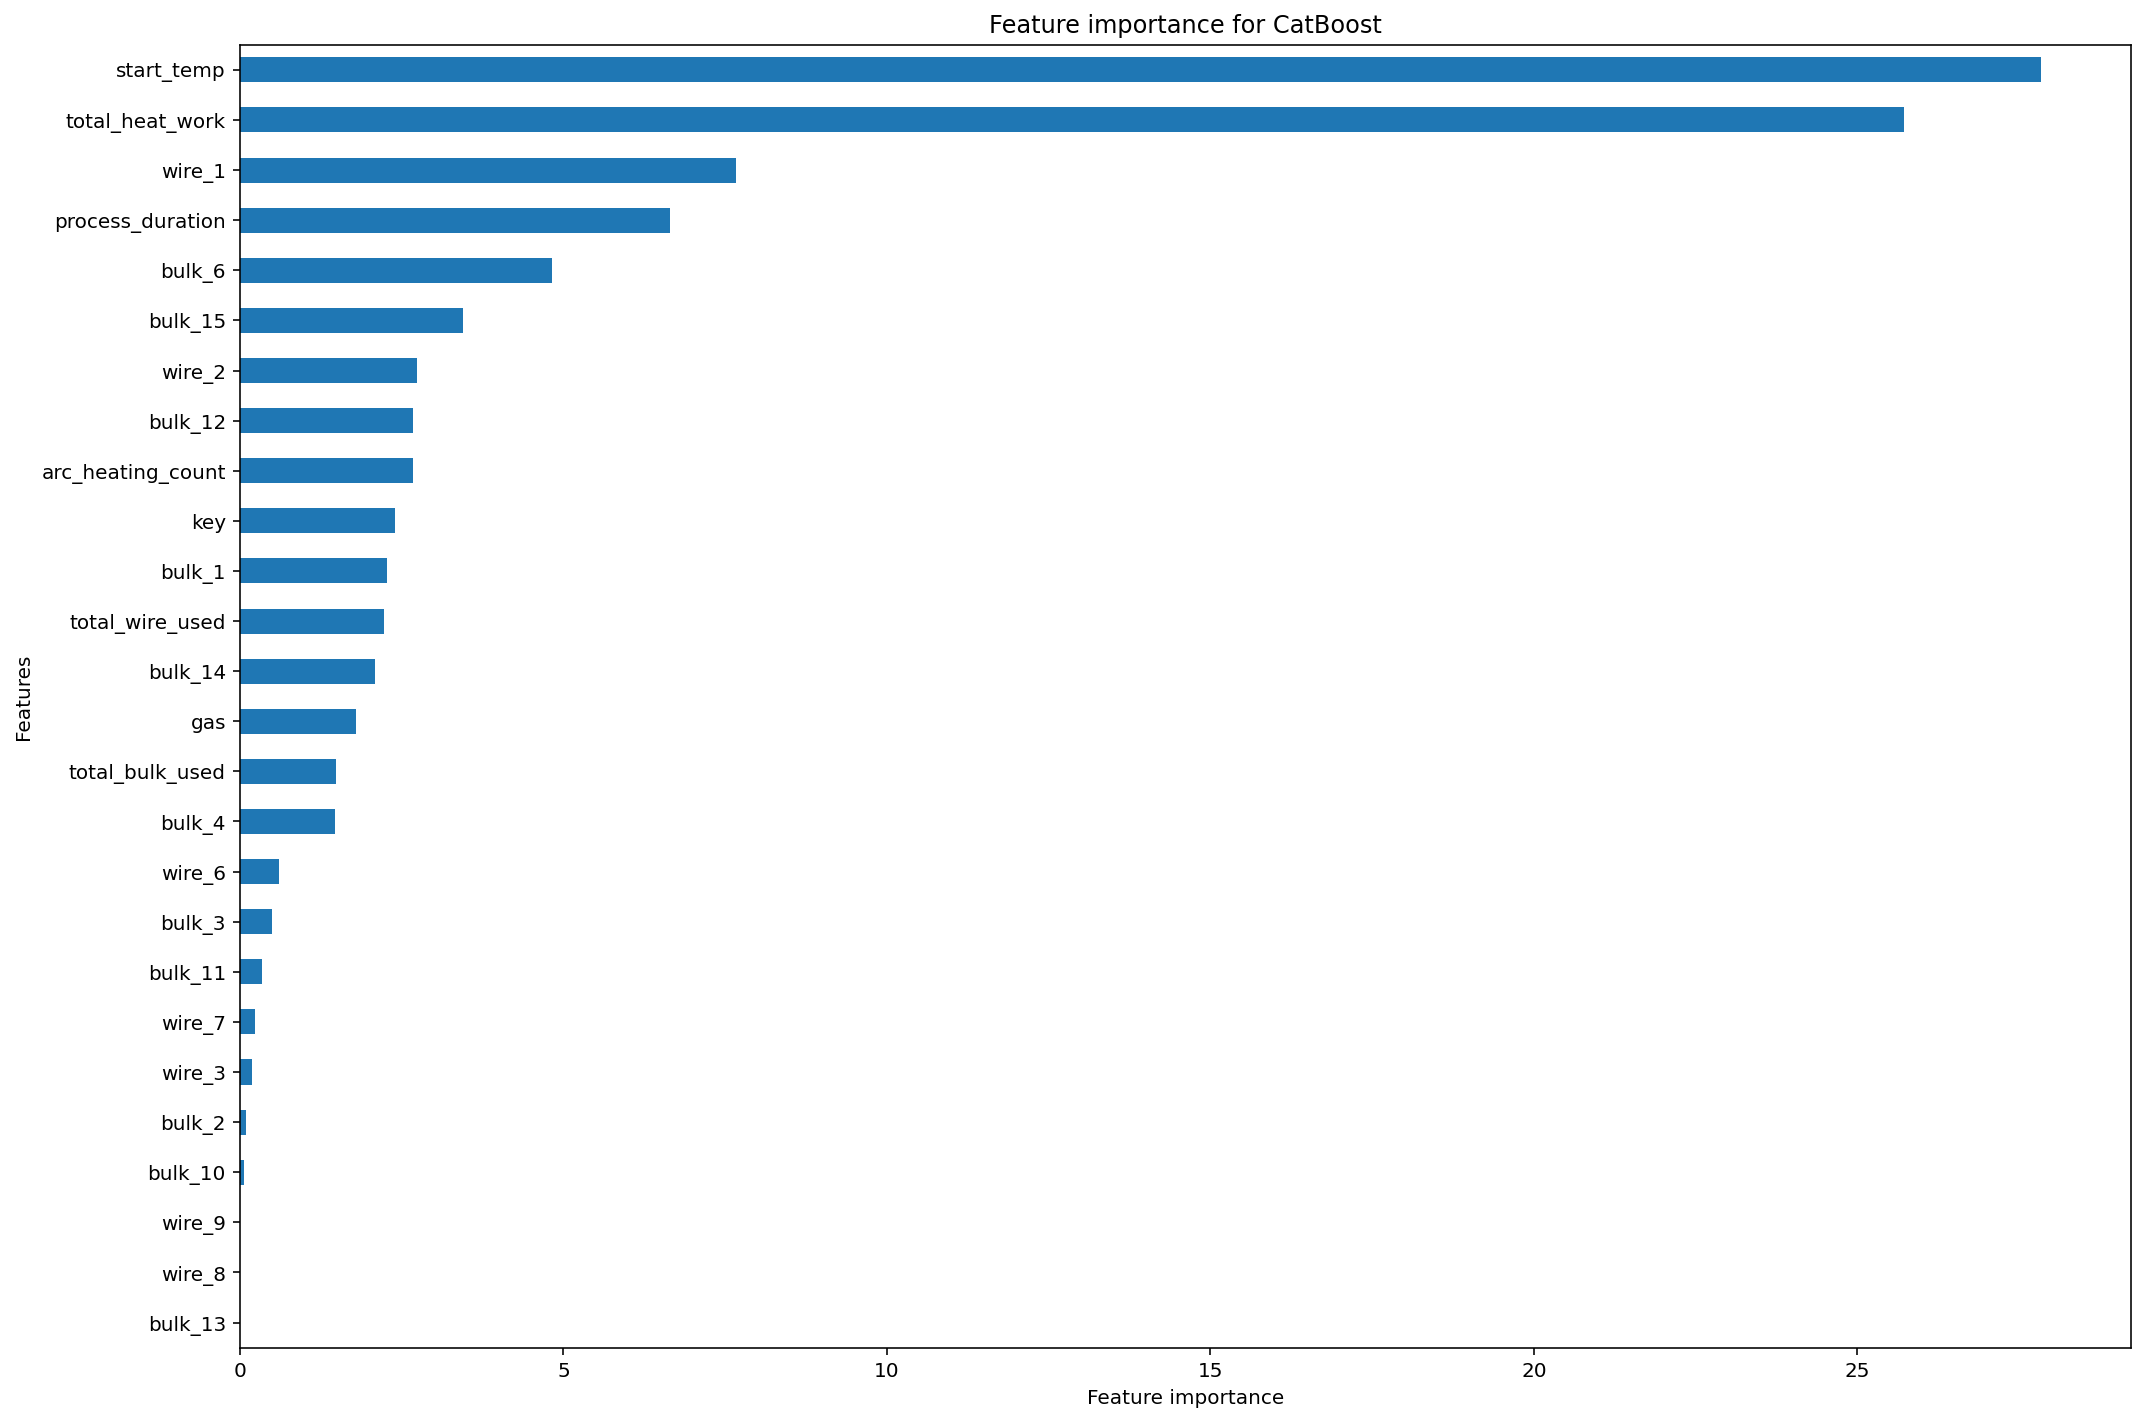

In [62]:
(pd.Series(valid_models[-1][-1][-1].get_feature_importance(),
           index=X_train.columns)
 .sort_values()
 .plot(kind='barh', figsize=(15, 10)))
plt.title('Feature importance for CatBoost')
plt.xlabel('Feature importance')
plt.ylabel('Features')
plt.tight_layout()

CatBoost же опираясь на аналогичные данные добился лучших результатов, отдав больший вес начальной температуре и суммарной мощности. Остальные значения, кроме wire_1, bulk_6 и общей длительности нагрева, не внесли большой пользы в предсказание.


**Вывод:**

- Подготовлены функции для автоматизированной оптимизации и обучения пайплайнов с моделями;
- В общей сложности протестировано на кросс-валидации 5 моделей: Lasso, RandomForestRegressor, XGBoostRegressor, LGBRegressor, CatBoostRegressor.
- Среди моделей лидируют CatBoost и XGBoost
- В общем случае модели считают важными такие параметры как start_temp, total_heat_work, process_duration, total_wire_used, key, gas и некоторые wire и bulk.


# 4.0 Тестирование моделей


Прежде чем проверять конечную модель посмотрим на оценку МАЕ для предсказания случайной моделью.


In [63]:
model = DummyRegressor()
pipe_dummy = Pipeline(steps=[
    ('impute_miss', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaling', StandardScaler()),
    ('model', model)
])
pipe_dummy.fit(X_train, y_train)
mean_absolute_error(y_test, pipe_dummy.predict(X_test))

8.159506952700347

Выведем все модели, которые прошли по метрике необходимый порог в 8.6


In [64]:
pd.DataFrame({'best_MAE': [x[1] for x in valid_models]},
             index=[x[0] for x in valid_models]).style.background_gradient()

,best_MAE
Lasso,5.918908
XGBoost,5.770096
LightGBM,5.868262
RandomForest,6.039022
CatBoost,5.824269


Проверяем лучшую модель на тестовой выборке, сравниваем полученный результат с метрикой baseline модели


In [65]:
mean_absolute_error(y_test, valid_models[-1][-1].predict(X_test))

5.8619909866842965

Как видим, метрика на тестовой выборке меньше почти в 2 раза, так что нашу модель можем считать адекватной.


**Вывод:**

- Среди всех моделей лучшие значения показали CatBoost b XGBoost, их метрика не превышает 6 на тестовой выборке, LightGBM и RandomForest справились с заданием чуть хуже;
- В итоге лучшей моделью по метрике MAE выбран CatBoostRegressor, однако если скорость обучения важна, то надо выбирать модель Lasso;
- Данная модель доказала свою адекватность при сравнении метрик с baseline моделью.


# Выводы

По данной работе можно подвести следующие итоги:

1. Все данные детально изучены, исследованы и визуализированы их особенности, данные приведены к нужному типу;
2. Данные собраны в один dataframe из разных источников, в столбцах, содержащих несколько данных по одной партии были применены группировки и аггрегации sum и count;
3. Сформировано несколько новых признаков на основе имеющихся, такие как общая длительность процесса нагрева, полная суммарная работа на одну партию, длительность нагрева и т.д;
4. Удалены признаки с высокой кореляцией с другими данными, и с низкой вариативностью и малой заполненностью;
5. Созданы функции для автоматизированной оптимизации 5 различных моделей, из них все модели успешно прошли пороговое значение метрики MAE 6.8;
6. Лучшей моделью среди рассмотренных является CatBoostRegressor, который даёт качественную метрику на трейне и тесте(5.824/5.862). Модель доказала свою адекватность по сравнению с константной/случайной моделью.


# Отчёт

## 1. Основное задание

### 1.1 Реализация задания

Работа целиком базировалась на предложенном плане, поэтому в той или иной мере все его пункты были выполнены в достаточной мере. Единственная претензия может заключаться лишь в том, что данные, которые будут подаваться на вход модели, не так хорошо проанализированы, как могли бы быть + возможно стоило уделить аномалиями более пристальное внимание(ввиду специфики задания это задача на 'подумать').

### 1.2 Проблемы и их решения

- **Проблема подключения к данным**: решение выполнялось в google colab, а проверялось в среде practicum, что накладывало определённые ограничения на загрузку данных. Решено через инструкцию try/except.
- **Конфликт библиотек**: некоторые функции и надстройки не работают на тех версиях, что установлены в colab, поэтому от чего-то пришлось отказаться в угоду получения решения, которое не конфликтовало бы с lgbm и xgboost. Решение - отключение некритичных надстроек, альтернативный подход к нахождению feature_importance помимо стандартных методов.
- **Придумать, как обработать данные wire и bulk** - в этих данных есть много пропусков, поэтому хотелось бы предложить вариант, где данные не просто заполняются константами, а аггрегируются или трансформируются во что-то более-менее осмысленное. Решение - PCA для этих данных ухудшило результат, поэтому от такого подхода пришлось отказаться.

### 1.3 Ключевые шаги в решении задачи

- **Загрузка данных**: здесь нужно было правильно загрузить все данные, так чтобы они открывались не только локально но и с сервера, привести сразу дату из строкового типа к формату даты. Также приведены названия столбцов к виду snake_case.
- **Анализ данных(EDA)**: довольно важный этап, который был унифицирован через создание 3-х функций, упрощающий дальнейший визуальный анализ этих данных. Это позволило найти пропуски в дате, аномалии, и распределения заложенных в данные величины. Также удалось отсеять ненужные для моделирования наборы данных и столбцы.
- **Создание финального набора данных**: теперь изученные данные нужно грамотно склеить по номерам партии, там где встречается много партий применить правильные аггрегации, проследить, чтобы не появились лишние пропуски и изучить конечный результат.
- **Создание пайплайна решения и его реализация**: разделение данных, создание пайплайна для предобработки и масштабирования данных для дальнейшего использования в моделях. Также нужно было проследить, что для всех 5 моделей обучение на кросс-валидации и оптимизация происходили корректно и не давало предупреждений/сбоев.
- **Проверка лучшей модели на тестовой выборке**: отсев моделей по пороговой метрике и выбор среди них лучшей, также сравнение с baseline моделью.

### 1.4 Итоговая модель

Среди рассмотренных моделей лучший результат показала модель CatBoostRegressor cо значениями MAE на трейне/тесте = 5.824/5.826, она представляет из себя хороший вариант по скорости обучения/точности решения. Стоит также отметить, что если точность модели не так критична, то предпочтительней использовать модель Lasso, поскольку её скорость обучения и предсказания в разы выше.

## 2. Анализ признаков лучшей модели

Лучшая модель в результате данной работы - CatBoostRegressor, для которого был проведён анализ важности признаков с точки зрения предсказания таргета, укажем переменные по степени важности:

1.  Преимущественно важные:

    1. **start_temp** - самое первое значение температуры сплава, измеренное в ходе изготовления. Данная переменная была получена из исходных данных таблицы df_temp, содержащей информацию об измерениях температуры для каждой партии, значения этих температур и дат их измерения. Из этого набора данных были убраны промежуточные измерения, и оставлены только значения для первого и последнего измерения. Сооответственно для столбца start_temp были взяты только нечётные строки из этого датафрейма, а для end_temp чётные соответственно. В качестве дополнительной обработки из этого фрейма были убраны те партии, в которых начальная температура стали была меньше 1500 градусов, поскольку это не соответствует физике процесса плавления стали. Также предположение о том, что эти значения можно было расценивать как выбросы, подтверждается анализом через отсортированный value_counts - таких значений всего 7 штук + разрыв между последним аномальным и обычным значением составляет порядка 100 градусов, что довольно большая разница.

    2. **total_heat_work** - суммарное значение работы, затраченной на нагрев стали. Этот столбец был получен в несколько шагов:

    - Посчитано время использования электродов arc_heating_duration через разницу конечного и начального времени использования электродов;
    - Посчитана полная мощность full_power из активной и реактивной мощностей;
    - Посчитана работа нагрева на каждое использования электродов, путём перемножения этих величин;
    - Далее значения аггрегировались на сумму и подсчёт количества, чтобы знать, сколько работы суммарно было затрачено работы для нагрева стали от начальной температуры и до конечной и сколько раз при этом использовались электроды.

    Дополнительная обработка для этого столбца не проводилось, однако стоит отметить, что цель данной работы затрагивает отптимизацию затрат на нагрев, что неприменно должно быть связано с полной работой. Необходимость в данной операции также визуально поддтверждает анализ данного столбца через boxplot, свидетельствующий о приличном количестве возможных 'выбросов'.

2.  Значимые

    1. **wire_1** - данные об объёме использованного провода-присадки под номером 1. Самый заполненный столбец в таблице df_wire, согласно boxplot'у имеет часть потенциальных выбросов. Использование данного столбца в качестве влияющего на конечную температуру фактора оправдано в силу того, что легирование стали может существенно изменять его свойства, в том числе температуру плавления и ползучесть. Пропуски заполнены 0 внутри пайплайна обучения.
    2. **bulk_6, bulk_15** - данные о объёме использованных сыпучих материалов. Аналогично wire используются для легирования, поэтому могут оказывать существенное влияние на свойства конечного материала. Интерес представляет значимость столбца 6, поскольку в нём содержится всего 576 значений против 2248 в bulk_15. Имеющиеся пропуски в них были заполнены 0, поскольку они аналогичны тому, что для данной партии этот легирующий материал не использовался. В bulk_15 данные не выбиваются, а в bulk_6 есть немного возможных аномалий.
    3. **process_duration** - общая длительность измерений, от начального этапа до конечного, получен путём суммирования длительности каждого измерения температуры. На мой взгляд, может косвенно влиять на конечный результат, поскольку большое значение времени сведетельствует о том, что требуемое качество стали не было получено за пару итераций и с каждой следующей возрастает сложность предсказания конечного результата. Пропусков в данном столбце нет, а вот аномалии присутствуют.

3.  Неважные

    1. **wire_2** - данные о проволочном материале 2. Аномалии присутствуют, пропуски заполнены 0;
    2. **bulk_12, bulk_1, bulk_14, bulk_4** - ряд данных по сыпучим материалам, удивительн то, что все кроме 1 имеют в себе много данных, но сильного влияния не оказывают. Аномалии оставлены как есть,
    3. **arc_heating_count** - сколько раз были использованы электроды для нагрева, пропусков нет, есть несколько аномалий;
    4. **key** - данные о номере партии, не трубуют никакой обработки. Технически есть шанс, повлиять на конечную температуру, если производитель допустим для следующей партии будет не нагревать с 0 электроды, а сразу после предыдущей партии делать следующую, однако в нашем случае измерения проводились независимо на разной технике;
    5. **total_wire_used, total_bulk_used** - сколько раз за партию добавляли проволочные и сыпучие материалы - пропусков нет, обработки не требуют, есть пара аномалий. Получены подсчётом заполненных значений в строке для уникального номера партии в соответствующей таблицы;
    6. **gas** - данные о объёме используемого газа для продувки, пропусков нет, аномалий небольшое количество. Технически может влиять на конечную температуру сплава, но как результат влияние не столь существенно.

4.  Прочие

    Для всех столбцов использовались заполнение пропусков 0 внутри пайплайна обучения. Судить о наличии или отсутствии аномалий в данных столбцах сложно поскольку данных в них крайне мало по сравнению с общим числом наблюдений. Вероятно поэтому они практически не использовались для обучения.

    1. **wire_6, wire_7, wire_3, wire_9, wire_8** - данные по проволочным материалам.

    2. **bulk_3, bulk_11, bulk_2, bulk_10, bulk_13** - данные по сыпучим материалам.

## 3. Анализ гиперпараметров лучшей модели

Для модели CatBoostRegressor оптимизация гиперпараметров не проводилась, поскольку обучение одной модели занимает больше 1 минуты и для получения сколько либо положительного результата необходимо не меньше 10-30 итераций, то это неоптимально с точки зрения затраченного времени. Также стоит учитывать, что данная модель может выдавать удачные метрики и без особого перебора гиперпараметров. Тем не менее в обучении использовались следующие гиперпараметры

- **learning_rate**: 0.01 - скорость обучения, выбрана таким образом, чтобы модель не сильно переобучалась/для более устойчивого решения на тесте;
- **depth**: None - глубина дерева решений, оставлена по умолчанию, поскольку увеличение параметра приводило к более долгому обучению модели;
- **random_seed**: SEED - устанавливаем конкретную последовательность генерации случайных чисел для воспроизводимости, в нашем случае SEED=100423;
- **verbose**: False - отключённые сообщения о ходе обучения, необходимо, чтобы на кросс-валидации не было слишком много ненужной информации, а только интересующий результат.

Если всё же проводить оптимизацию как полагается, то к параметрам 'learning_rate' и 'depth' следует добавить и такой параметр как 'l2_leaf_reg' для дополнительной регуляризации данных. Отдельно метрика MAE в самой модели не была выбрана, поскольку её расчётом занимался не сам CatBoost, а cross_val_score, в котором задан параметр scoring='neg_mean_abs_error'.

## 4. Дальнейшие рекомендации

Я вижу улучшение решения/модели через следующие варианты:

- **Сменить предсказываемый таргет на перепад температур** - возможно для более качественного предсказания конечной температуры, нужно сменить фокус с неё на перепад температуры между начальным и конечным положениями. Это позволит чуть точнее определить, какие факторы являются определяющими, чтобы в дальнейшем их оптимизировать. Однако стоит отметить, что в таком случае нужно более тщательно проводить замеры температур начального и конечного этапа. Как вы видели в анализе, данных везде разное количество, + начиная с определённого этапа замеры конечной температуры не производились в принципе. Также это может позволить склонить задачу в сторону аналитического решения, то есть возможно использовать знания из термодинамики для нахождения распределения температур в ковше и конечное состояние аналитически/численными методами для нахождения способа съэкономить на нагреве сплава.
- **Провести тщательную оптимизацию итоговой модели** - выше были предложены гиперпараметры для настройки CatBoost, использовать Optuna для оптимизации поиска.
- **Добавить доп шаги в пайплайн решения** - возможно каким то образом саггрегировать данные о сыпучих и проволочных материалах, чтобы банально не заполнять их константными значениями, поработать с датами использования этих материалов, создать из нихновые признаки, а не просто удалить эти таблицы.
- **Находить аномалии продвинуто** - использовать не только визуальный анализ но модели для поиска аномалий - Isolation Forest, его более продвинутые версии, DBSCAN и т.п.
